In [17]:
import pandas as pd
import numpy as np
import geopandas as gpd
import lightgbm
from shapely.geometry import shape
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import recall_score

In [18]:
df_train = pd.read_csv('data/train_dataset_train.csv').rename(columns={'.geo': 'geo'})
df_test = pd.read_csv('data/test_dataset_test.csv').rename(columns={'.geo': 'geo'})


In [19]:
nd_cols_raw = [col for col in df_train.columns if col.startswith('nd')]
nd_cols = pd.to_datetime([col[8:] for col in nd_cols_raw]).date
df_train = df_train.rename(columns={k: v for k, v in zip(nd_cols_raw, nd_cols)})
df_test = df_test.rename(columns={k: v for k, v in zip(nd_cols_raw, nd_cols)})

In [20]:
weeks = pd.date_range(nd_cols.min(), nd_cols.max(), freq='W').date
for i, week in enumerate(weeks):
    df_train[f'week_{i}_gain'] = df_train[nd_cols[nd_cols<week]].apply(max, axis=1)
    df_test[f'week_{i}_gain'] = df_test[nd_cols[nd_cols<week]].apply(max, axis=1)    

In [21]:
week_cols = [col for col in df_train.drop(nd_cols, axis=1).columns if col.startswith('week')]
df_train[week_cols] = df_train[week_cols].apply(lambda x: x - x.shift(), axis=1)
df_test[week_cols] = df_test[week_cols].apply(lambda x: x - x.shift(), axis=1)
df_train.drop('week_0_gain', axis=1, inplace=True)
df_test.drop('week_0_gain', axis=1, inplace=True)

In [22]:
# ИЗВЛЕКАЕТ КООРДИНАТЫ ЦЕНТРОИДА КАЖДОГО ПОЛИГОНА
def get_centroids(df):
    geom = [shape(i) for i in df.geo.apply(eval)]
    geo_df = gpd.GeoDataFrame(geometry=geom)
    centroid = geo_df.centroid
    area = geo_df.area
    df['centroid_x'] = centroid.x
    df['centroid_y'] = centroid.y
    df['area'] = area

In [24]:
get_centroids(df_train)
get_centroids(df_test)

In [25]:
X = df_train.drop(['geo', 'crop', 'id'], axis=1)
y = df_train.crop
df_test.drop(['geo', 'id'], axis=1, inplace=True)

## Optuna

In [15]:
import optuna
from optuna.integration import LightGBMPruningCallback
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold

def objective(trial, X, y):
    param_grid = {
        "objective": trial.suggest_categorical("objective", ["multiclassova", "multiclass"]),
        "num_class": 7,
        "verbosity": -1,
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.3, step=0.005),
        "num_leaves": trial.suggest_int("num_leaves", 10, 2000, step=10),
        "max_depth": trial.suggest_int("max_depth", 1, 12, step=1),
        #"min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 3000, step=50),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=2),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=2),
        #"min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.65, 0.95, step=0.05),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1, 3, 5, 7]),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.65, 0.95, step=0.05
        ),
    }
    
    CV_res = []
    kf = KFold(n_splits=10, random_state=42, shuffle=True)
    
    for trn_idx, tst_idx in kf.split(df_train):
        X_train1, X_test1, y_train1, y_test1 = X.iloc[trn_idx], X.iloc[tst_idx], y.iloc[trn_idx], y.iloc[tst_idx]
        lgtrain, lgval = lightgbm.Dataset(X_train1, y_train1), lightgbm.Dataset(X_test1, y_test1)
        lgbmodel = lightgbm.train(param_grid, lgtrain, 10000, valid_sets=[lgtrain, lgval], callbacks=[lightgbm.log_evaluation(0), lightgbm.early_stopping(100)])
        recall = recall_score(y_test1, lgbmodel.predict(X_test1).argmax(axis=1), average='macro', zero_division=True)
        CV_res.append(recall)
    print(CV_res)
    return np.mean(CV_res)


study = optuna.create_study(direction="maximize", study_name="LGBM Classifier", pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))
func = lambda trial: objective(trial, X, y)
study.optimize(func, n_trials=500)

[I 2022-11-20 00:44:43,355] A new study created in memory with name: LGBM Classifier


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[354]	training's multi_logloss: 0.774034	valid_1's multi_logloss: 0.773824
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[450]	training's multi_logloss: 0.766877	valid_1's multi_logloss: 0.79651
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[698]	training's multi_logloss: 0.760603	valid_1's multi_logloss: 0.771311
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[284]	training's multi_logloss: 0.782852	valid_1's multi_logloss: 0.810045
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[354]	training's multi_logloss: 0.772051	valid_1's multi_logloss: 0.799761
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[640]	training's multi_logloss: 0.760425	val

[I 2022-11-20 00:44:57,554] Trial 0 finished with value: 0.8373766672852894 and parameters: {'objective': 'multiclass', 'learning_rate': 0.034999999999999996, 'num_leaves': 1500, 'max_depth': 2, 'lambda_l1': 82, 'lambda_l2': 20, 'bagging_fraction': 0.65, 'bagging_freq': 5, 'feature_fraction': 0.9}. Best is trial 0 with value: 0.8373766672852894.


Early stopping, best iteration is:
[671]	training's multi_logloss: 0.760689	valid_1's multi_logloss: 0.760051
[0.8332281409353078, 0.8338861535290107, 0.8248184376846011, 0.8364483237149495, 0.8355278381908805, 0.8283396383545304, 0.858135379714055, 0.8532327209566015, 0.8292924414824884, 0.8408575982904681]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[95]	training's multi_logloss: 0.505938	valid_1's multi_logloss: 0.560083
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's multi_logloss: 0.501208	valid_1's multi_logloss: 0.555113
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	training's multi_logloss: 0.500165	valid_1's multi_logloss: 0.529617
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[89]	training's multi_logloss: 0.503063	valid_1's multi_logloss: 0.567318
Traini

[I 2022-11-20 00:45:04,365] Trial 1 finished with value: 0.9304899474401838 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.085, 'num_leaves': 40, 'max_depth': 8, 'lambda_l1': 72, 'lambda_l2': 8, 'bagging_fraction': 0.95, 'bagging_freq': 5, 'feature_fraction': 0.95}. Best is trial 1 with value: 0.9304899474401838.


Early stopping, best iteration is:
[61]	training's multi_logloss: 0.503962	valid_1's multi_logloss: 0.531879
[0.9271369345317099, 0.9416874791874792, 0.9364715116815958, 0.9268436488519459, 0.9240491925041188, 0.9195876143381728, 0.9373362488270429, 0.9339605092870018, 0.9306132384236869, 0.927213096769084]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1431]	training's multi_logloss: 0.677836	valid_1's multi_logloss: 0.725162
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2254]	training's multi_logloss: 0.673943	valid_1's multi_logloss: 0.730822
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2337]	training's multi_logloss: 0.671222	valid_1's multi_logloss: 0.680155
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2477]	training's multi_logloss: 0.676711	valid_1's multi_logloss: 0.729055

[I 2022-11-20 00:45:59,296] Trial 2 finished with value: 0.9030756798157322 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.01, 'num_leaves': 740, 'max_depth': 8, 'lambda_l1': 76, 'lambda_l2': 12, 'bagging_fraction': 0.7000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.8500000000000001}. Best is trial 1 with value: 0.9304899474401838.


[0.8949736023683776, 0.9164579468150896, 0.906307999079684, 0.9092854863464375, 0.9005436486956252, 0.8871035950894477, 0.9093946250342803, 0.9193385779206675, 0.9003931183450121, 0.8869581984626996]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[234]	training's multi_logloss: 0.319814	valid_1's multi_logloss: 0.381991
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[260]	training's multi_logloss: 0.321226	valid_1's multi_logloss: 0.385497
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[315]	training's multi_logloss: 0.321148	valid_1's multi_logloss: 0.360944
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[223]	training's multi_logloss: 0.320993	valid_1's multi_logloss: 0.389649
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[392]	training'

[I 2022-11-20 00:46:17,222] Trial 3 finished with value: 0.9517094169532792 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.030000000000000002, 'num_leaves': 1780, 'max_depth': 8, 'lambda_l1': 40, 'lambda_l2': 4, 'bagging_fraction': 0.95, 'bagging_freq': 7, 'feature_fraction': 0.8500000000000001}. Best is trial 3 with value: 0.9517094169532792.


Early stopping, best iteration is:
[231]	training's multi_logloss: 0.322739	valid_1's multi_logloss: 0.362405
[0.9565764493054233, 0.9527026544883689, 0.9491504294025302, 0.9522793927697661, 0.9569035505850474, 0.9453221697637186, 0.9449946581027028, 0.9529467796725258, 0.959335666772066, 0.9468824186706425]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[308]	training's multi_logloss: 0.412436	valid_1's multi_logloss: 0.473684
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[386]	training's multi_logloss: 0.409815	valid_1's multi_logloss: 0.474753
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[527]	training's multi_logloss: 0.41978	valid_1's multi_logloss: 0.453362
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[228]	training's multi_logloss: 0.416904	valid_1's multi_logloss: 0.486696
Tra

[I 2022-11-20 00:46:30,783] Trial 4 finished with value: 0.9424652247730991 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.155, 'num_leaves': 1970, 'max_depth': 10, 'lambda_l1': 54, 'lambda_l2': 22, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 1, 'feature_fraction': 0.95}. Best is trial 3 with value: 0.9517094169532792.


Early stopping, best iteration is:
[102]	training's multi_logloss: 0.419391	valid_1's multi_logloss: 0.452953
[0.9361250654566683, 0.954488368774083, 0.945045710591929, 0.9361177382345343, 0.936455533535381, 0.9375614705473233, 0.9456432354949634, 0.9489840282750731, 0.9441652304492604, 0.9400658663717748]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[139]	training's multi_logloss: 0.551639	valid_1's multi_logloss: 0.568462
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[86]	training's multi_logloss: 0.551537	valid_1's multi_logloss: 0.581215
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[179]	training's multi_logloss: 0.551989	valid_1's multi_logloss: 0.563664
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[114]	training's multi_logloss: 0.552638	valid_1's multi_logloss: 0.578691
Train

[I 2022-11-20 00:46:37,919] Trial 5 finished with value: 0.89149841611043 and parameters: {'objective': 'multiclass', 'learning_rate': 0.115, 'num_leaves': 1900, 'max_depth': 3, 'lambda_l1': 80, 'lambda_l2': 14, 'bagging_fraction': 0.95, 'bagging_freq': 7, 'feature_fraction': 0.9}. Best is trial 3 with value: 0.9517094169532792.


Early stopping, best iteration is:
[128]	training's multi_logloss: 0.556941	valid_1's multi_logloss: 0.56438
[0.8834231688811166, 0.91291169148312, 0.8974271846939558, 0.8812521905454709, 0.894643076824016, 0.8682931530288195, 0.9002784422390367, 0.9013589778515152, 0.8839719905389106, 0.8914242850183384]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[113]	training's multi_logloss: 0.213327	valid_1's multi_logloss: 0.246775
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[234]	training's multi_logloss: 0.205707	valid_1's multi_logloss: 0.247392
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[159]	training's multi_logloss: 0.206805	valid_1's multi_logloss: 0.23891
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[180]	training's multi_logloss: 0.204869	valid_1's multi_logloss: 0.240166
Traini

[I 2022-11-20 00:46:44,756] Trial 6 finished with value: 0.9473670260279908 and parameters: {'objective': 'multiclass', 'learning_rate': 0.255, 'num_leaves': 810, 'max_depth': 2, 'lambda_l1': 18, 'lambda_l2': 48, 'bagging_fraction': 0.8, 'bagging_freq': 7, 'feature_fraction': 0.65}. Best is trial 3 with value: 0.9517094169532792.


Early stopping, best iteration is:
[165]	training's multi_logloss: 0.209647	valid_1's multi_logloss: 0.216416
[0.9432152725468754, 0.9462787212787214, 0.942587465233812, 0.9528644369140061, 0.9603839985416809, 0.9276210841363485, 0.9407365440384918, 0.9526423913084361, 0.9449880028789589, 0.9623523434025759]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[418]	training's multi_logloss: 0.395125	valid_1's multi_logloss: 0.445547
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[563]	training's multi_logloss: 0.386932	valid_1's multi_logloss: 0.432076
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[539]	training's multi_logloss: 0.390677	valid_1's multi_logloss: 0.41344
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[470]	training's multi_logloss: 0.392312	valid_1's multi_logloss: 0.435359
Tra

[I 2022-11-20 00:47:02,388] Trial 7 finished with value: 0.9389428603658054 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.195, 'num_leaves': 1530, 'max_depth': 3, 'lambda_l1': 38, 'lambda_l2': 94, 'bagging_fraction': 0.7000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 3 with value: 0.9517094169532792.


Early stopping, best iteration is:
[472]	training's multi_logloss: 0.395172	valid_1's multi_logloss: 0.42354
[0.9350929424877179, 0.9480927802356375, 0.9336697129960199, 0.9344586589229404, 0.9376068493248547, 0.924685294435853, 0.9370795629139658, 0.954876335006932, 0.9388329800898852, 0.9450334872442463]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[89]	training's multi_logloss: 0.646837	valid_1's multi_logloss: 0.691507
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[68]	training's multi_logloss: 0.644598	valid_1's multi_logloss: 0.699827
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[69]	training's multi_logloss: 0.642455	valid_1's multi_logloss: 0.651808
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[125]	training's multi_logloss: 0.645898	valid_1's multi_logloss: 0.70115
Training

[I 2022-11-20 00:47:11,296] Trial 8 finished with value: 0.904219475663627 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.18000000000000002, 'num_leaves': 1880, 'max_depth': 11, 'lambda_l1': 78, 'lambda_l2': 100, 'bagging_fraction': 0.8, 'bagging_freq': 5, 'feature_fraction': 0.7000000000000001}. Best is trial 3 with value: 0.9517094169532792.


Early stopping, best iteration is:
[129]	training's multi_logloss: 0.648037	valid_1's multi_logloss: 0.679669
[0.8892754245771766, 0.914818316604031, 0.9041702208914856, 0.8988704996085817, 0.9059011175464363, 0.8906035182654691, 0.9175851971091838, 0.9195420729935655, 0.9101058515584513, 0.8913225374818893]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[27]	training's multi_logloss: 0.46231	valid_1's multi_logloss: 0.517878
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[26]	training's multi_logloss: 0.465997	valid_1's multi_logloss: 0.516944
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[67]	training's multi_logloss: 0.461926	valid_1's multi_logloss: 0.490588
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[32]	training's multi_logloss: 0.460913	valid_1's multi_logloss: 0.533792
Trainin

[I 2022-11-20 00:47:18,362] Trial 9 finished with value: 0.9350555627343461 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.20500000000000002, 'num_leaves': 1800, 'max_depth': 12, 'lambda_l1': 66, 'lambda_l2': 30, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.9}. Best is trial 3 with value: 0.9517094169532792.


Early stopping, best iteration is:
[49]	training's multi_logloss: 0.463027	valid_1's multi_logloss: 0.496168
[0.9313982607298635, 0.9356821749678892, 0.9426539846707914, 0.9291769872505965, 0.9442450386335269, 0.9210852955268444, 0.9400508392745525, 0.9380232073795508, 0.9343303135693335, 0.9339095253405125]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[793]	training's multi_logloss: 0.0748055	valid_1's multi_logloss: 0.189969
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[714]	training's multi_logloss: 0.0765879	valid_1's multi_logloss: 0.184472
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[755]	training's multi_logloss: 0.0752683	valid_1's multi_logloss: 0.166161
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[882]	training's multi_logloss: 0.0724465	valid_1's multi_logloss: 0.18977

[I 2022-11-20 00:48:15,867] Trial 10 finished with value: 0.9657093702027619 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.065, 'num_leaves': 1240, 'max_depth': 6, 'lambda_l1': 6, 'lambda_l2': 70, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 7, 'feature_fraction': 0.8}. Best is trial 10 with value: 0.9657093702027619.


[0.9662688662688662, 0.9637095047809334, 0.9597285067873303, 0.9687867552084125, 0.9731427831819657, 0.9577709954478383, 0.9571020928831621, 0.9693270773028235, 0.967291674728074, 0.9739654454382132]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[910]	training's multi_logloss: 0.0261173	valid_1's multi_logloss: 0.167931
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[839]	training's multi_logloss: 0.0287803	valid_1's multi_logloss: 0.166677
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[992]	training's multi_logloss: 0.0239336	valid_1's multi_logloss: 0.142867
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[659]	training's multi_logloss: 0.0372082	valid_1's multi_logloss: 0.173289
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1309]	trai

[I 2022-11-20 00:49:57,216] Trial 11 finished with value: 0.96850742397879 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.07, 'num_leaves': 1180, 'max_depth': 6, 'lambda_l1': 0, 'lambda_l2': 74, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 7, 'feature_fraction': 0.8}. Best is trial 11 with value: 0.96850742397879.


[0.9681993681993682, 0.9701334379905809, 0.9575307045895282, 0.9687867552084125, 0.9769021816782063, 0.9559035818157187, 0.9643761866670831, 0.9671948811407767, 0.9734731427490724, 0.9825739997491534]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[801]	training's multi_logloss: 0.0403387	valid_1's multi_logloss: 0.172726
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[762]	training's multi_logloss: 0.0418921	valid_1's multi_logloss: 0.170206
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[994]	training's multi_logloss: 0.0341738	valid_1's multi_logloss: 0.142954
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[658]	training's multi_logloss: 0.0472215	valid_1's multi_logloss: 0.178825
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1272]	tra

[I 2022-11-20 00:51:25,518] Trial 12 finished with value: 0.9669896803926734 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.09000000000000001, 'num_leaves': 1180, 'max_depth': 5, 'lambda_l1': 2, 'lambda_l2': 80, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 7, 'feature_fraction': 0.8}. Best is trial 11 with value: 0.96850742397879.


[0.963870363870364, 0.9680926216640503, 0.9597285067873303, 0.966978436944398, 0.9731427831819657, 0.9538027414795843, 0.9611294334203299, 0.9691253830712786, 0.9693516934221436, 0.9846748400852878]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[699]	training's multi_logloss: 0.0267513	valid_1's multi_logloss: 0.172371
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[623]	training's multi_logloss: 0.0303407	valid_1's multi_logloss: 0.166582
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[793]	training's multi_logloss: 0.0234179	valid_1's multi_logloss: 0.145323
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[596]	training's multi_logloss: 0.0319598	valid_1's multi_logloss: 0.172703
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1309]	train

[I 2022-11-20 00:52:39,074] Trial 13 finished with value: 0.9675418091251566 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.10500000000000001, 'num_leaves': 1070, 'max_depth': 5, 'lambda_l1': 0, 'lambda_l2': 76, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 7, 'feature_fraction': 0.75}. Best is trial 11 with value: 0.96850742397879.


[0.9615069615069615, 0.9680926216640503, 0.9554898882629975, 0.9687867552084125, 0.9750224824300859, 0.9598718357839727, 0.9611294334203299, 0.9691253830712786, 0.9695856936561438, 0.9868070362473348]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[211]	training's multi_logloss: 0.205965	valid_1's multi_logloss: 0.278993
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[243]	training's multi_logloss: 0.207345	valid_1's multi_logloss: 0.285275
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[173]	training's multi_logloss: 0.207514	valid_1's multi_logloss: 0.260105
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[175]	training's multi_logloss: 0.206823	valid_1's multi_logloss: 0.278158
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[255]	training

[I 2022-11-20 00:52:52,133] Trial 14 finished with value: 0.9598561666094346 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.125, 'num_leaves': 440, 'max_depth': 5, 'lambda_l1': 20, 'lambda_l2': 58, 'bagging_fraction': 0.9, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 11 with value: 0.96850742397879.


Early stopping, best iteration is:
[286]	training's multi_logloss: 0.207328	valid_1's multi_logloss: 0.250018
[0.9646664733621255, 0.95746336996337, 0.9534490719364669, 0.9597451638883402, 0.9624284974676799, 0.9496208122976552, 0.956434951805062, 0.9670949344456806, 0.9615266141684928, 0.966131776759474]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[65]	training's multi_logloss: 0.747561	valid_1's multi_logloss: 0.747921
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[45]	training's multi_logloss: 0.757234	valid_1's multi_logloss: 0.7916
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[66]	training's multi_logloss: 0.749318	valid_1's multi_logloss: 0.758273
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[125]	training's multi_logloss: 0.748492	valid_1's multi_logloss: 0.776449
Training u

[I 2022-11-20 00:52:56,877] Trial 15 finished with value: 0.8494012345375477 and parameters: {'objective': 'multiclass', 'learning_rate': 0.295, 'num_leaves': 960, 'max_depth': 4, 'lambda_l1': 96, 'lambda_l2': 80, 'bagging_fraction': 0.75, 'bagging_freq': 7, 'feature_fraction': 0.75}. Best is trial 11 with value: 0.96850742397879.


Early stopping, best iteration is:
[43]	training's multi_logloss: 0.757716	valid_1's multi_logloss: 0.756438
[0.8669078114243591, 0.8449808156297091, 0.8296009146813875, 0.8451382512988863, 0.8499388210001018, 0.8437061387359229, 0.8576873903083381, 0.8592246465380794, 0.8580380268185267, 0.838789528940166]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[214]	training's multi_logloss: 0.212953	valid_1's multi_logloss: 0.294559
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[139]	training's multi_logloss: 0.213494	valid_1's multi_logloss: 0.288555
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[127]	training's multi_logloss: 0.212574	valid_1's multi_logloss: 0.26457
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[122]	training's multi_logloss: 0.215187	valid_1's multi_logloss: 0.29124
Train

[I 2022-11-20 00:53:07,709] Trial 16 finished with value: 0.9595669363576697 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.13, 'num_leaves': 510, 'max_depth': 7, 'lambda_l1': 22, 'lambda_l2': 48, 'bagging_fraction': 0.9, 'bagging_freq': 7, 'feature_fraction': 0.7000000000000001}. Best is trial 11 with value: 0.96850742397879.


Early stopping, best iteration is:
[224]	training's multi_logloss: 0.213676	valid_1's multi_logloss: 0.26247
[0.9649004735961259, 0.9558869701726845, 0.9576876904607997, 0.9574118254896895, 0.9660939110015144, 0.9532586777002265, 0.956768522344112, 0.9653661267467237, 0.9586471112889899, 0.9596480547758309]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3206]	training's multi_logloss: 0.230534	valid_1's multi_logloss: 0.297531
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3479]	training's multi_logloss: 0.227235	valid_1's multi_logloss: 0.282269
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2849]	training's multi_logloss: 0.234631	valid_1's multi_logloss: 0.272071
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3444]	training's multi_logloss: 0.226426	valid_1's multi_logloss: 0.282549

[I 2022-11-20 00:54:24,123] Trial 17 finished with value: 0.9564284839066275 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.06, 'num_leaves': 1340, 'max_depth': 1, 'lambda_l1': 12, 'lambda_l2': 64, 'bagging_fraction': 0.75, 'bagging_freq': 7, 'feature_fraction': 0.65}. Best is trial 11 with value: 0.96850742397879.


[0.9466177261055247, 0.9588702963702964, 0.957941638193739, 0.9616135061619585, 0.9590771393187866, 0.9437866220814842, 0.9458082345495179, 0.9651644325151789, 0.9617016882988297, 0.9637035554709587]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[383]	training's multi_logloss: 0.22491	valid_1's multi_logloss: 0.261537
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[499]	training's multi_logloss: 0.223327	valid_1's multi_logloss: 0.268
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[289]	training's multi_logloss: 0.226713	valid_1's multi_logloss: 0.258326
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[245]	training's multi_logloss: 0.226137	valid_1's multi_logloss: 0.267063
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[430]	training's mu

[I 2022-11-20 00:54:38,391] Trial 18 finished with value: 0.9505683267464116 and parameters: {'objective': 'multiclass', 'learning_rate': 0.09000000000000001, 'num_leaves': 1030, 'max_depth': 6, 'lambda_l1': 28, 'lambda_l2': 80, 'bagging_fraction': 0.9, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 11 with value: 0.96850742397879.


Early stopping, best iteration is:
[354]	training's multi_logloss: 0.227939	valid_1's multi_logloss: 0.254257
[0.9563070769430276, 0.9527026544883689, 0.9448517868685936, 0.9522793927697661, 0.9510738403914428, 0.9418979795748224, 0.9476163869344398, 0.9587373388679358, 0.9491901233584209, 0.9510266872672971]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[197]	training's multi_logloss: 0.0356081	valid_1's multi_logloss: 0.171289
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[259]	training's multi_logloss: 0.0289292	valid_1's multi_logloss: 0.177903
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[349]	training's multi_logloss: 0.0245707	valid_1's multi_logloss: 0.144816
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[310]	training's multi_logloss: 0.0260674	valid_1's multi_logloss: 0.1776

[I 2022-11-20 00:55:15,873] Trial 19 finished with value: 0.9673208796082635 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.16, 'num_leaves': 1530, 'max_depth': 9, 'lambda_l1': 2, 'lambda_l2': 34, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 7, 'feature_fraction': 0.8500000000000001}. Best is trial 11 with value: 0.96850742397879.


[0.9684333684333685, 0.9665162218733647, 0.9597285067873303, 0.9687267311988086, 0.9750224824300859, 0.9598718357839727, 0.9603488461299152, 0.9652643792102749, 0.9731360709834291, 0.976160353252085]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[63]	training's multi_logloss: 0.327601	valid_1's multi_logloss: 0.381203
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[66]	training's multi_logloss: 0.330735	valid_1's multi_logloss: 0.395013
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[61]	training's multi_logloss: 0.329037	valid_1's multi_logloss: 0.356188
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[177]	training's multi_logloss: 0.324305	valid_1's multi_logloss: 0.382689
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[177]	training's m

[I 2022-11-20 00:55:22,986] Trial 20 finished with value: 0.9515969023349962 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.23500000000000001, 'num_leaves': 600, 'max_depth': 5, 'lambda_l1': 34, 'lambda_l2': 88, 'bagging_fraction': 0.8, 'bagging_freq': 7, 'feature_fraction': 0.8}. Best is trial 11 with value: 0.96850742397879.


Early stopping, best iteration is:
[92]	training's multi_logloss: 0.328853	valid_1's multi_logloss: 0.364354
[0.9540026833342862, 0.9501052518909663, 0.9470495890663958, 0.948197760116705, 0.9555642648707617, 0.9436305648517117, 0.9522687518866239, 0.9607677874935339, 0.9512548422355452, 0.9531275276034316]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[193]	training's multi_logloss: 0.0256315	valid_1's multi_logloss: 0.161977
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[177]	training's multi_logloss: 0.0284267	valid_1's multi_logloss: 0.170706
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[319]	training's multi_logloss: 0.0141529	valid_1's multi_logloss: 0.141825
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[310]	training's multi_logloss: 0.0144622	valid_1's multi_logloss: 0.183975

[I 2022-11-20 00:56:10,389] Trial 21 finished with value: 0.9686103408507382 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.155, 'num_leaves': 1560, 'max_depth': 9, 'lambda_l1': 0, 'lambda_l2': 34, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 7, 'feature_fraction': 0.8500000000000001}. Best is trial 21 with value: 0.9686103408507382.


[0.9662688662688662, 0.966306907378336, 0.9597285067873303, 0.966978436944398, 0.9751164673924919, 0.9598718357839727, 0.9624192395046565, 0.9777541144145622, 0.9754300899114989, 0.9762289441212684]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[193]	training's multi_logloss: 0.124256	valid_1's multi_logloss: 0.21667
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[310]	training's multi_logloss: 0.115174	valid_1's multi_logloss: 0.213869
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[500]	training's multi_logloss: 0.11089	valid_1's multi_logloss: 0.191651
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[478]	training's multi_logloss: 0.113333	valid_1's multi_logloss: 0.220661
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[458]	training's m

[I 2022-11-20 00:56:31,100] Trial 22 finished with value: 0.964146681541228 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.11, 'num_leaves': 1410, 'max_depth': 7, 'lambda_l1': 10, 'lambda_l2': 40, 'bagging_fraction': 0.8, 'bagging_freq': 7, 'feature_fraction': 0.8500000000000001}. Best is trial 21 with value: 0.9686103408507382.


Early stopping, best iteration is:
[244]	training's multi_logloss: 0.119713	valid_1's multi_logloss: 0.191025
[0.9751257751257753, 0.9661832215403645, 0.961769323113861, 0.9690792772805324, 0.96867849746768, 0.9455358449773937, 0.9571020928831621, 0.9654660734418198, 0.9646990625464207, 0.9678276470352698]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[449]	training's multi_logloss: 0.0200098	valid_1's multi_logloss: 0.167822
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[410]	training's multi_logloss: 0.0224208	valid_1's multi_logloss: 0.175487
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[413]	training's multi_logloss: 0.0219503	valid_1's multi_logloss: 0.146082
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[425]	training's multi_logloss: 0.0210972	valid_1's multi_logloss: 0.177848


[I 2022-11-20 00:57:51,497] Trial 23 finished with value: 0.9676295224931243 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.14, 'num_leaves': 1090, 'max_depth': 10, 'lambda_l1': 0, 'lambda_l2': 70, 'bagging_fraction': 0.9, 'bagging_freq': 7, 'feature_fraction': 0.75}. Best is trial 21 with value: 0.9686103408507382.


[0.9681993681993682, 0.9645211930926216, 0.9597285067873303, 0.9690792772805324, 0.9732367681443715, 0.9578877087998457, 0.9603488461299152, 0.9735914696269174, 0.9734731427490724, 0.9762289441212684]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[147]	training's multi_logloss: 0.144304	valid_1's multi_logloss: 0.242566
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[185]	training's multi_logloss: 0.14207	valid_1's multi_logloss: 0.238692
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[186]	training's multi_logloss: 0.142229	valid_1's multi_logloss: 0.212498
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[240]	training's multi_logloss: 0.140632	valid_1's multi_logloss: 0.244761
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[243]	training'

[I 2022-11-20 00:58:09,069] Trial 24 finished with value: 0.9629610407319295 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.14, 'num_leaves': 1650, 'max_depth': 10, 'lambda_l1': 14, 'lambda_l2': 58, 'bagging_fraction': 0.9, 'bagging_freq': 7, 'feature_fraction': 0.8}. Best is trial 21 with value: 0.9686103408507382.


[0.9622679709636232, 0.9574175824175825, 0.9597285067873303, 0.962776756272129, 0.9725702691504079, 0.9535890662659091, 0.9587254695065387, 0.9655687675743646, 0.9731625162153538, 0.9638035021660547]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[60]	training's multi_logloss: 0.376416	valid_1's multi_logloss: 0.444352
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[61]	training's multi_logloss: 0.376166	valid_1's multi_logloss: 0.434404
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[115]	training's multi_logloss: 0.378035	valid_1's multi_logloss: 0.409755
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[137]	training's multi_logloss: 0.376062	valid_1's multi_logloss: 0.449656
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[78]	training's m

[I 2022-11-20 00:58:17,118] Trial 25 finished with value: 0.9467866928651866 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.18000000000000002, 'num_leaves': 1240, 'max_depth': 10, 'lambda_l1': 48, 'lambda_l2': 68, 'bagging_fraction': 0.9, 'bagging_freq': 7, 'feature_fraction': 0.8}. Best is trial 21 with value: 0.9686103408507382.


Early stopping, best iteration is:
[60]	training's multi_logloss: 0.382302	valid_1's multi_logloss: 0.414638
[0.9464795758111787, 0.9490396508253652, 0.949247391264198, 0.9426527573054538, 0.943604352410928, 0.9398759860971327, 0.9545592695881006, 0.9482807997266952, 0.9495768165044094, 0.9445503291184038]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[67]	training's multi_logloss: 0.241099	valid_1's multi_logloss: 0.289504
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[111]	training's multi_logloss: 0.238956	valid_1's multi_logloss: 0.290502
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	training's multi_logloss: 0.242331	valid_1's multi_logloss: 0.275532
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[56]	training's multi_logloss: 0.238076	valid_1's multi_logloss: 0.295757
Trainin

[I 2022-11-20 00:58:24,050] Trial 26 finished with value: 0.9464181810248695 and parameters: {'objective': 'multiclass', 'learning_rate': 0.225, 'num_leaves': 920, 'max_depth': 12, 'lambda_l1': 30, 'lambda_l2': 58, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 5, 'feature_fraction': 0.75}. Best is trial 21 with value: 0.9686103408507382.


Early stopping, best iteration is:
[94]	training's multi_logloss: 0.239094	valid_1's multi_logloss: 0.276984
[0.9440810734126763, 0.9405749012891871, 0.9428848462461907, 0.9347744160955521, 0.9619145375595259, 0.9456525583294013, 0.9473249330584738, 0.9545738398350337, 0.952403428920063, 0.9399972755025912]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[394]	training's multi_logloss: 0.0902683	valid_1's multi_logloss: 0.198508
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[570]	training's multi_logloss: 0.0854984	valid_1's multi_logloss: 0.195545
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[432]	training's multi_logloss: 0.0886151	valid_1's multi_logloss: 0.179808
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[785]	training's multi_logloss: 0.0833759	valid_1's multi_logloss: 0.203787

[I 2022-11-20 00:59:08,820] Trial 27 finished with value: 0.9665133985045223 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.055, 'num_leaves': 1660, 'max_depth': 9, 'lambda_l1': 8, 'lambda_l2': 38, 'bagging_fraction': 0.9, 'bagging_freq': 3, 'feature_fraction': 0.8500000000000001}. Best is trial 21 with value: 0.9686103408507382.


[0.972961272961273, 0.9651164311878598, 0.964027149321267, 0.962776756272129, 0.9750224824300859, 0.9577709954478383, 0.9566550761317975, 0.9675982696038666, 0.9734731427490724, 0.9697324089400318]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[322]	training's multi_logloss: 0.0192889	valid_1's multi_logloss: 0.165855
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[209]	training's multi_logloss: 0.032008	valid_1's multi_logloss: 0.175367
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[412]	training's multi_logloss: 0.0146817	valid_1's multi_logloss: 0.145545
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[385]	training's multi_logloss: 0.0157586	valid_1's multi_logloss: 0.17203
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[345]	training'

[I 2022-11-20 01:00:05,939] Trial 28 finished with value: 0.9683774051648756 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.16, 'num_leaves': 1130, 'max_depth': 11, 'lambda_l1': 0, 'lambda_l2': 44, 'bagging_fraction': 0.75, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 21 with value: 0.9686103408507382.


[0.9656019656019657, 0.9675360353931782, 0.964027149321267, 0.970887595544547, 0.9750224824300859, 0.9596960270638603, 0.9603488461299152, 0.9755219715574193, 0.9731360709834291, 0.9719959076230872]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[918]	training's multi_logloss: 0.205044	valid_1's multi_logloss: 0.250893
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2243]	training's multi_logloss: 0.198886	valid_1's multi_logloss: 0.254553
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2399]	training's multi_logloss: 0.197713	valid_1's multi_logloss: 0.231893
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1129]	training's multi_logloss: 0.205923	valid_1's multi_logloss: 0.261661
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2802]	traini

[I 2022-11-20 01:00:59,317] Trial 29 finished with value: 0.9510158808903999 and parameters: {'objective': 'multiclass', 'learning_rate': 0.17, 'num_leaves': 1290, 'max_depth': 11, 'lambda_l1': 24, 'lambda_l2': 22, 'bagging_fraction': 0.65, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 21 with value: 0.9686103408507382.


Early stopping, best iteration is:
[1280]	training's multi_logloss: 0.205269	valid_1's multi_logloss: 0.246022
[0.9587645880961909, 0.9444472194472195, 0.9558038600055407, 0.9483102101600134, 0.9569713967824203, 0.9353045729814158, 0.9538921285100005, 0.9588382321591277, 0.9529248987001223, 0.9449017020619472]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[113]	training's multi_logloss: 0.733587	valid_1's multi_logloss: 0.775172
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[258]	training's multi_logloss: 0.726701	valid_1's multi_logloss: 0.774371
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[279]	training's multi_logloss: 0.724118	valid_1's multi_logloss: 0.731524
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[111]	training's multi_logloss: 0.731987	valid_1's multi_logloss: 0.783838


[I 2022-11-20 01:01:08,419] Trial 30 finished with value: 0.884886835313576 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.27, 'num_leaves': 1510, 'max_depth': 9, 'lambda_l1': 90, 'lambda_l2': 28, 'bagging_fraction': 0.75, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 21 with value: 0.9686103408507382.


Early stopping, best iteration is:
[206]	training's multi_logloss: 0.721304	valid_1's multi_logloss: 0.745886
[0.8775230247650753, 0.9105017997875141, 0.8702759852311199, 0.8857764665686609, 0.8901758448576721, 0.8852542964605511, 0.8838638146384252, 0.8874971262098128, 0.8810904968724087, 0.876909497744521]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[353]	training's multi_logloss: 0.017312	valid_1's multi_logloss: 0.165949
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[298]	training's multi_logloss: 0.0211055	valid_1's multi_logloss: 0.169467
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[415]	training's multi_logloss: 0.0144087	valid_1's multi_logloss: 0.152109
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[303]	training's multi_logloss: 0.0204478	valid_1's multi_logloss: 0.171644

[I 2022-11-20 01:02:11,310] Trial 31 finished with value: 0.970078937055294 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.14500000000000002, 'num_leaves': 1140, 'max_depth': 11, 'lambda_l1': 0, 'lambda_l2': 42, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 31 with value: 0.970078937055294.


[0.9684333684333685, 0.9698783359497646, 0.9597285067873303, 0.9687267311988086, 0.9769021816782063, 0.9639568031042343, 0.9619722227532919, 0.9798863105766091, 0.9751960896774987, 0.9761088203938292]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[572]	training's multi_logloss: 0.138106	valid_1's multi_logloss: 0.23222
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[410]	training's multi_logloss: 0.139951	valid_1's multi_logloss: 0.232524
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[837]	training's multi_logloss: 0.134067	valid_1's multi_logloss: 0.206268
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[731]	training's multi_logloss: 0.137467	valid_1's multi_logloss: 0.233969
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[674]	training'

[I 2022-11-20 01:02:36,438] Trial 32 finished with value: 0.9613699825037051 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.2, 'num_leaves': 870, 'max_depth': 11, 'lambda_l1': 14, 'lambda_l2': 42, 'bagging_fraction': 0.75, 'bagging_freq': 1, 'feature_fraction': 0.8500000000000001}. Best is trial 31 with value: 0.970078937055294.


Early stopping, best iteration is:
[476]	training's multi_logloss: 0.141015	valid_1's multi_logloss: 0.203609
[0.9598750718153702, 0.9612899005756149, 0.9576876904607997, 0.9648175725986595, 0.9683260538586573, 0.9517807480018947, 0.9556964811777312, 0.9651653791112746, 0.963345299531482, 0.9657156279055663]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[765]	training's multi_logloss: 0.0644464	valid_1's multi_logloss: 0.189683
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[262]	training's multi_logloss: 0.077536	valid_1's multi_logloss: 0.199593
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1177]	training's multi_logloss: 0.0608622	valid_1's multi_logloss: 0.162466
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1383]	training's multi_logloss: 0.0604021	valid_1's multi_logloss: 0.1989

[I 2022-11-20 01:03:14,691] Trial 33 finished with value: 0.9667641929536586 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.14500000000000002, 'num_leaves': 80, 'max_depth': 12, 'lambda_l1': 6, 'lambda_l2': 50, 'bagging_fraction': 0.7000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 31 with value: 0.970078937055294.


[0.9705978705978706, 0.9654952190666476, 0.9638701634499954, 0.9648775966082636, 0.9751164673924919, 0.9577907469381781, 0.9627528100437065, 0.9717609143915115, 0.9674211914916416, 0.9679589495562784]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3756]	training's multi_logloss: 0.0725963	valid_1's multi_logloss: 0.189254
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3355]	training's multi_logloss: 0.0751519	valid_1's multi_logloss: 0.190285
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3518]	training's multi_logloss: 0.0739018	valid_1's multi_logloss: 0.168958
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3712]	training's multi_logloss: 0.0729065	valid_1's multi_logloss: 0.193239
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3950]

[I 2022-11-20 01:08:03,965] Trial 34 finished with value: 0.9664870442166409 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.01, 'num_leaves': 1140, 'max_depth': 8, 'lambda_l1': 6, 'lambda_l2': 50, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8500000000000001}. Best is trial 31 with value: 0.970078937055294.


[0.9725283725283725, 0.9719191522762952, 0.9597285067873303, 0.9669184129347942, 0.9709106403248228, 0.9576740335861705, 0.9566550761317975, 0.9695287715343686, 0.9692750671224253, 0.9697324089400318]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[686]	training's multi_logloss: 0.495715	valid_1's multi_logloss: 0.554392
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[483]	training's multi_logloss: 0.497114	valid_1's multi_logloss: 0.557016
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[528]	training's multi_logloss: 0.494617	valid_1's multi_logloss: 0.517853
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[486]	training's multi_logloss: 0.500961	valid_1's multi_logloss: 0.562792
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[300]	training

[I 2022-11-20 01:08:26,548] Trial 35 finished with value: 0.9298993746897282 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.07500000000000001, 'num_leaves': 1380, 'max_depth': 11, 'lambda_l1': 62, 'lambda_l2': 30, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8500000000000001}. Best is trial 31 with value: 0.970078937055294.


[0.928236735631511, 0.9298148280291139, 0.9343106473358576, 0.9309853055146109, 0.9319588213297039, 0.9238271615040043, 0.9392931959894695, 0.9401554035415975, 0.9173997492633079, 0.9230118987581056]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[994]	training's multi_logloss: 0.178852	valid_1's multi_logloss: 0.271181
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[672]	training's multi_logloss: 0.180152	valid_1's multi_logloss: 0.268718
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[529]	training's multi_logloss: 0.18443	valid_1's multi_logloss: 0.244031
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[671]	training's multi_logloss: 0.180938	valid_1's multi_logloss: 0.266601
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[639]	training's

[I 2022-11-20 01:09:09,142] Trial 36 finished with value: 0.9607066224986138 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.034999999999999996, 'num_leaves': 1680, 'max_depth': 9, 'lambda_l1': 16, 'lambda_l2': 42, 'bagging_fraction': 0.7000000000000001, 'bagging_freq': 5, 'feature_fraction': 0.95}. Best is trial 31 with value: 0.970078937055294.


[0.9625342772000786, 0.9573396841253985, 0.9576876904607997, 0.9648775966082636, 0.9683260538586573, 0.9535890662659092, 0.9548115751816855, 0.9675982696038666, 0.9606040584514165, 0.9596979532300622]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[597]	training's multi_logloss: 0.0255125	valid_1's multi_logloss: 0.163397
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[514]	training's multi_logloss: 0.031049	valid_1's multi_logloss: 0.165763
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[928]	training's multi_logloss: 0.0143966	valid_1's multi_logloss: 0.138704
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[652]	training's multi_logloss: 0.0227111	valid_1's multi_logloss: 0.175295
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1102]	trai

[I 2022-11-20 01:10:47,048] Trial 37 finished with value: 0.969490784589745 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.034999999999999996, 'num_leaves': 750, 'max_depth': 8, 'lambda_l1': 0, 'lambda_l2': 16, 'bagging_fraction': 0.75, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 31 with value: 0.970078937055294.


[0.9703638703638705, 0.9737048665620095, 0.9597285067873303, 0.9666859148722781, 0.9791697553743514, 0.9595793137118528, 0.9606824166689653, 0.9734897220904684, 0.9731625162153538, 0.978340963250972]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2597]	training's multi_logloss: 0.339252	valid_1's multi_logloss: 0.374708
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4207]	training's multi_logloss: 0.335074	valid_1's multi_logloss: 0.378865
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4695]	training's multi_logloss: 0.338014	valid_1's multi_logloss: 0.363871
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[5587]	training's multi_logloss: 0.337019	valid_1's multi_logloss: 0.375047
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[8058]	trai

[I 2022-11-20 01:13:17,744] Trial 38 finished with value: 0.9328537062536497 and parameters: {'objective': 'multiclass', 'learning_rate': 0.04, 'num_leaves': 810, 'max_depth': 8, 'lambda_l1': 46, 'lambda_l2': 0, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 31 with value: 0.970078937055294.


[0.9368683136306093, 0.9472997240854385, 0.9321128451380554, 0.9252078046408437, 0.9313922690308362, 0.9276984536105906, 0.9412271991465647, 0.9379214598431016, 0.9321035970569028, 0.9167053963535542]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3160]	training's multi_logloss: 0.0960661	valid_1's multi_logloss: 0.199543
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3344]	training's multi_logloss: 0.09465	valid_1's multi_logloss: 0.201211
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3553]	training's multi_logloss: 0.0932566	valid_1's multi_logloss: 0.180939
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3925]	training's multi_logloss: 0.0917598	valid_1's multi_logloss: 0.203243
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3568]	t

[I 2022-11-20 01:17:34,539] Trial 39 finished with value: 0.9659127322483674 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.005, 'num_leaves': 710, 'max_depth': 7, 'lambda_l1': 8, 'lambda_l2': 14, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 1, 'feature_fraction': 0.8500000000000001}. Best is trial 31 with value: 0.970078937055294.


[0.972961272961273, 0.9693217496788925, 0.9554898882629975, 0.966978436944398, 0.9749284974676798, 0.9514882259297747, 0.9571020928831621, 0.9696287182294646, 0.9692750671224253, 0.9719533730036055]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[564]	training's multi_logloss: 0.19853	valid_1's multi_logloss: 0.281341
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[782]	training's multi_logloss: 0.191098	valid_1's multi_logloss: 0.275451
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1161]	training's multi_logloss: 0.185923	valid_1's multi_logloss: 0.241975
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[937]	training's multi_logloss: 0.189252	valid_1's multi_logloss: 0.269277
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[554]	training's

[I 2022-11-20 01:18:15,971] Trial 40 finished with value: 0.961429048361586 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.02, 'num_leaves': 290, 'max_depth': 8, 'lambda_l1': 16, 'lambda_l2': 8, 'bagging_fraction': 0.65, 'bagging_freq': 5, 'feature_fraction': 0.9}. Best is trial 31 with value: 0.970078937055294.


[0.9735233822190344, 0.9629519290233576, 0.9619863329947363, 0.9613810080994424, 0.9637677831819655, 0.9516049392817821, 0.9548115751816855, 0.9632339305846769, 0.9593621120039907, 0.9616674910451882]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[190]	training's multi_logloss: 0.0201128	valid_1's multi_logloss: 0.165976
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[141]	training's multi_logloss: 0.0291902	valid_1's multi_logloss: 0.170859
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[205]	training's multi_logloss: 0.018374	valid_1's multi_logloss: 0.149979
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[178]	training's multi_logloss: 0.0220651	valid_1's multi_logloss: 0.178987
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[342]	train

[I 2022-11-20 01:18:54,658] Trial 41 finished with value: 0.9686774618737453 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.165, 'num_leaves': 740, 'max_depth': 10, 'lambda_l1': 0, 'lambda_l2': 24, 'bagging_fraction': 0.75, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 31 with value: 0.970078937055294.


[0.9656019656019657, 0.9639646068217498, 0.9639671253116632, 0.9705350494628231, 0.9769021816782063, 0.9618559627680998, 0.9587254695065387, 0.9734897220904684, 0.9754036446795743, 0.9763288908163643]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[593]	training's multi_logloss: 0.0392564	valid_1's multi_logloss: 0.173852
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[132]	training's multi_logloss: 0.0558531	valid_1's multi_logloss: 0.178683
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[277]	training's multi_logloss: 0.0447024	valid_1's multi_logloss: 0.160709
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[383]	training's multi_logloss: 0.0412767	valid_1's multi_logloss: 0.180659
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[673]	trai

[I 2022-11-20 01:19:18,362] Trial 42 finished with value: 0.9667036580613265 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.185, 'num_leaves': 650, 'max_depth': 9, 'lambda_l1': 4, 'lambda_l2': 22, 'bagging_fraction': 0.75, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 31 with value: 0.970078937055294.


[0.9634374634374635, 0.967280933352362, 0.9597285067873303, 0.970887595544547, 0.9750224824300859, 0.9537057796179166, 0.9619722227532919, 0.9734897220904684, 0.971232014284852, 0.9702798603149481]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[406]	training's multi_logloss: 0.12339	valid_1's multi_logloss: 0.219117
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[410]	training's multi_logloss: 0.122107	valid_1's multi_logloss: 0.2264
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[509]	training's multi_logloss: 0.120788	valid_1's multi_logloss: 0.196723
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[947]	training's multi_logloss: 0.116655	valid_1's multi_logloss: 0.22305
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[362]	training's mult

[I 2022-11-20 01:19:39,137] Trial 43 finished with value: 0.9636847820261526 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.215, 'num_leaves': 790, 'max_depth': 10, 'lambda_l1': 12, 'lambda_l2': 18, 'bagging_fraction': 0.7000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 31 with value: 0.970078937055294.


Early stopping, best iteration is:
[519]	training's multi_logloss: 0.119621	valid_1's multi_logloss: 0.193321
[0.9712512946127482, 0.9630756148613292, 0.9637732015883277, 0.9687867552084125, 0.9687724824300858, 0.9537057796179166, 0.9508071786498491, 0.9656677676733646, 0.9670841197259985, 0.9639236258934938]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[304]	training's multi_logloss: 0.0262207	valid_1's multi_logloss: 0.163837
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[298]	training's multi_logloss: 0.0269298	valid_1's multi_logloss: 0.167625
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[428]	training's multi_logloss: 0.0172354	valid_1's multi_logloss: 0.142273
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[351]	training's multi_logloss: 0.0220182	valid_1's multi_logloss: 0.1722

[I 2022-11-20 01:20:25,637] Trial 44 finished with value: 0.9694132259226322 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.1, 'num_leaves': 350, 'max_depth': 6, 'lambda_l1': 0, 'lambda_l2': 26, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 31 with value: 0.970078937055294.


[0.9703638703638705, 0.9698783359497646, 0.9597285067873303, 0.966978436944398, 0.9791697553743514, 0.9638400897522267, 0.9627528100437065, 0.9713575259284214, 0.9718532673522889, 0.9782096607299636]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[761]	training's multi_logloss: 0.0997433	valid_1's multi_logloss: 0.211666
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[675]	training's multi_logloss: 0.100151	valid_1's multi_logloss: 0.210477
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[810]	training's multi_logloss: 0.100358	valid_1's multi_logloss: 0.186963
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[457]	training's multi_logloss: 0.103236	valid_1's multi_logloss: 0.218395
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[772]	training

[I 2022-11-20 01:20:52,142] Trial 45 finished with value: 0.9652963538987775 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.13, 'num_leaves': 300, 'max_depth': 10, 'lambda_l1': 10, 'lambda_l2': 28, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 31 with value: 0.970078937055294.


Early stopping, best iteration is:
[473]	training's multi_logloss: 0.103708	valid_1's multi_logloss: 0.181341
[0.9752198839155362, 0.963284929356358, 0.9618293471234648, 0.9645850745361434, 0.972790339572943, 0.9556899066020436, 0.9566550761317975, 0.9698304124610094, 0.9692750671224253, 0.9638035021660547]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[594]	training's multi_logloss: 0.0692654	valid_1's multi_logloss: 0.188283
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[939]	training's multi_logloss: 0.0650994	valid_1's multi_logloss: 0.185835
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1924]	training's multi_logloss: 0.0600701	valid_1's multi_logloss: 0.165446
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[494]	training's multi_logloss: 0.0704582	valid_1's multi_logloss: 0.19777

[I 2022-11-20 01:21:33,225] Trial 46 finished with value: 0.9668665707023572 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.1, 'num_leaves': 360, 'max_depth': 7, 'lambda_l1': 6, 'lambda_l2': 34, 'bagging_fraction': 0.75, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 31 with value: 0.970078937055294.


[0.9684333684333685, 0.971285262356691, 0.9618293471234648, 0.9684942331362925, 0.9731427831819657, 0.9516049392817821, 0.9607958628812799, 0.9675982696038666, 0.9715161955866457, 0.9739654454382132]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[761]	training's multi_logloss: 0.175447	valid_1's multi_logloss: 0.263362
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[661]	training's multi_logloss: 0.175597	valid_1's multi_logloss: 0.25553
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[891]	training's multi_logloss: 0.176135	valid_1's multi_logloss: 0.234724
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[452]	training's multi_logloss: 0.178881	valid_1's multi_logloss: 0.266673
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[743]	training's

[I 2022-11-20 01:21:53,751] Trial 47 finished with value: 0.9608314776249509 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.12000000000000001, 'num_leaves': 60, 'max_depth': 8, 'lambda_l1': 18, 'lambda_l2': 18, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7000000000000001}. Best is trial 31 with value: 0.970078937055294.


Early stopping, best iteration is:
[473]	training's multi_logloss: 0.180456	valid_1's multi_logloss: 0.241996
[0.9683257829915844, 0.9612441130298274, 0.9619263089851325, 0.9625442582096129, 0.9683260538586573, 0.9537648749860217, 0.9545009486479669, 0.9592379265886729, 0.9632495610969193, 0.9551949478551143]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1417]	training's multi_logloss: 0.196191	valid_1's multi_logloss: 0.240235
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2265]	training's multi_logloss: 0.194555	valid_1's multi_logloss: 0.249056
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2775]	training's multi_logloss: 0.192462	valid_1's multi_logloss: 0.232794
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2511]	training's multi_logloss: 0.193784	valid_1's multi_logloss: 0.2411

[I 2022-11-20 01:22:41,475] Trial 48 finished with value: 0.9543397934545211 and parameters: {'objective': 'multiclass', 'learning_rate': 0.155, 'num_leaves': 160, 'max_depth': 6, 'lambda_l1': 24, 'lambda_l2': 10, 'bagging_fraction': 0.75, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 31 with value: 0.970078937055294.


Early stopping, best iteration is:
[1711]	training's multi_logloss: 0.198638	valid_1's multi_logloss: 0.225634
[0.9520721814037844, 0.9480644355644356, 0.9513482316003324, 0.9537951889616606, 0.9614234330376579, 0.9495238504359875, 0.9527995027470777, 0.9571407838665303, 0.9619594243686987, 0.9552709025590476]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[160]	training's multi_logloss: 0.490949	valid_1's multi_logloss: 0.550645
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[237]	training's multi_logloss: 0.482346	valid_1's multi_logloss: 0.538296
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[502]	training's multi_logloss: 0.472992	valid_1's multi_logloss: 0.499486
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[470]	training's multi_logloss: 0.478237	valid_1's multi_logloss: 0.543983


[I 2022-11-20 01:22:53,860] Trial 49 finished with value: 0.9326659490315622 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.17, 'num_leaves': 520, 'max_depth': 9, 'lambda_l1': 54, 'lambda_l2': 26, 'bagging_fraction': 0.7000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 31 with value: 0.970078937055294.


Early stopping, best iteration is:
[472]	training's multi_logloss: 0.48011	valid_1's multi_logloss: 0.508911
[0.933761663093266, 0.9460977514548944, 0.9322698310093269, 0.9248011903822372, 0.9340678361117967, 0.9215717413222998, 0.9382794757632222, 0.9401554035415975, 0.9278382190146166, 0.9278163786223658]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[178]	training's multi_logloss: 0.602276	valid_1's multi_logloss: 0.640236
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[172]	training's multi_logloss: 0.602632	valid_1's multi_logloss: 0.652366
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[324]	training's multi_logloss: 0.601263	valid_1's multi_logloss: 0.611762
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[255]	training's multi_logloss: 0.604642	valid_1's multi_logloss: 0.653892
Tra

[I 2022-11-20 01:23:05,658] Trial 50 finished with value: 0.9134625452841609 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.049999999999999996, 'num_leaves': 2000, 'max_depth': 4, 'lambda_l1': 72, 'lambda_l2': 34, 'bagging_fraction': 0.8, 'bagging_freq': 3, 'feature_fraction': 0.8500000000000001}. Best is trial 31 with value: 0.970078937055294.


Early stopping, best iteration is:
[420]	training's multi_logloss: 0.60228	valid_1's multi_logloss: 0.630125
[0.9105552239201485, 0.9249968285682572, 0.9148452601379534, 0.9106579994186321, 0.9105854736832572, 0.884496557467518, 0.921853246569629, 0.9293944760362672, 0.916999687380425, 0.9102406996595206]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[252]	training's multi_logloss: 0.0256667	valid_1's multi_logloss: 0.157614
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[219]	training's multi_logloss: 0.0311528	valid_1's multi_logloss: 0.164142
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[350]	training's multi_logloss: 0.0167063	valid_1's multi_logloss: 0.141238
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[262]	training's multi_logloss: 0.0244422	valid_1's multi_logloss: 0.168901
T

[I 2022-11-20 01:23:48,422] Trial 51 finished with value: 0.9702205899141548 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.085, 'num_leaves': 690, 'max_depth': 6, 'lambda_l1': 0, 'lambda_l2': 16, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 51 with value: 0.9702205899141548.


[0.9725283725283725, 0.9701334379905809, 0.9575307045895282, 0.9648775966082636, 0.9805675952120408, 0.9617392494160922, 0.9611294334203299, 0.9711558316968765, 0.9734731427490724, 0.98907053493039]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[306]	training's multi_logloss: 0.0484	valid_1's multi_logloss: 0.172246
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[260]	training's multi_logloss: 0.0521719	valid_1's multi_logloss: 0.178632
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[475]	training's multi_logloss: 0.0440679	valid_1's multi_logloss: 0.158188
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[450]	training's multi_logloss: 0.043959	valid_1's multi_logloss: 0.178939
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[918]	training's

[I 2022-11-20 01:24:20,532] Trial 52 finished with value: 0.9682307925913802 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.07500000000000001, 'num_leaves': 700, 'max_depth': 8, 'lambda_l1': 4, 'lambda_l2': 14, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 51 with value: 0.9702205899141548.


Early stopping, best iteration is:
[325]	training's multi_logloss: 0.047884	valid_1's multi_logloss: 0.145989
[0.9699309699309699, 0.9754905808477237, 0.9597285067873303, 0.966978436944398, 0.9749284974676798, 0.9598718357839727, 0.9550316995084209, 0.9731880811638275, 0.9731625162153538, 0.9739968012641256]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[135]	training's multi_logloss: 0.0156437	valid_1's multi_logloss: 0.147529
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[94]	training's multi_logloss: 0.0324709	valid_1's multi_logloss: 0.144051
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[167]	training's multi_logloss: 0.0100761	valid_1's multi_logloss: 0.129086
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[91]	training's multi_logloss: 0.035062	valid_1's multi_logloss: 0.158382
T

[I 2022-11-20 01:24:44,096] Trial 53 finished with value: 0.9696150466798 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.095, 'num_leaves': 560, 'max_depth': 6, 'lambda_l1': 0, 'lambda_l2': 2, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 51 with value: 0.9702205899141548.


Early stopping, best iteration is:
[164]	training's multi_logloss: 0.0106446	valid_1's multi_logloss: 0.126983
[0.9677664677664678, 0.9714089481946625, 0.961769323113861, 0.9645850745361434, 0.9804736102496349, 0.9500102962314428, 0.9627528100437065, 0.9792839753194231, 0.9731625162153538, 0.9849374451273046]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[192]	training's multi_logloss: 0.0516963	valid_1's multi_logloss: 0.176879
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[407]	training's multi_logloss: 0.0434247	valid_1's multi_logloss: 0.172145
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[187]	training's multi_logloss: 0.0526569	valid_1's multi_logloss: 0.155348
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[420]	training's multi_logloss: 0.0429647	valid_1's multi_logloss: 0.1783

[I 2022-11-20 01:25:07,507] Trial 54 finished with value: 0.9673950704385292 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.095, 'num_leaves': 520, 'max_depth': 6, 'lambda_l1': 4, 'lambda_l2': 4, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 51 with value: 0.9702205899141548.


[0.9622443343373577, 0.9737048665620095, 0.9533890479268631, 0.9687867552084125, 0.9751548556165732, 0.9539785501996969, 0.9590590400455887, 0.9734897220904684, 0.9692486218905005, 0.984894910507823]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[593]	training's multi_logloss: 0.122573	valid_1's multi_logloss: 0.214543
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[824]	training's multi_logloss: 0.11757	valid_1's multi_logloss: 0.208328
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[693]	training's multi_logloss: 0.120142	valid_1's multi_logloss: 0.194683
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1115]	training's multi_logloss: 0.114764	valid_1's multi_logloss: 0.205775
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[897]	training'

[I 2022-11-20 01:25:38,122] Trial 55 finished with value: 0.9658615657634624 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.08, 'num_leaves': 430, 'max_depth': 4, 'lambda_l1': 10, 'lambda_l2': 4, 'bagging_fraction': 0.75, 'bagging_freq': 1, 'feature_fraction': 0.7000000000000001}. Best is trial 51 with value: 0.9702205899141548.


[0.9682934769891292, 0.967280933352362, 0.957590728599132, 0.970887595544547, 0.972696354610537, 0.9496799076657602, 0.958612023294224, 0.9676972697028667, 0.9674476367235663, 0.9784297311524989]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[200]	training's multi_logloss: 0.0224504	valid_1's multi_logloss: 0.158781
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[213]	training's multi_logloss: 0.0205091	valid_1's multi_logloss: 0.15939
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[217]	training's multi_logloss: 0.0202659	valid_1's multi_logloss: 0.136258
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[170]	training's multi_logloss: 0.0285774	valid_1's multi_logloss: 0.15726
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[225]	training's 

[I 2022-11-20 01:26:03,650] Trial 56 finished with value: 0.9700639961984969 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.11, 'num_leaves': 610, 'max_depth': 5, 'lambda_l1': 0, 'lambda_l2': 10, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 1, 'feature_fraction': 0.7000000000000001}. Best is trial 51 with value: 0.9702205899141548.


Early stopping, best iteration is:
[247]	training's multi_logloss: 0.016916	valid_1's multi_logloss: 0.129405
[0.9684333684333685, 0.9711074639646069, 0.9575307045895282, 0.9726959138085614, 0.9786878959639206, 0.9597551224319653, 0.9627528100437065, 0.9756219182525152, 0.9692486218905005, 0.9848061426062963]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[176]	training's multi_logloss: 0.0489665	valid_1's multi_logloss: 0.167366
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[135]	training's multi_logloss: 0.0560519	valid_1's multi_logloss: 0.169283
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[149]	training's multi_logloss: 0.0535531	valid_1's multi_logloss: 0.149514
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[335]	training's multi_logloss: 0.0436855	valid_1's multi_logloss: 0.1728

[I 2022-11-20 01:26:20,658] Trial 57 finished with value: 0.9681580421803109 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.11, 'num_leaves': 630, 'max_depth': 5, 'lambda_l1': 4, 'lambda_l2': 0, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 1, 'feature_fraction': 0.7000000000000001}. Best is trial 51 with value: 0.9702205899141548.


[0.9661053381983615, 0.9672351458065744, 0.9575307045895282, 0.9651701186803835, 0.9768081967158002, 0.9579468041679509, 0.9610159872080153, 0.9777541144145622, 0.971232014284852, 0.980781997737081]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[544]	training's multi_logloss: 0.231576	valid_1's multi_logloss: 0.297949
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1535]	training's multi_logloss: 0.222374	valid_1's multi_logloss: 0.283061
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1072]	training's multi_logloss: 0.224879	valid_1's multi_logloss: 0.267896
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[613]	training's multi_logloss: 0.230005	valid_1's multi_logloss: 0.289871
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[462]	training

[I 2022-11-20 01:26:46,910] Trial 58 finished with value: 0.9584026859383963 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.085, 'num_leaves': 580, 'max_depth': 3, 'lambda_l1': 20, 'lambda_l2': 12, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 1, 'feature_fraction': 0.65}. Best is trial 51 with value: 0.9702205899141548.


Early stopping, best iteration is:
[1161]	training's multi_logloss: 0.226889	valid_1's multi_logloss: 0.260914
[0.9634705502293749, 0.9626968269825413, 0.9532920860651953, 0.9538552129712645, 0.9666664250330722, 0.9455949403454987, 0.9453511726470843, 0.9631339838895808, 0.9617016882988297, 0.9682639729215209]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1407]	training's multi_logloss: 0.295151	valid_1's multi_logloss: 0.328235
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4653]	training's multi_logloss: 0.292174	valid_1's multi_logloss: 0.330978
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4167]	training's multi_logloss: 0.292015	valid_1's multi_logloss: 0.316538
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4042]	training's multi_logloss: 0.292939	valid_1's multi_logloss: 0.325

[I 2022-11-20 01:28:05,141] Trial 59 finished with value: 0.9412103116671522 and parameters: {'objective': 'multiclass', 'learning_rate': 0.065, 'num_leaves': 440, 'max_depth': 5, 'lambda_l1': 40, 'lambda_l2': 18, 'bagging_fraction': 0.95, 'bagging_freq': 1, 'feature_fraction': 0.7000000000000001}. Best is trial 51 with value: 0.9702205899141548.


Early stopping, best iteration is:
[3632]	training's multi_logloss: 0.29543	valid_1's multi_logloss: 0.315453
[0.9404276391267622, 0.9453504828504828, 0.9448517868685936, 0.9384510766331848, 0.9466032669507989, 0.9354015348430836, 0.9351821213432123, 0.9526433379045319, 0.9328041858201138, 0.9403876843307589]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[417]	training's multi_logloss: 0.127063	valid_1's multi_logloss: 0.22153
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[733]	training's multi_logloss: 0.123603	valid_1's multi_logloss: 0.213029
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[433]	training's multi_logloss: 0.127253	valid_1's multi_logloss: 0.20361
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[619]	training's multi_logloss: 0.124488	valid_1's multi_logloss: 0.225806
Tra

[I 2022-11-20 01:28:24,840] Trial 60 finished with value: 0.9647571072039686 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.12000000000000001, 'num_leaves': 990, 'max_depth': 6, 'lambda_l1': 12, 'lambda_l2': 6, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 1, 'feature_fraction': 0.65}. Best is trial 51 with value: 0.9702205899141548.


Early stopping, best iteration is:
[522]	training's multi_logloss: 0.127487	valid_1's multi_logloss: 0.195767
[0.9672992480879234, 0.966902145473574, 0.957590728599132, 0.9690792772805324, 0.9703318385669067, 0.9461011376312941, 0.9551451457207355, 0.9694288248392727, 0.9692750671224253, 0.9764176587178912]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[242]	training's multi_logloss: 0.0209473	valid_1's multi_logloss: 0.164857
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[257]	training's multi_logloss: 0.0196173	valid_1's multi_logloss: 0.165936
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[277]	training's multi_logloss: 0.0177378	valid_1's multi_logloss: 0.144322
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[178]	training's multi_logloss: 0.0316513	valid_1's multi_logloss: 0.176737

[I 2022-11-20 01:29:03,003] Trial 61 finished with value: 0.9697493213385366 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.1, 'num_leaves': 770, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 16, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 51 with value: 0.9702205899141548.


[0.9703638703638705, 0.9737048665620095, 0.9575307045895282, 0.9729884358806814, 0.9769021816782063, 0.9559626771838239, 0.9607958628812799, 0.9732880278589234, 0.9731625162153538, 0.9827940701716887]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[242]	training's multi_logloss: 0.0209473	valid_1's multi_logloss: 0.164857
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[257]	training's multi_logloss: 0.0196173	valid_1's multi_logloss: 0.165936
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[277]	training's multi_logloss: 0.0177378	valid_1's multi_logloss: 0.144322
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[178]	training's multi_logloss: 0.0316513	valid_1's multi_logloss: 0.176737
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[383]	trai

[I 2022-11-20 01:29:40,985] Trial 62 finished with value: 0.9697493213385366 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.1, 'num_leaves': 850, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 16, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 51 with value: 0.9702205899141548.


[0.9703638703638705, 0.9737048665620095, 0.9575307045895282, 0.9729884358806814, 0.9769021816782063, 0.9559626771838239, 0.9607958628812799, 0.9732880278589234, 0.9731625162153538, 0.9827940701716887]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[425]	training's multi_logloss: 0.0917949	valid_1's multi_logloss: 0.197788
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[351]	training's multi_logloss: 0.0948761	valid_1's multi_logloss: 0.199662
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1051]	training's multi_logloss: 0.0849468	valid_1's multi_logloss: 0.177893
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[619]	training's multi_logloss: 0.0886096	valid_1's multi_logloss: 0.203887
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[438]	tra

[I 2022-11-20 01:30:21,546] Trial 63 finished with value: 0.9663474132964289 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.045, 'num_leaves': 880, 'max_depth': 7, 'lambda_l1': 8, 'lambda_l2': 10, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 51 with value: 0.9702205899141548.


[0.972961272961273, 0.967280933352362, 0.9554898882629975, 0.966978436944398, 0.972696354610537, 0.9556701551117038, 0.9571020928831621, 0.9653643259053707, 0.9692486218905005, 0.980682051041985]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1156]	training's multi_logloss: 0.0386043	valid_1's multi_logloss: 0.166049
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1068]	training's multi_logloss: 0.0414208	valid_1's multi_logloss: 0.167792
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1308]	training's multi_logloss: 0.0351835	valid_1's multi_logloss: 0.145955
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1310]	training's multi_logloss: 0.0351399	valid_1's multi_logloss: 0.171104
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1479]	trai

[I 2022-11-20 01:32:03,892] Trial 64 finished with value: 0.9690432083515226 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.025, 'num_leaves': 860, 'max_depth': 5, 'lambda_l1': 2, 'lambda_l2': 16, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7000000000000001}. Best is trial 51 with value: 0.9702205899141548.


[0.9699309699309699, 0.9693217496788925, 0.9575307045895282, 0.9690792772805324, 0.9730104099954783, 0.9559626771838239, 0.9611294334203299, 0.9734897220904684, 0.9695856936561438, 0.9913914456890597]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[80]	training's multi_logloss: 0.0607446	valid_1's multi_logloss: 0.179884
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[84]	training's multi_logloss: 0.0589123	valid_1's multi_logloss: 0.177568
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[104]	training's multi_logloss: 0.0515128	valid_1's multi_logloss: 0.148914
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[181]	training's multi_logloss: 0.045882	valid_1's multi_logloss: 0.182213
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[120]	trainin

[I 2022-11-20 01:32:16,283] Trial 65 finished with value: 0.9663429684037986 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.13, 'num_leaves': 790, 'max_depth': 7, 'lambda_l1': 4, 'lambda_l2': 2, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 5, 'feature_fraction': 0.75}. Best is trial 51 with value: 0.9702205899141548.


Early stopping, best iteration is:
[150]	training's multi_logloss: 0.0476213	valid_1's multi_logloss: 0.149337
[0.9574119574119574, 0.9700876504447934, 0.9597285067873303, 0.9688467792180163, 0.9786878959639206, 0.955962677183824, 0.9554787162597854, 0.9715592201599664, 0.9692486218905005, 0.9764176587178912]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[274]	training's multi_logloss: 0.0899341	valid_1's multi_logloss: 0.202497
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[205]	training's multi_logloss: 0.0936417	valid_1's multi_logloss: 0.197973
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[227]	training's multi_logloss: 0.0921496	valid_1's multi_logloss: 0.180974
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[247]	training's multi_logloss: 0.0920976	valid_1's multi_logloss: 0.2104

[I 2022-11-20 01:32:31,142] Trial 66 finished with value: 0.963941540846105 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.11, 'num_leaves': 670, 'max_depth': 7, 'lambda_l1': 8, 'lambda_l2': 8, 'bagging_fraction': 0.8, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 51 with value: 0.9702205899141548.


Early stopping, best iteration is:
[171]	training's multi_logloss: 0.0961279	valid_1's multi_logloss: 0.172278
[0.9637655724612246, 0.9711074639646069, 0.957590728599132, 0.966978436944398, 0.9682320688962512, 0.9476957806816333, 0.9571020928831621, 0.9655660201369157, 0.967291674728074, 0.9740855691656524]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[188]	training's multi_logloss: 0.0287344	valid_1's multi_logloss: 0.161528
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[197]	training's multi_logloss: 0.0268644	valid_1's multi_logloss: 0.162446
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[263]	training's multi_logloss: 0.0181348	valid_1's multi_logloss: 0.142501
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[250]	training's multi_logloss: 0.0192978	valid_1's multi_logloss: 0.168705

[I 2022-11-20 01:33:07,455] Trial 67 finished with value: 0.9677435536648697 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.095, 'num_leaves': 970, 'max_depth': 6, 'lambda_l1': 0, 'lambda_l2': 14, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 51 with value: 0.9702205899141548.


[0.9681993681993682, 0.9678375196232339, 0.9576876904607997, 0.9705950734724269, 0.9750224824300859, 0.9559626771838239, 0.9590590400455887, 0.9712575792333256, 0.9734731427490724, 0.978340963250972]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[761]	training's multi_logloss: 0.148841	valid_1's multi_logloss: 0.233321
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[632]	training's multi_logloss: 0.149254	valid_1's multi_logloss: 0.231455
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1073]	training's multi_logloss: 0.147298	valid_1's multi_logloss: 0.212954
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[445]	training's multi_logloss: 0.153682	valid_1's multi_logloss: 0.23573
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[958]	training'

[I 2022-11-20 01:33:32,279] Trial 68 finished with value: 0.9634336647479553 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.135, 'num_leaves': 1050, 'max_depth': 5, 'lambda_l1': 14, 'lambda_l2': 22, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7000000000000001}. Best is trial 51 with value: 0.9702205899141548.


Early stopping, best iteration is:
[1496]	training's multi_logloss: 0.145431	valid_1's multi_logloss: 0.204816
[0.9682934769891292, 0.966902145473574, 0.9554898882629975, 0.9672709590165179, 0.9704642117533941, 0.9539785501996969, 0.9530196270738134, 0.9676972697028667, 0.9655362469279088, 0.9656842720796538]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[306]	training's multi_logloss: 0.0371038	valid_1's multi_logloss: 0.164461
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[338]	training's multi_logloss: 0.0337443	valid_1's multi_logloss: 0.163652
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[390]	training's multi_logloss: 0.0306058	valid_1's multi_logloss: 0.135486
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[360]	training's multi_logloss: 0.0323835	valid_1's multi_logloss: 0.1661

[I 2022-11-20 01:34:01,314] Trial 69 finished with value: 0.966970580569579 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.085, 'num_leaves': 560, 'max_depth': 4, 'lambda_l1': 2, 'lambda_l2': 6, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 51 with value: 0.9702205899141548.


[0.9614021700978224, 0.9698783359497646, 0.9618293471234648, 0.966978436944398, 0.9729164250330723, 0.9519944232155699, 0.9590590400455887, 0.9713575259284214, 0.9692750671224253, 0.9850150342352624]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1457]	training's multi_logloss: 0.0816932	valid_1's multi_logloss: 0.14803
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[943]	training's multi_logloss: 0.0841255	valid_1's multi_logloss: 0.163325
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1358]	training's multi_logloss: 0.0831734	valid_1's multi_logloss: 0.14632
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1459]	training's multi_logloss: 0.0823484	valid_1's multi_logloss: 0.154982
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1722]	tra

[I 2022-11-20 01:34:38,824] Trial 70 finished with value: 0.960874311172 and parameters: {'objective': 'multiclass', 'learning_rate': 0.14500000000000002, 'num_leaves': 750, 'max_depth': 7, 'lambda_l1': 10, 'lambda_l2': 10, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 51 with value: 0.9702205899141548.


Early stopping, best iteration is:
[2177]	training's multi_logloss: 0.0819739	valid_1's multi_logloss: 0.132536
[0.9644324731281253, 0.9555539698396842, 0.9556468741342691, 0.9594526418162201, 0.9751164673924919, 0.9496208122976552, 0.9527411818069442, 0.9692253297663745, 0.9673181199599987, 0.9596352415782373]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[244]	training's multi_logloss: 0.026217	valid_1's multi_logloss: 0.163926
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[262]	training's multi_logloss: 0.024128	valid_1's multi_logloss: 0.16743
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[429]	training's multi_logloss: 0.0128066	valid_1's multi_logloss: 0.146516
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[262]	training's multi_logloss: 0.023781	valid_1's multi_logloss: 0.174858

[I 2022-11-20 01:35:22,517] Trial 71 finished with value: 0.9695470119775369 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.10500000000000001, 'num_leaves': 360, 'max_depth': 6, 'lambda_l1': 0, 'lambda_l2': 20, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 51 with value: 0.9702205899141548.


[0.9681993681993682, 0.9701334379905809, 0.9619263089851325, 0.966978436944398, 0.9791697553743514, 0.9559626771838239, 0.9611294334203299, 0.9715592201599664, 0.9734731427490724, 0.9869383387683432]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[244]	training's multi_logloss: 0.0747033	valid_1's multi_logloss: 0.186083
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[410]	training's multi_logloss: 0.0682724	valid_1's multi_logloss: 0.185016
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[222]	training's multi_logloss: 0.0760059	valid_1's multi_logloss: 0.170938
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[420]	training's multi_logloss: 0.0678411	valid_1's multi_logloss: 0.191731
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[958]	train

[I 2022-11-20 01:35:50,332] Trial 72 finished with value: 0.9661087544383999 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.115, 'num_leaves': 930, 'max_depth': 6, 'lambda_l1': 6, 'lambda_l2': 20, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 51 with value: 0.9702205899141548.


[0.9703638703638705, 0.9690666476380763, 0.9554898882629975, 0.9690792772805324, 0.9731427831819657, 0.9537648749860217, 0.9590590400455887, 0.9652643792102749, 0.9695592484242191, 0.976297534990452]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[304]	training's multi_logloss: 0.0370315	valid_1's multi_logloss: 0.16604
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[451]	training's multi_logloss: 0.0217826	valid_1's multi_logloss: 0.160625
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[471]	training's multi_logloss: 0.0206606	valid_1's multi_logloss: 0.138157
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[398]	training's multi_logloss: 0.0257707	valid_1's multi_logloss: 0.16404
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[712]	trainin

[I 2022-11-20 01:36:41,310] Trial 73 finished with value: 0.969472574377091 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.065, 'num_leaves': 620, 'max_depth': 5, 'lambda_l1': 0, 'lambda_l2': 16, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 51 with value: 0.9702205899141548.


[0.9686322686322687, 0.9737048665620095, 0.9575307045895282, 0.9729884358806814, 0.9750224824300859, 0.9577709954478385, 0.9611294334203299, 0.9734897220904684, 0.9715426408185703, 0.9829141938991279]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[239]	training's multi_logloss: 0.0497687	valid_1's multi_logloss: 0.165284
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[223]	training's multi_logloss: 0.0513433	valid_1's multi_logloss: 0.169662
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[270]	training's multi_logloss: 0.0484797	valid_1's multi_logloss: 0.156798
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[233]	training's multi_logloss: 0.050455	valid_1's multi_logloss: 0.184256
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[468]	train

[I 2022-11-20 01:37:04,580] Trial 74 finished with value: 0.9688296257630482 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.10500000000000001, 'num_leaves': 840, 'max_depth': 6, 'lambda_l1': 4, 'lambda_l2': 12, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 51 with value: 0.9702205899141548.


[0.9725283725283725, 0.9716640502354789, 0.9554898882629975, 0.966978436944398, 0.9770345548646936, 0.9579468041679509, 0.9569886466708475, 0.9756219182525152, 0.9692486218905005, 0.9847949638127271]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[140]	training's multi_logloss: 0.0338171	valid_1's multi_logloss: 0.161151
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[131]	training's multi_logloss: 0.036101	valid_1's multi_logloss: 0.166761
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[220]	training's multi_logloss: 0.0252748	valid_1's multi_logloss: 0.14416
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[136]	training's multi_logloss: 0.0350344	valid_1's multi_logloss: 0.16951
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[236]	training

[I 2022-11-20 01:37:24,861] Trial 75 finished with value: 0.9687217418875862 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.12000000000000001, 'num_leaves': 210, 'max_depth': 7, 'lambda_l1': 2, 'lambda_l2': 6, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7000000000000001}. Best is trial 51 with value: 0.9702205899141548.


Early stopping, best iteration is:
[181]	training's multi_logloss: 0.0285943	valid_1's multi_logloss: 0.138254
[0.9684333684333685, 0.9711074639646069, 0.9597885307969342, 0.9666859148722781, 0.9770636979773376, 0.9561384859039365, 0.9582784527551741, 0.9734897220904684, 0.9712055690529272, 0.9850262130288315]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[326]	training's multi_logloss: 0.0982505	valid_1's multi_logloss: 0.204391
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[539]	training's multi_logloss: 0.0918612	valid_1's multi_logloss: 0.199281
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[354]	training's multi_logloss: 0.0959653	valid_1's multi_logloss: 0.182762
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[327]	training's multi_logloss: 0.0979275	valid_1's multi_logloss: 0.206

[I 2022-11-20 01:37:55,654] Trial 76 finished with value: 0.9672680169641932 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.09000000000000001, 'num_leaves': 460, 'max_depth': 8, 'lambda_l1': 8, 'lambda_l2': 54, 'bagging_fraction': 0.8, 'bagging_freq': 5, 'feature_fraction': 0.8}. Best is trial 51 with value: 0.9702205899141548.


[0.9753597753597754, 0.9651164311878598, 0.9618293471234648, 0.9705350494628231, 0.9709106403248228, 0.9517216526337897, 0.9603488461299152, 0.9695287715343686, 0.971232014284852, 0.9760976416002601]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[244]	training's multi_logloss: 0.645365	valid_1's multi_logloss: 0.682707
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[167]	training's multi_logloss: 0.644244	valid_1's multi_logloss: 0.695437
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[161]	training's multi_logloss: 0.645807	valid_1's multi_logloss: 0.654603
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[149]	training's multi_logloss: 0.648372	valid_1's multi_logloss: 0.696168
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[161]	training'

[I 2022-11-20 01:38:03,455] Trial 77 finished with value: 0.9087521571349969 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.07500000000000001, 'num_leaves': 690, 'max_depth': 5, 'lambda_l1': 88, 'lambda_l2': 20, 'bagging_fraction': 0.9, 'bagging_freq': 3, 'feature_fraction': 0.8}. Best is trial 51 with value: 0.9702205899141548.


Early stopping, best iteration is:
[192]	training's multi_logloss: 0.6487	valid_1's multi_logloss: 0.677082
[0.9027630161279407, 0.9213338249052535, 0.9107266896328283, 0.8989305236181855, 0.9070431882244726, 0.9025082801702311, 0.9115225030899922, 0.9292945293411712, 0.9061200311169346, 0.8972789851229598]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[761]	training's multi_logloss: 0.12869	valid_1's multi_logloss: 0.22559
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[825]	training's multi_logloss: 0.127661	valid_1's multi_logloss: 0.224126
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1183]	training's multi_logloss: 0.124335	valid_1's multi_logloss: 0.200954
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1155]	training's multi_logloss: 0.126132	valid_1's multi_logloss: 0.224222
Tra

[I 2022-11-20 01:38:34,128] Trial 78 finished with value: 0.9649322487584262 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.1, 'num_leaves': 910, 'max_depth': 7, 'lambda_l1': 12, 'lambda_l2': 24, 'bagging_fraction': 0.75, 'bagging_freq': 1, 'feature_fraction': 0.7000000000000001}. Best is trial 51 with value: 0.9702205899141548.


[0.9705978705978706, 0.9651164311878598, 0.9597885307969342, 0.9747967541446958, 0.9683260538586573, 0.9555731932500361, 0.9603488461299152, 0.9597735677493142, 0.9651800630274211, 0.9698211768415587]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[413]	training's multi_logloss: 0.0742832	valid_1's multi_logloss: 0.182503
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[632]	training's multi_logloss: 0.0696311	valid_1's multi_logloss: 0.182497
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[447]	training's multi_logloss: 0.0730899	valid_1's multi_logloss: 0.169076
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1225]	training's multi_logloss: 0.065148	valid_1's multi_logloss: 0.187439
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1743]	tra

[I 2022-11-20 01:39:16,516] Trial 79 finished with value: 0.9675530574225931 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.055, 'num_leaves': 740, 'max_depth': 6, 'lambda_l1': 6, 'lambda_l2': 16, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 51 with value: 0.9702205899141548.


[0.9703638703638705, 0.9698783359497646, 0.9595715209160588, 0.9711801176166669, 0.9749284974676798, 0.9577709954478383, 0.9550316995084209, 0.9693270773028235, 0.9692486218905005, 0.9782298377623071]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[208]	training's multi_logloss: 0.0240346	valid_1's multi_logloss: 0.142273
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[178]	training's multi_logloss: 0.0325784	valid_1's multi_logloss: 0.142488
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[279]	training's multi_logloss: 0.0131031	valid_1's multi_logloss: 0.120385
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[178]	training's multi_logloss: 0.0329906	valid_1's multi_logloss: 0.14725
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[265]	train

[I 2022-11-20 01:39:40,031] Trial 80 finished with value: 0.9696093734577855 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.085, 'num_leaves': 570, 'max_depth': 4, 'lambda_l1': 0, 'lambda_l2': 2, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 51 with value: 0.9702205899141548.


Early stopping, best iteration is:
[416]	training's multi_logloss: 0.00596427	valid_1's multi_logloss: 0.109194
[0.9637419358349592, 0.9654036439750726, 0.961769323113861, 0.9672709590165179, 0.9828351689081859, 0.9539785501996969, 0.9611294334203299, 0.9796846163450642, 0.9752225349094233, 0.9850575688547439]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[261]	training's multi_logloss: 0.057561	valid_1's multi_logloss: 0.163471
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[325]	training's multi_logloss: 0.045824	valid_1's multi_logloss: 0.154489
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[360]	training's multi_logloss: 0.0421188	valid_1's multi_logloss: 0.131676
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[369]	training's multi_logloss: 0.0404993	valid_1's multi_logloss: 0.15712

[I 2022-11-20 01:40:02,858] Trial 81 finished with value: 0.9691178328221296 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.085, 'num_leaves': 550, 'max_depth': 3, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 51 with value: 0.9702205899141548.


Early stopping, best iteration is:
[432]	training's multi_logloss: 0.0360705	valid_1's multi_logloss: 0.12426
[0.9626314521157796, 0.9690208600922887, 0.9663819373903407, 0.9672709590165179, 0.9771576829397437, 0.9559626771838239, 0.965043327745183, 0.9734897220904684, 0.9712055690529272, 0.9830141405942239]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[237]	training's multi_logloss: 0.031592	valid_1's multi_logloss: 0.153812
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[239]	training's multi_logloss: 0.0308933	valid_1's multi_logloss: 0.160116
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[349]	training's multi_logloss: 0.0175616	valid_1's multi_logloss: 0.133186
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[250]	training's multi_logloss: 0.0292855	valid_1's multi_logloss: 0.164796

[I 2022-11-20 01:40:42,459] Trial 82 finished with value: 0.9693508511226963 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.07, 'num_leaves': 620, 'max_depth': 5, 'lambda_l1': 0, 'lambda_l2': 10, 'bagging_fraction': 0.95, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 51 with value: 0.9702205899141548.


[0.9699309699309699, 0.9698783359497646, 0.9597285067873303, 0.966978436944398, 0.9784615378150272, 0.9559626771838239, 0.9590590400455887, 0.9710558850017806, 0.9731625162153538, 0.9892906053529253]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[239]	training's multi_logloss: 0.0584507	valid_1's multi_logloss: 0.173174
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[247]	training's multi_logloss: 0.0575448	valid_1's multi_logloss: 0.166457
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[294]	training's multi_logloss: 0.0535718	valid_1's multi_logloss: 0.14804
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[404]	training's multi_logloss: 0.0493247	valid_1's multi_logloss: 0.179698
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[872]	traini

[I 2022-11-20 01:41:04,429] Trial 83 finished with value: 0.9681587069679424 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.095, 'num_leaves': 470, 'max_depth': 4, 'lambda_l1': 4, 'lambda_l2': 4, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 51 with value: 0.9702205899141548.


Early stopping, best iteration is:
[337]	training's multi_logloss: 0.0520081	valid_1's multi_logloss: 0.135866
[0.9637655724612246, 0.9690666476380763, 0.961769323113861, 0.9672709590165179, 0.9788202691504078, 0.9581226128880634, 0.9571020928831621, 0.9733897753953723, 0.9695856936561438, 0.9826941234765928]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1257]	training's multi_logloss: 0.106558	valid_1's multi_logloss: 0.20372
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1059]	training's multi_logloss: 0.108698	valid_1's multi_logloss: 0.190107
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1098]	training's multi_logloss: 0.107949	valid_1's multi_logloss: 0.178425
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1777]	training's multi_logloss: 0.101923	valid_1's multi_logloss: 0.19422

[I 2022-11-20 01:41:37,894] Trial 84 finished with value: 0.964867858456526 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.11, 'num_leaves': 370, 'max_depth': 2, 'lambda_l1': 8, 'lambda_l2': 0, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7000000000000001}. Best is trial 51 with value: 0.9702205899141548.


[0.9581035475878752, 0.9673267208981494, 0.9598854926586019, 0.9673309830261217, 0.971130710747358, 0.9476957806816334, 0.9593734379268863, 0.9715582735638705, 0.9676551917256419, 0.9786184457491215]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[308]	training's multi_logloss: 0.483792	valid_1's multi_logloss: 0.532912
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[243]	training's multi_logloss: 0.488069	valid_1's multi_logloss: 0.540209
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[387]	training's multi_logloss: 0.482178	valid_1's multi_logloss: 0.504933
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[331]	training's multi_logloss: 0.486647	valid_1's multi_logloss: 0.545455
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[175]	training'

[I 2022-11-20 01:41:48,329] Trial 85 finished with value: 0.9336511887712906 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.10500000000000001, 'num_leaves': 780, 'max_depth': 6, 'lambda_l1': 62, 'lambda_l2': 12, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 51 with value: 0.9702205899141548.


Early stopping, best iteration is:
[105]	training's multi_logloss: 0.490635	valid_1's multi_logloss: 0.525461
[0.9292073279064511, 0.9437282955140098, 0.9366284975528674, 0.9283886359770532, 0.9384676059699888, 0.9271922563247955, 0.939406642201784, 0.9359900113165038, 0.9299246829406108, 0.9275779320088404]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[177]	training's multi_logloss: 0.0474912	valid_1's multi_logloss: 0.163257
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[257]	training's multi_logloss: 0.0294255	valid_1's multi_logloss: 0.163221
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[277]	training's multi_logloss: 0.026834	valid_1's multi_logloss: 0.142485
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[334]	training's multi_logloss: 0.020966	valid_1's multi_logloss: 0.167915


[I 2022-11-20 01:42:15,557] Trial 86 finished with value: 0.9688134474171797 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.125, 'num_leaves': 400, 'max_depth': 4, 'lambda_l1': 0, 'lambda_l2': 18, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 51 with value: 0.9702205899141548.


Early stopping, best iteration is:
[338]	training's multi_logloss: 0.0211932	valid_1's multi_logloss: 0.128375
[0.9650291737248259, 0.966306907378336, 0.961769323113861, 0.970887595544547, 0.9770636979773376, 0.9560793905358312, 0.9590590400455887, 0.9713575259284214, 0.9715426408185703, 0.9890391791044777]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1994]	training's multi_logloss: 0.0484826	valid_1's multi_logloss: 0.119479
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1067]	training's multi_logloss: 0.0508363	valid_1's multi_logloss: 0.139171
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1361]	training's multi_logloss: 0.0501252	valid_1's multi_logloss: 0.127389
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[734]	training's multi_logloss: 0.052821	valid_1's multi_logloss: 0.1298

[I 2022-11-20 01:42:55,196] Trial 87 finished with value: 0.9632151318493403 and parameters: {'objective': 'multiclass', 'learning_rate': 0.08, 'num_leaves': 510, 'max_depth': 7, 'lambda_l1': 6, 'lambda_l2': 8, 'bagging_fraction': 0.75, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 51 with value: 0.9702205899141548.


[0.9663629750586271, 0.958863160648875, 0.9577477144704035, 0.963069278344249, 0.9786878959639206, 0.9439609534173943, 0.9554787162597854, 0.9636355182064137, 0.9696121388880685, 0.9747329672356645]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[765]	training's multi_logloss: 0.165263	valid_1's multi_logloss: 0.247738
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[943]	training's multi_logloss: 0.164794	valid_1's multi_logloss: 0.2461
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1072]	training's multi_logloss: 0.163772	valid_1's multi_logloss: 0.225087
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[644]	training's multi_logloss: 0.166436	valid_1's multi_logloss: 0.25523
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1153]	training's 

[I 2022-11-20 01:43:31,847] Trial 88 finished with value: 0.9622037536731437 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.055, 'num_leaves': 1200, 'max_depth': 6, 'lambda_l1': 16, 'lambda_l2': 14, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 51 with value: 0.9702205899141548.


[0.9667958754915277, 0.9651164311878598, 0.9554898882629975, 0.9651701186803835, 0.9659999260391084, 0.9537648749860217, 0.9531881985583087, 0.9593729267236731, 0.9673181199599987, 0.9698211768415587]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[347]	training's multi_logloss: 0.0257075	valid_1's multi_logloss: 0.166537
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[237]	training's multi_logloss: 0.0338968	valid_1's multi_logloss: 0.169859
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[344]	training's multi_logloss: 0.026086	valid_1's multi_logloss: 0.153125
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[359]	training's multi_logloss: 0.0251824	valid_1's multi_logloss: 0.173598
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[366]	train

[I 2022-11-20 01:44:09,983] Trial 89 finished with value: 0.9665531724640374 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.15, 'num_leaves': 660, 'max_depth': 8, 'lambda_l1': 2, 'lambda_l2': 38, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 51 with value: 0.9702205899141548.


[0.9641043641043641, 0.967280933352362, 0.9575307045895282, 0.9690192532709286, 0.9750224824300859, 0.9598718357839727, 0.9603488461299152, 0.9671948811407767, 0.9731625162153538, 0.9719959076230872]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2230]	training's multi_logloss: 0.179288	valid_1's multi_logloss: 0.255637
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2050]	training's multi_logloss: 0.180436	valid_1's multi_logloss: 0.242871
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2370]	training's multi_logloss: 0.177753	valid_1's multi_logloss: 0.224501
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2025]	training's multi_logloss: 0.180664	valid_1's multi_logloss: 0.244695
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1915]	trai

[I 2022-11-20 01:44:59,917] Trial 90 finished with value: 0.9590466820016212 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.135, 'num_leaves': 1100, 'max_depth': 1, 'lambda_l1': 10, 'lambda_l2': 30, 'bagging_fraction': 0.8, 'bagging_freq': 5, 'feature_fraction': 0.75}. Best is trial 51 with value: 0.9702205899141548.


[0.9525755540001801, 0.9616686884544029, 0.9578446763320713, 0.9675634810886379, 0.9626485678902151, 0.9358501141449764, 0.9514006307699285, 0.9653661267467237, 0.9655891373917582, 0.9699598431973168]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[304]	training's multi_logloss: 0.0370315	valid_1's multi_logloss: 0.16604
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[451]	training's multi_logloss: 0.0217826	valid_1's multi_logloss: 0.160625
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[471]	training's multi_logloss: 0.0206606	valid_1's multi_logloss: 0.138157
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[398]	training's multi_logloss: 0.0257707	valid_1's multi_logloss: 0.16404
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[712]	traini

[I 2022-11-20 01:45:51,339] Trial 91 finished with value: 0.969472574377091 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.065, 'num_leaves': 600, 'max_depth': 5, 'lambda_l1': 0, 'lambda_l2': 16, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 51 with value: 0.9702205899141548.


[0.9686322686322687, 0.9737048665620095, 0.9575307045895282, 0.9729884358806814, 0.9750224824300859, 0.9577709954478385, 0.9611294334203299, 0.9734897220904684, 0.9715426408185703, 0.9829141938991279]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[352]	training's multi_logloss: 0.0382992	valid_1's multi_logloss: 0.171022
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[405]	training's multi_logloss: 0.0344009	valid_1's multi_logloss: 0.173563
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[408]	training's multi_logloss: 0.0340701	valid_1's multi_logloss: 0.144812
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[406]	training's multi_logloss: 0.0341298	valid_1's multi_logloss: 0.169925
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[911]	trai

[I 2022-11-20 01:46:32,561] Trial 92 finished with value: 0.968978086897158 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.09000000000000001, 'num_leaves': 830, 'max_depth': 5, 'lambda_l1': 2, 'lambda_l2': 20, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 51 with value: 0.9702205899141548.


[0.9634374634374635, 0.9737048665620095, 0.9597285067873303, 0.9729884358806814, 0.9730104099954783, 0.9579468041679509, 0.9611294334203299, 0.9713575259284214, 0.9673181199599987, 0.9891593028319168]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[766]	training's multi_logloss: 0.038487	valid_1's multi_logloss: 0.166356
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[859]	training's multi_logloss: 0.0334091	valid_1's multi_logloss: 0.16136
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1040]	training's multi_logloss: 0.0261226	valid_1's multi_logloss: 0.140166
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[845]	training's multi_logloss: 0.0341313	valid_1's multi_logloss: 0.168866
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1002]	trai

[I 2022-11-20 01:47:47,374] Trial 93 finished with value: 0.968884978912919 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.04, 'num_leaves': 590, 'max_depth': 4, 'lambda_l1': 0, 'lambda_l2': 24, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 51 with value: 0.9702205899141548.


[0.9658359658359659, 0.9737048665620095, 0.9575307045895282, 0.9690792772805324, 0.9734922694059092, 0.9559626771838239, 0.9611294334203299, 0.9712575792333256, 0.9695856936561438, 0.9912713219616205]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[912]	training's multi_logloss: 0.0503095	valid_1's multi_logloss: 0.171169
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[654]	training's multi_logloss: 0.0595311	valid_1's multi_logloss: 0.176565
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[915]	training's multi_logloss: 0.050077	valid_1's multi_logloss: 0.15621
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[906]	training's multi_logloss: 0.0503254	valid_1's multi_logloss: 0.177675
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1136]	train

[I 2022-11-20 01:49:03,140] Trial 94 finished with value: 0.9674019498296887 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.06, 'num_leaves': 290, 'max_depth': 6, 'lambda_l1': 4, 'lambda_l2': 64, 'bagging_fraction': 0.95, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 51 with value: 0.9702205899141548.


[0.9681993681993682, 0.9637095047809334, 0.9597285067873303, 0.966978436944398, 0.9713570688962514, 0.9578877087998457, 0.9627528100437065, 0.9714592734648705, 0.9715161955866457, 0.9804306247935373]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[456]	training's multi_logloss: 0.825661	valid_1's multi_logloss: 0.853486
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[521]	training's multi_logloss: 0.821103	valid_1's multi_logloss: 0.872826
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[377]	training's multi_logloss: 0.826116	valid_1's multi_logloss: 0.826793
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[470]	training's multi_logloss: 0.82108	valid_1's multi_logloss: 0.873288
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[326]	training's

[I 2022-11-20 01:49:15,361] Trial 95 finished with value: 0.863590806972254 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.07500000000000001, 'num_leaves': 730, 'max_depth': 5, 'lambda_l1': 100, 'lambda_l2': 16, 'bagging_fraction': 0.75, 'bagging_freq': 1, 'feature_fraction': 0.8500000000000001}. Best is trial 51 with value: 0.9702205899141548.


Early stopping, best iteration is:
[411]	training's multi_logloss: 0.823682	valid_1's multi_logloss: 0.845221
[0.8555000634139821, 0.8815769575829939, 0.8497746164958813, 0.8591398012859697, 0.8652340729874076, 0.8500646412411118, 0.8753204993667196, 0.8915236828016678, 0.8608449674118875, 0.8469287671349184]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[765]	training's multi_logloss: 0.084255	valid_1's multi_logloss: 0.190698
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[612]	training's multi_logloss: 0.0893203	valid_1's multi_logloss: 0.186522
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1714]	training's multi_logloss: 0.0734088	valid_1's multi_logloss: 0.163798
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[791]	training's multi_logloss: 0.0837362	valid_1's multi_logloss: 0.1878

[I 2022-11-20 01:49:54,253] Trial 96 finished with value: 0.9655565501028136 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.065, 'num_leaves': 510, 'max_depth': 3, 'lambda_l1': 6, 'lambda_l2': 8, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.65}. Best is trial 51 with value: 0.9702205899141548.


[0.9600340495183771, 0.9690666476380763, 0.9596315449256626, 0.9690792772805324, 0.971130710747358, 0.9521702319356825, 0.9587484135118701, 0.9694260774018237, 0.9676287464937171, 0.978649801575034]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[218]	training's multi_logloss: 0.127144	valid_1's multi_logloss: 0.231563
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[204]	training's multi_logloss: 0.128562	valid_1's multi_logloss: 0.228699
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[166]	training's multi_logloss: 0.128356	valid_1's multi_logloss: 0.206983
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[126]	training's multi_logloss: 0.134802	valid_1's multi_logloss: 0.233421
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[171]	training's

[I 2022-11-20 01:50:06,939] Trial 97 finished with value: 0.9658841369968545 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.1, 'num_leaves': 640, 'max_depth': 12, 'lambda_l1': 12, 'lambda_l2': 2, 'bagging_fraction': 0.8, 'bagging_freq': 3, 'feature_fraction': 0.8}. Best is trial 51 with value: 0.9702205899141548.


Early stopping, best iteration is:
[158]	training's multi_logloss: 0.134923	valid_1's multi_logloss: 0.207302
[0.9639967786625802, 0.9670258313115456, 0.9619863329947363, 0.9687867552084125, 0.971991467392492, 0.9534723529139016, 0.9545846827570562, 0.9755229181535151, 0.9712055690529272, 0.9702686815213788]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[900]	training's multi_logloss: 0.0281203	valid_1's multi_logloss: 0.168515
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[652]	training's multi_logloss: 0.035464	valid_1's multi_logloss: 0.166884
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[932]	training's multi_logloss: 0.0276339	valid_1's multi_logloss: 0.144393
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[660]	training's multi_logloss: 0.0349383	valid_1's multi_logloss: 0.172826

[I 2022-11-20 01:51:28,306] Trial 98 finished with value: 0.9684122978794599 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.115, 'num_leaves': 220, 'max_depth': 7, 'lambda_l1': 2, 'lambda_l2': 90, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 51 with value: 0.9702205899141548.


[0.9681993681993682, 0.966306907378336, 0.9619263089851325, 0.966978436944398, 0.9769021816782063, 0.9577709954478383, 0.9627528100437065, 0.9714592734648705, 0.9715161955866457, 0.9803105010660981]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[662]	training's multi_logloss: 0.0797743	valid_1's multi_logloss: 0.191157
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[790]	training's multi_logloss: 0.076216	valid_1's multi_logloss: 0.188621
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1745]	training's multi_logloss: 0.0667303	valid_1's multi_logloss: 0.164709
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1402]	training's multi_logloss: 0.0695519	valid_1's multi_logloss: 0.191786
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1727]	trai

[I 2022-11-20 01:52:36,388] Trial 99 finished with value: 0.9673215135734669 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.030000000000000002, 'num_leaves': 700, 'max_depth': 6, 'lambda_l1': 6, 'lambda_l2': 12, 'bagging_fraction': 0.75, 'bagging_freq': 1, 'feature_fraction': 0.8500000000000001}. Best is trial 51 with value: 0.9702205899141548.


[0.9703638703638705, 0.9711074639646069, 0.9554898882629975, 0.966978436944398, 0.9749284974676798, 0.9557868684637113, 0.9569886466708475, 0.9736914163220133, 0.9673181199599987, 0.9805619273145458]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[462]	training's multi_logloss: 0.00333255	valid_1's multi_logloss: 0.0808451
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[248]	training's multi_logloss: 0.00901387	valid_1's multi_logloss: 0.106547
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[426]	training's multi_logloss: 0.00383886	valid_1's multi_logloss: 0.0824165
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[305]	training's multi_logloss: 0.00636384	valid_1's multi_logloss: 0.0976013
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[899

[I 2022-11-20 01:53:18,407] Trial 100 finished with value: 0.9675717606165767 and parameters: {'objective': 'multiclass', 'learning_rate': 0.08, 'num_leaves': 580, 'max_depth': 4, 'lambda_l1': 0, 'lambda_l2': 6, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 51 with value: 0.9702205899141548.


[0.9615069615069615, 0.9654952190666476, 0.9619263089851325, 0.9651701186803835, 0.9811818278089589, 0.954133130045267, 0.9627528100437065, 0.9712575792333256, 0.9632231158649945, 0.98907053493039]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[304]	training's multi_logloss: 0.0334241	valid_1's multi_logloss: 0.166512
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[297]	training's multi_logloss: 0.0345597	valid_1's multi_logloss: 0.160634
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[465]	training's multi_logloss: 0.0189516	valid_1's multi_logloss: 0.140571
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[353]	training's multi_logloss: 0.0275905	valid_1's multi_logloss: 0.16586
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[705]	training

[I 2022-11-20 01:54:06,259] Trial 101 finished with value: 0.9692623008565292 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.07, 'num_leaves': 760, 'max_depth': 5, 'lambda_l1': 0, 'lambda_l2': 16, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 51 with value: 0.9702205899141548.


[0.9681993681993682, 0.9737048665620095, 0.9595715209160588, 0.9690792772805324, 0.9748901092435985, 0.9579468041679509, 0.9611294334203299, 0.9734897220904684, 0.9695856936561438, 0.9850262130288315]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[462]	training's multi_logloss: 0.0554202	valid_1's multi_logloss: 0.178127
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[476]	training's multi_logloss: 0.0546251	valid_1's multi_logloss: 0.176564
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[653]	training's multi_logloss: 0.0497079	valid_1's multi_logloss: 0.154739
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[713]	training's multi_logloss: 0.0485917	valid_1's multi_logloss: 0.176354
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[911]	trai

[I 2022-11-20 01:54:49,158] Trial 102 finished with value: 0.9674839789055636 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.065, 'num_leaves': 550, 'max_depth': 5, 'lambda_l1': 4, 'lambda_l2': 16, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 51 with value: 0.9702205899141548.


[0.9687263774220297, 0.9675360353931782, 0.9575307045895282, 0.9690792772805324, 0.9729164250330723, 0.9539785501996969, 0.9590590400455887, 0.9756219182525152, 0.9676287464937171, 0.9827627143457761]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[976]	training's multi_logloss: 0.098655	valid_1's multi_logloss: 0.202041
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1068]	training's multi_logloss: 0.097634	valid_1's multi_logloss: 0.199143
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2395]	training's multi_logloss: 0.0886505	valid_1's multi_logloss: 0.177424
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1781]	training's multi_logloss: 0.0916962	valid_1's multi_logloss: 0.201723
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[935]	tra

[I 2022-11-20 01:56:02,082] Trial 103 finished with value: 0.9658720612186272 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.02, 'num_leaves': 620, 'max_depth': 6, 'lambda_l1': 8, 'lambda_l2': 12, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 51 with value: 0.9702205899141548.


[0.972961272961273, 0.9690666476380763, 0.9554898882629975, 0.966978436944398, 0.972696354610537, 0.9517019011434498, 0.9550316995084209, 0.9755229181535151, 0.9673181199599987, 0.9719533730036055]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[405]	training's multi_logloss: 0.0339661	valid_1's multi_logloss: 0.163937
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[332]	training's multi_logloss: 0.0399737	valid_1's multi_logloss: 0.164606
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[425]	training's multi_logloss: 0.0330346	valid_1's multi_logloss: 0.146261
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[556]	training's multi_logloss: 0.0276927	valid_1's multi_logloss: 0.170486
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[695]	trainin

[I 2022-11-20 01:56:45,283] Trial 104 finished with value: 0.9674817055357451 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.09000000000000001, 'num_leaves': 670, 'max_depth': 5, 'lambda_l1': 2, 'lambda_l2': 22, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 51 with value: 0.9702205899141548.


[0.9641043641043641, 0.9680926216640503, 0.9597285067873303, 0.9648775966082636, 0.9750224824300859, 0.9557868684637113, 0.9590590400455887, 0.9734897220904684, 0.9676287464937171, 0.9870271066698699]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[720]	training's multi_logloss: 0.0380584	valid_1's multi_logloss: 0.167095
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[787]	training's multi_logloss: 0.0338951	valid_1's multi_logloss: 0.161138
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1036]	training's multi_logloss: 0.0241579	valid_1's multi_logloss: 0.144172
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[719]	training's multi_logloss: 0.0381935	valid_1's multi_logloss: 0.16959
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1003]	tra

[I 2022-11-20 01:57:55,593] Trial 105 finished with value: 0.9691310566648734 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.045, 'num_leaves': 820, 'max_depth': 4, 'lambda_l1': 0, 'lambda_l2': 26, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 51 with value: 0.9702205899141548.


[0.9656019656019657, 0.9698783359497646, 0.9597285067873303, 0.9672709590165179, 0.9735862543683151, 0.9579468041679509, 0.9611294334203299, 0.9734897220904684, 0.9692750671224253, 0.9934035181236673]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[294]	training's multi_logloss: 0.0589305	valid_1's multi_logloss: 0.180071
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[284]	training's multi_logloss: 0.0605395	valid_1's multi_logloss: 0.181942
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[348]	training's multi_logloss: 0.0547235	valid_1's multi_logloss: 0.151271
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[396]	training's multi_logloss: 0.0524327	valid_1's multi_logloss: 0.187556
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[551]	trai

[I 2022-11-20 01:58:23,594] Trial 106 finished with value: 0.9655938774729691 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.095, 'num_leaves': 1010, 'max_depth': 5, 'lambda_l1': 4, 'lambda_l2': 18, 'bagging_fraction': 0.8, 'bagging_freq': 7, 'feature_fraction': 0.8}. Best is trial 51 with value: 0.9702205899141548.


Early stopping, best iteration is:
[383]	training's multi_logloss: 0.0543308	valid_1's multi_logloss: 0.145634
[0.9617409617409617, 0.9683019361590791, 0.9554898882629975, 0.966978436944398, 0.9768081967158002, 0.9519944232155699, 0.9575491096345266, 0.9649627382836339, 0.9673181199599987, 0.9847949638127271]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1114]	training's multi_logloss: 0.120612	valid_1's multi_logloss: 0.215136
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[845]	training's multi_logloss: 0.12262	valid_1's multi_logloss: 0.208006
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1046]	training's multi_logloss: 0.120385	valid_1's multi_logloss: 0.18889
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1326]	training's multi_logloss: 0.119672	valid_1's multi_logloss: 0.21227
T

[I 2022-11-20 01:59:02,684] Trial 107 finished with value: 0.9641383739000238 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.10500000000000001, 'num_leaves': 490, 'max_depth': 3, 'lambda_l1': 10, 'lambda_l2': 14, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 1, 'feature_fraction': 0.8500000000000001}. Best is trial 51 with value: 0.9702205899141548.


[0.9604669499512776, 0.9690666476380763, 0.9554898882629975, 0.9672709590165179, 0.971130710747358, 0.9498935828794356, 0.9547210729747023, 0.9672966286772258, 0.9676287464937171, 0.9784185523589297]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[777]	training's multi_logloss: 0.026019	valid_1's multi_logloss: 0.16524
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[790]	training's multi_logloss: 0.0258793	valid_1's multi_logloss: 0.166737
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1039]	training's multi_logloss: 0.0191518	valid_1's multi_logloss: 0.144032
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[768]	training's multi_logloss: 0.0265743	valid_1's multi_logloss: 0.174387
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1575]	train

[I 2022-11-20 02:00:40,963] Trial 108 finished with value: 0.9693214673020721 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.115, 'num_leaves': 890, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 100, 'bagging_fraction': 0.75, 'bagging_freq': 1, 'feature_fraction': 0.7000000000000001}. Best is trial 51 with value: 0.9702205899141548.


[0.9725283725283725, 0.9690666476380763, 0.9619263089851325, 0.9705350494628231, 0.9731043949578843, 0.9600855109976479, 0.9607958628812799, 0.9756219182525152, 0.9734731427490724, 0.9760774645679167]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[761]	training's multi_logloss: 0.14639	valid_1's multi_logloss: 0.231992
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[661]	training's multi_logloss: 0.147199	valid_1's multi_logloss: 0.234
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1073]	training's multi_logloss: 0.143779	valid_1's multi_logloss: 0.212121
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[457]	training's multi_logloss: 0.150315	valid_1's multi_logloss: 0.240991
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[958]	training's 

[I 2022-11-20 02:01:10,596] Trial 109 finished with value: 0.9646232331805733 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.08, 'num_leaves': 950, 'max_depth': 6, 'lambda_l1': 14, 'lambda_l2': 8, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 51 with value: 0.9702205899141548.


[0.9708908795865318, 0.966902145473574, 0.9575307045895282, 0.9729884358806814, 0.9704642117533941, 0.9555731932500361, 0.9551451457207355, 0.9597735677493142, 0.9692750671224253, 0.9676889806795117]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[315]	training's multi_logloss: 0.0316204	valid_1's multi_logloss: 0.161689
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[250]	training's multi_logloss: 0.0382471	valid_1's multi_logloss: 0.166955
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[350]	training's multi_logloss: 0.0294829	valid_1's multi_logloss: 0.139415
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[256]	training's multi_logloss: 0.037342	valid_1's multi_logloss: 0.169773
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[469]	traini

[I 2022-11-20 02:01:42,283] Trial 110 finished with value: 0.9684940915284411 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.085, 'num_leaves': 410, 'max_depth': 5, 'lambda_l1': 2, 'lambda_l2': 10, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 51 with value: 0.9702205899141548.


Early stopping, best iteration is:
[349]	training's multi_logloss: 0.0302686	valid_1's multi_logloss: 0.130826
[0.9681993681993682, 0.9680926216640503, 0.9597285067873303, 0.9651701186803835, 0.9790757704119454, 0.9579468041679509, 0.9590590400455887, 0.9732880278589234, 0.9695856936561438, 0.9847949638127271]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[304]	training's multi_logloss: 0.0262207	valid_1's multi_logloss: 0.163837
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[298]	training's multi_logloss: 0.0269298	valid_1's multi_logloss: 0.167625
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[428]	training's multi_logloss: 0.0172354	valid_1's multi_logloss: 0.142273
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[351]	training's multi_logloss: 0.0220182	valid_1's multi_logloss: 0.172

[I 2022-11-20 02:02:28,887] Trial 111 finished with value: 0.9694132259226322 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.1, 'num_leaves': 380, 'max_depth': 6, 'lambda_l1': 0, 'lambda_l2': 26, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 51 with value: 0.9702205899141548.


[0.9703638703638705, 0.9698783359497646, 0.9597285067873303, 0.966978436944398, 0.9791697553743514, 0.9638400897522267, 0.9627528100437065, 0.9713575259284214, 0.9718532673522889, 0.9782096607299636]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[502]	training's multi_logloss: 0.055707	valid_1's multi_logloss: 0.177042
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[546]	training's multi_logloss: 0.0537318	valid_1's multi_logloss: 0.178421
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[494]	training's multi_logloss: 0.0558571	valid_1's multi_logloss: 0.15869
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[645]	training's multi_logloss: 0.0505909	valid_1's multi_logloss: 0.179581
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[911]	trainin

[I 2022-11-20 02:03:14,689] Trial 112 finished with value: 0.9677164670446468 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.07, 'num_leaves': 350, 'max_depth': 6, 'lambda_l1': 4, 'lambda_l2': 32, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 51 with value: 0.9702205899141548.


[0.9681993681993682, 0.9716640502354789, 0.9597285067873303, 0.966978436944398, 0.9750224824300859, 0.9535890662659092, 0.9587254695065387, 0.9714592734648705, 0.973499587980997, 0.9782984286314903]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1156]	training's multi_logloss: 0.0635169	valid_1's multi_logloss: 0.183427
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[470]	training's multi_logloss: 0.0717734	valid_1's multi_logloss: 0.189111
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[521]	training's multi_logloss: 0.0700454	valid_1's multi_logloss: 0.170394
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[460]	training's multi_logloss: 0.0717046	valid_1's multi_logloss: 0.194319
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1063]	trai

[I 2022-11-20 02:03:59,627] Trial 113 finished with value: 0.9679577160145387 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.06, 'num_leaves': 610, 'max_depth': 7, 'lambda_l1': 6, 'lambda_l2': 20, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 51 with value: 0.9702205899141548.


[0.9703638703638705, 0.967280933352362, 0.9597285067873303, 0.966978436944398, 0.9749284974676798, 0.9555731932500361, 0.9571020928831621, 0.9714592734648705, 0.973499587980997, 0.9826627676506802]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[921]	training's multi_logloss: 0.0799633	valid_1's multi_logloss: 0.194822
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[521]	training's multi_logloss: 0.0841088	valid_1's multi_logloss: 0.196423
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[695]	training's multi_logloss: 0.0835894	valid_1's multi_logloss: 0.179181
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[446]	training's multi_logloss: 0.0841744	valid_1's multi_logloss: 0.1945
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[602]	training'

[I 2022-11-20 02:04:28,202] Trial 114 finished with value: 0.966269084534094 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.125, 'num_leaves': 340, 'max_depth': 6, 'lambda_l1': 8, 'lambda_l2': 18, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 1, 'feature_fraction': 0.95}. Best is trial 51 with value: 0.9702205899141548.


[0.9681993681993682, 0.9719191522762952, 0.9554898882629975, 0.9687867552084125, 0.9749284974676798, 0.9558459638318164, 0.9566550761317975, 0.9671948811407767, 0.9695856936561438, 0.9740855691656524]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[289]	training's multi_logloss: 0.0474297	valid_1's multi_logloss: 0.160084
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[445]	training's multi_logloss: 0.0329303	valid_1's multi_logloss: 0.162073
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[720]	training's multi_logloss: 0.0253381	valid_1's multi_logloss: 0.129908
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[410]	training's multi_logloss: 0.0350209	valid_1's multi_logloss: 0.16916
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[485]	train

[I 2022-11-20 02:05:04,514] Trial 115 finished with value: 0.9674454109575196 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.10500000000000001, 'num_leaves': 10, 'max_depth': 8, 'lambda_l1': 2, 'lambda_l2': 24, 'bagging_fraction': 0.8, 'bagging_freq': 5, 'feature_fraction': 0.75}. Best is trial 51 with value: 0.9702205899141548.


Early stopping, best iteration is:
[479]	training's multi_logloss: 0.0320353	valid_1's multi_logloss: 0.128187
[0.968702740795764, 0.9680926216640503, 0.9618293471234648, 0.970887595544547, 0.9750224824300859, 0.9519944232155699, 0.9566550761317975, 0.9734897220904684, 0.9673181199599987, 0.9804619806194499]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[456]	training's multi_logloss: 0.324965	valid_1's multi_logloss: 0.384307
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[567]	training's multi_logloss: 0.318898	valid_1's multi_logloss: 0.375828
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[528]	training's multi_logloss: 0.321142	valid_1's multi_logloss: 0.353921
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[398]	training's multi_logloss: 0.324299	valid_1's multi_logloss: 0.390043
Tr

[I 2022-11-20 02:05:19,658] Trial 116 finished with value: 0.9502985910385828 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.1, 'num_leaves': 720, 'max_depth': 6, 'lambda_l1': 36, 'lambda_l2': 14, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 51 with value: 0.9702205899141548.


Early stopping, best iteration is:
[220]	training's multi_logloss: 0.330564	valid_1's multi_logloss: 0.368857
[0.9437186451432714, 0.9482737500594643, 0.9469526272047281, 0.9538552129712645, 0.9600639814240497, 0.9453221697637185, 0.9498877319781641, 0.9527441388448852, 0.951020842001545, 0.9511468109947364]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[342]	training's multi_logloss: 0.0560259	valid_1's multi_logloss: 0.174256
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[327]	training's multi_logloss: 0.0572288	valid_1's multi_logloss: 0.179446
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[734]	training's multi_logloss: 0.0461062	valid_1's multi_logloss: 0.155485
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[788]	training's multi_logloss: 0.0450459	valid_1's multi_logloss: 0.1762


[I 2022-11-20 02:05:54,428] Trial 117 finished with value: 0.9675229775410898 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.049999999999999996, 'num_leaves': 240, 'max_depth': 7, 'lambda_l1': 4, 'lambda_l2': 4, 'bagging_fraction': 0.7000000000000001, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 51 with value: 0.9702205899141548.


[0.9686673686673687, 0.9693217496788925, 0.9554898882629975, 0.970887595544547, 0.9768081967158002, 0.9575951867277258, 0.9571020928831621, 0.9734897220904684, 0.9673181199599987, 0.9785498548799382]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[437]	training's multi_logloss: 0.0236293	valid_1's multi_logloss: 0.163116
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[495]	training's multi_logloss: 0.0203614	valid_1's multi_logloss: 0.161252
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[681]	training's multi_logloss: 0.0138202	valid_1's multi_logloss: 0.141304
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[369]	training's multi_logloss: 0.0293246	valid_1's multi_logloss: 0.17119
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[580]	traini

[I 2022-11-20 02:06:45,111] Trial 118 finished with value: 0.9683602799406337 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.09000000000000001, 'num_leaves': 540, 'max_depth': 5, 'lambda_l1': 0, 'lambda_l2': 26, 'bagging_fraction': 0.75, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 51 with value: 0.9702205899141548.


[0.9681993681993682, 0.9737048665620095, 0.9554898882629975, 0.9690792772805324, 0.9709983375608706, 0.9539785501996969, 0.9627528100437065, 0.9734897220904684, 0.9713350858164949, 0.984574893390192]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1120]	training's multi_logloss: 0.327332	valid_1's multi_logloss: 0.362265
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2822]	training's multi_logloss: 0.32151	valid_1's multi_logloss: 0.362781
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2735]	training's multi_logloss: 0.326258	valid_1's multi_logloss: 0.352557
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3998]	training's multi_logloss: 0.321894	valid_1's multi_logloss: 0.367726
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4270]	train

[I 2022-11-20 02:07:55,673] Trial 119 finished with value: 0.9351867609036166 and parameters: {'objective': 'multiclass', 'learning_rate': 0.095, 'num_leaves': 780, 'max_depth': 11, 'lambda_l1': 44, 'lambda_l2': 22, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 51 with value: 0.9702205899141548.


Early stopping, best iteration is:
[4663]	training's multi_logloss: 0.324834	valid_1's multi_logloss: 0.357061
[0.9380319307609047, 0.9471361971361972, 0.9366054113953274, 0.9324410776969015, 0.9479365909323947, 0.9194315571084, 0.9331309006262234, 0.9399537093100526, 0.9385956916116196, 0.9186045424581436]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1114]	training's multi_logloss: 0.0667069	valid_1's multi_logloss: 0.183564
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[578]	training's multi_logloss: 0.0715852	valid_1's multi_logloss: 0.183387
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1032]	training's multi_logloss: 0.067366	valid_1's multi_logloss: 0.16517
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[620]	training's multi_logloss: 0.0709207	valid_1's multi_logloss: 0.186362

[I 2022-11-20 02:08:27,032] Trial 120 finished with value: 0.9661306647416799 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.12000000000000001, 'num_leaves': 130, 'max_depth': 4, 'lambda_l1': 6, 'lambda_l2': 16, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 1, 'feature_fraction': 0.7000000000000001}. Best is trial 51 with value: 0.9702205899141548.


[0.9640349448236203, 0.967280933352362, 0.9575307045895282, 0.9672709590165179, 0.9749284974676798, 0.9519944232155699, 0.9630863805827564, 0.9673956287762258, 0.9695856936561438, 0.9781984819363945]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[405]	training's multi_logloss: 0.0197126	valid_1's multi_logloss: 0.16508
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[304]	training's multi_logloss: 0.0280727	valid_1's multi_logloss: 0.163555
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[408]	training's multi_logloss: 0.0196063	valid_1's multi_logloss: 0.140585
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[353]	training's multi_logloss: 0.023225	valid_1's multi_logloss: 0.173712
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[711]	trainin

[I 2022-11-20 02:09:18,361] Trial 121 finished with value: 0.9701080750294562 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.1, 'num_leaves': 470, 'max_depth': 6, 'lambda_l1': 0, 'lambda_l2': 28, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 51 with value: 0.9702205899141548.


[0.9725283725283725, 0.9698783359497646, 0.961769323113861, 0.9729884358806814, 0.9753719686540293, 0.9560793905358314, 0.9627528100437065, 0.9712575792333256, 0.9715161955866457, 0.9869383387683432]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[308]	training's multi_logloss: 0.0274421	valid_1's multi_logloss: 0.165895
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[298]	training's multi_logloss: 0.0287837	valid_1's multi_logloss: 0.160815
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[428]	training's multi_logloss: 0.018579	valid_1's multi_logloss: 0.142065
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[351]	training's multi_logloss: 0.0235426	valid_1's multi_logloss: 0.173922
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[711]	traini

[I 2022-11-20 02:10:07,563] Trial 122 finished with value: 0.9689847302367051 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.10500000000000001, 'num_leaves': 450, 'max_depth': 6, 'lambda_l1': 0, 'lambda_l2': 30, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 51 with value: 0.9702205899141548.


[0.966034866034866, 0.9698783359497646, 0.9597285067873303, 0.9690792772805324, 0.9791697553743514, 0.9597551224319654, 0.9627528100437065, 0.9691253830712786, 0.9695856936561438, 0.9847375517371127]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[414]	training's multi_logloss: 0.281253	valid_1's multi_logloss: 0.34572
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[521]	training's multi_logloss: 0.27592	valid_1's multi_logloss: 0.339051
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[528]	training's multi_logloss: 0.276933	valid_1's multi_logloss: 0.315874
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[472]	training's multi_logloss: 0.279796	valid_1's multi_logloss: 0.344996
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[300]	training's 

[I 2022-11-20 02:10:23,814] Trial 123 finished with value: 0.9539974441946052 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.11, 'num_leaves': 400, 'max_depth': 6, 'lambda_l1': 30, 'lambda_l2': 28, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 51 with value: 0.9702205899141548.


Early stopping, best iteration is:
[473]	training's multi_logloss: 0.279057	valid_1's multi_logloss: 0.319405
[0.9537714771329308, 0.9539317825032112, 0.9513482316003324, 0.9592801677633079, 0.9616296252872287, 0.9453221697637185, 0.9505319290509326, 0.951115277841024, 0.9532884156976902, 0.9597553653056767]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[597]	training's multi_logloss: 0.0308072	valid_1's multi_logloss: 0.166467
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[540]	training's multi_logloss: 0.0333211	valid_1's multi_logloss: 0.169829
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[740]	training's multi_logloss: 0.0272623	valid_1's multi_logloss: 0.145788
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[612]	training's multi_logloss: 0.0304368	valid_1's multi_logloss: 0.17449

[I 2022-11-20 02:11:26,013] Trial 124 finished with value: 0.9688831324215066 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.08, 'num_leaves': 490, 'max_depth': 7, 'lambda_l1': 2, 'lambda_l2': 36, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 51 with value: 0.9702205899141548.


[0.9703638703638705, 0.9716640502354789, 0.9619263089851325, 0.9705950734724269, 0.9750224824300859, 0.9595793137118528, 0.9606824166689653, 0.9693270773028235, 0.9734731427490724, 0.9761975882953561]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[304]	training's multi_logloss: 0.0547314	valid_1's multi_logloss: 0.177877
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[332]	training's multi_logloss: 0.0531443	valid_1's multi_logloss: 0.180402
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[469]	training's multi_logloss: 0.0478068	valid_1's multi_logloss: 0.156615
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[455]	training's multi_logloss: 0.0479948	valid_1's multi_logloss: 0.17743
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[911]	train

[I 2022-11-20 02:11:58,110] Trial 125 finished with value: 0.9682611809661662 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.09000000000000001, 'num_leaves': 580, 'max_depth': 6, 'lambda_l1': 4, 'lambda_l2': 20, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 51 with value: 0.9702205899141548.


Early stopping, best iteration is:
[339]	training's multi_logloss: 0.0530814	valid_1's multi_logloss: 0.146195
[0.971030771030771, 0.9716640502354789, 0.9575307045895282, 0.966978436944398, 0.971130710747358, 0.959930931152078, 0.9606824166689653, 0.9715592201599664, 0.9715426408185703, 0.9805619273145458]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[358]	training's multi_logloss: 0.0308849	valid_1's multi_logloss: 0.1733
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[240]	training's multi_logloss: 0.0411992	valid_1's multi_logloss: 0.171352
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[316]	training's multi_logloss: 0.0333034	valid_1's multi_logloss: 0.146245
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[370]	training's multi_logloss: 0.0302401	valid_1's multi_logloss: 0.177374
Tr

[I 2022-11-20 02:12:24,426] Trial 126 finished with value: 0.9675548616350713 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.115, 'num_leaves': 310, 'max_depth': 5, 'lambda_l1': 2, 'lambda_l2': 12, 'bagging_fraction': 0.65, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 51 with value: 0.9702205899141548.


Early stopping, best iteration is:
[341]	training's multi_logloss: 0.0321858	valid_1's multi_logloss: 0.137704
[0.9684333684333685, 0.9657503211074641, 0.9575307045895282, 0.9648775966082636, 0.9786878959639206, 0.9617968673999947, 0.9590590400455887, 0.9734897220904684, 0.965361172797572, 0.9805619273145458]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[276]	training's multi_logloss: 0.0283765	valid_1's multi_logloss: 0.166302
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[257]	training's multi_logloss: 0.0310972	valid_1's multi_logloss: 0.169136
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[415]	training's multi_logloss: 0.0178186	valid_1's multi_logloss: 0.139177
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[315]	training's multi_logloss: 0.0244062	valid_1's multi_logloss: 0.1717

[I 2022-11-20 02:13:06,103] Trial 127 finished with value: 0.9681401175264155 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.19, 'num_leaves': 700, 'max_depth': 6, 'lambda_l1': 0, 'lambda_l2': 54, 'bagging_fraction': 0.75, 'bagging_freq': 7, 'feature_fraction': 0.75}. Best is trial 51 with value: 0.9702205899141548.


[0.9656019656019657, 0.9665620094191523, 0.9619263089851325, 0.9732209339431975, 0.9712601265487663, 0.9598718357839727, 0.9643761866670831, 0.9732880278589234, 0.9670841197259985, 0.9782096607299636]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[359]	training's multi_logloss: 0.0623173	valid_1's multi_logloss: 0.183518
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[120]	training's multi_logloss: 0.0740833	valid_1's multi_logloss: 0.195656
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[775]	training's multi_logloss: 0.0585884	valid_1's multi_logloss: 0.163996
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[406]	training's multi_logloss: 0.0608805	valid_1's multi_logloss: 0.195329
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[362]	trai

[I 2022-11-20 02:13:26,847] Trial 128 finished with value: 0.9650371657222159 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.295, 'num_leaves': 650, 'max_depth': 7, 'lambda_l1': 6, 'lambda_l2': 44, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 51 with value: 0.9702205899141548.


[0.9684333684333685, 0.9633307169021456, 0.9618293471234648, 0.966978436944398, 0.9691249260391085, 0.9540952635517045, 0.9580812724337701, 0.9693270773028235, 0.9671105649579231, 0.9720606835334512]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[543]	training's multi_logloss: 0.086551	valid_1's multi_logloss: 0.192488
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[410]	training's multi_logloss: 0.089187	valid_1's multi_logloss: 0.186233
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[695]	training's multi_logloss: 0.0863879	valid_1's multi_logloss: 0.172
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1383]	training's multi_logloss: 0.0821063	valid_1's multi_logloss: 0.195949
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1031]	training

[I 2022-11-20 02:13:56,408] Trial 129 finished with value: 0.9669983046697311 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.085, 'num_leaves': 610, 'max_depth': 5, 'lambda_l1': 8, 'lambda_l2': 0, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 51 with value: 0.9702205899141548.


[0.968702740795764, 0.9690666476380763, 0.9597285067873303, 0.970887595544547, 0.9709106403248228, 0.9500693915995481, 0.9590590400455887, 0.9712575792333256, 0.9673181199599987, 0.9829827847683114]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[543]	training's multi_logloss: 0.110007	valid_1's multi_logloss: 0.206891
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[386]	training's multi_logloss: 0.112297	valid_1's multi_logloss: 0.204293
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[696]	training's multi_logloss: 0.110062	valid_1's multi_logloss: 0.185195
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[619]	training's multi_logloss: 0.108572	valid_1's multi_logloss: 0.206891
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[881]	training's

[I 2022-11-20 02:14:22,064] Trial 130 finished with value: 0.9659499421218503 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.125, 'num_leaves': 460, 'max_depth': 5, 'lambda_l1': 10, 'lambda_l2': 18, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 51 with value: 0.9702205899141548.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[237]	training's multi_logloss: 0.0335756	valid_1's multi_logloss: 0.16734
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[260]	training's multi_logloss: 0.0299184	valid_1's multi_logloss: 0.170694
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[430]	training's multi_logloss: 0.0160334	valid_1's multi_logloss: 0.144848
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[342]	training's multi_logloss: 0.0212442	valid_1's multi_logloss: 0.175431
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[611]	training's multi_logloss: 0.0104763	valid_1's multi_logloss: 0.141297
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[224]	training's multi_logloss: 0.03537

[I 2022-11-20 02:15:09,171] Trial 131 finished with value: 0.9682805593419888 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.1, 'num_leaves': 260, 'max_depth': 6, 'lambda_l1': 0, 'lambda_l2': 24, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 51 with value: 0.9702205899141548.


[0.9667017667017667, 0.9680926216640503, 0.9575307045895282, 0.9690792772805324, 0.9773840410886371, 0.9577709954478383, 0.9606824166689653, 0.9756219182525152, 0.9692486218905005, 0.9806932298355541]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[357]	training's multi_logloss: 0.0532517	valid_1's multi_logloss: 0.178286
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[332]	training's multi_logloss: 0.0553895	valid_1's multi_logloss: 0.17731
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[379]	training's multi_logloss: 0.0521621	valid_1's multi_logloss: 0.157899
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[398]	training's multi_logloss: 0.0514503	valid_1's multi_logloss: 0.181581
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[757]	train

[I 2022-11-20 02:15:41,877] Trial 132 finished with value: 0.9671598252172601 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.1, 'num_leaves': 390, 'max_depth': 6, 'lambda_l1': 4, 'lambda_l2': 28, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 51 with value: 0.9702205899141548.


[0.9751257751257753, 0.9644754055468342, 0.9597285067873303, 0.963069278344249, 0.971130710747358, 0.9577709954478383, 0.9591724862579032, 0.9671948811407767, 0.973499587980997, 0.9804306247935373]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[357]	training's multi_logloss: 0.0283624	valid_1's multi_logloss: 0.168053
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[268]	training's multi_logloss: 0.0349956	valid_1's multi_logloss: 0.17396
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[428]	training's multi_logloss: 0.0259792	valid_1's multi_logloss: 0.149308
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[351]	training's multi_logloss: 0.0287275	valid_1's multi_logloss: 0.179094
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[483]	training

[I 2022-11-20 02:16:19,517] Trial 133 finished with value: 0.967173781358477 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.11, 'num_leaves': 540, 'max_depth': 7, 'lambda_l1': 2, 'lambda_l2': 22, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 51 with value: 0.9702205899141548.


[0.9681993681993682, 0.966306907378336, 0.9575307045895282, 0.9687867552084125, 0.9791697553743514, 0.9538027414795843, 0.9607958628812799, 0.9713575259284214, 0.9695592484242191, 0.9762289441212684]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[352]	training's multi_logloss: 0.0232987	valid_1's multi_logloss: 0.166837
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[304]	training's multi_logloss: 0.0280604	valid_1's multi_logloss: 0.162599
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[408]	training's multi_logloss: 0.019539	valid_1's multi_logloss: 0.141846
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[351]	training's multi_logloss: 0.0234093	valid_1's multi_logloss: 0.172425
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[609]	traini

[I 2022-11-20 02:17:08,992] Trial 134 finished with value: 0.9702033879962298 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.095, 'num_leaves': 340, 'max_depth': 6, 'lambda_l1': 0, 'lambda_l2': 26, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 51 with value: 0.9702205899141548.


[0.9681993681993682, 0.9737048665620095, 0.961769323113861, 0.9690792772805324, 0.977290056126231, 0.9635475676801067, 0.9627528100437065, 0.9713575259284214, 0.9673947462597169, 0.9869383387683432]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[242]	training's multi_logloss: 0.0313333	valid_1's multi_logloss: 0.167517
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[260]	training's multi_logloss: 0.0284426	valid_1's multi_logloss: 0.163624
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[429]	training's multi_logloss: 0.0145303	valid_1's multi_logloss: 0.138197
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[297]	training's multi_logloss: 0.0238167	valid_1's multi_logloss: 0.16597
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[504]	trainin

[I 2022-11-20 02:17:55,290] Trial 135 finished with value: 0.9696648835972075 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.07500000000000001, 'num_leaves': 440, 'max_depth': 6, 'lambda_l1': 0, 'lambda_l2': 14, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 51 with value: 0.9702205899141548.


[0.9641043641043641, 0.9716640502354789, 0.9619263089851325, 0.9690792772805324, 0.9766758235293128, 0.9559626771838239, 0.9611294334203299, 0.9754202240209704, 0.9715161955866457, 0.989170481625486]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[357]	training's multi_logloss: 0.0305561	valid_1's multi_logloss: 0.170541
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[305]	training's multi_logloss: 0.0345922	valid_1's multi_logloss: 0.167691
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[449]	training's multi_logloss: 0.0265033	valid_1's multi_logloss: 0.147823
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[351]	training's multi_logloss: 0.0309092	valid_1's multi_logloss: 0.1709
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[757]	trainin

[I 2022-11-20 02:18:37,037] Trial 136 finished with value: 0.969956020523291 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.07500000000000001, 'num_leaves': 660, 'max_depth': 7, 'lambda_l1': 2, 'lambda_l2': 14, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 51 with value: 0.9702205899141548.


[0.9681993681993682, 0.9718733647305077, 0.9597285067873303, 0.970887595544547, 0.9768081967158002, 0.9597551224319654, 0.9627528100437065, 0.9732880278589234, 0.9734731427490724, 0.9827940701716887]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[192]	training's multi_logloss: 0.0582097	valid_1's multi_logloss: 0.173277
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[262]	training's multi_logloss: 0.0505234	valid_1's multi_logloss: 0.176641
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[219]	training's multi_logloss: 0.0543733	valid_1's multi_logloss: 0.15882
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[262]	training's multi_logloss: 0.0501443	valid_1's multi_logloss: 0.179939
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[757]	traini

[I 2022-11-20 02:19:04,814] Trial 137 finished with value: 0.9671148968765662 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.07500000000000001, 'num_leaves': 670, 'max_depth': 7, 'lambda_l1': 4, 'lambda_l2': 6, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7000000000000001}. Best is trial 51 with value: 0.9702205899141548.


[0.9691002691002691, 0.966306907378336, 0.9576876904607997, 0.966978436944398, 0.9768081967158002, 0.9539785501996969, 0.9569886466708475, 0.9733897753953723, 0.9692486218905005, 0.9806618740096418]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[380]	training's multi_logloss: 0.0871404	valid_1's multi_logloss: 0.205132
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[223]	training's multi_logloss: 0.0905856	valid_1's multi_logloss: 0.200977
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[207]	training's multi_logloss: 0.0920635	valid_1's multi_logloss: 0.178782
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[322]	training's multi_logloss: 0.0884287	valid_1's multi_logloss: 0.20514
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[327]	trainin

[I 2022-11-20 02:19:25,205] Trial 138 finished with value: 0.9656630237766247 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.085, 'num_leaves': 1280, 'max_depth': 8, 'lambda_l1': 8, 'lambda_l2': 10, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 5, 'feature_fraction': 0.75}. Best is trial 51 with value: 0.9702205899141548.


Early stopping, best iteration is:
[454]	training's multi_logloss: 0.0885972	valid_1's multi_logloss: 0.171832
[0.9662688662688662, 0.9658823319537605, 0.9597285067873303, 0.9684942331362925, 0.9749284974676798, 0.9535890662659092, 0.9550316995084209, 0.9671958277368725, 0.9712055690529272, 0.9743056395881876]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[199]	training's multi_logloss: 0.0332756	valid_1's multi_logloss: 0.158856
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[156]	training's multi_logloss: 0.0417411	valid_1's multi_logloss: 0.16249
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[229]	training's multi_logloss: 0.0293983	valid_1's multi_logloss: 0.145917
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[198]	training's multi_logloss: 0.0331111	valid_1's multi_logloss: 0.1744

[I 2022-11-20 02:19:56,412] Trial 139 finished with value: 0.9692801754586118 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.095, 'num_leaves': 1150, 'max_depth': 7, 'lambda_l1': 2, 'lambda_l2': 12, 'bagging_fraction': 0.95, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 51 with value: 0.9702205899141548.


Early stopping, best iteration is:
[315]	training's multi_logloss: 0.0245577	valid_1's multi_logloss: 0.138391
[0.9677664677664678, 0.9754905808477237, 0.9597285067873303, 0.9666859148722781, 0.9786878959639206, 0.9579468041679509, 0.9591724862579032, 0.9732880278589234, 0.9734731427490724, 0.9805619273145458]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2271]	training's multi_logloss: 0.0485433	valid_1's multi_logloss: 0.120239
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[955]	training's multi_logloss: 0.051702	valid_1's multi_logloss: 0.142027
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2135]	training's multi_logloss: 0.0491112	valid_1's multi_logloss: 0.124092
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1955]	training's multi_logloss: 0.0499494	valid_1's multi_logloss: 0.1

[I 2022-11-20 02:20:48,439] Trial 140 finished with value: 0.9639864000337394 and parameters: {'objective': 'multiclass', 'learning_rate': 0.07500000000000001, 'num_leaves': 760, 'max_depth': 7, 'lambda_l1': 6, 'lambda_l2': 14, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 51 with value: 0.9702205899141548.


[0.9665969752926274, 0.9566986584843729, 0.9577477144704035, 0.9687867552084125, 0.9765497380691837, 0.9476366853135282, 0.9571020928831621, 0.9693280238989195, 0.9692486218905005, 0.9701687348262829]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[88]	training's multi_logloss: 0.0260511	valid_1's multi_logloss: 0.164325
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[96]	training's multi_logloss: 0.0228764	valid_1's multi_logloss: 0.173554
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[134]	training's multi_logloss: 0.0149952	valid_1's multi_logloss: 0.146674
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[93]	training's multi_logloss: 0.0240654	valid_1's multi_logloss: 0.18276
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[137]	training

[I 2022-11-20 02:21:09,642] Trial 141 finished with value: 0.9689119008490623 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.25, 'num_leaves': 490, 'max_depth': 6, 'lambda_l1': 0, 'lambda_l2': 16, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 51 with value: 0.9702205899141548.


Early stopping, best iteration is:
[177]	training's multi_logloss: 0.010538	valid_1's multi_logloss: 0.129432
[0.9665028665028667, 0.9698783359497646, 0.9554898882629975, 0.9672709590165179, 0.9791697553743514, 0.9600476445040853, 0.9630442639196727, 0.9734897220904684, 0.9737837692827908, 0.9804418035871064]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[404]	training's multi_logloss: 0.042724	valid_1's multi_logloss: 0.172894
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[471]	training's multi_logloss: 0.0376048	valid_1's multi_logloss: 0.167405
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[745]	training's multi_logloss: 0.027736	valid_1's multi_logloss: 0.147288
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[417]	training's multi_logloss: 0.0416263	valid_1's multi_logloss: 0.172026

[I 2022-11-20 02:22:01,772] Trial 142 finished with value: 0.9678718376867035 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.065, 'num_leaves': 570, 'max_depth': 5, 'lambda_l1': 2, 'lambda_l2': 18, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 51 with value: 0.9702205899141548.


[0.966034866034866, 0.9701334379905809, 0.9575307045895282, 0.9690792772805324, 0.9730104099954783, 0.9557868684637114, 0.9611294334203299, 0.9734897220904684, 0.9676287464937171, 0.984894910507823]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[453]	training's multi_logloss: 0.0167328	valid_1's multi_logloss: 0.168686
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[304]	training's multi_logloss: 0.0278595	valid_1's multi_logloss: 0.16807
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[466]	training's multi_logloss: 0.0161116	valid_1's multi_logloss: 0.144352
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[398]	training's multi_logloss: 0.0196219	valid_1's multi_logloss: 0.176108
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[898]	trainin

[I 2022-11-20 02:23:10,314] Trial 143 finished with value: 0.9681446705498147 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.07, 'num_leaves': 630, 'max_depth': 8, 'lambda_l1': 0, 'lambda_l2': 20, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 51 with value: 0.9702205899141548.


[0.9681993681993682, 0.9701334379905809, 0.9597285067873303, 0.9648775966082636, 0.9769021816782063, 0.9639568031042343, 0.9587254695065387, 0.9713575259284214, 0.9712055690529272, 0.9763602466422769]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[405]	training's multi_logloss: 0.0540728	valid_1's multi_logloss: 0.176098
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[470]	training's multi_logloss: 0.0509528	valid_1's multi_logloss: 0.179055
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[442]	training's multi_logloss: 0.0519003	valid_1's multi_logloss: 0.155789
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[792]	training's multi_logloss: 0.0453891	valid_1's multi_logloss: 0.17728
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1063]	trai

[I 2022-11-20 02:23:51,283] Trial 144 finished with value: 0.9686441516459589 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.06, 'num_leaves': 440, 'max_depth': 6, 'lambda_l1': 4, 'lambda_l2': 14, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 51 with value: 0.9702205899141548.


[0.970796770796771, 0.9737048665620095, 0.9575307045895282, 0.9690792772805324, 0.9749284974676798, 0.9597551224319654, 0.9591724862579032, 0.9734897220904684, 0.9695856936561438, 0.9783983753265864]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[191]	training's multi_logloss: 0.0277561	valid_1's multi_logloss: 0.159974
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[240]	training's multi_logloss: 0.0199943	valid_1's multi_logloss: 0.163117
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[286]	training's multi_logloss: 0.0155293	valid_1's multi_logloss: 0.135837
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[156]	training's multi_logloss: 0.0365981	valid_1's multi_logloss: 0.173434
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[504]	train

[I 2022-11-20 02:24:24,042] Trial 145 finished with value: 0.9698406755958464 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.09000000000000001, 'num_leaves': 850, 'max_depth': 6, 'lambda_l1': 0, 'lambda_l2': 10, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.65}. Best is trial 51 with value: 0.9702205899141548.


[0.9699309699309699, 0.9701334379905809, 0.9619263089851325, 0.9726959138085614, 0.9809554696600656, 0.9521702319356825, 0.9606824166689653, 0.9713575259284214, 0.9715161955866457, 0.9870382854634391]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[797]	training's multi_logloss: 0.57246	valid_1's multi_logloss: 0.620209
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[447]	training's multi_logloss: 0.572542	valid_1's multi_logloss: 0.625995
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[528]	training's multi_logloss: 0.578171	valid_1's multi_logloss: 0.588138
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[398]	training's multi_logloss: 0.586129	valid_1's multi_logloss: 0.640445
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[300]	training'

[I 2022-11-20 02:24:35,798] Trial 146 finished with value: 0.9209454878255728 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.085, 'num_leaves': 820, 'max_depth': 6, 'lambda_l1': 72, 'lambda_l2': 10, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.65}. Best is trial 51 with value: 0.9702205899141548.


Early stopping, best iteration is:
[233]	training's multi_logloss: 0.587366	valid_1's multi_logloss: 0.626133
[0.9233807220798453, 0.9324405752977182, 0.927150182106741, 0.923752032458553, 0.9218494650053465, 0.8984233128499696, 0.9287378082831561, 0.9274630275096694, 0.9180381236785904, 0.9082196289861386]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[214]	training's multi_logloss: 0.0333049	valid_1's multi_logloss: 0.163311
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[197]	training's multi_logloss: 0.0359447	valid_1's multi_logloss: 0.161012
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[231]	training's multi_logloss: 0.0315741	valid_1's multi_logloss: 0.139818
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[219]	training's multi_logloss: 0.0325652	valid_1's multi_logloss: 0.167479

[I 2022-11-20 02:25:02,283] Trial 147 finished with value: 0.9692333552558905 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.09000000000000001, 'num_leaves': 860, 'max_depth': 6, 'lambda_l1': 2, 'lambda_l2': 8, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7000000000000001}. Best is trial 51 with value: 0.9702205899141548.


Early stopping, best iteration is:
[274]	training's multi_logloss: 0.0283078	valid_1's multi_logloss: 0.136821
[0.9703638703638705, 0.9680926216640503, 0.9598854926586019, 0.9705950734724269, 0.9786878959639206, 0.9579468041679509, 0.9611294334203299, 0.9754202240209704, 0.9673181199599987, 0.9828940168667846]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[593]	training's multi_logloss: 0.0612249	valid_1's multi_logloss: 0.186261
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[414]	training's multi_logloss: 0.0638161	valid_1's multi_logloss: 0.185624
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[516]	training's multi_logloss: 0.0628366	valid_1's multi_logloss: 0.163365
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[420]	training's multi_logloss: 0.0636477	valid_1's multi_logloss: 0.192

[I 2022-11-20 02:25:29,433] Trial 148 finished with value: 0.9661427896970467 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.08, 'num_leaves': 700, 'max_depth': 7, 'lambda_l1': 6, 'lambda_l2': 2, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 51 with value: 0.9702205899141548.


[0.966538238631262, 0.9737048665620095, 0.9554898882629975, 0.9648775966082636, 0.9768081967158002, 0.9579468041679509, 0.9569886466708475, 0.9652643792102749, 0.967291674728074, 0.9765176054129873]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[129]	training's multi_logloss: 0.0234156	valid_1's multi_logloss: 0.146083
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[114]	training's multi_logloss: 0.0289938	valid_1's multi_logloss: 0.1524
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[177]	training's multi_logloss: 0.0136091	valid_1's multi_logloss: 0.139178
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[114]	training's multi_logloss: 0.0288226	valid_1's multi_logloss: 0.166011
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[137]	training

[I 2022-11-20 02:25:54,439] Trial 149 finished with value: 0.9698147770424466 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.095, 'num_leaves': 1040, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 4, 'bagging_fraction': 0.75, 'bagging_freq': 3, 'feature_fraction': 0.65}. Best is trial 51 with value: 0.9702205899141548.


Early stopping, best iteration is:
[166]	training's multi_logloss: 0.0156431	valid_1's multi_logloss: 0.131261
[0.972996372996373, 0.967280933352362, 0.9638101394403915, 0.9684342091266885, 0.9770636979773376, 0.9579468041679509, 0.9611294334203299, 0.9755219715574193, 0.9689379953567822, 0.9850262130288315]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[188]	training's multi_logloss: 0.0535417	valid_1's multi_logloss: 0.175221
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[168]	training's multi_logloss: 0.0562295	valid_1's multi_logloss: 0.178042
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[181]	training's multi_logloss: 0.0542981	valid_1's multi_logloss: 0.155251
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[216]	training's multi_logloss: 0.050671	valid_1's multi_logloss: 0.191019

[I 2022-11-20 02:26:13,642] Trial 150 finished with value: 0.968037601712495 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.095, 'num_leaves': 1060, 'max_depth': 7, 'lambda_l1': 4, 'lambda_l2': 4, 'bagging_fraction': 0.75, 'bagging_freq': 3, 'feature_fraction': 0.65}. Best is trial 51 with value: 0.9702205899141548.


[0.9746928746928747, 0.9654952190666476, 0.9641241111829347, 0.9687867552084125, 0.9725639814240497, 0.9539785501996969, 0.9590590400455887, 0.9694270239979196, 0.9695856936561438, 0.9826627676506802]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[125]	training's multi_logloss: 0.0284226	valid_1's multi_logloss: 0.161886
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[135]	training's multi_logloss: 0.0253269	valid_1's multi_logloss: 0.161474
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[170]	training's multi_logloss: 0.0178203	valid_1's multi_logloss: 0.139569
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[130]	training's multi_logloss: 0.0268914	valid_1's multi_logloss: 0.168484
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[237]	trai

[I 2022-11-20 02:26:42,913] Trial 151 finished with value: 0.9701114578214908 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.095, 'num_leaves': 970, 'max_depth': 8, 'lambda_l1': 0, 'lambda_l2': 6, 'bagging_fraction': 0.75, 'bagging_freq': 1, 'feature_fraction': 0.65}. Best is trial 51 with value: 0.9702205899141548.


Early stopping, best iteration is:
[227]	training's multi_logloss: 0.0117747	valid_1's multi_logloss: 0.130635
[0.9703638703638705, 0.9696690214547358, 0.9638701634499954, 0.9726959138085614, 0.9784615378150272, 0.9562551992559439, 0.9607958628812799, 0.9751185830943293, 0.9711791238210026, 0.9827053022701618]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[129]	training's multi_logloss: 0.0260984	valid_1's multi_logloss: 0.152829
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[121]	training's multi_logloss: 0.0282159	valid_1's multi_logloss: 0.157171
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[230]	training's multi_logloss: 0.0105824	valid_1's multi_logloss: 0.140593
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[137]	training's multi_logloss: 0.0232989	valid_1's multi_logloss: 0.164

[I 2022-11-20 02:27:09,738] Trial 152 finished with value: 0.9705488824042241 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.10500000000000001, 'num_leaves': 1010, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 6, 'bagging_fraction': 0.75, 'bagging_freq': 3, 'feature_fraction': 0.65}. Best is trial 152 with value: 0.9705488824042241.


Early stopping, best iteration is:
[159]	training's multi_logloss: 0.019124	valid_1's multi_logloss: 0.129784
[0.9705978705978706, 0.9698783359497646, 0.9660079416381937, 0.9705950734724269, 0.9790757704119454, 0.9579468041679509, 0.9611294334203299, 0.9756219182525152, 0.9676287464937171, 0.9870069296375267]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[156]	training's multi_logloss: 0.036231	valid_1's multi_logloss: 0.163997
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[129]	training's multi_logloss: 0.0429315	valid_1's multi_logloss: 0.16367
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[231]	training's multi_logloss: 0.0274415	valid_1's multi_logloss: 0.144381
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[150]	training's multi_logloss: 0.0373478	valid_1's multi_logloss: 0.17918


[I 2022-11-20 02:27:29,549] Trial 153 finished with value: 0.9679316484583242 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.11, 'num_leaves': 1020, 'max_depth': 7, 'lambda_l1': 2, 'lambda_l2': 6, 'bagging_fraction': 0.75, 'bagging_freq': 3, 'feature_fraction': 0.65}. Best is trial 152 with value: 0.9705488824042241.


Early stopping, best iteration is:
[163]	training's multi_logloss: 0.0353907	valid_1's multi_logloss: 0.138629
[0.9725283725283725, 0.967280933352362, 0.9618293471234648, 0.962776756272129, 0.9725639814240497, 0.9559626771838239, 0.9607958628812799, 0.9734897220904684, 0.9650505462638536, 0.9870382854634391]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[121]	training's multi_logloss: 0.0125091	valid_1's multi_logloss: 0.155718
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[75]	training's multi_logloss: 0.0304837	valid_1's multi_logloss: 0.156826
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[151]	training's multi_logloss: 0.00828375	valid_1's multi_logloss: 0.138564
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[98]	training's multi_logloss: 0.0182397	valid_1's multi_logloss: 0.171112

[I 2022-11-20 02:27:59,519] Trial 154 finished with value: 0.968907051462496 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.095, 'num_leaves': 1100, 'max_depth': 12, 'lambda_l1': 0, 'lambda_l2': 2, 'bagging_fraction': 0.75, 'bagging_freq': 3, 'feature_fraction': 0.65}. Best is trial 152 with value: 0.9705488824042241.


Early stopping, best iteration is:
[117]	training's multi_logloss: 0.0134767	valid_1's multi_logloss: 0.123352
[0.9746928746928747, 0.9673267208981494, 0.9597285067873303, 0.962484234200009, 0.9743496957097639, 0.9582393262400709, 0.9583918989674887, 0.9756219182525152, 0.9754300899114989, 0.9828052489652578]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[140]	training's multi_logloss: 0.0514251	valid_1's multi_logloss: 0.177536
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[110]	training's multi_logloss: 0.057114	valid_1's multi_logloss: 0.174914
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[137]	training's multi_logloss: 0.0518506	valid_1's multi_logloss: 0.151879
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[369]	training's multi_logloss: 0.0428471	valid_1's multi_logloss: 0.18957

[I 2022-11-20 02:28:15,024] Trial 155 finished with value: 0.9666149379436781 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.10500000000000001, 'num_leaves': 960, 'max_depth': 7, 'lambda_l1': 4, 'lambda_l2': 0, 'bagging_fraction': 0.75, 'bagging_freq': 3, 'feature_fraction': 0.65}. Best is trial 152 with value: 0.9705488824042241.


Early stopping, best iteration is:
[300]	training's multi_logloss: 0.0449369	valid_1's multi_logloss: 0.149319
[0.9658359658359659, 0.9716640502354789, 0.961769323113861, 0.9687867552084125, 0.9721529836916234, 0.9496208122976552, 0.9571020928831621, 0.9713575259284214, 0.9673181199599987, 0.9805417502822024]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[139]	training's multi_logloss: 0.478871	valid_1's multi_logloss: 0.536932
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[325]	training's multi_logloss: 0.476466	valid_1's multi_logloss: 0.53409
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[96]	training's multi_logloss: 0.481713	valid_1's multi_logloss: 0.502265
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[245]	training's multi_logloss: 0.469975	valid_1's multi_logloss: 0.535058
Tra

[I 2022-11-20 02:28:22,392] Trial 156 finished with value: 0.9315034944447916 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.09000000000000001, 'num_leaves': 890, 'max_depth': 8, 'lambda_l1': 54, 'lambda_l2': 6, 'bagging_fraction': 0.75, 'bagging_freq': 3, 'feature_fraction': 0.65}. Best is trial 152 with value: 0.9705488824042241.


Early stopping, best iteration is:
[256]	training's multi_logloss: 0.482765	valid_1's multi_logloss: 0.517833
[0.9219449233695496, 0.9422434708148995, 0.9344676332071291, 0.930925281505007, 0.9329840516590483, 0.9107175586885192, 0.941250143151896, 0.9419859587770035, 0.9327188144845256, 0.925797108790337]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[156]	training's multi_logloss: 0.0380115	valid_1's multi_logloss: 0.161623
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[119]	training's multi_logloss: 0.0500135	valid_1's multi_logloss: 0.169262
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[216]	training's multi_logloss: 0.0296046	valid_1's multi_logloss: 0.142505
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[228]	training's multi_logloss: 0.028283	valid_1's multi_logloss: 0.177746
T

[I 2022-11-20 02:28:47,297] Trial 157 finished with value: 0.9687227338310489 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.10500000000000001, 'num_leaves': 920, 'max_depth': 9, 'lambda_l1': 2, 'lambda_l2': 8, 'bagging_fraction': 0.75, 'bagging_freq': 3, 'feature_fraction': 0.65}. Best is trial 152 with value: 0.9705488824042241.


Early stopping, best iteration is:
[267]	training's multi_logloss: 0.0265238	valid_1's multi_logloss: 0.142518
[0.9662688662688662, 0.967280933352362, 0.961769323113861, 0.970827571534943, 0.9786878959639206, 0.9616801540479872, 0.9591724862579032, 0.9736914163220133, 0.9673181199599987, 0.9805305714886332]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[104]	training's multi_logloss: 0.0265133	valid_1's multi_logloss: 0.155023
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[83]	training's multi_logloss: 0.0389226	valid_1's multi_logloss: 0.161774
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[150]	training's multi_logloss: 0.0141365	valid_1's multi_logloss: 0.131929
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[102]	training's multi_logloss: 0.0271143	valid_1's multi_logloss: 0.173943


[I 2022-11-20 02:29:09,018] Trial 158 finished with value: 0.9685540057446215 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.115, 'num_leaves': 1190, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 4, 'bagging_fraction': 0.7000000000000001, 'bagging_freq': 3, 'feature_fraction': 0.65}. Best is trial 152 with value: 0.9705488824042241.


Early stopping, best iteration is:
[144]	training's multi_logloss: 0.0157449	valid_1's multi_logloss: 0.133788
[0.9680004680004679, 0.9654952190666476, 0.961769323113861, 0.9726358897989575, 0.9725639814240497, 0.9562551992559438, 0.9569886466708475, 0.9713575259284214, 0.9734466975171477, 0.9870271066698699]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[499]	training's multi_logloss: 0.0710303	valid_1's multi_logloss: 0.188936
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[324]	training's multi_logloss: 0.0751795	valid_1's multi_logloss: 0.186291
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[430]	training's multi_logloss: 0.0720812	valid_1's multi_logloss: 0.164741
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[390]	training's multi_logloss: 0.0735695	valid_1's multi_logloss: 0.1973

[I 2022-11-20 02:29:33,751] Trial 159 finished with value: 0.9668744524812425 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.085, 'num_leaves': 940, 'max_depth': 6, 'lambda_l1': 6, 'lambda_l2': 10, 'bagging_fraction': 0.75, 'bagging_freq': 3, 'feature_fraction': 0.65}. Best is trial 152 with value: 0.9705488824042241.


[0.9680004680004679, 0.9693217496788925, 0.9554898882629975, 0.9729884358806814, 0.9750224824300859, 0.9496208122976552, 0.9590590400455887, 0.9713575259284214, 0.9695856936561438, 0.9782984286314903]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[121]	training's multi_logloss: 0.0302725	valid_1's multi_logloss: 0.169443
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[111]	training's multi_logloss: 0.0317068	valid_1's multi_logloss: 0.163298
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[136]	training's multi_logloss: 0.0278299	valid_1's multi_logloss: 0.141484
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[100]	training's multi_logloss: 0.0344101	valid_1's multi_logloss: 0.177433
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[182]	trai

[I 2022-11-20 02:29:47,792] Trial 160 finished with value: 0.9681220997843875 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.135, 'num_leaves': 1040, 'max_depth': 7, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_fraction': 0.75, 'bagging_freq': 3, 'feature_fraction': 0.65}. Best is trial 152 with value: 0.9705488824042241.


Early stopping, best iteration is:
[89]	training's multi_logloss: 0.0403046	valid_1's multi_logloss: 0.140385
[0.9639054639054639, 0.9644754055468342, 0.9618293471234648, 0.970827571534943, 0.9808614846976597, 0.9559626771838239, 0.9597975106729194, 0.9775524201830172, 0.9651271725635718, 0.9808819444321769]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[171]	training's multi_logloss: 0.0278347	valid_1's multi_logloss: 0.161324
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[210]	training's multi_logloss: 0.0211376	valid_1's multi_logloss: 0.164057
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[228]	training's multi_logloss: 0.0190448	valid_1's multi_logloss: 0.147208
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[185]	training's multi_logloss: 0.024961	valid_1's multi_logloss: 0.175586

[I 2022-11-20 02:30:23,964] Trial 161 finished with value: 0.9695990502967028 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.1, 'num_leaves': 1000, 'max_depth': 8, 'lambda_l1': 0, 'lambda_l2': 12, 'bagging_fraction': 0.75, 'bagging_freq': 1, 'feature_fraction': 0.65}. Best is trial 152 with value: 0.9705488824042241.


[0.9746928746928747, 0.9698783359497646, 0.9597285067873303, 0.966978436944398, 0.9766758235293128, 0.9578877087998459, 0.958612023294224, 0.9754202240209704, 0.9711791238210026, 0.9849374451273046]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[194]	training's multi_logloss: 0.024165	valid_1's multi_logloss: 0.161331
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[259]	training's multi_logloss: 0.0161935	valid_1's multi_logloss: 0.161688
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[349]	training's multi_logloss: 0.0108347	valid_1's multi_logloss: 0.142996
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[206]	training's multi_logloss: 0.0218306	valid_1's multi_logloss: 0.180682
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[201]	trainin

[I 2022-11-20 02:31:00,106] Trial 162 finished with value: 0.9691709529818041 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.1, 'num_leaves': 990, 'max_depth': 8, 'lambda_l1': 0, 'lambda_l2': 12, 'bagging_fraction': 0.75, 'bagging_freq': 7, 'feature_fraction': 0.65}. Best is trial 152 with value: 0.9705488824042241.


[0.9727623727623727, 0.9680468341182628, 0.9597285067873303, 0.9666859148722781, 0.9764557531067777, 0.9577709954478383, 0.9587254695065387, 0.9777541144145622, 0.9712055690529272, 0.9825739997491534]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[194]	training's multi_logloss: 0.0548669	valid_1's multi_logloss: 0.18354
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[262]	training's multi_logloss: 0.0493914	valid_1's multi_logloss: 0.180444
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[220]	training's multi_logloss: 0.0521608	valid_1's multi_logloss: 0.157193
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[493]	training's multi_logloss: 0.0429462	valid_1's multi_logloss: 0.177498
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[896]	train

[I 2022-11-20 02:31:23,776] Trial 163 finished with value: 0.9681328730655757 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.095, 'num_leaves': 1150, 'max_depth': 8, 'lambda_l1': 4, 'lambda_l2': 8, 'bagging_fraction': 0.75, 'bagging_freq': 1, 'feature_fraction': 0.65}. Best is trial 152 with value: 0.9705488824042241.


Early stopping, best iteration is:
[190]	training's multi_logloss: 0.0563215	valid_1's multi_logloss: 0.151237
[0.9705978705978706, 0.967280933352362, 0.9576876904607997, 0.9684942331362925, 0.9749284974676798, 0.9577709954478383, 0.9587254695065387, 0.9734897220904684, 0.9695592484242191, 0.9827940701716887]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[192]	training's multi_logloss: 0.0260785	valid_1's multi_logloss: 0.159171
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[177]	training's multi_logloss: 0.0299217	valid_1's multi_logloss: 0.157336
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[289]	training's multi_logloss: 0.0139832	valid_1's multi_logloss: 0.140419
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[181]	training's multi_logloss: 0.0286065	valid_1's multi_logloss: 0.1718

[I 2022-11-20 02:31:53,329] Trial 164 finished with value: 0.9693633460821356 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.08, 'num_leaves': 1100, 'max_depth': 6, 'lambda_l1': 0, 'lambda_l2': 6, 'bagging_fraction': 0.7000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.65}. Best is trial 152 with value: 0.9705488824042241.


[0.9701649701649702, 0.9708523619237905, 0.9619263089851325, 0.9648775966082636, 0.9847532563803876, 0.9539785501996969, 0.9571020928831621, 0.9756219182525152, 0.9673181199599987, 0.9870382854634391]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[171]	training's multi_logloss: 0.0281083	valid_1's multi_logloss: 0.166023
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[94]	training's multi_logloss: 0.0470755	valid_1's multi_logloss: 0.173021
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[155]	training's multi_logloss: 0.0306622	valid_1's multi_logloss: 0.151755
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[263]	training's multi_logloss: 0.0232903	valid_1's multi_logloss: 0.179693
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[362]	train

[I 2022-11-20 02:32:13,611] Trial 165 finished with value: 0.9676947462682666 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.11, 'num_leaves': 1060, 'max_depth': 9, 'lambda_l1': 2, 'lambda_l2': 4, 'bagging_fraction': 0.75, 'bagging_freq': 1, 'feature_fraction': 0.65}. Best is trial 152 with value: 0.9705488824042241.


Early stopping, best iteration is:
[190]	training's multi_logloss: 0.0269474	valid_1's multi_logloss: 0.146944
[0.9699309699309699, 0.9698783359497646, 0.9597885307969342, 0.9705950734724269, 0.9747961242811926, 0.9539194548315918, 0.9591724862579032, 0.9731890277599232, 0.9692486218905005, 0.9764288375114604]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[239]	training's multi_logloss: 0.0523409	valid_1's multi_logloss: 0.180516
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[267]	training's multi_logloss: 0.0505557	valid_1's multi_logloss: 0.174456
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[220]	training's multi_logloss: 0.0545449	valid_1's multi_logloss: 0.160216
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[406]	training's multi_logloss: 0.0455912	valid_1's multi_logloss: 0.179

[I 2022-11-20 02:32:38,510] Trial 166 finished with value: 0.9678093248987713 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.09000000000000001, 'num_leaves': 990, 'max_depth': 7, 'lambda_l1': 4, 'lambda_l2': 10, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.65}. Best is trial 152 with value: 0.9705488824042241.


Early stopping, best iteration is:
[240]	training's multi_logloss: 0.0531741	valid_1's multi_logloss: 0.150856
[0.971030771030771, 0.9719191522762952, 0.9597285067873303, 0.9726959138085614, 0.9747961242811926, 0.9519565567220072, 0.9587254695065387, 0.9671948811407767, 0.9715161955866457, 0.9785296778475949]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[416]	training's multi_logloss: 0.609473	valid_1's multi_logloss: 0.653995
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[437]	training's multi_logloss: 0.601756	valid_1's multi_logloss: 0.653687
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[528]	training's multi_logloss: 0.607589	valid_1's multi_logloss: 0.61712
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[398]	training's multi_logloss: 0.616746	valid_1's multi_logloss: 0.670831
Tr

[I 2022-11-20 02:32:49,906] Trial 167 finished with value: 0.9161039374769036 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.1, 'num_leaves': 1230, 'max_depth': 6, 'lambda_l1': 76, 'lambda_l2': 14, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.65}. Best is trial 152 with value: 0.9705488824042241.


Early stopping, best iteration is:
[420]	training's multi_logloss: 0.61322	valid_1's multi_logloss: 0.650663
[0.9124857258506504, 0.926828330399759, 0.9190838786622862, 0.9194070686665847, 0.9159459468816792, 0.8965558992178501, 0.9248430866160551, 0.9296951703668122, 0.9183751954442335, 0.8978190726631261]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[133]	training's multi_logloss: 0.0331038	valid_1's multi_logloss: 0.157045
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[129]	training's multi_logloss: 0.0343601	valid_1's multi_logloss: 0.16917
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[325]	training's multi_logloss: 0.00980587	valid_1's multi_logloss: 0.145915
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[150]	training's multi_logloss: 0.0280149	valid_1's multi_logloss: 0.17452


[I 2022-11-20 02:33:20,714] Trial 168 finished with value: 0.9681466310266069 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.12000000000000001, 'num_leaves': 850, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 12, 'bagging_fraction': 0.75, 'bagging_freq': 3, 'feature_fraction': 0.65}. Best is trial 152 with value: 0.9705488824042241.


[0.9658359658359659, 0.9698783359497646, 0.9597285067873303, 0.9723433677268376, 0.9771576829397437, 0.9501861049515554, 0.9627528100437065, 0.9736914163220133, 0.9673181199599987, 0.9825739997491534]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1176]	training's multi_logloss: 0.0682945	valid_1's multi_logloss: 0.132214
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[567]	training's multi_logloss: 0.0711509	valid_1's multi_logloss: 0.150857
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1305]	training's multi_logloss: 0.0682527	valid_1's multi_logloss: 0.132097
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1273]	training's multi_logloss: 0.0688049	valid_1's multi_logloss: 0.139139
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[927]	t

[I 2022-11-20 02:33:55,976] Trial 169 finished with value: 0.9636312646095349 and parameters: {'objective': 'multiclass', 'learning_rate': 0.10500000000000001, 'num_leaves': 970, 'max_depth': 6, 'lambda_l1': 8, 'lambda_l2': 6, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.65}. Best is trial 152 with value: 0.9705488824042241.


Early stopping, best iteration is:
[2815]	training's multi_logloss: 0.0652639	valid_1's multi_logloss: 0.117509
[0.9663011722713215, 0.9591253984111127, 0.9597285067873303, 0.9687867552084125, 0.976103309497755, 0.9457116536975063, 0.9590590400455887, 0.9696287182294646, 0.9634042256351455, 0.9684638663117128]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[835]	training's multi_logloss: 0.105471	valid_1's multi_logloss: 0.207116
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[951]	training's multi_logloss: 0.100763	valid_1's multi_logloss: 0.190877
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2070]	training's multi_logloss: 0.0827575	valid_1's multi_logloss: 0.163747
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1711]	training's multi_logloss: 0.0862131	valid_1's multi_logloss: 0.189

[I 2022-11-20 02:34:40,486] Trial 170 finished with value: 0.9664054883826841 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.07500000000000001, 'num_leaves': 320, 'max_depth': 2, 'lambda_l1': 6, 'lambda_l2': 8, 'bagging_fraction': 0.75, 'bagging_freq': 1, 'feature_fraction': 0.7000000000000001}. Best is trial 152 with value: 0.9705488824042241.


[0.9607009501852778, 0.9673267208981494, 0.961769323113861, 0.9672709590165179, 0.9693449964616436, 0.9518974613539023, 0.9635142246763688, 0.9697277183284646, 0.9654642443292151, 0.9870382854634391]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[190]	training's multi_logloss: 0.0281243	valid_1's multi_logloss: 0.161721
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[223]	training's multi_logloss: 0.0226465	valid_1's multi_logloss: 0.173134
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[229]	training's multi_logloss: 0.0220374	valid_1's multi_logloss: 0.149838
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[304]	training's multi_logloss: 0.0150061	valid_1's multi_logloss: 0.172656
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[343]	train

[I 2022-11-20 02:35:20,438] Trial 171 finished with value: 0.9694719296282985 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.095, 'num_leaves': 790, 'max_depth': 8, 'lambda_l1': 0, 'lambda_l2': 14, 'bagging_fraction': 0.75, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 152 with value: 0.9705488824042241.


[0.9751257751257753, 0.9683477237048665, 0.9597285067873303, 0.9687867552084125, 0.9751164673924919, 0.9597551224319654, 0.9587254695065387, 0.9732880278589234, 0.9754036446795743, 0.9804418035871064]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[233]	training's multi_logloss: 0.0348499	valid_1's multi_logloss: 0.16703
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[215]	training's multi_logloss: 0.0373399	valid_1's multi_logloss: 0.170701
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[286]	training's multi_logloss: 0.0298788	valid_1's multi_logloss: 0.148986
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[346]	training's multi_logloss: 0.0265347	valid_1's multi_logloss: 0.173444
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[886]	train

[I 2022-11-20 02:35:53,579] Trial 172 finished with value: 0.9673430260711372 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.085, 'num_leaves': 880, 'max_depth': 8, 'lambda_l1': 2, 'lambda_l2': 10, 'bagging_fraction': 0.75, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 152 with value: 0.9705488824042241.


[0.9703638703638705, 0.9719191522762952, 0.9575307045895282, 0.966978436944398, 0.9732367681443715, 0.9555731932500361, 0.9587254695065387, 0.9669931869092316, 0.9715161955866457, 0.9805932831404582]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2283]	training's multi_logloss: 0.0281307	valid_1's multi_logloss: 0.1641
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2027]	training's multi_logloss: 0.0327475	valid_1's multi_logloss: 0.166883
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3193]	training's multi_logloss: 0.018405	valid_1's multi_logloss: 0.139754
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2268]	training's multi_logloss: 0.028281	valid_1's multi_logloss: 0.17354
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3392]	train

[I 2022-11-20 02:40:25,268] Trial 173 finished with value: 0.9685271133820201 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.01, 'num_leaves': 730, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 18, 'bagging_fraction': 0.75, 'bagging_freq': 1, 'feature_fraction': 0.65}. Best is trial 152 with value: 0.9705488824042241.


[0.9681993681993682, 0.9737048665620095, 0.9597285067873303, 0.9648775966082636, 0.9769021816782063, 0.9577709954478383, 0.9607958628812799, 0.9734897220904684, 0.9734731427490724, 0.9763288908163643]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[56]	training's multi_logloss: 0.0321646	valid_1's multi_logloss: 0.160622
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[42]	training's multi_logloss: 0.045477	valid_1's multi_logloss: 0.166757
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[574]	training's multi_logloss: 0.0184695	valid_1's multi_logloss: 0.14097
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	training's multi_logloss: 0.0287044	valid_1's multi_logloss: 0.175372
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[111]	training'

[I 2022-11-20 02:40:36,923] Trial 174 finished with value: 0.9676511841384322 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.17500000000000002, 'num_leaves': 1030, 'max_depth': 7, 'lambda_l1': 2, 'lambda_l2': 0, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 152 with value: 0.9705488824042241.


Early stopping, best iteration is:
[74]	training's multi_logloss: 0.0252644	valid_1's multi_logloss: 0.125877
[0.9660699660699661, 0.9674902478473907, 0.9638101394403915, 0.966978436944398, 0.97444368067217, 0.9521702319356825, 0.9623057932923419, 0.9713575259284214, 0.9731360709834291, 0.9787497482701301]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[194]	training's multi_logloss: 0.0507663	valid_1's multi_logloss: 0.172919
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[223]	training's multi_logloss: 0.0482614	valid_1's multi_logloss: 0.176782
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[202]	training's multi_logloss: 0.0501421	valid_1's multi_logloss: 0.159864
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[497]	training's multi_logloss: 0.0419	valid_1's multi_logloss: 0.180297
Tra

[I 2022-11-20 02:40:58,400] Trial 175 finished with value: 0.9666472492193454 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.10500000000000001, 'num_leaves': 810, 'max_depth': 8, 'lambda_l1': 4, 'lambda_l2': 12, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 1, 'feature_fraction': 0.65}. Best is trial 152 with value: 0.9705488824042241.


Early stopping, best iteration is:
[236]	training's multi_logloss: 0.0482798	valid_1's multi_logloss: 0.152493
[0.9656019656019657, 0.9698783359497646, 0.961769323113861, 0.9648775966082636, 0.9769021816782063, 0.9555731932500361, 0.9587254695065387, 0.9673965753723218, 0.9673181199599987, 0.9784297311524989]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[202]	training's multi_logloss: 0.0256933	valid_1's multi_logloss: 0.167142
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[185]	training's multi_logloss: 0.0290141	valid_1's multi_logloss: 0.172047
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[262]	training's multi_logloss: 0.0180964	valid_1's multi_logloss: 0.1352
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[247]	training's multi_logloss: 0.0196428	valid_1's multi_logloss: 0.169737

[I 2022-11-20 02:41:30,002] Trial 176 finished with value: 0.9696971305147241 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.115, 'num_leaves': 910, 'max_depth': 6, 'lambda_l1': 0, 'lambda_l2': 16, 'bagging_fraction': 0.8, 'bagging_freq': 5, 'feature_fraction': 0.7000000000000001}. Best is trial 152 with value: 0.9705488824042241.


Early stopping, best iteration is:
[240]	training's multi_logloss: 0.0208167	valid_1's multi_logloss: 0.12502
[0.9725283725283725, 0.9644296180010467, 0.961769323113861, 0.9705950734724269, 0.9790757704119454, 0.9577709954478383, 0.9611294334203299, 0.9712585258294214, 0.9692750671224253, 0.9891391257995735]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[200]	training's multi_logloss: 0.0360312	valid_1's multi_logloss: 0.161158
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[184]	training's multi_logloss: 0.0400963	valid_1's multi_logloss: 0.167487
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[303]	training's multi_logloss: 0.0207256	valid_1's multi_logloss: 0.134231
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[278]	training's multi_logloss: 0.0233308	valid_1's multi_logloss: 0.17310

[I 2022-11-20 02:42:05,682] Trial 177 finished with value: 0.9680977383093309 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.09000000000000001, 'num_leaves': 940, 'max_depth': 6, 'lambda_l1': 0, 'lambda_l2': 16, 'bagging_fraction': 0.8, 'bagging_freq': 5, 'feature_fraction': 0.7000000000000001}. Best is trial 152 with value: 0.9705488824042241.


[0.9689367410297642, 0.966306907378336, 0.9619263089851325, 0.9690792772805324, 0.9732367681443715, 0.9521702319356825, 0.9591724862579032, 0.9715592201599664, 0.9673181199599987, 0.9912713219616205]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[463]	training's multi_logloss: 0.0475638	valid_1's multi_logloss: 0.180236
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[277]	training's multi_logloss: 0.0579775	valid_1's multi_logloss: 0.181624
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[366]	training's multi_logloss: 0.0507268	valid_1's multi_logloss: 0.155012
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[281]	training's multi_logloss: 0.0571183	valid_1's multi_logloss: 0.185277
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1053]	trai

[I 2022-11-20 02:42:46,205] Trial 178 finished with value: 0.9678633743733804 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.12000000000000001, 'num_leaves': 910, 'max_depth': 10, 'lambda_l1': 4, 'lambda_l2': 46, 'bagging_fraction': 0.8, 'bagging_freq': 5, 'feature_fraction': 0.7000000000000001}. Best is trial 152 with value: 0.9705488824042241.


[0.9751257751257753, 0.9701334379905809, 0.9619263089851325, 0.9651100946707797, 0.9709106403248228, 0.9598718357839727, 0.9606824166689653, 0.9715592201599664, 0.9692486218905005, 0.9740653921333092]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[304]	training's multi_logloss: 0.0327398	valid_1's multi_logloss: 0.167017
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[281]	training's multi_logloss: 0.0348556	valid_1's multi_logloss: 0.170026
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[297]	training's multi_logloss: 0.0334286	valid_1's multi_logloss: 0.142992
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[282]	training's multi_logloss: 0.034666	valid_1's multi_logloss: 0.177238
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[374]	train

[I 2022-11-20 02:43:18,954] Trial 179 finished with value: 0.9670924930956716 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.11, 'num_leaves': 1090, 'max_depth': 6, 'lambda_l1': 2, 'lambda_l2': 20, 'bagging_fraction': 0.8, 'bagging_freq': 5, 'feature_fraction': 0.75}. Best is trial 152 with value: 0.9705488824042241.


Early stopping, best iteration is:
[275]	training's multi_logloss: 0.0362029	valid_1's multi_logloss: 0.135502
[0.9665028665028667, 0.9665620094191523, 0.9597285067873303, 0.9711801176166669, 0.9769021816782063, 0.9538027414795843, 0.9591724862579032, 0.9692253297663745, 0.9673181199599987, 0.9805305714886332]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[110]	training's multi_logloss: 0.0250427	valid_1's multi_logloss: 0.145355
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[97]	training's multi_logloss: 0.0330673	valid_1's multi_logloss: 0.139003
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[163]	training's multi_logloss: 0.0114159	valid_1's multi_logloss: 0.12608
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[129]	training's multi_logloss: 0.0183728	valid_1's multi_logloss: 0.15461

[I 2022-11-20 02:43:41,446] Trial 180 finished with value: 0.9694645586801727 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.095, 'num_leaves': 1010, 'max_depth': 6, 'lambda_l1': 0, 'lambda_l2': 2, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7000000000000001}. Best is trial 152 with value: 0.9705488824042241.


Early stopping, best iteration is:
[138]	training's multi_logloss: 0.0164454	valid_1's multi_logloss: 0.122434
[0.9658359658359659, 0.9734955520669807, 0.9660079416381937, 0.9726959138085614, 0.9805675952120408, 0.9562551992559438, 0.9611294334203299, 0.9731880811638275, 0.9690410668884251, 0.9764288375114604]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[209]	training's multi_logloss: 0.0238887	valid_1's multi_logloss: 0.158695
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[185]	training's multi_logloss: 0.0279638	valid_1's multi_logloss: 0.167716
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[250]	training's multi_logloss: 0.0188378	valid_1's multi_logloss: 0.13133
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[248]	training's multi_logloss: 0.0192408	valid_1's multi_logloss: 0.1667

[I 2022-11-20 02:44:14,033] Trial 181 finished with value: 0.9686067422521802 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.115, 'num_leaves': 750, 'max_depth': 6, 'lambda_l1': 0, 'lambda_l2': 16, 'bagging_fraction': 0.8, 'bagging_freq': 5, 'feature_fraction': 0.75}. Best is trial 152 with value: 0.9705488824042241.


[0.9725283725283725, 0.9680468341182628, 0.9597285067873303, 0.9687867552084125, 0.9769021816782063, 0.9577709954478383, 0.9611294334203299, 0.9692253297663745, 0.9692750671224253, 0.9826739464442493]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[212]	training's multi_logloss: 0.036432	valid_1's multi_logloss: 0.171064
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[216]	training's multi_logloss: 0.0359023	valid_1's multi_logloss: 0.169416
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[250]	training's multi_logloss: 0.031872	valid_1's multi_logloss: 0.141824
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[250]	training's multi_logloss: 0.0319528	valid_1's multi_logloss: 0.17474
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[528]	trainin

[I 2022-11-20 02:44:42,923] Trial 182 finished with value: 0.9676309829436454 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.1, 'num_leaves': 880, 'max_depth': 7, 'lambda_l1': 2, 'lambda_l2': 12, 'bagging_fraction': 0.8, 'bagging_freq': 5, 'feature_fraction': 0.65}. Best is trial 152 with value: 0.9705488824042241.


Early stopping, best iteration is:
[287]	training's multi_logloss: 0.0295362	valid_1's multi_logloss: 0.135132
[0.9703638703638705, 0.9683477237048665, 0.961769323113861, 0.9687267311988086, 0.9751164673924919, 0.9519944232155699, 0.9607958628812799, 0.9693270773028235, 0.9692750671224253, 0.9805932831404582]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[176]	training's multi_logloss: 0.0519878	valid_1's multi_logloss: 0.178686
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[244]	training's multi_logloss: 0.046876	valid_1's multi_logloss: 0.18286
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[220]	training's multi_logloss: 0.0478043	valid_1's multi_logloss: 0.161897
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[420]	training's multi_logloss: 0.0422247	valid_1's multi_logloss: 0.185681

[I 2022-11-20 02:45:09,702] Trial 183 finished with value: 0.96730490496564 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.13, 'num_leaves': 520, 'max_depth': 9, 'lambda_l1': 4, 'lambda_l2': 18, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 152 with value: 0.9705488824042241.


[0.966034866034866, 0.9675360353931782, 0.9618293471234648, 0.9648775966082636, 0.9769021816782063, 0.9575573202341632, 0.9566550761317975, 0.9736914163220133, 0.9715161955866457, 0.9764490145438037]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[304]	training's multi_logloss: 0.0318	valid_1's multi_logloss: 0.166268
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[223]	training's multi_logloss: 0.0408004	valid_1's multi_logloss: 0.166146
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[369]	training's multi_logloss: 0.0284941	valid_1's multi_logloss: 0.148445
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[354]	training's multi_logloss: 0.0289873	valid_1's multi_logloss: 0.167307
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[713]	training

[I 2022-11-20 02:45:41,995] Trial 184 finished with value: 0.9679920143076398 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.1, 'num_leaves': 660, 'max_depth': 6, 'lambda_l1': 2, 'lambda_l2': 14, 'bagging_fraction': 0.75, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 152 with value: 0.9705488824042241.


Early stopping, best iteration is:
[392]	training's multi_logloss: 0.0279168	valid_1's multi_logloss: 0.139863
[0.9703638703638705, 0.9719191522762952, 0.9554898882629975, 0.9711801176166669, 0.9769021816782063, 0.9598718357839727, 0.9590590400455887, 0.9651616850777298, 0.9715426408185703, 0.9784297311524989]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[596]	training's multi_logloss: 0.0693618	valid_1's multi_logloss: 0.183483
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[937]	training's multi_logloss: 0.0660721	valid_1's multi_logloss: 0.186419
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1038]	training's multi_logloss: 0.0654947	valid_1's multi_logloss: 0.169376
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[790]	training's multi_logloss: 0.0675313	valid_1's multi_logloss: 0.18

[I 2022-11-20 02:46:20,131] Trial 185 finished with value: 0.9674361874965515 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.085, 'num_leaves': 840, 'max_depth': 6, 'lambda_l1': 6, 'lambda_l2': 22, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.65}. Best is trial 152 with value: 0.9705488824042241.


[0.9688662688662689, 0.9698783359497646, 0.9597285067873303, 0.970887595544547, 0.9731427831819657, 0.9537648749860217, 0.9587254695065387, 0.9693270773028235, 0.9715426408185703, 0.9784983220216823]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[304]	training's multi_logloss: 0.0238553	valid_1's multi_logloss: 0.167007
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[332]	training's multi_logloss: 0.0215522	valid_1's multi_logloss: 0.163396
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[469]	training's multi_logloss: 0.0142758	valid_1's multi_logloss: 0.142058
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[303]	training's multi_logloss: 0.0239076	valid_1's multi_logloss: 0.173495
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[794]	train

[I 2022-11-20 02:47:10,641] Trial 186 finished with value: 0.9681844339989446 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.11, 'num_leaves': 430, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 32, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 152 with value: 0.9705488824042241.


[0.966538238631262, 0.9719191522762952, 0.9619263089851325, 0.9648775966082636, 0.9769021816782063, 0.9557868684637113, 0.9607958628812799, 0.9715592201599664, 0.9754300899114989, 0.9761088203938292]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[108]	training's multi_logloss: 0.0298302	valid_1's multi_logloss: 0.157551
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[93]	training's multi_logloss: 0.0341383	valid_1's multi_logloss: 0.178107
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[126]	training's multi_logloss: 0.0266886	valid_1's multi_logloss: 0.148038
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[123]	training's multi_logloss: 0.0273827	valid_1's multi_logloss: 0.174689
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[114]	traini

[I 2022-11-20 02:47:27,048] Trial 187 finished with value: 0.9683775535233842 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.14500000000000002, 'num_leaves': 790, 'max_depth': 8, 'lambda_l1': 2, 'lambda_l2': 4, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 152 with value: 0.9705488824042241.


Early stopping, best iteration is:
[186]	training's multi_logloss: 0.0229586	valid_1's multi_logloss: 0.138264
[0.9712647712647714, 0.9718733647305077, 0.9575307045895282, 0.9684942331362925, 0.9767142117533941, 0.9498344875113303, 0.9606824166689653, 0.9732880278589234, 0.9711791238210026, 0.9829141938991279]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[163]	training's multi_logloss: 0.0321177	valid_1's multi_logloss: 0.160882
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[161]	training's multi_logloss: 0.0332028	valid_1's multi_logloss: 0.165315
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[277]	training's multi_logloss: 0.0150548	valid_1's multi_logloss: 0.140863
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[156]	training's multi_logloss: 0.0339823	valid_1's multi_logloss: 0.169

[I 2022-11-20 02:47:58,299] Trial 188 finished with value: 0.9689998357273291 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.095, 'num_leaves': 360, 'max_depth': 6, 'lambda_l1': 0, 'lambda_l2': 10, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.65}. Best is trial 152 with value: 0.9705488824042241.


[0.9699309699309699, 0.9698783359497646, 0.9597285067873303, 0.966978436944398, 0.9809554696600656, 0.9541543589198095, 0.9611294334203299, 0.9731880811638275, 0.9692486218905005, 0.9848061426062963]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[276]	training's multi_logloss: 0.058633	valid_1's multi_logloss: 0.177974
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[258]	training's multi_logloss: 0.060513	valid_1's multi_logloss: 0.182637
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[415]	training's multi_logloss: 0.0498723	valid_1's multi_logloss: 0.152487
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[385]	training's multi_logloss: 0.0510584	valid_1's multi_logloss: 0.181328
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[675]	trainin

[I 2022-11-20 02:48:29,064] Trial 189 finished with value: 0.9668284671984635 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.08, 'num_leaves': 920, 'max_depth': 7, 'lambda_l1': 4, 'lambda_l2': 16, 'bagging_fraction': 0.75, 'bagging_freq': 7, 'feature_fraction': 0.75}. Best is trial 152 with value: 0.9705488824042241.


[0.9681993681993682, 0.9657045335616764, 0.9618293471234648, 0.9690792772805324, 0.9766758235293128, 0.9555731932500361, 0.9550316995084209, 0.9691263296673744, 0.966603119244998, 0.9804619806194499]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[288]	training's multi_logloss: 0.0204893	valid_1's multi_logloss: 0.16337
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[294]	training's multi_logloss: 0.019885	valid_1's multi_logloss: 0.169357
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[410]	training's multi_logloss: 0.0130942	valid_1's multi_logloss: 0.144275
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[241]	training's multi_logloss: 0.0257271	valid_1's multi_logloss: 0.169527
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[566]	trainin

[I 2022-11-20 02:49:09,299] Trial 190 finished with value: 0.9685138167828811 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.10500000000000001, 'num_leaves': 690, 'max_depth': 6, 'lambda_l1': 0, 'lambda_l2': 20, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 152 with value: 0.9705488824042241.


[0.9703638703638705, 0.9683019361590791, 0.9575307045895282, 0.9690792772805324, 0.9736246425923964, 0.9577709954478383, 0.9627528100437065, 0.9713575259284214, 0.9673181199599987, 0.9870382854634391]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[304]	training's multi_logloss: 0.0458429	valid_1's multi_logloss: 0.174397
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[296]	training's multi_logloss: 0.0472348	valid_1's multi_logloss: 0.168881
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[543]	training's multi_logloss: 0.0293525	valid_1's multi_logloss: 0.141903
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[406]	training's multi_logloss: 0.0359613	valid_1's multi_logloss: 0.172757
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[911]	trai

[I 2022-11-20 02:49:53,283] Trial 191 finished with value: 0.9679767489861911 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.08, 'num_leaves': 600, 'max_depth': 5, 'lambda_l1': 2, 'lambda_l2': 18, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 152 with value: 0.9705488824042241.


[0.9641043641043641, 0.9711074639646069, 0.9575307045895282, 0.966978436944398, 0.9748901092435985, 0.9540952635517045, 0.9611294334203299, 0.9756219182525152, 0.9650505462638536, 0.9892592495270128]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[304]	training's multi_logloss: 0.0247727	valid_1's multi_logloss: 0.162134
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[298]	training's multi_logloss: 0.0257226	valid_1's multi_logloss: 0.160556
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[465]	training's multi_logloss: 0.0139727	valid_1's multi_logloss: 0.136599
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[352]	training's multi_logloss: 0.0203331	valid_1's multi_logloss: 0.16778
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[650]	traini

[I 2022-11-20 02:50:42,314] Trial 192 finished with value: 0.9690981969995891 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.07, 'num_leaves': 550, 'max_depth': 6, 'lambda_l1': 0, 'lambda_l2': 14, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 152 with value: 0.9705488824042241.


[0.9634374634374635, 0.9737048665620095, 0.9597285067873303, 0.9690792772805324, 0.9748901092435985, 0.959930931152078, 0.9627528100437065, 0.9713575259284214, 0.9712055690529272, 0.984894910507823]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[458]	training's multi_logloss: 0.0555444	valid_1's multi_logloss: 0.180852
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[580]	training's multi_logloss: 0.0516161	valid_1's multi_logloss: 0.173196
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[543]	training's multi_logloss: 0.0525919	valid_1's multi_logloss: 0.154471
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[495]	training's multi_logloss: 0.0538702	valid_1's multi_logloss: 0.173888
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[911]	traini

[I 2022-11-20 02:51:16,353] Trial 193 finished with value: 0.9671811916844651 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.09000000000000001, 'num_leaves': 640, 'max_depth': 4, 'lambda_l1': 4, 'lambda_l2': 16, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 152 with value: 0.9705488824042241.


[0.9615069615069615, 0.967280933352362, 0.9575307045895282, 0.9690792772805324, 0.9751839987292173, 0.9538618368476894, 0.9611294334203299, 0.9737904164210134, 0.9695856936561438, 0.982862661040872]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[151]	training's multi_logloss: 0.023588	valid_1's multi_logloss: 0.153055
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[170]	training's multi_logloss: 0.0198475	valid_1's multi_logloss: 0.161885
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[189]	training's multi_logloss: 0.0170493	valid_1's multi_logloss: 0.139884
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[168]	training's multi_logloss: 0.0201762	valid_1's multi_logloss: 0.164734
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[300]	trainin

[I 2022-11-20 02:51:45,923] Trial 194 finished with value: 0.9705664789342021 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.1, 'num_leaves': 1830, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 8, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 194 with value: 0.9705664789342021.


Early stopping, best iteration is:
[220]	training's multi_logloss: 0.0137617	valid_1's multi_logloss: 0.130595
[0.970796770796771, 0.9754905808477237, 0.9597285067873303, 0.970827571534943, 0.9806999683985281, 0.9581226128880633, 0.9607958628812799, 0.9775524201830172, 0.970868497287284, 0.980781997737081]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[161]	training's multi_logloss: 0.0174188	valid_1's multi_logloss: 0.160185
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[133]	training's multi_logloss: 0.0232366	valid_1's multi_logloss: 0.158969
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[154]	training's multi_logloss: 0.0187534	valid_1's multi_logloss: 0.141685
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[137]	training's multi_logloss: 0.0222309	valid_1's multi_logloss: 0.174477


[I 2022-11-20 02:52:12,503] Trial 195 finished with value: 0.9712941943335526 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.115, 'num_leaves': 970, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 8, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 195 with value: 0.9712941943335526.


Early stopping, best iteration is:
[193]	training's multi_logloss: 0.0136119	valid_1's multi_logloss: 0.129956
[0.9703638703638705, 0.9737048665620095, 0.9554898882629975, 0.9726358897989575, 0.9790757704119454, 0.9597551224319653, 0.9643761866670831, 0.9796846163450642, 0.9750930181458558, 0.9827627143457761]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[593]	training's multi_logloss: 0.0604194	valid_1's multi_logloss: 0.182973
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[414]	training's multi_logloss: 0.0627488	valid_1's multi_logloss: 0.188932
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[516]	training's multi_logloss: 0.0619633	valid_1's multi_logloss: 0.168265
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[390]	training's multi_logloss: 0.0633903	valid_1's multi_logloss: 0.189

[I 2022-11-20 02:52:37,751] Trial 196 finished with value: 0.9669151175768974 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.115, 'num_leaves': 1880, 'max_depth': 7, 'lambda_l1': 6, 'lambda_l2': 8, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 195 with value: 0.9712941943335526.


[0.9617999704956227, 0.9680926216640503, 0.957590728599132, 0.970887595544547, 0.9749284974676798, 0.9579468041679509, 0.9571020928831621, 0.9731890277599232, 0.9715161955866457, 0.9760976416002601]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[108]	training's multi_logloss: 0.0360454	valid_1's multi_logloss: 0.170542
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[98]	training's multi_logloss: 0.0399048	valid_1's multi_logloss: 0.160497
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[108]	training's multi_logloss: 0.0361226	valid_1's multi_logloss: 0.1484
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[123]	training's multi_logloss: 0.0325223	valid_1's multi_logloss: 0.171994
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[757]	training'

[I 2022-11-20 02:52:56,454] Trial 197 finished with value: 0.9695308396262912 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.125, 'num_leaves': 1810, 'max_depth': 7, 'lambda_l1': 2, 'lambda_l2': 4, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 195 with value: 0.9712941943335526.


Early stopping, best iteration is:
[137]	training's multi_logloss: 0.0300178	valid_1's multi_logloss: 0.137885
[0.9681993681993682, 0.9734497645211931, 0.9554898882629975, 0.9705950734724269, 0.9809554696600656, 0.9579468041679509, 0.9627528100437065, 0.9775524201830172, 0.9695856936561438, 0.9787811040960425]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[151]	training's multi_logloss: 0.023588	valid_1's multi_logloss: 0.153055
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[170]	training's multi_logloss: 0.0198475	valid_1's multi_logloss: 0.161885
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[189]	training's multi_logloss: 0.0170493	valid_1's multi_logloss: 0.139884
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[168]	training's multi_logloss: 0.0201762	valid_1's multi_logloss: 0.1647

[I 2022-11-20 02:53:26,283] Trial 198 finished with value: 0.9705664789342021 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.1, 'num_leaves': 970, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 8, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 195 with value: 0.9712941943335526.


Early stopping, best iteration is:
[220]	training's multi_logloss: 0.0137617	valid_1's multi_logloss: 0.130595
[0.970796770796771, 0.9754905808477237, 0.9597285067873303, 0.970827571534943, 0.9806999683985281, 0.9581226128880633, 0.9607958628812799, 0.9775524201830172, 0.970868497287284, 0.980781997737081]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[577]	training's multi_logloss: 0.0158623	valid_1's multi_logloss: 0.095863
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[274]	training's multi_logloss: 0.0174627	valid_1's multi_logloss: 0.121645
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[248]	training's multi_logloss: 0.0178658	valid_1's multi_logloss: 0.107719
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[245]	training's multi_logloss: 0.0176121	valid_1's multi_logloss: 0.110835


[I 2022-11-20 02:53:44,181] Trial 199 finished with value: 0.9662354238264926 and parameters: {'objective': 'multiclass', 'learning_rate': 0.16, 'num_leaves': 1430, 'max_depth': 7, 'lambda_l1': 2, 'lambda_l2': 6, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 195 with value: 0.9712941943335526.


Early stopping, best iteration is:
[272]	training's multi_logloss: 0.017648	valid_1's multi_logloss: 0.07989
[0.9590036676993199, 0.9632391418105704, 0.9555868501246653, 0.9672709590165179, 0.9806030260510431, 0.9517807480018947, 0.9611294334203299, 0.9754202240209704, 0.9673181199599987, 0.9810020681596161]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[201]	training's multi_logloss: 0.016567	valid_1's multi_logloss: 0.161243
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[137]	training's multi_logloss: 0.029926	valid_1's multi_logloss: 0.162418
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[227]	training's multi_logloss: 0.0139043	valid_1's multi_logloss: 0.141478
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[157]	training's multi_logloss: 0.0240923	valid_1's multi_logloss: 0.174668


[I 2022-11-20 02:54:18,485] Trial 200 finished with value: 0.9689887256924438 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.095, 'num_leaves': 980, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 8, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 195 with value: 0.9712941943335526.


[0.9681993681993682, 0.9700876504447934, 0.9597285067873303, 0.9648775966082636, 0.9786878959639206, 0.9539785501996969, 0.9627528100437065, 0.9775524201830172, 0.9670841197259985, 0.9869383387683432]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[178]	training's multi_logloss: 0.0204369	valid_1's multi_logloss: 0.163273
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[160]	training's multi_logloss: 0.0239603	valid_1's multi_logloss: 0.164213
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[228]	training's multi_logloss: 0.0145235	valid_1's multi_logloss: 0.143551
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[198]	training's multi_logloss: 0.0175485	valid_1's multi_logloss: 0.169653
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[217]	trai

[I 2022-11-20 02:54:51,232] Trial 201 finished with value: 0.9711341768775466 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.10500000000000001, 'num_leaves': 1550, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 10, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 195 with value: 0.9712941943335526.


[0.9681993681993682, 0.9754905808477237, 0.9575307045895282, 0.9705950734724269, 0.9829675420946733, 0.9599309311520778, 0.9607958628812799, 0.9710558850017806, 0.9734731427490724, 0.9913026777875329]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[178]	training's multi_logloss: 0.0204369	valid_1's multi_logloss: 0.163273
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[160]	training's multi_logloss: 0.0239603	valid_1's multi_logloss: 0.164213
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[228]	training's multi_logloss: 0.0145235	valid_1's multi_logloss: 0.143551
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[198]	training's multi_logloss: 0.0175485	valid_1's multi_logloss: 0.169653
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[217]	trai

[I 2022-11-20 02:55:23,543] Trial 202 finished with value: 0.9711341768775466 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.10500000000000001, 'num_leaves': 1710, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 10, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 195 with value: 0.9712941943335526.


[0.9681993681993682, 0.9754905808477237, 0.9575307045895282, 0.9705950734724269, 0.9829675420946733, 0.9599309311520778, 0.9607958628812799, 0.9710558850017806, 0.9734731427490724, 0.9913026777875329]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[177]	training's multi_logloss: 0.0492798	valid_1's multi_logloss: 0.176967
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[146]	training's multi_logloss: 0.0541113	valid_1's multi_logloss: 0.182791
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[540]	training's multi_logloss: 0.0408999	valid_1's multi_logloss: 0.156021
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[494]	training's multi_logloss: 0.0408122	valid_1's multi_logloss: 0.182047
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1070]	tra

[I 2022-11-20 02:55:46,978] Trial 203 finished with value: 0.967627454746302 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.11, 'num_leaves': 1740, 'max_depth': 7, 'lambda_l1': 4, 'lambda_l2': 6, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 195 with value: 0.9712941943335526.


[0.9703638703638705, 0.9737048665620095, 0.9575307045895282, 0.9672709590165179, 0.9788202691504078, 0.9517807480018947, 0.9590590400455887, 0.9674965220674177, 0.9695856936561438, 0.9806618740096418]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[446]	training's multi_logloss: 0.0320302	valid_1's multi_logloss: 0.167248
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[352]	training's multi_logloss: 0.0388627	valid_1's multi_logloss: 0.17142
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[466]	training's multi_logloss: 0.0311441	valid_1's multi_logloss: 0.14982
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[396]	training's multi_logloss: 0.0350918	valid_1's multi_logloss: 0.176357
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[911]	traini

[I 2022-11-20 02:56:37,981] Trial 204 finished with value: 0.9683918686438557 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.10500000000000001, 'num_leaves': 1710, 'max_depth': 7, 'lambda_l1': 2, 'lambda_l2': 38, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 195 with value: 0.9712941943335526.


[0.9703638703638705, 0.966306907378336, 0.9619263089851325, 0.9687267311988086, 0.9769021816782063, 0.9618559627680998, 0.9607958628812799, 0.9671948811407767, 0.9715161955866457, 0.9783297844574029]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[150]	training's multi_logloss: 0.0217199	valid_1's multi_logloss: 0.158065
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[137]	training's multi_logloss: 0.024739	valid_1's multi_logloss: 0.162652
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[189]	training's multi_logloss: 0.015577	valid_1's multi_logloss: 0.149265
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[170]	training's multi_logloss: 0.0179983	valid_1's multi_logloss: 0.173015
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[182]	trainin

[I 2022-11-20 02:57:06,296] Trial 205 finished with value: 0.9692082370940482 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.12000000000000001, 'num_leaves': 1580, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 10, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 195 with value: 0.9712941943335526.


Early stopping, best iteration is:
[200]	training's multi_logloss: 0.0145893	valid_1's multi_logloss: 0.132588
[0.9770562770562771, 0.9701334379905809, 0.9575307045895282, 0.9648775966082636, 0.9824856826842424, 0.9579468041679509, 0.9611294334203299, 0.9732880278589234, 0.9712055690529272, 0.9764288375114604]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[369]	training's multi_logloss: 0.645865	valid_1's multi_logloss: 0.693869
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[237]	training's multi_logloss: 0.64515	valid_1's multi_logloss: 0.701666
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[220]	training's multi_logloss: 0.651457	valid_1's multi_logloss: 0.664264
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[525]	training's multi_logloss: 0.65052	valid_1's multi_logloss: 0.70716
Tra

[I 2022-11-20 02:57:18,049] Trial 206 finished with value: 0.9050122875032581 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.09000000000000001, 'num_leaves': 920, 'max_depth': 7, 'lambda_l1': 82, 'lambda_l2': 8, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 195 with value: 0.9712941943335526.


Early stopping, best iteration is:
[222]	training's multi_logloss: 0.651682	valid_1's multi_logloss: 0.686289
[0.9023652157301403, 0.9172064047064047, 0.89798774790229, 0.9022838290073072, 0.8962994334038746, 0.9027219553839062, 0.9144165131399431, 0.9209692397658815, 0.906782141368086, 0.8890903946247465]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[138]	training's multi_logloss: 0.0535197	valid_1's multi_logloss: 0.172123
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[138]	training's multi_logloss: 0.0531901	valid_1's multi_logloss: 0.183504
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[353]	training's multi_logloss: 0.0441045	valid_1's multi_logloss: 0.147109
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[288]	training's multi_logloss: 0.0449871	valid_1's multi_logloss: 0.181514


[I 2022-11-20 02:57:35,024] Trial 207 finished with value: 0.9661373096040252 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.1, 'num_leaves': 1810, 'max_depth': 7, 'lambda_l1': 4, 'lambda_l2': 2, 'bagging_fraction': 0.8, 'bagging_freq': 5, 'feature_fraction': 0.75}. Best is trial 195 with value: 0.9712941943335526.


Early stopping, best iteration is:
[146]	training's multi_logloss: 0.0526986	valid_1's multi_logloss: 0.145029
[0.971030771030771, 0.963362827648542, 0.9595715209160588, 0.9687867552084125, 0.9745760538586573, 0.9521702319356825, 0.9550316995084209, 0.9731890277599232, 0.9692486218905005, 0.9744055862832834]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[159]	training's multi_logloss: 0.0229744	valid_1's multi_logloss: 0.167193
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[118]	training's multi_logloss: 0.0353331	valid_1's multi_logloss: 0.164532
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[219]	training's multi_logloss: 0.0143584	valid_1's multi_logloss: 0.140932
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[165]	training's multi_logloss: 0.0215278	valid_1's multi_logloss: 0.17006

[I 2022-11-20 02:58:07,814] Trial 208 finished with value: 0.9690766716557132 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.11, 'num_leaves': 1370, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 10, 'bagging_fraction': 0.8, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 195 with value: 0.9712941943335526.


[0.9656019656019657, 0.9719191522762952, 0.9597285067873303, 0.970887595544547, 0.9790757704119454, 0.9597551224319653, 0.9571020928831621, 0.9749178354588802, 0.9712055690529272, 0.9805731061081149]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[201]	training's multi_logloss: 0.0314478	valid_1's multi_logloss: 0.168
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[218]	training's multi_logloss: 0.0296739	valid_1's multi_logloss: 0.166957
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[233]	training's multi_logloss: 0.0283903	valid_1's multi_logloss: 0.142468
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[184]	training's multi_logloss: 0.0337365	valid_1's multi_logloss: 0.180556
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[281]	training

[I 2022-11-20 02:58:33,142] Trial 209 finished with value: 0.9684034516837521 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.09000000000000001, 'num_leaves': 1640, 'max_depth': 7, 'lambda_l1': 2, 'lambda_l2': 6, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 195 with value: 0.9712941943335526.


Early stopping, best iteration is:
[193]	training's multi_logloss: 0.0329687	valid_1's multi_logloss: 0.139552
[0.9688662688662689, 0.9737048665620095, 0.9597285067873303, 0.966978436944398, 0.9747961242811926, 0.955962677183824, 0.9611294334203299, 0.9732880278589234, 0.9731625162153538, 0.9764176587178912]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[121]	training's multi_logloss: 0.0549005	valid_1's multi_logloss: 0.175285
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[134]	training's multi_logloss: 0.0520854	valid_1's multi_logloss: 0.176683
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[937]	training's multi_logloss: 0.0375447	valid_1's multi_logloss: 0.154603
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[420]	training's multi_logloss: 0.040537	valid_1's multi_logloss: 0.187249

[I 2022-11-20 02:58:52,173] Trial 210 finished with value: 0.9684999232642971 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.115, 'num_leaves': 1890, 'max_depth': 7, 'lambda_l1': 4, 'lambda_l2': 4, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 195 with value: 0.9712941943335526.


Early stopping, best iteration is:
[186]	training's multi_logloss: 0.0471879	valid_1's multi_logloss: 0.148444
[0.9705978705978706, 0.9734497645211931, 0.9575307045895282, 0.9729884358806814, 0.9806059834361222, 0.9541543589198095, 0.958612023294224, 0.9713575259284214, 0.9670841197259985, 0.9786184457491215]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[163]	training's multi_logloss: 0.0284162	valid_1's multi_logloss: 0.163095
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[170]	training's multi_logloss: 0.027211	valid_1's multi_logloss: 0.168574
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[275]	training's multi_logloss: 0.0138712	valid_1's multi_logloss: 0.141712
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[170]	training's multi_logloss: 0.0270584	valid_1's multi_logloss: 0.17343

[I 2022-11-20 02:59:26,728] Trial 211 finished with value: 0.9696036726362507 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.1, 'num_leaves': 1480, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 12, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 195 with value: 0.9712941943335526.


[0.970796770796771, 0.9734497645211931, 0.9597285067873303, 0.966978436944398, 0.9786878959639206, 0.9580635175199584, 0.9607958628812799, 0.9734897220904684, 0.9734731427490724, 0.9805731061081149]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[151]	training's multi_logloss: 0.023588	valid_1's multi_logloss: 0.153055
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[170]	training's multi_logloss: 0.0198475	valid_1's multi_logloss: 0.161885
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[189]	training's multi_logloss: 0.0170493	valid_1's multi_logloss: 0.139884
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[168]	training's multi_logloss: 0.0201762	valid_1's multi_logloss: 0.164734
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[300]	trainin

[I 2022-11-20 02:59:56,298] Trial 212 finished with value: 0.9705664789342021 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.1, 'num_leaves': 1450, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 8, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 195 with value: 0.9712941943335526.


Early stopping, best iteration is:
[220]	training's multi_logloss: 0.0137617	valid_1's multi_logloss: 0.130595
[0.970796770796771, 0.9754905808477237, 0.9597285067873303, 0.970827571534943, 0.9806999683985281, 0.9581226128880633, 0.9607958628812799, 0.9775524201830172, 0.970868497287284, 0.980781997737081]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[158]	training's multi_logloss: 0.037162	valid_1's multi_logloss: 0.166595
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[192]	training's multi_logloss: 0.0316323	valid_1's multi_logloss: 0.175093
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[228]	training's multi_logloss: 0.0280587	valid_1's multi_logloss: 0.146023
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[224]	training's multi_logloss: 0.0283617	valid_1's multi_logloss: 0.175575
T

[I 2022-11-20 03:00:21,700] Trial 213 finished with value: 0.9689186059812606 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.10500000000000001, 'num_leaves': 1690, 'max_depth': 7, 'lambda_l1': 2, 'lambda_l2': 8, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 195 with value: 0.9712941943335526.


Early stopping, best iteration is:
[196]	training's multi_logloss: 0.0313609	valid_1's multi_logloss: 0.141676
[0.9680004680004679, 0.9719191522762952, 0.9595715209160588, 0.9690792772805324, 0.9786878959639206, 0.959930931152078, 0.9611294334203299, 0.9731890277599232, 0.9692486218905005, 0.9784297311524989]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[201]	training's multi_logloss: 0.016567	valid_1's multi_logloss: 0.161243
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[137]	training's multi_logloss: 0.029926	valid_1's multi_logloss: 0.162418
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[227]	training's multi_logloss: 0.0139043	valid_1's multi_logloss: 0.141478
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[157]	training's multi_logloss: 0.0240923	valid_1's multi_logloss: 0.174668

[I 2022-11-20 03:00:56,080] Trial 214 finished with value: 0.9689887256924438 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.095, 'num_leaves': 1730, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 8, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 195 with value: 0.9712941943335526.


[0.9681993681993682, 0.9700876504447934, 0.9597285067873303, 0.9648775966082636, 0.9786878959639206, 0.9539785501996969, 0.9627528100437065, 0.9775524201830172, 0.9670841197259985, 0.9869383387683432]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[224]	training's multi_logloss: 0.0272742	valid_1's multi_logloss: 0.170588
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[195]	training's multi_logloss: 0.0303256	valid_1's multi_logloss: 0.168951
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[231]	training's multi_logloss: 0.0268254	valid_1's multi_logloss: 0.14485
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[202]	training's multi_logloss: 0.029231	valid_1's multi_logloss: 0.181785
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[961]	traini

[I 2022-11-20 03:01:29,408] Trial 215 finished with value: 0.9682599380481035 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.085, 'num_leaves': 1320, 'max_depth': 11, 'lambda_l1': 2, 'lambda_l2': 6, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 195 with value: 0.9712941943335526.


[0.9725283725283725, 0.9716640502354789, 0.9596315449256626, 0.9648775966082636, 0.9769021816782063, 0.9597551224319654, 0.9587254695065387, 0.9711558316968765, 0.9731625162153538, 0.9741966946543175]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[162]	training's multi_logloss: 0.0287825	valid_1's multi_logloss: 0.160445
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[202]	training's multi_logloss: 0.021028	valid_1's multi_logloss: 0.166916
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[241]	training's multi_logloss: 0.0163049	valid_1's multi_logloss: 0.140203
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[209]	training's multi_logloss: 0.0201348	valid_1's multi_logloss: 0.167074
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[298]	train

[I 2022-11-20 03:02:00,832] Trial 216 finished with value: 0.9694149807181066 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.1, 'num_leaves': 1650, 'max_depth': 6, 'lambda_l1': 0, 'lambda_l2': 10, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 195 with value: 0.9712941943335526.


[0.9684333684333685, 0.9700418628990058, 0.9576876904607997, 0.9690792772805324, 0.9809554696600656, 0.9578300908159434, 0.9627528100437065, 0.9692253297663745, 0.9712055690529272, 0.9869383387683432]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[161]	training's multi_logloss: 0.0511123	valid_1's multi_logloss: 0.178242
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[410]	training's multi_logloss: 0.0415992	valid_1's multi_logloss: 0.166417
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[541]	training's multi_logloss: 0.0407615	valid_1's multi_logloss: 0.15408
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[420]	training's multi_logloss: 0.0413741	valid_1's multi_logloss: 0.182681
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[958]	train

[I 2022-11-20 03:02:23,554] Trial 217 finished with value: 0.9659329094084766 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.09000000000000001, 'num_leaves': 1470, 'max_depth': 7, 'lambda_l1': 4, 'lambda_l2': 2, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 195 with value: 0.9712941943335526.


[0.9662688662688662, 0.9719191522762952, 0.9554898882629975, 0.966978436944398, 0.9729164250330723, 0.9539785501996969, 0.9611294334203299, 0.9691263296673744, 0.9692486218905005, 0.9722733901212367]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[176]	training's multi_logloss: 0.0697349	valid_1's multi_logloss: 0.187048
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[134]	training's multi_logloss: 0.0744064	valid_1's multi_logloss: 0.188081
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1078]	training's multi_logloss: 0.0569837	valid_1's multi_logloss: 0.158661
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[406]	training's multi_logloss: 0.0620254	valid_1's multi_logloss: 0.190585
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[515]	trai

[I 2022-11-20 03:02:47,306] Trial 218 finished with value: 0.9664978783461645 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.11, 'num_leaves': 1600, 'max_depth': 7, 'lambda_l1': 6, 'lambda_l2': 4, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 195 with value: 0.9712941943335526.


[0.9751257751257753, 0.9711074639646069, 0.9554898882629975, 0.9645850745361434, 0.9749284974676798, 0.9539406837061343, 0.9550316995084209, 0.9672948278358726, 0.9713086405845701, 0.9761662324694436]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[152]	training's multi_logloss: 0.0355401	valid_1's multi_logloss: 0.157075
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[152]	training's multi_logloss: 0.0351728	valid_1's multi_logloss: 0.160417
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[229]	training's multi_logloss: 0.0191172	valid_1's multi_logloss: 0.137325
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[209]	training's multi_logloss: 0.0217547	valid_1's multi_logloss: 0.163747
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[366]	trai

[I 2022-11-20 03:03:20,424] Trial 219 finished with value: 0.9703103604748176 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.085, 'num_leaves': 1830, 'max_depth': 6, 'lambda_l1': 0, 'lambda_l2': 10, 'bagging_fraction': 0.95, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 195 with value: 0.9712941943335526.


Early stopping, best iteration is:
[284]	training's multi_logloss: 0.0142199	valid_1's multi_logloss: 0.128228
[0.9634374634374635, 0.9714089481946625, 0.9595715209160588, 0.970887595544547, 0.9809554696600656, 0.954037645567802, 0.9627528100437065, 0.9775524201830172, 0.9754300899114989, 0.9870696412893516]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[192]	training's multi_logloss: 0.0239637	valid_1's multi_logloss: 0.16225
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[148]	training's multi_logloss: 0.0347485	valid_1's multi_logloss: 0.162373
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[245]	training's multi_logloss: 0.0168691	valid_1's multi_logloss: 0.139886
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[198]	training's multi_logloss: 0.0226208	valid_1's multi_logloss: 0.168897

[I 2022-11-20 03:03:53,410] Trial 220 finished with value: 0.9695223238060675 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.095, 'num_leaves': 1830, 'max_depth': 6, 'lambda_l1': 0, 'lambda_l2': 12, 'bagging_fraction': 0.95, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 195 with value: 0.9712941943335526.


[0.9634374634374635, 0.9754905808477237, 0.9575307045895282, 0.9732809579528013, 0.9806999683985281, 0.9559626771838239, 0.9590590400455887, 0.9754202240209704, 0.9715161955866457, 0.982825425997601]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[308]	training's multi_logloss: 0.0304682	valid_1's multi_logloss: 0.162438
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[246]	training's multi_logloss: 0.0367755	valid_1's multi_logloss: 0.162826
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[365]	training's multi_logloss: 0.0272223	valid_1's multi_logloss: 0.140207
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[251]	training's multi_logloss: 0.0359958	valid_1's multi_logloss: 0.174854
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[364]	train

[I 2022-11-20 03:04:27,818] Trial 221 finished with value: 0.9679112273783741 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.07500000000000001, 'num_leaves': 1540, 'max_depth': 6, 'lambda_l1': 2, 'lambda_l2': 10, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 195 with value: 0.9712941943335526.


Early stopping, best iteration is:
[336]	training's multi_logloss: 0.0292785	valid_1's multi_logloss: 0.134082
[0.966034866034866, 0.9734497645211931, 0.9597285067873303, 0.970887595544547, 0.9768081967158002, 0.9500102962314428, 0.9590590400455887, 0.9710558850017806, 0.9715161955866457, 0.9805619273145458]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[193]	training's multi_logloss: 0.0242025	valid_1's multi_logloss: 0.160642
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[223]	training's multi_logloss: 0.0193437	valid_1's multi_logloss: 0.164922
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[230]	training's multi_logloss: 0.0185579	valid_1's multi_logloss: 0.140264
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[210]	training's multi_logloss: 0.0213696	valid_1's multi_logloss: 0.17252

[I 2022-11-20 03:05:00,814] Trial 222 finished with value: 0.9682134769803564 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.085, 'num_leaves': 1770, 'max_depth': 6, 'lambda_l1': 0, 'lambda_l2': 8, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 195 with value: 0.9712941943335526.


[0.9684333684333685, 0.9680468341182628, 0.9575307045895282, 0.9690792772805324, 0.9747961242811926, 0.9561384859039365, 0.9627528100437065, 0.9734897220904684, 0.9712055690529272, 0.9806618740096418]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[434]	training's multi_logloss: 0.0313896	valid_1's multi_logloss: 0.166354
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[326]	training's multi_logloss: 0.0394783	valid_1's multi_logloss: 0.169634
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[512]	training's multi_logloss: 0.0279735	valid_1's multi_logloss: 0.149561
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[542]	training's multi_logloss: 0.026899	valid_1's multi_logloss: 0.172549
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[711]	train

[I 2022-11-20 03:05:54,367] Trial 223 finished with value: 0.9679829465873577 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.10500000000000001, 'num_leaves': 1980, 'max_depth': 7, 'lambda_l1': 2, 'lambda_l2': 42, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 195 with value: 0.9712941943335526.


[0.966034866034866, 0.966306907378336, 0.9619263089851325, 0.9666859148722781, 0.9751164673924919, 0.9575951867277259, 0.9607958628812799, 0.9733897753953723, 0.9715161955866457, 0.9804619806194499]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[100]	training's multi_logloss: 0.0175797	valid_1's multi_logloss: 0.130218
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[111]	training's multi_logloss: 0.0112284	valid_1's multi_logloss: 0.136643
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[145]	training's multi_logloss: 0.00476482	valid_1's multi_logloss: 0.113957
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[94]	training's multi_logloss: 0.0197005	valid_1's multi_logloss: 0.130399
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[124]	traini

[I 2022-11-20 03:06:27,019] Trial 224 finished with value: 0.9717832370816233 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.095, 'num_leaves': 1850, 'max_depth': 6, 'lambda_l1': 0, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[116]	training's multi_logloss: 0.010696	valid_1's multi_logloss: 0.112163
[0.975991575991576, 0.9716640502354789, 0.9704035460337981, 0.9705950734724269, 0.9829675420946733, 0.9521702319356825, 0.9645963109938185, 0.9796846163450642, 0.9752225349094233, 0.9745368888042919]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[100]	training's multi_logloss: 0.0175797	valid_1's multi_logloss: 0.130218
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[111]	training's multi_logloss: 0.0112284	valid_1's multi_logloss: 0.136643
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[145]	training's multi_logloss: 0.00476482	valid_1's multi_logloss: 0.113957
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[94]	training's multi_logloss: 0.0197005	valid_1's multi_logloss: 0.13039

[I 2022-11-20 03:06:59,880] Trial 225 finished with value: 0.9717832370816233 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.095, 'num_leaves': 1960, 'max_depth': 6, 'lambda_l1': 0, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[116]	training's multi_logloss: 0.010696	valid_1's multi_logloss: 0.112163
[0.975991575991576, 0.9716640502354789, 0.9704035460337981, 0.9705950734724269, 0.9829675420946733, 0.9521702319356825, 0.9645963109938185, 0.9796846163450642, 0.9752225349094233, 0.9745368888042919]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[106]	training's multi_logloss: 0.0101346	valid_1's multi_logloss: 0.135108
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[72]	training's multi_logloss: 0.028974	valid_1's multi_logloss: 0.133117
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[119]	training's multi_logloss: 0.0064544	valid_1's multi_logloss: 0.121981
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[84]	training's multi_logloss: 0.0202384	valid_1's multi_logloss: 0.149506
T

[I 2022-11-20 03:07:29,698] Trial 226 finished with value: 0.9708695439741255 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.10500000000000001, 'num_leaves': 1940, 'max_depth': 6, 'lambda_l1': 0, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[90]	training's multi_logloss: 0.0178349	valid_1's multi_logloss: 0.108492
[0.9718965718965719, 0.9695774463631607, 0.9639671253116632, 0.9705950734724269, 0.9809554696600656, 0.9522293273037875, 0.9639291699157184, 0.9758236124840602, 0.9810404859328539, 0.9786811574009465]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[128]	training's multi_logloss: 0.0556844	valid_1's multi_logloss: 0.17495
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[105]	training's multi_logloss: 0.064592	valid_1's multi_logloss: 0.177111
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[150]	training's multi_logloss: 0.0507387	valid_1's multi_logloss: 0.154684
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[153]	training's multi_logloss: 0.0502831	valid_1's multi_logloss: 0.178651

[I 2022-11-20 03:07:45,737] Trial 227 finished with value: 0.9665078333354474 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.10500000000000001, 'num_leaves': 1930, 'max_depth': 6, 'lambda_l1': 4, 'lambda_l2': 4, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[179]	training's multi_logloss: 0.0484324	valid_1's multi_logloss: 0.142179
[0.9651690651690652, 0.9690666476380763, 0.9619263089851325, 0.9687867552084125, 0.9768081967158002, 0.955962677183824, 0.9611294334203299, 0.9691253830712786, 0.9650505462638536, 0.9720533196987015]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[123]	training's multi_logloss: 0.029567	valid_1's multi_logloss: 0.157324
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[81]	training's multi_logloss: 0.0478303	valid_1's multi_logloss: 0.15332
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[138]	training's multi_logloss: 0.0268316	valid_1's multi_logloss: 0.135129
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[101]	training's multi_logloss: 0.0357511	valid_1's multi_logloss: 0.168055


[I 2022-11-20 03:08:02,123] Trial 228 finished with value: 0.9699187116534496 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.1, 'num_leaves': 1940, 'max_depth': 6, 'lambda_l1': 2, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[157]	training's multi_logloss: 0.0252138	valid_1's multi_logloss: 0.125495
[0.9725283725283725, 0.9695774463631607, 0.9597285067873303, 0.970887595544547, 0.9784615378150272, 0.9561384859039365, 0.9627528100437065, 0.9733897753953723, 0.9729285159813535, 0.9827940701716887]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	training's multi_logloss: 0.480132	valid_1's multi_logloss: 0.528844
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[60]	training's multi_logloss: 0.479171	valid_1's multi_logloss: 0.532678
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[102]	training's multi_logloss: 0.479226	valid_1's multi_logloss: 0.505201
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[56]	training's multi_logloss: 0.482082	valid_1's multi_logloss: 0.542958
Trai

[I 2022-11-20 03:08:07,780] Trial 229 finished with value: 0.9339834061198283 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.1, 'num_leaves': 1930, 'max_depth': 6, 'lambda_l1': 66, 'lambda_l2': 2, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[110]	training's multi_logloss: 0.481262	valid_1's multi_logloss: 0.509536
[0.9301700315946577, 0.9381160506160506, 0.9408671160772002, 0.9327936237786254, 0.9357688575090739, 0.9209504671716139, 0.9374496950393575, 0.9398537626149566, 0.9381986505274177, 0.9256658062693287]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[130]	training's multi_logloss: 0.0468607	valid_1's multi_logloss: 0.174173
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[117]	training's multi_logloss: 0.0496197	valid_1's multi_logloss: 0.170144
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[125]	training's multi_logloss: 0.0481433	valid_1's multi_logloss: 0.148541
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[119]	training's multi_logloss: 0.0485019	valid_1's multi_logloss: 0.1805

[I 2022-11-20 03:08:22,115] Trial 230 finished with value: 0.9678955700907436 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.095, 'num_leaves': 1940, 'max_depth': 7, 'lambda_l1': 4, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[125]	training's multi_logloss: 0.0486338	valid_1's multi_logloss: 0.147451
[0.9658359658359659, 0.9698783359497646, 0.9597285067873303, 0.9666859148722781, 0.9750224824300859, 0.9579468041679509, 0.9627528100437065, 0.9754202240209704, 0.9711791238210026, 0.9745055329783795]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[129]	training's multi_logloss: 0.0257154	valid_1's multi_logloss: 0.158629
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[71]	training's multi_logloss: 0.0471109	valid_1's multi_logloss: 0.157414
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[124]	training's multi_logloss: 0.0264733	valid_1's multi_logloss: 0.134348
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[101]	training's multi_logloss: 0.0308588	valid_1's multi_logloss: 0.1578

[I 2022-11-20 03:08:36,679] Trial 231 finished with value: 0.9680852417086685 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.115, 'num_leaves': 1870, 'max_depth': 6, 'lambda_l1': 2, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[129]	training's multi_logloss: 0.0260372	valid_1's multi_logloss: 0.132745
[0.9615774336704569, 0.9734497645211931, 0.9597285067873303, 0.9726959138085614, 0.9769021816782063, 0.9561384859039365, 0.9606824166689653, 0.9734897220904684, 0.9673181199599987, 0.9788698719975691]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[156]	training's multi_logloss: 0.0162806	valid_1's multi_logloss: 0.154827
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[103]	training's multi_logloss: 0.0321614	valid_1's multi_logloss: 0.160058
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[144]	training's multi_logloss: 0.0184542	valid_1's multi_logloss: 0.132926
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[135]	training's multi_logloss: 0.0203499	valid_1's multi_logloss: 0.165

[I 2022-11-20 03:09:02,486] Trial 232 finished with value: 0.9666538724566536 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.11, 'num_leaves': 1850, 'max_depth': 6, 'lambda_l1': 0, 'lambda_l2': 6, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[145]	training's multi_logloss: 0.0186247	valid_1's multi_logloss: 0.128701
[0.9606411606411607, 0.9644296180010467, 0.9597285067873303, 0.9651701186803835, 0.9764911839457799, 0.9521702319356825, 0.9611294334203299, 0.9731880811638275, 0.9729285159813535, 0.9806618740096418]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[157]	training's multi_logloss: 0.0238909	valid_1's multi_logloss: 0.158543
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[78]	training's multi_logloss: 0.0490659	valid_1's multi_logloss: 0.153466
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[121]	training's multi_logloss: 0.0287801	valid_1's multi_logloss: 0.132707
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[132]	training's multi_logloss: 0.0265301	valid_1's multi_logloss: 0.1659

[I 2022-11-20 03:09:19,345] Trial 233 finished with value: 0.9689310896070836 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.1, 'num_leaves': 1940, 'max_depth': 6, 'lambda_l1': 2, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.9}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[129]	training's multi_logloss: 0.0276569	valid_1's multi_logloss: 0.127918
[0.9720954720954722, 0.9695774463631607, 0.9639671253116632, 0.9726959138085614, 0.9770636979773376, 0.9560217725519289, 0.958612023294224, 0.9693270773028235, 0.9650241010319289, 0.9849262663337356]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[74]	training's multi_logloss: 0.0276971	valid_1's multi_logloss: 0.146616
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[99]	training's multi_logloss: 0.0123533	valid_1's multi_logloss: 0.131025
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[127]	training's multi_logloss: 0.00469035	valid_1's multi_logloss: 0.122872
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[84]	training's multi_logloss: 0.0195401	valid_1's multi_logloss: 0.152716

[I 2022-11-20 03:09:49,369] Trial 234 finished with value: 0.9707835420274538 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.10500000000000001, 'num_leaves': 1900, 'max_depth': 6, 'lambda_l1': 0, 'lambda_l2': 0, 'bagging_fraction': 0.8, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[117]	training's multi_logloss: 0.00724824	valid_1's multi_logloss: 0.120326
[0.9742599742599742, 0.9700876504447934, 0.9639671253116632, 0.9711801176166669, 0.978943397225458, 0.9560793905358314, 0.9623057932923419, 0.9813144239450209, 0.9729285159813535, 0.9767690316614347]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[123]	training's multi_logloss: 0.029567	valid_1's multi_logloss: 0.157324
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[81]	training's multi_logloss: 0.0478303	valid_1's multi_logloss: 0.15332
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[138]	training's multi_logloss: 0.0268316	valid_1's multi_logloss: 0.135129
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[101]	training's multi_logloss: 0.0357511	valid_1's multi_logloss: 0.168055

[I 2022-11-20 03:10:05,262] Trial 235 finished with value: 0.9699187116534496 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.1, 'num_leaves': 1770, 'max_depth': 6, 'lambda_l1': 2, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[157]	training's multi_logloss: 0.0252138	valid_1's multi_logloss: 0.125495
[0.9725283725283725, 0.9695774463631607, 0.9597285067873303, 0.970887595544547, 0.9784615378150272, 0.9561384859039365, 0.9627528100437065, 0.9733897753953723, 0.9729285159813535, 0.9827940701716887]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[131]	training's multi_logloss: 0.0291709	valid_1's multi_logloss: 0.160272
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[87]	training's multi_logloss: 0.0467275	valid_1's multi_logloss: 0.151086
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[146]	training's multi_logloss: 0.0266625	valid_1's multi_logloss: 0.141168
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[140]	training's multi_logloss: 0.0273608	valid_1's multi_logloss: 0.15554

[I 2022-11-20 03:10:21,976] Trial 236 finished with value: 0.9687136986420543 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.095, 'num_leaves': 1870, 'max_depth': 6, 'lambda_l1': 2, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[171]	training's multi_logloss: 0.0246153	valid_1's multi_logloss: 0.128968
[0.9661053381983615, 0.9708523619237905, 0.961769323113861, 0.9675634810886379, 0.9784615378150272, 0.954330167639922, 0.9606824166689653, 0.9756219182525152, 0.970868497287284, 0.9808819444321769]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[139]	training's multi_logloss: 0.0476468	valid_1's multi_logloss: 0.177
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[92]	training's multi_logloss: 0.0600451	valid_1's multi_logloss: 0.171315
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[123]	training's multi_logloss: 0.0501801	valid_1's multi_logloss: 0.142831
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[120]	training's multi_logloss: 0.0505414	valid_1's multi_logloss: 0.179449
Tra

[I 2022-11-20 03:10:35,642] Trial 237 finished with value: 0.9678651804262909 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.10500000000000001, 'num_leaves': 2000, 'max_depth': 6, 'lambda_l1': 4, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[156]	training's multi_logloss: 0.0469264	valid_1's multi_logloss: 0.140582
[0.9617409617409617, 0.9714089481946625, 0.9619263089851325, 0.9690792772805324, 0.9786878959639206, 0.952346040655795, 0.9627528100437065, 0.9732880278589234, 0.9731360709834291, 0.9742854625558444]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[108]	training's multi_logloss: 0.0265934	valid_1's multi_logloss: 0.147015
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[109]	training's multi_logloss: 0.0266381	valid_1's multi_logloss: 0.14765
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[138]	training's multi_logloss: 0.0162197	valid_1's multi_logloss: 0.131111
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[118]	training's multi_logloss: 0.0229278	valid_1's multi_logloss: 0.14976

[I 2022-11-20 03:10:59,736] Trial 238 finished with value: 0.9684775393226396 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.09000000000000001, 'num_leaves': 1910, 'max_depth': 6, 'lambda_l1': 0, 'lambda_l2': 2, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[143]	training's multi_logloss: 0.0153756	valid_1's multi_logloss: 0.12161
[0.9623727623727624, 0.9716640502354789, 0.9575307045895282, 0.9666859148722781, 0.9824856826842424, 0.9521702319356825, 0.9627528100437065, 0.9775524201830172, 0.9749119083757048, 0.9766489079339955]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[127]	training's multi_logloss: 0.0196361	valid_1's multi_logloss: 0.0979868
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[115]	training's multi_logloss: 0.0199478	valid_1's multi_logloss: 0.108597
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[94]	training's multi_logloss: 0.0210185	valid_1's multi_logloss: 0.0985597
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[130]	training's multi_logloss: 0.0197014	valid_1's multi_logloss: 0.112

[I 2022-11-20 03:11:11,055] Trial 239 finished with value: 0.9666546731910518 and parameters: {'objective': 'multiclass', 'learning_rate': 0.1, 'num_leaves': 1820, 'max_depth': 6, 'lambda_l1': 2, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[133]	training's multi_logloss: 0.0196277	valid_1's multi_logloss: 0.0836823
[0.967798773768923, 0.9618780029494316, 0.9574706805799243, 0.9636543224884891, 0.9806999683985281, 0.950302818303563, 0.9630863805827564, 0.9755229181535151, 0.9692750671224253, 0.9768577995629616]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[161]	training's multi_logloss: 0.0721266	valid_1's multi_logloss: 0.178748
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[161]	training's multi_logloss: 0.0730334	valid_1's multi_logloss: 0.182588
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[191]	training's multi_logloss: 0.0705811	valid_1's multi_logloss: 0.1611
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[156]	training's multi_logloss: 0.0736716	valid_1's multi_logloss: 0.194543

[I 2022-11-20 03:11:26,610] Trial 240 finished with value: 0.9655352081633832 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.09000000000000001, 'num_leaves': 1780, 'max_depth': 6, 'lambda_l1': 6, 'lambda_l2': 4, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[171]	training's multi_logloss: 0.0728261	valid_1's multi_logloss: 0.154997
[0.9680004680004679, 0.9690666476380763, 0.9598854926586019, 0.966978436944398, 0.972696354610537, 0.950361913671668, 0.9595060567969532, 0.9715592201599664, 0.9650241010319289, 0.9722733901212367]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[101]	training's multi_logloss: 0.0160869	valid_1's multi_logloss: 0.149249
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[82]	training's multi_logloss: 0.0256203	valid_1's multi_logloss: 0.146698
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[116]	training's multi_logloss: 0.0121727	valid_1's multi_logloss: 0.1343
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[90]	training's multi_logloss: 0.020737	valid_1's multi_logloss: 0.152252
Trai

[I 2022-11-20 03:11:50,673] Trial 241 finished with value: 0.9699098332132342 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.10500000000000001, 'num_leaves': 1770, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 2, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[116]	training's multi_logloss: 0.0122216	valid_1's multi_logloss: 0.124005
[0.9654030654030654, 0.9716640502354789, 0.9638101394403915, 0.9690792772805324, 0.9784615378150272, 0.9521702319356825, 0.9626393638313919, 0.9758236124840602, 0.9771530368399254, 0.9828940168667846]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[101]	training's multi_logloss: 0.0160869	valid_1's multi_logloss: 0.149249
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[82]	training's multi_logloss: 0.0256203	valid_1's multi_logloss: 0.146698
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[116]	training's multi_logloss: 0.0121727	valid_1's multi_logloss: 0.1343
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[90]	training's multi_logloss: 0.020737	valid_1's multi_logloss: 0.152252
T

[I 2022-11-20 03:12:14,563] Trial 242 finished with value: 0.9699098332132342 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.10500000000000001, 'num_leaves': 1780, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 2, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[116]	training's multi_logloss: 0.0122216	valid_1's multi_logloss: 0.124005
[0.9654030654030654, 0.9716640502354789, 0.9638101394403915, 0.9690792772805324, 0.9784615378150272, 0.9521702319356825, 0.9626393638313919, 0.9758236124840602, 0.9771530368399254, 0.9828940168667846]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[70]	training's multi_logloss: 0.0208317	valid_1's multi_logloss: 0.144967
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[103]	training's multi_logloss: 0.00543483	valid_1's multi_logloss: 0.141151
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[101]	training's multi_logloss: 0.00576573	valid_1's multi_logloss: 0.117567
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[76]	training's multi_logloss: 0.0158172	valid_1's multi_logloss: 0.149

[I 2022-11-20 03:12:52,878] Trial 243 finished with value: 0.9711279348206153 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.10500000000000001, 'num_leaves': 1750, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[112]	training's multi_logloss: 0.00414212	valid_1's multi_logloss: 0.109463
[0.9692991692991694, 0.97182757718472, 0.9724443623603287, 0.9684942331362925, 0.9766758235293128, 0.9541543589198094, 0.9670716044568406, 0.9775524201830172, 0.9771794820718499, 0.9765803170648121]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[72]	training's multi_logloss: 0.0433168	valid_1's multi_logloss: 0.160013
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[90]	training's multi_logloss: 0.0330413	valid_1's multi_logloss: 0.151087
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[125]	training's multi_logloss: 0.0247951	valid_1's multi_logloss: 0.146995
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[89]	training's multi_logloss: 0.0328557	valid_1's multi_logloss: 0.158649


[I 2022-11-20 03:13:08,164] Trial 244 finished with value: 0.9690673228678849 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.10500000000000001, 'num_leaves': 1750, 'max_depth': 7, 'lambda_l1': 2, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[129]	training's multi_logloss: 0.0247408	valid_1's multi_logloss: 0.133978
[0.9637419358349592, 0.9734497645211931, 0.9638701634499954, 0.9690792772805324, 0.9766758235293128, 0.9561384859039365, 0.9627528100437065, 0.9713575259284214, 0.9728254444497108, 0.980781997737081]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[72]	training's multi_logloss: 0.0303976	valid_1's multi_logloss: 0.148794
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[72]	training's multi_logloss: 0.0301133	valid_1's multi_logloss: 0.14669
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[98]	training's multi_logloss: 0.0156548	valid_1's multi_logloss: 0.136034
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[85]	training's multi_logloss: 0.0209929	valid_1's multi_logloss: 0.148732
Tr

[I 2022-11-20 03:13:30,907] Trial 245 finished with value: 0.9712784159354679 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.11, 'num_leaves': 1780, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 2, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[112]	training's multi_logloss: 0.01181	valid_1's multi_logloss: 0.127511
[0.9680004680004679, 0.9695774463631607, 0.9595715209160588, 0.9687867552084125, 0.9781090942060047, 0.9599309311520778, 0.9663331338295097, 0.9798863105766091, 0.9754300899114989, 0.9871584091908785]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[30]	training's multi_logloss: 0.0249892	valid_1's multi_logloss: 0.153391
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[25]	training's multi_logloss: 0.0372967	valid_1's multi_logloss: 0.151642
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[37]	training's multi_logloss: 0.0159321	valid_1's multi_logloss: 0.13796
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[37]	training's multi_logloss: 0.0158989	valid_1's multi_logloss: 0.174582
Tra

[I 2022-11-20 03:13:46,770] Trial 246 finished with value: 0.9685195586540092 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.28, 'num_leaves': 1790, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 2, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[56]	training's multi_logloss: 0.0069446	valid_1's multi_logloss: 0.131046
[0.9702354423284655, 0.9677917320774465, 0.9619263089851325, 0.9726959138085614, 0.9689925528526212, 0.9482019779674283, 0.9672917287835759, 0.9775524201830172, 0.965361172797572, 0.9851463367562708]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[61]	training's multi_logloss: 0.0475952	valid_1's multi_logloss: 0.160159
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[99]	training's multi_logloss: 0.0274542	valid_1's multi_logloss: 0.156997
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[95]	training's multi_logloss: 0.0287063	valid_1's multi_logloss: 0.139457
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[103]	training's multi_logloss: 0.0263518	valid_1's multi_logloss: 0.159756
T

[I 2022-11-20 03:14:00,604] Trial 247 finished with value: 0.9679617018334635 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.115, 'num_leaves': 1770, 'max_depth': 7, 'lambda_l1': 2, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[112]	training's multi_logloss: 0.0256408	valid_1's multi_logloss: 0.139691
[0.9590741398628152, 0.9698783359497646, 0.9597285067873303, 0.9747967541446958, 0.9723439110015145, 0.954037645567802, 0.9647097572061332, 0.9712585258294214, 0.9751194633777803, 0.9786699786073774]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[129]	training's multi_logloss: 0.0268426	valid_1's multi_logloss: 0.157883
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[106]	training's multi_logloss: 0.0319165	valid_1's multi_logloss: 0.157255
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[126]	training's multi_logloss: 0.0278293	valid_1's multi_logloss: 0.144065
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[131]	training's multi_logloss: 0.0266348	valid_1's multi_logloss: 0.1703

[I 2022-11-20 03:14:18,158] Trial 248 finished with value: 0.9680959246613204 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.11, 'num_leaves': 1960, 'max_depth': 7, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[127]	training's multi_logloss: 0.0277286	valid_1's multi_logloss: 0.13807
[0.9677664677664678, 0.9719191522762952, 0.9575307045895282, 0.9687867552084125, 0.9784615378150272, 0.955962677183824, 0.9611294334203299, 0.9715592201599664, 0.9712055690529272, 0.9766377291404263]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[53]	training's multi_logloss: 0.030347	valid_1's multi_logloss: 0.141558
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[61]	training's multi_logloss: 0.0198299	valid_1's multi_logloss: 0.139793
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[71]	training's multi_logloss: 0.0136381	valid_1's multi_logloss: 0.122232
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[91]	training's multi_logloss: 0.00514713	valid_1's multi_logloss: 0.142791
Tr

[I 2022-11-20 03:14:52,620] Trial 249 finished with value: 0.9700154159084585 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.12000000000000001, 'num_leaves': 1850, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[113]	training's multi_logloss: 0.00232126	valid_1's multi_logloss: 0.114972
[0.9659064379994612, 0.9719191522762952, 0.9639671253116632, 0.9690792772805324, 0.9769021816782063, 0.9558459638318164, 0.9670716044568406, 0.9775524201830172, 0.9771530368399254, 0.9747569592268271]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[129]	training's multi_logloss: 0.0440188	valid_1's multi_logloss: 0.174076
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[85]	training's multi_logloss: 0.0514546	valid_1's multi_logloss: 0.170987
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[123]	training's multi_logloss: 0.0449299	valid_1's multi_logloss: 0.154561
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[186]	training's multi_logloss: 0.0435202	valid_1's multi_logloss: 0.181

[I 2022-11-20 03:15:05,033] Trial 250 finished with value: 0.9679777692833363 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.12000000000000001, 'num_leaves': 1840, 'max_depth': 7, 'lambda_l1': 4, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[82]	training's multi_logloss: 0.0539021	valid_1's multi_logloss: 0.146446
[0.9651690651690652, 0.969832548403977, 0.9618293471234648, 0.970887595544547, 0.9782414673924921, 0.9482019779674286, 0.9627528100437065, 0.9751195296904253, 0.9712055690529272, 0.9765377824453304]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[93]	training's multi_logloss: 0.0249327	valid_1's multi_logloss: 0.148221
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[81]	training's multi_logloss: 0.0312103	valid_1's multi_logloss: 0.153919
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[98]	training's multi_logloss: 0.0222871	valid_1's multi_logloss: 0.1357
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[104]	training's multi_logloss: 0.0196473	valid_1's multi_logloss: 0.164826
Trai

[I 2022-11-20 03:15:30,224] Trial 251 finished with value: 0.9705687652061362 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.11, 'num_leaves': 1890, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 4, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[141]	training's multi_logloss: 0.01179	valid_1's multi_logloss: 0.124373
[0.9699309699309699, 0.9716640502354789, 0.9595715209160588, 0.9750292522072119, 0.9804736102496349, 0.954330167639922, 0.9627528100437065, 0.9756219182525152, 0.9692750671224253, 0.9870382854634391]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[119]	training's multi_logloss: 0.0482507	valid_1's multi_logloss: 0.177507
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[100]	training's multi_logloss: 0.0529013	valid_1's multi_logloss: 0.173482
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[123]	training's multi_logloss: 0.0475684	valid_1's multi_logloss: 0.148787
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[88]	training's multi_logloss: 0.0562927	valid_1's multi_logloss: 0.188463


[I 2022-11-20 03:15:43,758] Trial 252 finished with value: 0.967577831836327 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.125, 'num_leaves': 1890, 'max_depth': 7, 'lambda_l1': 4, 'lambda_l2': 4, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[115]	training's multi_logloss: 0.0496538	valid_1's multi_logloss: 0.144113
[0.9658359658359659, 0.9698783359497646, 0.9597285067873303, 0.9687867552084125, 0.972790339572943, 0.9519944232155699, 0.9571020928831621, 0.9777541144145622, 0.9734466975171477, 0.9784610869784113]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[100]	training's multi_logloss: 0.0258462	valid_1's multi_logloss: 0.153138
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[81]	training's multi_logloss: 0.037035	valid_1's multi_logloss: 0.158355
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[122]	training's multi_logloss: 0.0180635	valid_1's multi_logloss: 0.127999
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[135]	training's multi_logloss: 0.0148066	valid_1's multi_logloss: 0.156092

[I 2022-11-20 03:16:06,330] Trial 253 finished with value: 0.9693340946360607 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.115, 'num_leaves': 1840, 'max_depth': 6, 'lambda_l1': 0, 'lambda_l2': 4, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[114]	training's multi_logloss: 0.0202583	valid_1's multi_logloss: 0.124861
[0.9654030654030654, 0.9678375196232339, 0.9660079416381937, 0.9711801176166669, 0.9787233268029228, 0.9541543589198094, 0.9627528100437065, 0.9734897220904684, 0.9709980140508517, 0.9827940701716887]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[123]	training's multi_logloss: 0.0242959	valid_1's multi_logloss: 0.159764
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[90]	training's multi_logloss: 0.031474	valid_1's multi_logloss: 0.154313
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[99]	training's multi_logloss: 0.028539	valid_1's multi_logloss: 0.144333
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[104]	training's multi_logloss: 0.0271812	valid_1's multi_logloss: 0.168542


[I 2022-11-20 03:16:20,954] Trial 254 finished with value: 0.9695397404421424 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.11, 'num_leaves': 1900, 'max_depth': 7, 'lambda_l1': 2, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[124]	training's multi_logloss: 0.0245388	valid_1's multi_logloss: 0.131188
[0.9661053381983615, 0.9716640502354789, 0.961769323113861, 0.974736730135092, 0.9748901092435985, 0.9561384859039365, 0.9647097572061332, 0.9694270239979196, 0.9731625162153538, 0.9827940701716887]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	training's multi_logloss: 0.617693	valid_1's multi_logloss: 0.665272
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[35]	training's multi_logloss: 0.620433	valid_1's multi_logloss: 0.670466
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[70]	training's multi_logloss: 0.620584	valid_1's multi_logloss: 0.63704
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[106]	training's multi_logloss: 0.623816	valid_1's multi_logloss: 0.684707
Traini

[I 2022-11-20 03:16:26,080] Trial 255 finished with value: 0.9097186277308221 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.11, 'num_leaves': 1860, 'max_depth': 7, 'lambda_l1': 90, 'lambda_l2': 6, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[41]	training's multi_logloss: 0.623517	valid_1's multi_logloss: 0.653132
[0.9096571170518924, 0.9204763490477778, 0.9109871327931433, 0.9047912836020483, 0.9063379750127594, 0.9008545417517869, 0.9045442435015293, 0.9336588683603609, 0.9062291382883917, 0.8996496278985321]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[469]	training's multi_logloss: 0.0252921	valid_1's multi_logloss: 0.167146
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[578]	training's multi_logloss: 0.0199526	valid_1's multi_logloss: 0.168577
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[643]	training's multi_logloss: 0.0176645	valid_1's multi_logloss: 0.144622
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[662]	training's multi_logloss: 0.0170405	valid_1's multi_logloss: 0.16899

[I 2022-11-20 03:17:35,773] Trial 256 finished with value: 0.9685323678152258 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.1, 'num_leaves': 1970, 'max_depth': 6, 'lambda_l1': 0, 'lambda_l2': 54, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


[0.9681993681993682, 0.9701334379905809, 0.9597285067873303, 0.9690792772805324, 0.9751164673924919, 0.9638400897522269, 0.9623057932923419, 0.9650626849787297, 0.9715161955866457, 0.9803418568920106]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[106]	training's multi_logloss: 0.0701894	valid_1's multi_logloss: 0.185137
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[106]	training's multi_logloss: 0.0705455	valid_1's multi_logloss: 0.182182
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[122]	training's multi_logloss: 0.0668646	valid_1's multi_logloss: 0.164553
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[106]	training's multi_logloss: 0.0701677	valid_1's multi_logloss: 0.195723
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[106]	trai

[I 2022-11-20 03:17:47,572] Trial 257 finished with value: 0.9663507260329055 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.115, 'num_leaves': 1910, 'max_depth': 7, 'lambda_l1': 6, 'lambda_l2': 2, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[118]	training's multi_logloss: 0.0693821	valid_1's multi_logloss: 0.162682
[0.9670062390992624, 0.9711074639646069, 0.955332902391726, 0.970887595544547, 0.9751548556165732, 0.9483777866875409, 0.9627528100437065, 0.9693270773028235, 0.9692750671224253, 0.9742854625558444]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[92]	training's multi_logloss: 0.0529071	valid_1's multi_logloss: 0.168287
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[80]	training's multi_logloss: 0.0577748	valid_1's multi_logloss: 0.173219
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[97]	training's multi_logloss: 0.051266	valid_1's multi_logloss: 0.15144
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[106]	training's multi_logloss: 0.0492275	valid_1's multi_logloss: 0.173554
Tra

[I 2022-11-20 03:17:59,289] Trial 258 finished with value: 0.9682732100596869 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.125, 'num_leaves': 1840, 'max_depth': 6, 'lambda_l1': 4, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[170]	training's multi_logloss: 0.0462113	valid_1's multi_logloss: 0.140607
[0.9656019656019657, 0.96881154559726, 0.9619263089851325, 0.9684942331362925, 0.9786878959639206, 0.9501861049515555, 0.9611294334203299, 0.977453420084017, 0.9695592484242191, 0.9808819444321769]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[103]	training's multi_logloss: 0.0306833	valid_1's multi_logloss: 0.157528
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[83]	training's multi_logloss: 0.0440474	valid_1's multi_logloss: 0.163678
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[130]	training's multi_logloss: 0.0208884	valid_1's multi_logloss: 0.131919
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[152]	training's multi_logloss: 0.0160198	valid_1's multi_logloss: 0.166323


[I 2022-11-20 03:18:26,736] Trial 259 finished with value: 0.9699482911619027 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.1, 'num_leaves': 1710, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 6, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[154]	training's multi_logloss: 0.0161444	valid_1's multi_logloss: 0.13104
[0.9677664677664678, 0.9698783359497646, 0.961769323113861, 0.970887595544547, 0.9786878959639206, 0.95199442321557, 0.9627528100437065, 0.9775524201830172, 0.9731360709834291, 0.9850575688547439]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[108]	training's multi_logloss: 0.0209609	valid_1's multi_logloss: 0.154698
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[84]	training's multi_logloss: 0.0314341	valid_1's multi_logloss: 0.159354
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[168]	training's multi_logloss: 0.0102933	valid_1's multi_logloss: 0.133772
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[136]	training's multi_logloss: 0.0140643	valid_1's multi_logloss: 0.165985
Tr

[I 2022-11-20 03:18:53,963] Trial 260 finished with value: 0.9707595683082653 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.12000000000000001, 'num_leaves': 1700, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 6, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[158]	training's multi_logloss: 0.0114187	valid_1's multi_logloss: 0.128416
[0.9703638703638705, 0.9716640502354789, 0.9638701634499954, 0.9687867552084125, 0.9824856826842424, 0.9541543589198094, 0.9627528100437065, 0.9754202240209704, 0.9754036446795743, 0.9826941234765928]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[108]	training's multi_logloss: 0.0209609	valid_1's multi_logloss: 0.154698
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[84]	training's multi_logloss: 0.0314341	valid_1's multi_logloss: 0.159354
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[168]	training's multi_logloss: 0.0102933	valid_1's multi_logloss: 0.133772
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[136]	training's multi_logloss: 0.0140643	valid_1's multi_logloss: 0.1659

[I 2022-11-20 03:19:20,955] Trial 261 finished with value: 0.9707595683082653 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.12000000000000001, 'num_leaves': 1740, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 6, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[158]	training's multi_logloss: 0.0114187	valid_1's multi_logloss: 0.128416
[0.9703638703638705, 0.9716640502354789, 0.9638701634499954, 0.9687867552084125, 0.9824856826842424, 0.9541543589198094, 0.9627528100437065, 0.9754202240209704, 0.9754036446795743, 0.9826941234765928]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[65]	training's multi_logloss: 0.246298	valid_1's multi_logloss: 0.324335
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[59]	training's multi_logloss: 0.246139	valid_1's multi_logloss: 0.313595
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[59]	training's multi_logloss: 0.24664	valid_1's multi_logloss: 0.293273
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[76]	training's multi_logloss: 0.24808	valid_1's multi_logloss: 0.324695
Traini

[I 2022-11-20 03:19:27,767] Trial 262 finished with value: 0.955240597336025 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.13, 'num_leaves': 1670, 'max_depth': 8, 'lambda_l1': 28, 'lambda_l2': 6, 'bagging_fraction': 0.95, 'bagging_freq': 7, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[59]	training's multi_logloss: 0.248794	valid_1's multi_logloss: 0.292634
[0.958006372672174, 0.9517993910851054, 0.9533521100747991, 0.9532701688270245, 0.9591711242811926, 0.945808615559174, 0.9489085524275559, 0.9634356248162217, 0.9589985950064228, 0.9596554186105807]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[121]	training's multi_logloss: 0.0177581	valid_1's multi_logloss: 0.163293
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[79]	training's multi_logloss: 0.0341027	valid_1's multi_logloss: 0.166855
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[168]	training's multi_logloss: 0.0106748	valid_1's multi_logloss: 0.137269
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[121]	training's multi_logloss: 0.0174959	valid_1's multi_logloss: 0.173233
T

[I 2022-11-20 03:19:53,517] Trial 263 finished with value: 0.9678368859386339 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.135, 'num_leaves': 1710, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 8, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[130]	training's multi_logloss: 0.0161839	valid_1's multi_logloss: 0.133201
[0.963004563004563, 0.9616229009086152, 0.9618293471234648, 0.9666859148722781, 0.9768081967158002, 0.9541543589198094, 0.9627528100437065, 0.9756219182525152, 0.9687304403547066, 0.9871584091908785]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[325]	training's multi_logloss: 0.000937099	valid_1's multi_logloss: 0.0737538
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[76]	training's multi_logloss: 0.00866403	valid_1's multi_logloss: 0.101566
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[175]	training's multi_logloss: 0.00218341	valid_1's multi_logloss: 0.088518
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[147]	training's multi_logloss: 0.00283488	valid_1's multi_logloss: 0

[I 2022-11-20 03:20:33,127] Trial 264 finished with value: 0.9690528833138539 and parameters: {'objective': 'multiclass', 'learning_rate': 0.125, 'num_leaves': 1800, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 4, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


[0.970796770796771, 0.9642203035060178, 0.961769323113861, 0.9687867552084125, 0.9806999683985281, 0.9539194548315918, 0.9627528100437065, 0.9736914163220133, 0.9709980140508517, 0.9828940168667846]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[159]	training's multi_logloss: 0.0457747	valid_1's multi_logloss: 0.178828
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[92]	training's multi_logloss: 0.0617435	valid_1's multi_logloss: 0.176005
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[127]	training's multi_logloss: 0.0496371	valid_1's multi_logloss: 0.146324
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[144]	training's multi_logloss: 0.0470991	valid_1's multi_logloss: 0.187929
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[238]	trainin

[I 2022-11-20 03:20:49,334] Trial 265 finished with value: 0.9681123172520838 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.12000000000000001, 'num_leaves': 1820, 'max_depth': 7, 'lambda_l1': 4, 'lambda_l2': 6, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[152]	training's multi_logloss: 0.0477236	valid_1's multi_logloss: 0.147578
[0.9641043641043641, 0.9690666476380763, 0.9597885307969342, 0.9690792772805324, 0.9750224824300859, 0.9559626771838239, 0.9587254695065387, 0.9754202240209704, 0.9754036446795743, 0.9785498548799382]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[106]	training's multi_logloss: 0.0249929	valid_1's multi_logloss: 0.160871
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[104]	training's multi_logloss: 0.0256281	valid_1's multi_logloss: 0.170428
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[172]	training's multi_logloss: 0.0119841	valid_1's multi_logloss: 0.136731
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[90]	training's multi_logloss: 0.031606	valid_1's multi_logloss: 0.16650

[I 2022-11-20 03:21:19,473] Trial 266 finished with value: 0.9694179661673232 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.115, 'num_leaves': 1640, 'max_depth': 8, 'lambda_l1': 0, 'lambda_l2': 8, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[156]	training's multi_logloss: 0.0140168	valid_1's multi_logloss: 0.13036
[0.9673335673335675, 0.9698783359497646, 0.9618293471234648, 0.9666859148722781, 0.9828735571322672, 0.9579468041679509, 0.9627528100437065, 0.9754202240209704, 0.9709980140508517, 0.9784610869784113]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[139]	training's multi_logloss: 0.0323911	valid_1's multi_logloss: 0.164064
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[117]	training's multi_logloss: 0.0381673	valid_1's multi_logloss: 0.174683
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[191]	training's multi_logloss: 0.0252865	valid_1's multi_logloss: 0.148953
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[142]	training's multi_logloss: 0.0313087	valid_1's multi_logloss: 0.1747

[I 2022-11-20 03:21:41,161] Trial 267 finished with value: 0.9679192512396902 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.12000000000000001, 'num_leaves': 1610, 'max_depth': 7, 'lambda_l1': 2, 'lambda_l2': 8, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[155]	training's multi_logloss: 0.0296271	valid_1's multi_logloss: 0.135878
[0.9656019656019657, 0.9698783359497646, 0.9554898882629975, 0.9729884358806814, 0.9768081967158002, 0.9501861049515554, 0.9590590400455887, 0.9752185297894254, 0.9711791238210026, 0.9827828913781195]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[93]	training's multi_logloss: 0.0249327	valid_1's multi_logloss: 0.148221
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[81]	training's multi_logloss: 0.0312103	valid_1's multi_logloss: 0.153919
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[98]	training's multi_logloss: 0.0222871	valid_1's multi_logloss: 0.1357
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[104]	training's multi_logloss: 0.0196473	valid_1's multi_logloss: 0.164826
T

[I 2022-11-20 03:22:06,261] Trial 268 finished with value: 0.9705687652061362 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.11, 'num_leaves': 1860, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 4, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[141]	training's multi_logloss: 0.01179	valid_1's multi_logloss: 0.124373
[0.9699309699309699, 0.9716640502354789, 0.9595715209160588, 0.9750292522072119, 0.9804736102496349, 0.954330167639922, 0.9627528100437065, 0.9756219182525152, 0.9692750671224253, 0.9870382854634391]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[95]	training's multi_logloss: 0.0200707	valid_1's multi_logloss: 0.147143
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[77]	training's multi_logloss: 0.0299401	valid_1's multi_logloss: 0.153292
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[122]	training's multi_logloss: 0.0129632	valid_1's multi_logloss: 0.136147
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[97]	training's multi_logloss: 0.0190591	valid_1's multi_logloss: 0.160999
Tr

[I 2022-11-20 03:22:29,942] Trial 269 finished with value: 0.9687156194539759 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.12000000000000001, 'num_leaves': 1730, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 4, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[112]	training's multi_logloss: 0.0154313	valid_1's multi_logloss: 0.125283
[0.9673335673335675, 0.9662611198325485, 0.961769323113861, 0.9705350494628231, 0.9768081967158002, 0.9520535185836749, 0.9647097572061332, 0.9756219182525152, 0.9731625162153538, 0.9789012278234817]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[118]	training's multi_logloss: 0.0473995	valid_1's multi_logloss: 0.174102
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[99]	training's multi_logloss: 0.0523812	valid_1's multi_logloss: 0.173896
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[122]	training's multi_logloss: 0.0466517	valid_1's multi_logloss: 0.146473
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[133]	training's multi_logloss: 0.0457379	valid_1's multi_logloss: 0.18631

[I 2022-11-20 03:22:43,715] Trial 270 finished with value: 0.9665081241357246 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.13, 'num_leaves': 1870, 'max_depth': 7, 'lambda_l1': 4, 'lambda_l2': 4, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[142]	training's multi_logloss: 0.0456693	valid_1's multi_logloss: 0.144261
[0.9656019656019657, 0.9654952190666476, 0.9641241111829347, 0.9687867552084125, 0.9747084270451447, 0.948377786687541, 0.9591724862579032, 0.9734897220904684, 0.9754036446795743, 0.9699211235366546]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[469]	training's multi_logloss: 0.0234378	valid_1's multi_logloss: 0.167612
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[510]	training's multi_logloss: 0.0214587	valid_1's multi_logloss: 0.170149
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[681]	training's multi_logloss: 0.0154567	valid_1's multi_logloss: 0.145266
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[557]	training's multi_logloss: 0.0191963	valid_1's multi_logloss: 0.1709

[I 2022-11-20 03:23:56,642] Trial 271 finished with value: 0.9681934478781764 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.11, 'num_leaves': 1890, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 62, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


[0.9681993681993682, 0.9680926216640503, 0.9597285067873303, 0.9690792772805324, 0.9751164673924919, 0.9597551224319654, 0.9611294334203299, 0.9693270773028235, 0.9732655877469968, 0.9782410165558761]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[60]	training's multi_logloss: 0.333929	valid_1's multi_logloss: 0.390938
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[80]	training's multi_logloss: 0.335105	valid_1's multi_logloss: 0.395047
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[134]	training's multi_logloss: 0.335249	valid_1's multi_logloss: 0.375023
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[119]	training's multi_logloss: 0.336622	valid_1's multi_logloss: 0.405283
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[60]	training's 

[I 2022-11-20 03:24:03,142] Trial 272 finished with value: 0.94863011448588 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.11, 'num_leaves': 1810, 'max_depth': 7, 'lambda_l1': 42, 'lambda_l2': 6, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[68]	training's multi_logloss: 0.334598	valid_1's multi_logloss: 0.36985
[0.9498135704495212, 0.9488303363303364, 0.9493074152738019, 0.9424202592429377, 0.9634738936963468, 0.9414130111635696, 0.9457752453931174, 0.953045779771526, 0.9455279294636227, 0.9466937040740196]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[100]	training's multi_logloss: 0.0330072	valid_1's multi_logloss: 0.166456
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[92]	training's multi_logloss: 0.0358947	valid_1's multi_logloss: 0.165619
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[125]	training's multi_logloss: 0.0270101	valid_1's multi_logloss: 0.147974
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[141]	training's multi_logloss: 0.0250043	valid_1's multi_logloss: 0.176483
T

[I 2022-11-20 03:24:21,412] Trial 273 finished with value: 0.9680446246632674 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.12000000000000001, 'num_leaves': 1680, 'max_depth': 8, 'lambda_l1': 2, 'lambda_l2': 4, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[129]	training's multi_logloss: 0.0271173	valid_1's multi_logloss: 0.138296
[0.9677664677664678, 0.969832548403977, 0.9597285067873303, 0.9684942331362925, 0.9768081967158002, 0.9559626771838239, 0.9606824166689653, 0.9756219182525152, 0.9693516934221436, 0.9761975882953561]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[103]	training's multi_logloss: 0.0740786	valid_1's multi_logloss: 0.180983
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[106]	training's multi_logloss: 0.0724941	valid_1's multi_logloss: 0.183139
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[93]	training's multi_logloss: 0.0765381	valid_1's multi_logloss: 0.165514
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[199]	training's multi_logloss: 0.065715	valid_1's multi_logloss: 0.19699


[I 2022-11-20 03:24:34,330] Trial 274 finished with value: 0.9662568721093601 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.10500000000000001, 'num_leaves': 1740, 'max_depth': 7, 'lambda_l1': 6, 'lambda_l2': 2, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[127]	training's multi_logloss: 0.0697588	valid_1's multi_logloss: 0.155498
[0.9654030654030654, 0.9683019361590791, 0.9616723612521932, 0.9690792772805324, 0.9745760538586573, 0.9561384859039365, 0.9587254695065387, 0.9670949344456806, 0.967291674728074, 0.9742854625558444]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[286]	training's multi_logloss: 0.0179812	valid_1's multi_logloss: 0.169632
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[166]	training's multi_logloss: 0.0345632	valid_1's multi_logloss: 0.173335
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[319]	training's multi_logloss: 0.0157697	valid_1's multi_logloss: 0.142478
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[210]	training's multi_logloss: 0.0259577	valid_1's multi_logloss: 0.1780

[I 2022-11-20 03:25:19,785] Trial 275 finished with value: 0.9682694870419274 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.14, 'num_leaves': 1860, 'max_depth': 8, 'lambda_l1': 0, 'lambda_l2': 36, 'bagging_fraction': 0.95, 'bagging_freq': 7, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


[0.966034866034866, 0.9657503211074641, 0.9618293471234648, 0.970827571534943, 0.9769021816782063, 0.9597551224319654, 0.9587254695065387, 0.9734897220904684, 0.9754036446795743, 0.9739766242317823]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[164]	training's multi_logloss: 0.0465482	valid_1's multi_logloss: 0.173193
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[106]	training's multi_logloss: 0.0589634	valid_1's multi_logloss: 0.174935
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[158]	training's multi_logloss: 0.0472744	valid_1's multi_logloss: 0.153198
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[134]	training's multi_logloss: 0.0502001	valid_1's multi_logloss: 0.19078
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[179]	trainin

[I 2022-11-20 03:25:36,592] Trial 276 finished with value: 0.9676294175555414 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.11, 'num_leaves': 2000, 'max_depth': 7, 'lambda_l1': 4, 'lambda_l2': 6, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[154]	training's multi_logloss: 0.0485412	valid_1's multi_logloss: 0.145964
[0.966034866034866, 0.969832548403977, 0.9597885307969342, 0.9687867552084125, 0.9750224824300859, 0.9521702319356825, 0.9591724862579032, 0.9732880278589234, 0.9715161955866457, 0.980682051041985]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[164]	training's multi_logloss: 0.0292234	valid_1's multi_logloss: 0.163429
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[104]	training's multi_logloss: 0.0450173	valid_1's multi_logloss: 0.170212
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[172]	training's multi_logloss: 0.0278974	valid_1's multi_logloss: 0.144981
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[152]	training's multi_logloss: 0.0307072	valid_1's multi_logloss: 0.179532

[I 2022-11-20 03:25:59,125] Trial 277 finished with value: 0.9684563760349679 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.115, 'num_leaves': 1910, 'max_depth': 7, 'lambda_l1': 2, 'lambda_l2': 8, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[156]	training's multi_logloss: 0.0306734	valid_1's multi_logloss: 0.133705
[0.9703638703638705, 0.9701334379905809, 0.9597885307969342, 0.966978436944398, 0.9767142117533941, 0.9539785501996969, 0.9611294334203299, 0.9713575259284214, 0.9712055690529272, 0.9829141938991279]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[84]	training's multi_logloss: 0.0212121	valid_1's multi_logloss: 0.162845
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[61]	training's multi_logloss: 0.0363754	valid_1's multi_logloss: 0.158444
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[73]	training's multi_logloss: 0.0269095	valid_1's multi_logloss: 0.140987
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[73]	training's multi_logloss: 0.0271811	valid_1's multi_logloss: 0.173253
T

[I 2022-11-20 03:26:19,285] Trial 278 finished with value: 0.9688790669735019 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.155, 'num_leaves': 170, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 4, 'bagging_fraction': 0.7000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[123]	training's multi_logloss: 0.0115659	valid_1's multi_logloss: 0.123383
[0.9725283725283725, 0.9700876504447934, 0.9618293471234648, 0.9648775966082636, 0.9786878959639206, 0.9560793905358314, 0.9590590400455887, 0.9693280238989195, 0.9692750671224253, 0.9870382854634391]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[196]	training's multi_logloss: 0.0383431	valid_1's multi_logloss: 0.162194
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[168]	training's multi_logloss: 0.0446246	valid_1's multi_logloss: 0.16629
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[298]	training's multi_logloss: 0.0278507	valid_1's multi_logloss: 0.142276
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[223]	training's multi_logloss: 0.0340456	valid_1's multi_logloss: 0.1703

[I 2022-11-20 03:26:45,304] Trial 279 finished with value: 0.9686182852627663 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.10500000000000001, 'num_leaves': 1830, 'max_depth': 5, 'lambda_l1': 2, 'lambda_l2': 10, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[293]	training's multi_logloss: 0.0286177	valid_1's multi_logloss: 0.127054
[0.9699309699309699, 0.9719191522762952, 0.9554898882629975, 0.966978436944398, 0.9790757704119454, 0.9561384859039365, 0.9590590400455887, 0.9734897220904684, 0.9692750671224253, 0.9848263196386396]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[145]	training's multi_logloss: 0.0106704	valid_1's multi_logloss: 0.166551
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[98]	training's multi_logloss: 0.0218833	valid_1's multi_logloss: 0.149787
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[166]	training's multi_logloss: 0.00842068	valid_1's multi_logloss: 0.141992
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[123]	training's multi_logloss: 0.0142561	valid_1's multi_logloss: 0.1794

[I 2022-11-20 03:27:17,314] Trial 280 finished with value: 0.9695339582214162 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.095, 'num_leaves': 1260, 'max_depth': 11, 'lambda_l1': 0, 'lambda_l2': 2, 'bagging_fraction': 0.65, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[164]	training's multi_logloss: 0.0465482	valid_1's multi_logloss: 0.173193
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[106]	training's multi_logloss: 0.0589634	valid_1's multi_logloss: 0.174935
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[158]	training's multi_logloss: 0.0472744	valid_1's multi_logloss: 0.153198
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[134]	training's multi_logloss: 0.0502001	valid_1's multi_logloss: 0.19078
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[179]	training's multi_logloss: 0.0456735	valid_1's multi_logloss: 0.154406
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[107]	training's multi_logloss: 0.05710

[I 2022-11-20 03:27:34,048] Trial 281 finished with value: 0.9676294175555414 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.11, 'num_leaves': 1960, 'max_depth': 7, 'lambda_l1': 4, 'lambda_l2': 6, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[154]	training's multi_logloss: 0.0485412	valid_1's multi_logloss: 0.145964
[0.966034866034866, 0.969832548403977, 0.9597885307969342, 0.9687867552084125, 0.9750224824300859, 0.9521702319356825, 0.9591724862579032, 0.9732880278589234, 0.9715161955866457, 0.980682051041985]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[84]	training's multi_logloss: 0.027598	valid_1's multi_logloss: 0.15413
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[98]	training's multi_logloss: 0.0220305	valid_1's multi_logloss: 0.158005
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[145]	training's multi_logloss: 0.0124096	valid_1's multi_logloss: 0.147494
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[100]	training's multi_logloss: 0.0212921	valid_1's multi_logloss: 0.172337
Tra

[I 2022-11-20 03:28:06,533] Trial 282 finished with value: 0.9702519033695536 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.125, 'num_leaves': 1420, 'max_depth': 10, 'lambda_l1': 0, 'lambda_l2': 8, 'bagging_fraction': 0.95, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


[0.9699309699309699, 0.9734497645211931, 0.9618293471234648, 0.9645850745361434, 0.9824856826842424, 0.9560793905358314, 0.9686949810802172, 0.9777541144145622, 0.9692486218905005, 0.9784610869784113]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[118]	training's multi_logloss: 0.0420873	valid_1's multi_logloss: 0.168099
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[149]	training's multi_logloss: 0.0335791	valid_1's multi_logloss: 0.164696
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[167]	training's multi_logloss: 0.0307163	valid_1's multi_logloss: 0.147578
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[157]	training's multi_logloss: 0.0319918	valid_1's multi_logloss: 0.172871
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[226]	trai

[I 2022-11-20 03:28:27,564] Trial 283 finished with value: 0.9684260424884501 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.13, 'num_leaves': 1420, 'max_depth': 6, 'lambda_l1': 2, 'lambda_l2': 10, 'bagging_fraction': 0.95, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[197]	training's multi_logloss: 0.0277125	valid_1's multi_logloss: 0.132119
[0.9680004680004679, 0.9680926216640503, 0.9575307045895282, 0.966978436944398, 0.9731427831819657, 0.9581226128880633, 0.9590590400455887, 0.9732880278589234, 0.9751194633777803, 0.9849262663337356]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[119]	training's multi_logloss: 0.0682671	valid_1's multi_logloss: 0.180054
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[142]	training's multi_logloss: 0.0647466	valid_1's multi_logloss: 0.192776
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[161]	training's multi_logloss: 0.0631794	valid_1's multi_logloss: 0.169851
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[313]	training's multi_logloss: 0.0602984	valid_1's multi_logloss: 0.1968

[I 2022-11-20 03:28:48,314] Trial 284 finished with value: 0.967884722459839 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.10500000000000001, 'num_leaves': 1490, 'max_depth': 12, 'lambda_l1': 6, 'lambda_l2': 8, 'bagging_fraction': 0.95, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[161]	training's multi_logloss: 0.064412	valid_1's multi_logloss: 0.159244
[0.9720954720954722, 0.9719191522762952, 0.9662249515190692, 0.9645850745361434, 0.9749284974676798, 0.9558459638318164, 0.9582784527551741, 0.9737941104545582, 0.9692221766585759, 0.9719533730036055]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[141]	training's multi_logloss: 0.0197398	valid_1's multi_logloss: 0.0992838
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[276]	training's multi_logloss: 0.0182147	valid_1's multi_logloss: 0.122567
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[211]	training's multi_logloss: 0.0186983	valid_1's multi_logloss: 0.100693
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[427]	training's multi_logloss: 0.0176308	valid_1's multi_logloss: 0.118

[I 2022-11-20 03:29:19,330] Trial 285 finished with value: 0.9664659764548853 and parameters: {'objective': 'multiclass', 'learning_rate': 0.095, 'num_leaves': 1560, 'max_depth': 11, 'lambda_l1': 2, 'lambda_l2': 8, 'bagging_fraction': 0.95, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


[0.9703638703638705, 0.9642660910518054, 0.9598854926586019, 0.9648775966082636, 0.9769021816782063, 0.9555140978819311, 0.9591724862579032, 0.9715592201599664, 0.9651536177954965, 0.9769651100928074]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[88]	training's multi_logloss: 0.0264103	valid_1's multi_logloss: 0.156768
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[108]	training's multi_logloss: 0.0197654	valid_1's multi_logloss: 0.167387
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[105]	training's multi_logloss: 0.0206613	valid_1's multi_logloss: 0.147697
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[86]	training's multi_logloss: 0.0273763	valid_1's multi_logloss: 0.170145
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[146]	traini

[I 2022-11-20 03:29:48,029] Trial 286 finished with value: 0.9695758439199988 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.14, 'num_leaves': 1440, 'max_depth': 10, 'lambda_l1': 0, 'lambda_l2': 10, 'bagging_fraction': 0.95, 'bagging_freq': 1, 'feature_fraction': 0.7000000000000001}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[162]	training's multi_logloss: 0.0113626	valid_1's multi_logloss: 0.132089
[0.9720954720954722, 0.9692759621331051, 0.9619263089851325, 0.9669184129347942, 0.9804736102496349, 0.9521702319356825, 0.9611294334203299, 0.9736914163220133, 0.9754036446795743, 0.9826739464442493]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[308]	training's multi_logloss: 0.372541	valid_1's multi_logloss: 0.433788
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[259]	training's multi_logloss: 0.372783	valid_1's multi_logloss: 0.434942
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[366]	training's multi_logloss: 0.373792	valid_1's multi_logloss: 0.409607
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[252]	training's multi_logloss: 0.374319	valid_1's multi_logloss: 0.446526


[I 2022-11-20 03:30:01,001] Trial 287 finished with value: 0.9465236810054135 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.115, 'num_leaves': 1370, 'max_depth': 11, 'lambda_l1': 50, 'lambda_l2': 50, 'bagging_fraction': 0.95, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[336]	training's multi_logloss: 0.374985	valid_1's multi_logloss: 0.411214
[0.9524109730469238, 0.943427405927406, 0.9473035367993352, 0.9399668728250793, 0.9458368212617392, 0.9435714694836064, 0.9467544249437256, 0.9508145835104791, 0.9463561778456872, 0.9487945444101543]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[582]	training's multi_logloss: 0.043192	valid_1's multi_logloss: 0.174843
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[476]	training's multi_logloss: 0.0466373	valid_1's multi_logloss: 0.173959
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[494]	training's multi_logloss: 0.0456186	valid_1's multi_logloss: 0.155611
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[580]	training's multi_logloss: 0.0432607	valid_1's multi_logloss: 0.184026

[I 2022-11-20 03:31:00,908] Trial 288 finished with value: 0.9677107364668327 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.10500000000000001, 'num_leaves': 1320, 'max_depth': 10, 'lambda_l1': 4, 'lambda_l2': 74, 'bagging_fraction': 0.95, 'bagging_freq': 1, 'feature_fraction': 0.8500000000000001}. Best is trial 224 with value: 0.9717832370816233.


[0.9725283725283725, 0.9680926216640503, 0.9618293471234648, 0.9669184129347942, 0.9745760538586573, 0.9598718357839727, 0.9603488461299152, 0.9716619142925113, 0.9715161955866457, 0.9697637647659443]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[87]	training's multi_logloss: 0.0205627	valid_1's multi_logloss: 0.154842
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[84]	training's multi_logloss: 0.0217504	valid_1's multi_logloss: 0.158051
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[136]	training's multi_logloss: 0.0102344	valid_1's multi_logloss: 0.144173
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[70]	training's multi_logloss: 0.028849	valid_1's multi_logloss: 0.165059
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[138]	training

[I 2022-11-20 03:31:34,204] Trial 289 finished with value: 0.9690894772995279 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.125, 'num_leaves': 1750, 'max_depth': 12, 'lambda_l1': 0, 'lambda_l2': 6, 'bagging_fraction': 0.95, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


[0.9677664677664678, 0.9716640502354789, 0.9639671253116632, 0.966625890862674, 0.9783738405789792, 0.9560793905358314, 0.9611294334203299, 0.9736914163220133, 0.9731360709834291, 0.9784610869784113]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2259]	training's multi_logloss: 0.0966878	valid_1's multi_logloss: 0.196866
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2078]	training's multi_logloss: 0.101129	valid_1's multi_logloss: 0.185223
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2258]	training's multi_logloss: 0.0969883	valid_1's multi_logloss: 0.15905
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3117]	training's multi_logloss: 0.0816141	valid_1's multi_logloss: 0.177836
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2569]	tr

[I 2022-11-20 03:32:43,275] Trial 290 finished with value: 0.9632772388989533 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.095, 'num_leaves': 1790, 'max_depth': 1, 'lambda_l1': 2, 'lambda_l2': 32, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


[0.954008543492871, 0.9660975928833072, 0.9620832948564041, 0.9654626407525037, 0.9752779836916234, 0.9419783038174698, 0.9624421835099879, 0.9657667677723648, 0.9633261873966374, 0.9763288908163643]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[86]	training's multi_logloss: 0.0205026	valid_1's multi_logloss: 0.164643
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[102]	training's multi_logloss: 0.0152249	valid_1's multi_logloss: 0.152518
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[144]	training's multi_logloss: 0.00851563	valid_1's multi_logloss: 0.139517
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[87]	training's multi_logloss: 0.0198782	valid_1's multi_logloss: 0.16148
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[136]	trainin

[I 2022-11-20 03:33:14,361] Trial 291 finished with value: 0.9681888055345118 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.11, 'num_leaves': 1930, 'max_depth': 10, 'lambda_l1': 0, 'lambda_l2': 4, 'bagging_fraction': 0.95, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


[0.9628056628056628, 0.969832548403977, 0.9597285067873303, 0.9648775966082636, 0.9782414673924921, 0.9539785501996969, 0.9611294334203299, 0.9775524201830172, 0.9729285159813535, 0.9808133535629935]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[200]	training's multi_logloss: 0.0513654	valid_1's multi_logloss: 0.17003
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[175]	training's multi_logloss: 0.0556787	valid_1's multi_logloss: 0.173194
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[227]	training's multi_logloss: 0.048848	valid_1's multi_logloss: 0.155911
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[259]	training's multi_logloss: 0.0469685	valid_1's multi_logloss: 0.183576
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[240]	trainin

[I 2022-11-20 03:33:35,470] Trial 292 finished with value: 0.9667324156479875 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.09000000000000001, 'num_leaves': 1720, 'max_depth': 6, 'lambda_l1': 4, 'lambda_l2': 8, 'bagging_fraction': 0.95, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[323]	training's multi_logloss: 0.0466115	valid_1's multi_logloss: 0.142169
[0.9658359658359659, 0.9693217496788925, 0.9576876904607997, 0.9690792772805324, 0.9731427831819657, 0.9561384859039365, 0.9550316995084209, 0.9754202240209704, 0.9692486218905005, 0.9764176587178912]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[464]	training's multi_logloss: 0.0315515	valid_1's multi_logloss: 0.167127
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[553]	training's multi_logloss: 0.0260993	valid_1's multi_logloss: 0.16954
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[592]	training's multi_logloss: 0.0242631	valid_1's multi_logloss: 0.142714
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[646]	training's multi_logloss: 0.022073	valid_1's multi_logloss: 0.17248

[I 2022-11-20 03:34:46,218] Trial 293 finished with value: 0.9675956714366306 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.15, 'num_leaves': 1520, 'max_depth': 5, 'lambda_l1': 0, 'lambda_l2': 96, 'bagging_fraction': 0.95, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


[0.9641043641043641, 0.9701334379905809, 0.9595715209160588, 0.9690792772805324, 0.9751164673924919, 0.9617392494160925, 0.9611294334203299, 0.9691253830712786, 0.9654642443292151, 0.9804933364453622]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[221]	training's multi_logloss: 0.0294073	valid_1's multi_logloss: 0.157836
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[225]	training's multi_logloss: 0.0290743	valid_1's multi_logloss: 0.16564
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[235]	training's multi_logloss: 0.0281006	valid_1's multi_logloss: 0.145527
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[216]	training's multi_logloss: 0.0297073	valid_1's multi_logloss: 0.176573
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[366]	train

[I 2022-11-20 03:35:15,119] Trial 294 finished with value: 0.9666975820682309 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.1, 'num_leaves': 1620, 'max_depth': 7, 'lambda_l1': 2, 'lambda_l2': 12, 'bagging_fraction': 0.95, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[186]	training's multi_logloss: 0.0346485	valid_1's multi_logloss: 0.135933
[0.9656019656019657, 0.9719191522762952, 0.9596315449256626, 0.966978436944398, 0.9750224824300859, 0.9519944232155699, 0.9590590400455887, 0.9711558316968765, 0.9715161955866457, 0.9740967479592214]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[84]	training's multi_logloss: 0.101075	valid_1's multi_logloss: 0.19912
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[101]	training's multi_logloss: 0.0948373	valid_1's multi_logloss: 0.194991
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[110]	training's multi_logloss: 0.091612	valid_1's multi_logloss: 0.171866
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[247]	training's multi_logloss: 0.0869992	valid_1's multi_logloss: 0.202802
T

[I 2022-11-20 03:35:27,392] Trial 295 finished with value: 0.9667873528029951 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.115, 'num_leaves': 1880, 'max_depth': 6, 'lambda_l1': 8, 'lambda_l2': 2, 'bagging_fraction': 0.95, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[230]	training's multi_logloss: 0.089004	valid_1's multi_logloss: 0.167089
[0.9689367410297642, 0.9652401170258313, 0.961769323113861, 0.9687867552084125, 0.9747084270451447, 0.9499526782475404, 0.9569886466708475, 0.9735924162230133, 0.9692486218905005, 0.978649801575034]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[193]	training's multi_logloss: 0.0473441	valid_1's multi_logloss: 0.17438
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[143]	training's multi_logloss: 0.0537823	valid_1's multi_logloss: 0.182617
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[733]	training's multi_logloss: 0.0392972	valid_1's multi_logloss: 0.159561
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[420]	training's multi_logloss: 0.0410599	valid_1's multi_logloss: 0.184871


[I 2022-11-20 03:35:53,535] Trial 296 finished with value: 0.966948427291346 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.10500000000000001, 'num_leaves': 1670, 'max_depth': 8, 'lambda_l1': 4, 'lambda_l2': 6, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


[0.9688662688662689, 0.9754905808477237, 0.9554898882629975, 0.970887595544547, 0.9768081967158002, 0.9519565567220073, 0.9569886466708475, 0.9694270239979196, 0.9715161955866457, 0.9720533196987015]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[156]	training's multi_logloss: 0.0347134	valid_1's multi_logloss: 0.154948
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[173]	training's multi_logloss: 0.0298285	valid_1's multi_logloss: 0.161559
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[290]	training's multi_logloss: 0.0138087	valid_1's multi_logloss: 0.137942
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[229]	training's multi_logloss: 0.0193468	valid_1's multi_logloss: 0.169696
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[294]	train

[I 2022-11-20 03:36:25,751] Trial 297 finished with value: 0.9706129677000952 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.085, 'num_leaves': 1820, 'max_depth': 6, 'lambda_l1': 0, 'lambda_l2': 10, 'bagging_fraction': 0.95, 'bagging_freq': 7, 'feature_fraction': 0.7000000000000001}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[267]	training's multi_logloss: 0.0159342	valid_1's multi_logloss: 0.121843
[0.9727623727623727, 0.9737048665620095, 0.9619263089851325, 0.9672709590165179, 0.9790757704119454, 0.95199442321557, 0.9611294334203299, 0.9756219182525152, 0.9734731427490724, 0.989170481625486]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[141]	training's multi_logloss: 0.0238426	valid_1's multi_logloss: 0.14777
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[113]	training's multi_logloss: 0.0365441	valid_1's multi_logloss: 0.153925
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[183]	training's multi_logloss: 0.0148934	valid_1's multi_logloss: 0.129008
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[130]	training's multi_logloss: 0.027763	valid_1's multi_logloss: 0.165917
T

[I 2022-11-20 03:36:52,152] Trial 298 finished with value: 0.9695008337255636 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.085, 'num_leaves': 1810, 'max_depth': 6, 'lambda_l1': 0, 'lambda_l2': 4, 'bagging_fraction': 0.95, 'bagging_freq': 7, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[209]	training's multi_logloss: 0.012023	valid_1's multi_logloss: 0.125698
[0.9677664677664678, 0.969832548403977, 0.9639671253116632, 0.9687867552084125, 0.9744820688962513, 0.9521702319356825, 0.9647097572061332, 0.9794829221135191, 0.9729285159813535, 0.9808819444321769]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[206]	training's multi_logloss: 0.0375449	valid_1's multi_logloss: 0.162071
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[226]	training's multi_logloss: 0.034607	valid_1's multi_logloss: 0.167881
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[294]	training's multi_logloss: 0.028007	valid_1's multi_logloss: 0.143762
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[229]	training's multi_logloss: 0.0339359	valid_1's multi_logloss: 0.171734


[I 2022-11-20 03:37:22,843] Trial 299 finished with value: 0.9675334594807248 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.085, 'num_leaves': 1760, 'max_depth': 6, 'lambda_l1': 2, 'lambda_l2': 10, 'bagging_fraction': 0.95, 'bagging_freq': 7, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[263]	training's multi_logloss: 0.0309134	valid_1's multi_logloss: 0.133532
[0.9681993681993682, 0.9654952190666476, 0.9597285067873303, 0.9690792772805324, 0.9750224824300859, 0.9559626771838239, 0.9611294334203299, 0.9711558316968765, 0.971232014284852, 0.9783297844574029]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[649]	training's multi_logloss: 0.0712236	valid_1's multi_logloss: 0.184793
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[636]	training's multi_logloss: 0.071717	valid_1's multi_logloss: 0.182625
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[699]	training's multi_logloss: 0.0698413	valid_1's multi_logloss: 0.167574
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[771]	training's multi_logloss: 0.068914	valid_1's multi_logloss: 0.187206

[I 2022-11-20 03:38:11,704] Trial 300 finished with value: 0.9658944342607034 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.09000000000000001, 'num_leaves': 1850, 'max_depth': 6, 'lambda_l1': 6, 'lambda_l2': 86, 'bagging_fraction': 0.95, 'bagging_freq': 7, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


[0.9681993681993682, 0.9654952190666476, 0.9597285067873303, 0.9690192532709286, 0.9731427831819657, 0.9557868684637113, 0.9587254695065387, 0.9675982696038666, 0.9715161955866457, 0.9697324089400318]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[114]	training's multi_logloss: 0.199138	valid_1's multi_logloss: 0.27578
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[87]	training's multi_logloss: 0.199561	valid_1's multi_logloss: 0.27332
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[130]	training's multi_logloss: 0.197009	valid_1's multi_logloss: 0.251271
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[125]	training's multi_logloss: 0.198231	valid_1's multi_logloss: 0.280039
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[150]	training's 

[I 2022-11-20 03:38:20,526] Trial 301 finished with value: 0.9601346199730039 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.1, 'num_leaves': 1910, 'max_depth': 6, 'lambda_l1': 20, 'lambda_l2': 2, 'bagging_fraction': 0.95, 'bagging_freq': 7, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[157]	training's multi_logloss: 0.198708	valid_1's multi_logloss: 0.250519
[0.9603138324068556, 0.9617085295656725, 0.9576876904607997, 0.9667459388818819, 0.9642142117533943, 0.9496799076657603, 0.9518983924739821, 0.9637372657428628, 0.9595432217741415, 0.9658172090046866]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[144]	training's multi_logloss: 0.0451308	valid_1's multi_logloss: 0.160262
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[168]	training's multi_logloss: 0.0387607	valid_1's multi_logloss: 0.160223
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[237]	training's multi_logloss: 0.0286699	valid_1's multi_logloss: 0.142233
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[240]	training's multi_logloss: 0.0284693	valid_1's multi_logloss: 0.1727

[I 2022-11-20 03:38:45,882] Trial 302 finished with value: 0.9695480055567902 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.095, 'num_leaves': 1810, 'max_depth': 6, 'lambda_l1': 2, 'lambda_l2': 8, 'bagging_fraction': 0.95, 'bagging_freq': 7, 'feature_fraction': 0.7000000000000001}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[253]	training's multi_logloss: 0.028073	valid_1's multi_logloss: 0.133657
[0.9751257751257753, 0.9675360353931782, 0.9597285067873303, 0.9651701186803835, 0.9788202691504078, 0.9541543589198094, 0.9611294334203299, 0.9754202240209704, 0.9712055690529272, 0.9871897650167908]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's multi_logloss: 0.0247827	valid_1's multi_logloss: 0.160436
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	training's multi_logloss: 0.0202017	valid_1's multi_logloss: 0.156062
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[71]	training's multi_logloss: 0.0144295	valid_1's multi_logloss: 0.130406
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[47]	training's multi_logloss: 0.028545	valid_1's multi_logloss: 0.171245
Tr

[I 2022-11-20 03:39:04,770] Trial 303 finished with value: 0.9692815866033058 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.225, 'num_leaves': 1700, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 6, 'bagging_fraction': 0.95, 'bagging_freq': 7, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[93]	training's multi_logloss: 0.00969818	valid_1's multi_logloss: 0.136091
[0.9678369399299632, 0.9678375196232339, 0.9620832948564041, 0.9645850745361434, 0.9790757704119454, 0.9579468041679509, 0.9643761866670831, 0.9732880278589234, 0.9750930181458558, 0.9806932298355541]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[133]	training's multi_logloss: 0.190929	valid_1's multi_logloss: 0.241276
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[152]	training's multi_logloss: 0.188451	valid_1's multi_logloss: 0.247718
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[82]	training's multi_logloss: 0.192441	valid_1's multi_logloss: 0.232575
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[156]	training's multi_logloss: 0.189662	valid_1's multi_logloss: 0.245136
T

[I 2022-11-20 03:39:12,830] Trial 304 finished with value: 0.9521405340950103 and parameters: {'objective': 'multiclass', 'learning_rate': 0.095, 'num_leaves': 1890, 'max_depth': 9, 'lambda_l1': 24, 'lambda_l2': 4, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[113]	training's multi_logloss: 0.192061	valid_1's multi_logloss: 0.231819
[0.9572110439698687, 0.9452577184720042, 0.9533521100747991, 0.9477851900253772, 0.9590096079820611, 0.9438442400653868, 0.9525210574802088, 0.9544738931399379, 0.9611366519390003, 0.9468138278014591]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[337]	training's multi_logloss: 0.0541567	valid_1's multi_logloss: 0.176214
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[322]	training's multi_logloss: 0.0548244	valid_1's multi_logloss: 0.185357
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[402]	training's multi_logloss: 0.0512573	valid_1's multi_logloss: 0.159087
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[784]	training's multi_logloss: 0.0444045	valid_1's multi_logloss: 0.1762

[I 2022-11-20 03:39:41,311] Trial 305 finished with value: 0.9675945799067824 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.08, 'num_leaves': 1970, 'max_depth': 6, 'lambda_l1': 4, 'lambda_l2': 10, 'bagging_fraction': 0.7000000000000001, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


[0.9688662688662689, 0.9701334379905809, 0.9554898882629975, 0.970887595544547, 0.9768081967158002, 0.9595793137118528, 0.9591724862579032, 0.9650626849787297, 0.9715161955866457, 0.9784297311524989]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[154]	training's multi_logloss: 0.0164444	valid_1's multi_logloss: 0.158152
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[131]	training's multi_logloss: 0.0212544	valid_1's multi_logloss: 0.155124
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[127]	training's multi_logloss: 0.0221525	valid_1's multi_logloss: 0.136904
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[131]	training's multi_logloss: 0.0212823	valid_1's multi_logloss: 0.165132
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[155]	train

[I 2022-11-20 03:40:10,733] Trial 306 finished with value: 0.9708369343204506 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.10500000000000001, 'num_leaves': 1810, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 6, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 224 with value: 0.9717832370816233.


[0.9699309699309699, 0.9736590790162218, 0.9616123372425893, 0.966978436944398, 0.9745760538586573, 0.9618559627680998, 0.9638248512100873, 0.9754202240209704, 0.9734731427490724, 0.9870382854634391]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[128]	training's multi_logloss: 0.0222519	valid_1's multi_logloss: 0.158906
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[147]	training's multi_logloss: 0.0180263	valid_1's multi_logloss: 0.156222
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[178]	training's multi_logloss: 0.0131699	valid_1's multi_logloss: 0.136922
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[126]	training's multi_logloss: 0.0225902	valid_1's multi_logloss: 0.166959
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[223]	train

[I 2022-11-20 03:40:41,833] Trial 307 finished with value: 0.9693392498234508 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.10500000000000001, 'num_leaves': 1790, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 6, 'bagging_fraction': 0.8, 'bagging_freq': 3, 'feature_fraction': 0.9}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[207]	training's multi_logloss: 0.0106299	valid_1's multi_logloss: 0.12935
[0.9677664677664678, 0.9680926216640503, 0.9576876904607997, 0.970887595544547, 0.9768081967158002, 0.9579468041679509, 0.9627528100437065, 0.9754202240209704, 0.9731360709834291, 0.9828940168667846]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[191]	training's multi_logloss: 0.0263692	valid_1's multi_logloss: 0.165163
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[220]	training's multi_logloss: 0.0245657	valid_1's multi_logloss: 0.164686
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[143]	training's multi_logloss: 0.0329035	valid_1's multi_logloss: 0.14381
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[129]	training's multi_logloss: 0.036546	valid_1's multi_logloss: 0.173942


[I 2022-11-20 03:41:06,323] Trial 308 finished with value: 0.9687066320251235 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.1, 'num_leaves': 1750, 'max_depth': 7, 'lambda_l1': 2, 'lambda_l2': 4, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[197]	training's multi_logloss: 0.0261829	valid_1's multi_logloss: 0.138228
[0.9699309699309699, 0.9718733647305077, 0.9575307045895282, 0.9705950734724269, 0.9749284974676798, 0.955962677183824, 0.9591724862579032, 0.9711558316968765, 0.9773870370739255, 0.9785296778475949]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[308]	training's multi_logloss: 0.301079	valid_1's multi_logloss: 0.369205
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[520]	training's multi_logloss: 0.298749	valid_1's multi_logloss: 0.36735
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[528]	training's multi_logloss: 0.29926	valid_1's multi_logloss: 0.333464
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[472]	training's multi_logloss: 0.301808	valid_1's multi_logloss: 0.367831
Tra

[I 2022-11-20 03:41:20,599] Trial 309 finished with value: 0.9529674683123337 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.11, 'num_leaves': 1830, 'max_depth': 7, 'lambda_l1': 34, 'lambda_l2': 8, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8500000000000001}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[424]	training's multi_logloss: 0.302417	valid_1's multi_logloss: 0.349501
[0.9525755540001801, 0.9518451786308929, 0.9492104534121342, 0.9538552129712645, 0.958915623019655, 0.9534723529139016, 0.952602322425674, 0.9549762817020281, 0.953207089214917, 0.9490146148326895]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[325]	training's multi_logloss: 0.0689365	valid_1's multi_logloss: 0.189437
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[267]	training's multi_logloss: 0.0718314	valid_1's multi_logloss: 0.187761
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[477]	training's multi_logloss: 0.0665689	valid_1's multi_logloss: 0.165234
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[405]	training's multi_logloss: 0.0683609	valid_1's multi_logloss: 0.194632


[I 2022-11-20 03:41:45,863] Trial 310 finished with value: 0.9673428596377889 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.085, 'num_leaves': 1850, 'max_depth': 7, 'lambda_l1': 6, 'lambda_l2': 12, 'bagging_fraction': 0.8, 'bagging_freq': 3, 'feature_fraction': 0.8500000000000001}. Best is trial 224 with value: 0.9717832370816233.


[0.9703638703638705, 0.9683477237048665, 0.9554898882629975, 0.9705950734724269, 0.9749284974676798, 0.9555731932500361, 0.9571020928831621, 0.9734897220904684, 0.9734731427490724, 0.9740653921333092]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[97]	training's multi_logloss: 0.0460127	valid_1's multi_logloss: 0.179156
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[100]	training's multi_logloss: 0.0458509	valid_1's multi_logloss: 0.173602
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[99]	training's multi_logloss: 0.0461406	valid_1's multi_logloss: 0.148155
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[72]	training's multi_logloss: 0.0559918	valid_1's multi_logloss: 0.182173
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[112]	trainin

[I 2022-11-20 03:42:00,267] Trial 311 finished with value: 0.9683571314843638 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.12000000000000001, 'num_leaves': 1930, 'max_depth': 8, 'lambda_l1': 4, 'lambda_l2': 2, 'bagging_fraction': 0.95, 'bagging_freq': 1, 'feature_fraction': 0.95}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[195]	training's multi_logloss: 0.0414801	valid_1's multi_logloss: 0.148683
[0.972961272961273, 0.9734497645211931, 0.9575307045895282, 0.9687867552084125, 0.9769021816782063, 0.9500693915995481, 0.9611294334203299, 0.9754202240209704, 0.9731360709834291, 0.9741855158607483]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[225]	training's multi_logloss: 0.0172986	valid_1's multi_logloss: 0.161175
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[167]	training's multi_logloss: 0.0267267	valid_1's multi_logloss: 0.166286
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[265]	training's multi_logloss: 0.0138541	valid_1's multi_logloss: 0.138115
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[172]	training's multi_logloss: 0.0253992	valid_1's multi_logloss: 0.1755

[I 2022-11-20 03:42:34,376] Trial 312 finished with value: 0.9681903693973272 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.095, 'num_leaves': 1790, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 10, 'bagging_fraction': 0.8, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 224 with value: 0.9717832370816233.


[0.9662688662688662, 0.9700876504447934, 0.9660079416381937, 0.966978436944398, 0.9809554696600656, 0.9559626771838239, 0.9607958628812799, 0.9712575792333256, 0.967291674728074, 0.976297534990452]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[127]	training's multi_logloss: 0.023128	valid_1's multi_logloss: 0.152269
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[114]	training's multi_logloss: 0.0272972	valid_1's multi_logloss: 0.154025
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[170]	training's multi_logloss: 0.0140628	valid_1's multi_logloss: 0.130534
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[108]	training's multi_logloss: 0.0298089	valid_1's multi_logloss: 0.166815
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[147]	training

[I 2022-11-20 03:43:03,580] Trial 313 finished with value: 0.9690741235480793 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.10500000000000001, 'num_leaves': 280, 'max_depth': 6, 'lambda_l1': 0, 'lambda_l2': 6, 'bagging_fraction': 0.95, 'bagging_freq': 1, 'feature_fraction': 0.95}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[160]	training's multi_logloss: 0.0157594	valid_1's multi_logloss: 0.122924
[0.963004563004563, 0.9698783359497646, 0.9597285067873303, 0.966978436944398, 0.9806999683985281, 0.9561384859039365, 0.9627528100437065, 0.9735914696269174, 0.9731625162153538, 0.9848061426062963]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[111]	training's multi_logloss: 0.0399146	valid_1's multi_logloss: 0.158673
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[123]	training's multi_logloss: 0.0363531	valid_1's multi_logloss: 0.16877
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[186]	training's multi_logloss: 0.0267877	valid_1's multi_logloss: 0.138995
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[101]	training's multi_logloss: 0.044187	valid_1's multi_logloss: 0.174783


[I 2022-11-20 03:43:20,490] Trial 314 finished with value: 0.966700786283608 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.11, 'num_leaves': 1700, 'max_depth': 6, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_fraction': 0.8, 'bagging_freq': 7, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[193]	training's multi_logloss: 0.0262952	valid_1's multi_logloss: 0.132686
[0.9592376679333201, 0.9680468341182628, 0.9597285067873303, 0.970887595544547, 0.9750224824300859, 0.9579468041679509, 0.9571020928831621, 0.9754202240209704, 0.9673181199599987, 0.976297534990452]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[212]	training's multi_logloss: 0.0466874	valid_1's multi_logloss: 0.171076
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[177]	training's multi_logloss: 0.0505967	valid_1's multi_logloss: 0.171124
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[218]	training's multi_logloss: 0.046718	valid_1's multi_logloss: 0.155888
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[314]	training's multi_logloss: 0.0438724	valid_1's multi_logloss: 0.183737

[I 2022-11-20 03:43:42,502] Trial 315 finished with value: 0.9662606185609087 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.09000000000000001, 'num_leaves': 1870, 'max_depth': 7, 'lambda_l1': 4, 'lambda_l2': 8, 'bagging_fraction': 0.95, 'bagging_freq': 1, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[194]	training's multi_logloss: 0.0496848	valid_1's multi_logloss: 0.146016
[0.9656019656019657, 0.9754905808477237, 0.9554898882629975, 0.9690792772805324, 0.9750224824300859, 0.9561384859039365, 0.9550316995084209, 0.9694270239979196, 0.9734731427490724, 0.9678516390264326]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[108]	training's multi_logloss: 0.0223278	valid_1's multi_logloss: 0.159709
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[81]	training's multi_logloss: 0.0377076	valid_1's multi_logloss: 0.155581
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[125]	training's multi_logloss: 0.0171146	valid_1's multi_logloss: 0.131198
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[95]	training's multi_logloss: 0.028052	valid_1's multi_logloss: 0.165097

[I 2022-11-20 03:44:08,178] Trial 316 finished with value: 0.9702599231038436 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.1, 'num_leaves': 1900, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 4, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[152]	training's multi_logloss: 0.0124385	valid_1's multi_logloss: 0.1272
[0.9630396630396632, 0.9696232339089483, 0.9661649275094654, 0.966978436944398, 0.9786878959639206, 0.9619150581362048, 0.9643761866670831, 0.9732880278589234, 0.973499587980997, 0.9850262130288315]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[164]	training's multi_logloss: 0.0249009	valid_1's multi_logloss: 0.164131
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[84]	training's multi_logloss: 0.0460265	valid_1's multi_logloss: 0.162587
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[121]	training's multi_logloss: 0.0310177	valid_1's multi_logloss: 0.139201
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[139]	training's multi_logloss: 0.0274653	valid_1's multi_logloss: 0.173581
T

[I 2022-11-20 03:44:26,845] Trial 317 finished with value: 0.9679559490890357 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.115, 'num_leaves': 1920, 'max_depth': 7, 'lambda_l1': 2, 'lambda_l2': 4, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[152]	training's multi_logloss: 0.0266118	valid_1's multi_logloss: 0.134835
[0.9641043641043641, 0.9677917320774465, 0.9597285067873303, 0.970887595544547, 0.9744820688962513, 0.9579468041679509, 0.9611294334203299, 0.9756219182525152, 0.9692486218905005, 0.9786184457491215]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[88]	training's multi_logloss: 0.0116788	valid_1's multi_logloss: 0.140569
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[74]	training's multi_logloss: 0.0200032	valid_1's multi_logloss: 0.142282
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[87]	training's multi_logloss: 0.0120735	valid_1's multi_logloss: 0.125198
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[89]	training's multi_logloss: 0.0111098	valid_1's multi_logloss: 0.137092
T

[I 2022-11-20 03:45:05,479] Trial 318 finished with value: 0.9711531591537167 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.1, 'num_leaves': 1960, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[96]	training's multi_logloss: 0.00879596	valid_1's multi_logloss: 0.116382
[0.9694980694980695, 0.9718733647305077, 0.9682057438359959, 0.970887595544547, 0.9809554696600656, 0.9519944232155699, 0.9643761866670831, 0.9775524201830172, 0.9773870370739255, 0.9788012811283858]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[70]	training's multi_logloss: 0.0208317	valid_1's multi_logloss: 0.144967
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[103]	training's multi_logloss: 0.00543483	valid_1's multi_logloss: 0.141151
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[101]	training's multi_logloss: 0.00576573	valid_1's multi_logloss: 0.117567
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[76]	training's multi_logloss: 0.0158172	valid_1's multi_logloss: 0.1497

[I 2022-11-20 03:45:43,970] Trial 319 finished with value: 0.9711279348206153 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.10500000000000001, 'num_leaves': 2000, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[112]	training's multi_logloss: 0.00414212	valid_1's multi_logloss: 0.109463
[0.9692991692991694, 0.97182757718472, 0.9724443623603287, 0.9684942331362925, 0.9766758235293128, 0.9541543589198094, 0.9670716044568406, 0.9775524201830172, 0.9771794820718499, 0.9765803170648121]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[66]	training's multi_logloss: 0.0379812	valid_1's multi_logloss: 0.16109
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[80]	training's multi_logloss: 0.030701	valid_1's multi_logloss: 0.159948
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[122]	training's multi_logloss: 0.0228782	valid_1's multi_logloss: 0.151257
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[63]	training's multi_logloss: 0.0404913	valid_1's multi_logloss: 0.164707
Tr

[I 2022-11-20 03:45:57,067] Trial 320 finished with value: 0.9679681564556917 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.125, 'num_leaves': 1990, 'max_depth': 7, 'lambda_l1': 2, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[112]	training's multi_logloss: 0.0242904	valid_1's multi_logloss: 0.135178
[0.9615774336704569, 0.9716182626896913, 0.9595715209160588, 0.970302551400307, 0.9768081967158002, 0.952053518583675, 0.9647097572061332, 0.9712585258294214, 0.970868497287284, 0.9809133002580894]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[118]	training's multi_logloss: 0.046643	valid_1's multi_logloss: 0.174536
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[92]	training's multi_logloss: 0.0537726	valid_1's multi_logloss: 0.168841
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[115]	training's multi_logloss: 0.0475691	valid_1's multi_logloss: 0.153235
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[108]	training's multi_logloss: 0.0490078	valid_1's multi_logloss: 0.186375
T

[I 2022-11-20 03:46:10,204] Trial 321 finished with value: 0.9671573786876768 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.10500000000000001, 'num_leaves': 2000, 'max_depth': 7, 'lambda_l1': 4, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[128]	training's multi_logloss: 0.0466381	valid_1's multi_logloss: 0.142586
[0.9656370656370656, 0.9680468341182628, 0.965910979776526, 0.9690792772805324, 0.972790339572943, 0.9501861049515554, 0.9627528100437065, 0.9715592201599664, 0.9712055690529272, 0.9744055862832834]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[44]	training's multi_logloss: 0.429974	valid_1's multi_logloss: 0.483405
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[47]	training's multi_logloss: 0.427538	valid_1's multi_logloss: 0.483069
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's multi_logloss: 0.429363	valid_1's multi_logloss: 0.460828
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	training's multi_logloss: 0.429069	valid_1's multi_logloss: 0.496273
Traini

[I 2022-11-20 03:46:15,614] Trial 322 finished with value: 0.9393755056928743 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.115, 'num_leaves': 1960, 'max_depth': 7, 'lambda_l1': 58, 'lambda_l2': 2, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[125]	training's multi_logloss: 0.431437	valid_1's multi_logloss: 0.4638
[0.9436245363535104, 0.9452589077589079, 0.9363145258103243, 0.9351869861868799, 0.9457104098079417, 0.921261104246957, 0.9424356305305915, 0.9487841348848812, 0.934811314050334, 0.9403675072984158]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[60]	training's multi_logloss: 0.0277474	valid_1's multi_logloss: 0.131269
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	training's multi_logloss: 0.0329629	valid_1's multi_logloss: 0.15097
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[72]	training's multi_logloss: 0.0169165	valid_1's multi_logloss: 0.115696
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[65]	training's multi_logloss: 0.0216851	valid_1's multi_logloss: 0.147662
Traini

[I 2022-11-20 03:46:51,658] Trial 323 finished with value: 0.9701550582863743 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.11, 'num_leaves': 1950, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[117]	training's multi_logloss: 0.0027861	valid_1's multi_logloss: 0.115008
[0.9744939744939745, 0.9680468341182628, 0.9638101394403915, 0.9687867552084125, 0.9786878959639206, 0.9581226128880633, 0.9623057932923419, 0.9732880278589234, 0.9751960896774987, 0.978812459921955]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[122]	training's multi_logloss: 0.0896858	valid_1's multi_logloss: 0.189962
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[106]	training's multi_logloss: 0.092946	valid_1's multi_logloss: 0.194717
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[100]	training's multi_logloss: 0.0937649	valid_1's multi_logloss: 0.176395
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[199]	training's multi_logloss: 0.0865897	valid_1's multi_logloss: 0.20900

[I 2022-11-20 03:47:04,017] Trial 324 finished with value: 0.9655628973806637 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.1, 'num_leaves': 1900, 'max_depth': 7, 'lambda_l1': 8, 'lambda_l2': 2, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[118]	training's multi_logloss: 0.0922013	valid_1's multi_logloss: 0.17443
[0.9705978705978706, 0.9698783359497646, 0.9597885307969342, 0.9687867552084125, 0.9704642117533941, 0.9501861049515554, 0.9554787162597854, 0.9755229181535151, 0.9692486218905005, 0.965676908244904]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[70]	training's multi_logloss: 0.0208317	valid_1's multi_logloss: 0.144967
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[103]	training's multi_logloss: 0.00543483	valid_1's multi_logloss: 0.141151
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[101]	training's multi_logloss: 0.00576573	valid_1's multi_logloss: 0.117567
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[76]	training's multi_logloss: 0.0158172	valid_1's multi_logloss: 0.14971

[I 2022-11-20 03:47:42,457] Trial 325 finished with value: 0.9711279348206153 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.10500000000000001, 'num_leaves': 1970, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[112]	training's multi_logloss: 0.00414212	valid_1's multi_logloss: 0.109463
[0.9692991692991694, 0.97182757718472, 0.9724443623603287, 0.9684942331362925, 0.9766758235293128, 0.9541543589198094, 0.9670716044568406, 0.9775524201830172, 0.9771794820718499, 0.9765803170648121]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[79]	training's multi_logloss: 0.0196227	valid_1's multi_logloss: 0.103586
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[79]	training's multi_logloss: 0.0197182	valid_1's multi_logloss: 0.104966
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[87]	training's multi_logloss: 0.0196369	valid_1's multi_logloss: 0.0981404
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[94]	training's multi_logloss: 0.0193604	valid_1's multi_logloss: 0.113927


[I 2022-11-20 03:47:52,424] Trial 326 finished with value: 0.9690327221382047 and parameters: {'objective': 'multiclass', 'learning_rate': 0.115, 'num_leaves': 1960, 'max_depth': 7, 'lambda_l1': 2, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[105]	training's multi_logloss: 0.0193761	valid_1's multi_logloss: 0.0839832
[0.9667722388652621, 0.9716640502354789, 0.965910979776526, 0.9714726396887868, 0.9786878959639206, 0.9517595191273523, 0.9647097572061332, 0.9755229181535151, 0.9693015123543499, 0.9745257100107229]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[101]	training's multi_logloss: 0.0160869	valid_1's multi_logloss: 0.149249
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[82]	training's multi_logloss: 0.0256203	valid_1's multi_logloss: 0.146698
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[116]	training's multi_logloss: 0.0121727	valid_1's multi_logloss: 0.1343
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[90]	training's multi_logloss: 0.020737	valid_1's multi_logloss: 0.152252
T

[I 2022-11-20 03:48:16,885] Trial 327 finished with value: 0.9699098332132342 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.10500000000000001, 'num_leaves': 2000, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 2, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[116]	training's multi_logloss: 0.0122216	valid_1's multi_logloss: 0.124005
[0.9654030654030654, 0.9716640502354789, 0.9638101394403915, 0.9690792772805324, 0.9784615378150272, 0.9521702319356825, 0.9626393638313919, 0.9758236124840602, 0.9771530368399254, 0.9828940168667846]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[129]	training's multi_logloss: 0.0440188	valid_1's multi_logloss: 0.174076
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[85]	training's multi_logloss: 0.0514546	valid_1's multi_logloss: 0.170987
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[123]	training's multi_logloss: 0.0449299	valid_1's multi_logloss: 0.154561
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[186]	training's multi_logloss: 0.0435202	valid_1's multi_logloss: 0.1816

[I 2022-11-20 03:48:29,228] Trial 328 finished with value: 0.9679777692833363 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.12000000000000001, 'num_leaves': 1920, 'max_depth': 7, 'lambda_l1': 4, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[82]	training's multi_logloss: 0.0539021	valid_1's multi_logloss: 0.146446
[0.9651690651690652, 0.969832548403977, 0.9618293471234648, 0.970887595544547, 0.9782414673924921, 0.9482019779674286, 0.9627528100437065, 0.9751195296904253, 0.9712055690529272, 0.9765377824453304]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[130]	training's multi_logloss: 0.0684222	valid_1's multi_logloss: 0.182556
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[114]	training's multi_logloss: 0.071751	valid_1's multi_logloss: 0.189037
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[129]	training's multi_logloss: 0.0690727	valid_1's multi_logloss: 0.16515
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[143]	training's multi_logloss: 0.0675795	valid_1's multi_logloss: 0.198835
T

[I 2022-11-20 03:48:43,079] Trial 329 finished with value: 0.965355814717532 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.11, 'num_leaves': 1940, 'max_depth': 7, 'lambda_l1': 6, 'lambda_l2': 4, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[129]	training's multi_logloss: 0.07031	valid_1's multi_logloss: 0.159263
[0.9684333684333685, 0.9680468341182628, 0.9554898882629975, 0.9648775966082636, 0.972790339572943, 0.9483777866875409, 0.9627528100437065, 0.9733907219914683, 0.971489750354721, 0.9679090511020468]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[88]	training's multi_logloss: 0.0116788	valid_1's multi_logloss: 0.140569
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[74]	training's multi_logloss: 0.0200032	valid_1's multi_logloss: 0.142282
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[87]	training's multi_logloss: 0.0120735	valid_1's multi_logloss: 0.125198
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[89]	training's multi_logloss: 0.0111098	valid_1's multi_logloss: 0.137092
Trai

[I 2022-11-20 03:49:21,563] Trial 330 finished with value: 0.9711531591537167 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.1, 'num_leaves': 1880, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[96]	training's multi_logloss: 0.00879596	valid_1's multi_logloss: 0.116382
[0.9694980694980695, 0.9718733647305077, 0.9682057438359959, 0.970887595544547, 0.9809554696600656, 0.9519944232155699, 0.9643761866670831, 0.9775524201830172, 0.9773870370739255, 0.9788012811283858]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[72]	training's multi_logloss: 0.0461722	valid_1's multi_logloss: 0.168429
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[80]	training's multi_logloss: 0.0404102	valid_1's multi_logloss: 0.160089
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[125]	training's multi_logloss: 0.0257506	valid_1's multi_logloss: 0.143052
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[85]	training's multi_logloss: 0.0366893	valid_1's multi_logloss: 0.16135
T

[I 2022-11-20 03:49:37,118] Trial 331 finished with value: 0.9705933209059582 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.1, 'num_leaves': 1880, 'max_depth': 7, 'lambda_l1': 2, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[130]	training's multi_logloss: 0.0252152	valid_1's multi_logloss: 0.132482
[0.9680945767902289, 0.9716182626896913, 0.9660679656477976, 0.9690792772805324, 0.9766758235293128, 0.9541543589198095, 0.9627528100437065, 0.981615118275566, 0.9750930181458558, 0.980781997737081]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[72]	training's multi_logloss: 0.0461722	valid_1's multi_logloss: 0.168429
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[80]	training's multi_logloss: 0.0404102	valid_1's multi_logloss: 0.160089
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[125]	training's multi_logloss: 0.0257506	valid_1's multi_logloss: 0.143052
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[85]	training's multi_logloss: 0.0366893	valid_1's multi_logloss: 0.16135
Tr

[I 2022-11-20 03:49:52,637] Trial 332 finished with value: 0.9705933209059582 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.1, 'num_leaves': 1830, 'max_depth': 7, 'lambda_l1': 2, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[130]	training's multi_logloss: 0.0252152	valid_1's multi_logloss: 0.132482
[0.9680945767902289, 0.9716182626896913, 0.9660679656477976, 0.9690792772805324, 0.9766758235293128, 0.9541543589198095, 0.9627528100437065, 0.981615118275566, 0.9750930181458558, 0.980781997737081]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[72]	training's multi_logloss: 0.0461722	valid_1's multi_logloss: 0.168429
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[80]	training's multi_logloss: 0.0404102	valid_1's multi_logloss: 0.160089
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[125]	training's multi_logloss: 0.0257506	valid_1's multi_logloss: 0.143052
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[85]	training's multi_logloss: 0.0366893	valid_1's multi_logloss: 0.16135
Tr

[I 2022-11-20 03:50:08,136] Trial 333 finished with value: 0.9705933209059582 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.1, 'num_leaves': 1870, 'max_depth': 7, 'lambda_l1': 2, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[130]	training's multi_logloss: 0.0252152	valid_1's multi_logloss: 0.132482
[0.9680945767902289, 0.9716182626896913, 0.9660679656477976, 0.9690792772805324, 0.9766758235293128, 0.9541543589198095, 0.9627528100437065, 0.981615118275566, 0.9750930181458558, 0.980781997737081]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[127]	training's multi_logloss: 0.0672639	valid_1's multi_logloss: 0.180823
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[99]	training's multi_logloss: 0.0736904	valid_1's multi_logloss: 0.184387
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[91]	training's multi_logloss: 0.0760447	valid_1's multi_logloss: 0.167264
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[119]	training's multi_logloss: 0.0685353	valid_1's multi_logloss: 0.198836


[I 2022-11-20 03:50:20,533] Trial 334 finished with value: 0.9648220254942051 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.1, 'num_leaves': 1870, 'max_depth': 7, 'lambda_l1': 6, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[126]	training's multi_logloss: 0.068878	valid_1's multi_logloss: 0.156404
[0.9658359658359659, 0.9672351458065744, 0.9576876904607997, 0.9645850745361434, 0.9721175528526211, 0.9444095327192871, 0.9595060567969532, 0.9753212239219702, 0.9692486218905005, 0.9722733901212367]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[118]	training's multi_logloss: 0.046643	valid_1's multi_logloss: 0.174536
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[92]	training's multi_logloss: 0.0537726	valid_1's multi_logloss: 0.168841
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[115]	training's multi_logloss: 0.0475691	valid_1's multi_logloss: 0.153235
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[108]	training's multi_logloss: 0.0490078	valid_1's multi_logloss: 0.186375

[I 2022-11-20 03:50:33,600] Trial 335 finished with value: 0.9671573786876768 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.10500000000000001, 'num_leaves': 1860, 'max_depth': 7, 'lambda_l1': 4, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[128]	training's multi_logloss: 0.0466381	valid_1's multi_logloss: 0.142586
[0.9656370656370656, 0.9680468341182628, 0.965910979776526, 0.9690792772805324, 0.972790339572943, 0.9501861049515554, 0.9627528100437065, 0.9715592201599664, 0.9712055690529272, 0.9744055862832834]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[101]	training's multi_logloss: 0.0323847	valid_1's multi_logloss: 0.156022
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[103]	training's multi_logloss: 0.031762	valid_1's multi_logloss: 0.152862
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[94]	training's multi_logloss: 0.0352739	valid_1's multi_logloss: 0.144357
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[107]	training's multi_logloss: 0.0301967	valid_1's multi_logloss: 0.161582


[I 2022-11-20 03:50:50,102] Trial 336 finished with value: 0.9699479322630605 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.095, 'num_leaves': 1960, 'max_depth': 7, 'lambda_l1': 2, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[128]	training's multi_logloss: 0.0265039	valid_1's multi_logloss: 0.130164
[0.968702740795764, 0.9714089481946625, 0.9595715209160588, 0.9732209339431975, 0.9762293949578843, 0.9520535185836749, 0.9627528100437065, 0.9754202240209704, 0.9750930181458558, 0.9850262130288315]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[86]	training's multi_logloss: 0.0745033	valid_1's multi_logloss: 0.185069
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[76]	training's multi_logloss: 0.0782827	valid_1's multi_logloss: 0.178394
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[92]	training's multi_logloss: 0.0717949	valid_1's multi_logloss: 0.166725
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[106]	training's multi_logloss: 0.0682624	valid_1's multi_logloss: 0.200594


[I 2022-11-20 03:51:01,532] Trial 337 finished with value: 0.9667523326079083 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.11, 'num_leaves': 1820, 'max_depth': 7, 'lambda_l1': 6, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[129]	training's multi_logloss: 0.067024	valid_1's multi_logloss: 0.160282
[0.9667722388652621, 0.9692759621331051, 0.9597285067873303, 0.9684942331362925, 0.9768081967158002, 0.948377786687541, 0.957435663422212, 0.9753212239219702, 0.9731360709834291, 0.9721734434261406]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[161]	training's multi_logloss: 0.0247983	valid_1's multi_logloss: 0.155739
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[84]	training's multi_logloss: 0.0467527	valid_1's multi_logloss: 0.164653
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[177]	training's multi_logloss: 0.0238738	valid_1's multi_logloss: 0.142365
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[108]	training's multi_logloss: 0.0343823	valid_1's multi_logloss: 0.165936


[I 2022-11-20 03:51:20,189] Trial 338 finished with value: 0.9703564179697052 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.1, 'num_leaves': 1890, 'max_depth': 7, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[113]	training's multi_logloss: 0.0335264	valid_1's multi_logloss: 0.138773
[0.9725283725283725, 0.9716640502354789, 0.9619263089851325, 0.9705950734724269, 0.9824856826842424, 0.9541543589198095, 0.9627528100437065, 0.9775524201830172, 0.9731360709834291, 0.9767690316614347]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[139]	training's multi_logloss: 0.046656	valid_1's multi_logloss: 0.16941
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[100]	training's multi_logloss: 0.0551995	valid_1's multi_logloss: 0.168788
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[124]	training's multi_logloss: 0.0485883	valid_1's multi_logloss: 0.154566
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[120]	training's multi_logloss: 0.0494764	valid_1's multi_logloss: 0.18022

[I 2022-11-20 03:51:34,994] Trial 339 finished with value: 0.9693574951626662 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.10500000000000001, 'num_leaves': 1920, 'max_depth': 7, 'lambda_l1': 4, 'lambda_l2': 2, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[127]	training's multi_logloss: 0.0494931	valid_1's multi_logloss: 0.144136
[0.9610740610740611, 0.9719191522762952, 0.9681087819743281, 0.966978436944398, 0.9766758235293128, 0.9559626771838239, 0.9654482278334638, 0.9775524201830172, 0.9712055690529272, 0.978649801575034]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[101]	training's multi_logloss: 0.0323847	valid_1's multi_logloss: 0.156022
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[103]	training's multi_logloss: 0.031762	valid_1's multi_logloss: 0.152862
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[94]	training's multi_logloss: 0.0352739	valid_1's multi_logloss: 0.144357
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[107]	training's multi_logloss: 0.0301967	valid_1's multi_logloss: 0.161582


[I 2022-11-20 03:51:51,460] Trial 340 finished with value: 0.9699479322630605 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.095, 'num_leaves': 1760, 'max_depth': 7, 'lambda_l1': 2, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[128]	training's multi_logloss: 0.0265039	valid_1's multi_logloss: 0.130164
[0.968702740795764, 0.9714089481946625, 0.9595715209160588, 0.9732209339431975, 0.9762293949578843, 0.9520535185836749, 0.9627528100437065, 0.9754202240209704, 0.9750930181458558, 0.9850262130288315]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[92]	training's multi_logloss: 0.0920828	valid_1's multi_logloss: 0.199357
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[109]	training's multi_logloss: 0.0885996	valid_1's multi_logloss: 0.196485
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[121]	training's multi_logloss: 0.0855484	valid_1's multi_logloss: 0.170763
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[85]	training's multi_logloss: 0.0928886	valid_1's multi_logloss: 0.215189

[I 2022-11-20 03:52:02,814] Trial 341 finished with value: 0.9642609169422572 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.10500000000000001, 'num_leaves': 1850, 'max_depth': 8, 'lambda_l1': 8, 'lambda_l2': 2, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[127]	training's multi_logloss: 0.0873798	valid_1's multi_logloss: 0.171773
[0.9651690651690652, 0.9680926216640503, 0.964027149321267, 0.9607359399455984, 0.9709106403248228, 0.9442928193672796, 0.9587254695065387, 0.9671948811407767, 0.9692750671224253, 0.9741855158607483]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[72]	training's multi_logloss: 0.0461722	valid_1's multi_logloss: 0.168429
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[80]	training's multi_logloss: 0.0404102	valid_1's multi_logloss: 0.160089
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[125]	training's multi_logloss: 0.0257506	valid_1's multi_logloss: 0.143052
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[85]	training's multi_logloss: 0.0366893	valid_1's multi_logloss: 0.16135
T

[I 2022-11-20 03:52:18,254] Trial 342 finished with value: 0.9705933209059582 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.1, 'num_leaves': 2000, 'max_depth': 7, 'lambda_l1': 2, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[130]	training's multi_logloss: 0.0252152	valid_1's multi_logloss: 0.132482
[0.9680945767902289, 0.9716182626896913, 0.9660679656477976, 0.9690792772805324, 0.9766758235293128, 0.9541543589198095, 0.9627528100437065, 0.981615118275566, 0.9750930181458558, 0.980781997737081]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[115]	training's multi_logloss: 0.0463922	valid_1's multi_logloss: 0.174664
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[99]	training's multi_logloss: 0.0501583	valid_1's multi_logloss: 0.169877
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[96]	training's multi_logloss: 0.0508694	valid_1's multi_logloss: 0.155998
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[118]	training's multi_logloss: 0.0465348	valid_1's multi_logloss: 0.180915


[I 2022-11-20 03:52:31,064] Trial 343 finished with value: 0.9674901955912205 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.11, 'num_leaves': 2000, 'max_depth': 7, 'lambda_l1': 4, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[142]	training's multi_logloss: 0.0450789	valid_1's multi_logloss: 0.144946
[0.9613080613080613, 0.9680468341182628, 0.9639671253116632, 0.966978436944398, 0.9764557531067777, 0.9581226128880633, 0.9627528100437065, 0.9672948278358726, 0.9712055690529272, 0.9787699253024733]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[126]	training's multi_logloss: 0.0312178	valid_1's multi_logloss: 0.158753
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[95]	training's multi_logloss: 0.0428566	valid_1's multi_logloss: 0.161616
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[151]	training's multi_logloss: 0.0270117	valid_1's multi_logloss: 0.137537
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[104]	training's multi_logloss: 0.0380926	valid_1's multi_logloss: 0.16913

[I 2022-11-20 03:52:50,148] Trial 344 finished with value: 0.9692469489334552 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.095, 'num_leaves': 1960, 'max_depth': 7, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[155]	training's multi_logloss: 0.0268067	valid_1's multi_logloss: 0.134747
[0.9673335673335675, 0.9696232339089483, 0.9597285067873303, 0.970887595544547, 0.9824856826842424, 0.9541543589198094, 0.9627528100437065, 0.9715592201599664, 0.9731625162153538, 0.980781997737081]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[61]	training's multi_logloss: 0.0475952	valid_1's multi_logloss: 0.160159
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[99]	training's multi_logloss: 0.0274542	valid_1's multi_logloss: 0.156997
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[95]	training's multi_logloss: 0.0287063	valid_1's multi_logloss: 0.139457
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[103]	training's multi_logloss: 0.0263518	valid_1's multi_logloss: 0.159756
T

[I 2022-11-20 03:53:04,255] Trial 345 finished with value: 0.9679617018334635 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.115, 'num_leaves': 1960, 'max_depth': 7, 'lambda_l1': 2, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[112]	training's multi_logloss: 0.0256408	valid_1's multi_logloss: 0.139691
[0.9590741398628152, 0.9698783359497646, 0.9597285067873303, 0.9747967541446958, 0.9723439110015145, 0.954037645567802, 0.9647097572061332, 0.9712585258294214, 0.9751194633777803, 0.9786699786073774]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[127]	training's multi_logloss: 0.0686954	valid_1's multi_logloss: 0.185852
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[106]	training's multi_logloss: 0.0746689	valid_1's multi_logloss: 0.175298
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[124]	training's multi_logloss: 0.0692248	valid_1's multi_logloss: 0.163767
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[144]	training's multi_logloss: 0.067216	valid_1's multi_logloss: 0.20156

[I 2022-11-20 03:53:18,365] Trial 346 finished with value: 0.9666543049085636 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.09000000000000001, 'num_leaves': 1930, 'max_depth': 7, 'lambda_l1': 6, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[127]	training's multi_logloss: 0.0710838	valid_1's multi_logloss: 0.155599
[0.9641748362678595, 0.9708523619237905, 0.9597285067873303, 0.9666859148722781, 0.9746700388210634, 0.954330167639922, 0.9590590400455887, 0.9713575259284214, 0.9711791238210026, 0.9745055329783795]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[156]	training's multi_logloss: 0.0378098	valid_1's multi_logloss: 0.117356
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[106]	training's multi_logloss: 0.0386204	valid_1's multi_logloss: 0.127052
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[103]	training's multi_logloss: 0.0388702	valid_1's multi_logloss: 0.115718
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[108]	training's multi_logloss: 0.0390637	valid_1's multi_logloss: 0.1260

[I 2022-11-20 03:53:29,081] Trial 347 finished with value: 0.9639474500920407 and parameters: {'objective': 'multiclass', 'learning_rate': 0.1, 'num_leaves': 1820, 'max_depth': 8, 'lambda_l1': 4, 'lambda_l2': 2, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[159]	training's multi_logloss: 0.0380262	valid_1's multi_logloss: 0.0981898
[0.9643383643383644, 0.9595820845820846, 0.9595715209160588, 0.9648775966082636, 0.9723439110015145, 0.9457495201910691, 0.9595060567969532, 0.9714602200609664, 0.9651800630274211, 0.9768651633977115]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[123]	training's multi_logloss: 0.0242959	valid_1's multi_logloss: 0.159764
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[90]	training's multi_logloss: 0.031474	valid_1's multi_logloss: 0.154313
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[99]	training's multi_logloss: 0.028539	valid_1's multi_logloss: 0.144333
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[104]	training's multi_logloss: 0.0271812	valid_1's multi_logloss: 0.168542

[I 2022-11-20 03:53:43,564] Trial 348 finished with value: 0.9695397404421424 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.11, 'num_leaves': 1890, 'max_depth': 7, 'lambda_l1': 2, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[124]	training's multi_logloss: 0.0245388	valid_1's multi_logloss: 0.131188
[0.9661053381983615, 0.9716640502354789, 0.961769323113861, 0.974736730135092, 0.9748901092435985, 0.9561384859039365, 0.9647097572061332, 0.9694270239979196, 0.9731625162153538, 0.9827940701716887]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[108]	training's multi_logloss: 0.0205762	valid_1's multi_logloss: 0.155271
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[103]	training's multi_logloss: 0.0224236	valid_1's multi_logloss: 0.155341
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[126]	training's multi_logloss: 0.0154331	valid_1's multi_logloss: 0.131758
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[104]	training's multi_logloss: 0.0215854	valid_1's multi_logloss: 0.16458

[I 2022-11-20 03:54:09,209] Trial 349 finished with value: 0.9707002051646777 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.10500000000000001, 'num_leaves': 2000, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 4, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[152]	training's multi_logloss: 0.0112275	valid_1's multi_logloss: 0.128165
[0.9654030654030654, 0.9696232339089483, 0.9638101394403915, 0.970302551400307, 0.9784615378150272, 0.9562551992559438, 0.9654482278334638, 0.9796846163450642, 0.9751194633777803, 0.9828940168667846]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[196]	training's multi_logloss: 0.106903	valid_1's multi_logloss: 0.212653
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[102]	training's multi_logloss: 0.112136	valid_1's multi_logloss: 0.208703
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[119]	training's multi_logloss: 0.109638	valid_1's multi_logloss: 0.187417
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[133]	training's multi_logloss: 0.10813	valid_1's multi_logloss: 0.21966
Tra

[I 2022-11-20 03:54:20,828] Trial 350 finished with value: 0.9632558089756407 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.10500000000000001, 'num_leaves': 1980, 'max_depth': 7, 'lambda_l1': 10, 'lambda_l2': 4, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[121]	training's multi_logloss: 0.109905	valid_1's multi_logloss: 0.186467
[0.9610397418284172, 0.9707286760858189, 0.9554898882629975, 0.9688467792180163, 0.9704642117533941, 0.9498935828794355, 0.9551451457207355, 0.9594728734187691, 0.967291674728074, 0.9741855158607483]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[72]	training's multi_logloss: 0.0303976	valid_1's multi_logloss: 0.148794
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[72]	training's multi_logloss: 0.0301133	valid_1's multi_logloss: 0.14669
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[98]	training's multi_logloss: 0.0156548	valid_1's multi_logloss: 0.136034
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[85]	training's multi_logloss: 0.0209929	valid_1's multi_logloss: 0.148732
Tra

[I 2022-11-20 03:54:43,554] Trial 351 finished with value: 0.9712784159354679 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.11, 'num_leaves': 2000, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 2, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[112]	training's multi_logloss: 0.01181	valid_1's multi_logloss: 0.127511
[0.9680004680004679, 0.9695774463631607, 0.9595715209160588, 0.9687867552084125, 0.9781090942060047, 0.9599309311520778, 0.9663331338295097, 0.9798863105766091, 0.9754300899114989, 0.9871584091908785]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[129]	training's multi_logloss: 0.0241156	valid_1's multi_logloss: 0.157202
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[84]	training's multi_logloss: 0.0339098	valid_1's multi_logloss: 0.156331
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[124]	training's multi_logloss: 0.0247596	valid_1's multi_logloss: 0.144065
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[100]	training's multi_logloss: 0.0282363	valid_1's multi_logloss: 0.168301

[I 2022-11-20 03:54:59,986] Trial 352 finished with value: 0.9677539297446984 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.12000000000000001, 'num_leaves': 1990, 'max_depth': 8, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[113]	training's multi_logloss: 0.026457	valid_1's multi_logloss: 0.135798
[0.9654030654030654, 0.9716640502354789, 0.9596315449256626, 0.9666859148722781, 0.9730104099954783, 0.955962677183824, 0.9643761866670831, 0.9733897753953723, 0.9709980140508517, 0.9764176587178912]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[92]	training's multi_logloss: 0.0562728	valid_1's multi_logloss: 0.173321
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[99]	training's multi_logloss: 0.0534934	valid_1's multi_logloss: 0.168786
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[121]	training's multi_logloss: 0.0487482	valid_1's multi_logloss: 0.149406
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[108]	training's multi_logloss: 0.0510887	valid_1's multi_logloss: 0.186937


[I 2022-11-20 03:55:13,970] Trial 353 finished with value: 0.9664931836869783 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.11, 'num_leaves': 1950, 'max_depth': 7, 'lambda_l1': 4, 'lambda_l2': 2, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[127]	training's multi_logloss: 0.0483254	valid_1's multi_logloss: 0.14936
[0.9610740610740611, 0.9737048665620095, 0.964027149321267, 0.9666859148722781, 0.97444368067217, 0.9559626771838239, 0.958612023294224, 0.9733897753953723, 0.9671105649579231, 0.9699211235366546]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[63]	training's multi_logloss: 0.0216196	valid_1's multi_logloss: 0.138484
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[77]	training's multi_logloss: 0.0109126	valid_1's multi_logloss: 0.140694
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[83]	training's multi_logloss: 0.00871214	valid_1's multi_logloss: 0.12138
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[70]	training's multi_logloss: 0.0153124	valid_1's multi_logloss: 0.153556
Train

[I 2022-11-20 03:55:49,143] Trial 354 finished with value: 0.9702422512792829 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.115, 'num_leaves': 2000, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[94]	training's multi_logloss: 0.00579853	valid_1's multi_logloss: 0.119421
[0.964970164970165, 0.9734497645211931, 0.9661649275094654, 0.9690792772805324, 0.9744499683985282, 0.9541543589198094, 0.9623057932923419, 0.9796846163450642, 0.9812744861668542, 0.9768891553888741]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[92]	training's multi_logloss: 0.0233477	valid_1's multi_logloss: 0.148211
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[81]	training's multi_logloss: 0.0292139	valid_1's multi_logloss: 0.15208
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[125]	training's multi_logloss: 0.0133258	valid_1's multi_logloss: 0.132378
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[101]	training's multi_logloss: 0.0190522	valid_1's multi_logloss: 0.164295


[I 2022-11-20 03:56:13,679] Trial 355 finished with value: 0.9686227787845917 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.115, 'num_leaves': 1930, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 4, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[116]	training's multi_logloss: 0.0153731	valid_1's multi_logloss: 0.127742
[0.9673335673335675, 0.9680926216640503, 0.9616123372425893, 0.9684942331362925, 0.9784615378150272, 0.9558459638318164, 0.9611294334203299, 0.9713575259284214, 0.9751194633777803, 0.9787811040960425]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	training's multi_logloss: 0.0671568	valid_1's multi_logloss: 0.180648
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	training's multi_logloss: 0.0693662	valid_1's multi_logloss: 0.181003
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[51]	training's multi_logloss: 0.0728284	valid_1's multi_logloss: 0.162868
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[64]	training's multi_logloss: 0.0672342	valid_1's multi_logloss: 0.197193


[I 2022-11-20 03:56:21,408] Trial 356 finished with value: 0.9657754841707176 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.20500000000000002, 'num_leaves': 1970, 'max_depth': 7, 'lambda_l1': 6, 'lambda_l2': 2, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[73]	training's multi_logloss: 0.0660946	valid_1's multi_logloss: 0.156607
[0.9639408360338593, 0.9672351458065744, 0.9575307045895282, 0.9666859148722781, 0.9701117681443716, 0.948085264615421, 0.9607958628812799, 0.9693270773028235, 0.9754036446795743, 0.9786386227814649]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[63]	training's multi_logloss: 0.049939	valid_1's multi_logloss: 0.166679
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[88]	training's multi_logloss: 0.032056	valid_1's multi_logloss: 0.15592
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[124]	training's multi_logloss: 0.0237869	valid_1's multi_logloss: 0.141921
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[75]	training's multi_logloss: 0.0384737	valid_1's multi_logloss: 0.168717
Trai

[I 2022-11-20 03:56:37,829] Trial 357 finished with value: 0.9690988199612651 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.10500000000000001, 'num_leaves': 2000, 'max_depth': 7, 'lambda_l1': 2, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.95}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[116]	training's multi_logloss: 0.0250604	valid_1's multi_logloss: 0.134811
[0.9654030654030654, 0.9734955520669807, 0.9575307045895282, 0.9747967541446958, 0.9768081967158002, 0.9541543589198094, 0.9654482278334638, 0.9734897220904684, 0.970971568818927, 0.9788900490299126]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[95]	training's multi_logloss: 0.0200707	valid_1's multi_logloss: 0.147143
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[77]	training's multi_logloss: 0.0299401	valid_1's multi_logloss: 0.153292
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[122]	training's multi_logloss: 0.0129632	valid_1's multi_logloss: 0.136147
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[97]	training's multi_logloss: 0.0190591	valid_1's multi_logloss: 0.160999


[I 2022-11-20 03:57:01,579] Trial 358 finished with value: 0.9687156194539759 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.12000000000000001, 'num_leaves': 1910, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 4, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[112]	training's multi_logloss: 0.0154313	valid_1's multi_logloss: 0.125283
[0.9673335673335675, 0.9662611198325485, 0.961769323113861, 0.9705350494628231, 0.9768081967158002, 0.9520535185836749, 0.9647097572061332, 0.9756219182525152, 0.9731625162153538, 0.9789012278234817]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[92]	training's multi_logloss: 0.0562728	valid_1's multi_logloss: 0.173321
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[99]	training's multi_logloss: 0.0534934	valid_1's multi_logloss: 0.168786
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[121]	training's multi_logloss: 0.0487482	valid_1's multi_logloss: 0.149406
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[108]	training's multi_logloss: 0.0510887	valid_1's multi_logloss: 0.186937

[I 2022-11-20 03:57:15,536] Trial 359 finished with value: 0.9664931836869783 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.11, 'num_leaves': 1890, 'max_depth': 7, 'lambda_l1': 4, 'lambda_l2': 2, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[127]	training's multi_logloss: 0.0483254	valid_1's multi_logloss: 0.14936
[0.9610740610740611, 0.9737048665620095, 0.964027149321267, 0.9666859148722781, 0.97444368067217, 0.9559626771838239, 0.958612023294224, 0.9733897753953723, 0.9671105649579231, 0.9699211235366546]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[93]	training's multi_logloss: 0.013662	valid_1's multi_logloss: 0.136679
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[92]	training's multi_logloss: 0.014298	valid_1's multi_logloss: 0.136807
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[122]	training's multi_logloss: 0.00497444	valid_1's multi_logloss: 0.11536
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[87]	training's multi_logloss: 0.016688	valid_1's multi_logloss: 0.143697
Trainin

[I 2022-11-20 03:57:57,980] Trial 360 finished with value: 0.9717437980581414 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.09000000000000001, 'num_leaves': 1950, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[127]	training's multi_logloss: 0.0048084	valid_1's multi_logloss: 0.116567
[0.9700014420944655, 0.973750654107797, 0.9724443623603288, 0.9726959138085614, 0.9786293418405168, 0.9541543589198094, 0.9643761866670831, 0.9796846163450642, 0.9771530368399254, 0.9745480675978612]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[127]	training's multi_logloss: 0.0480547	valid_1's multi_logloss: 0.168278
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[96]	training's multi_logloss: 0.0588606	valid_1's multi_logloss: 0.172149
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[122]	training's multi_logloss: 0.0496962	valid_1's multi_logloss: 0.145133
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[134]	training's multi_logloss: 0.0475945	valid_1's multi_logloss: 0.18395

[I 2022-11-20 03:58:13,095] Trial 361 finished with value: 0.9676270391237258 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.09000000000000001, 'num_leaves': 1960, 'max_depth': 7, 'lambda_l1': 4, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[142]	training's multi_logloss: 0.0470697	valid_1's multi_logloss: 0.141232
[0.9689367410297642, 0.9716640502354789, 0.9639671253116632, 0.9666859148722781, 0.9750224824300859, 0.9480852646154211, 0.9627528100437065, 0.9734897220904684, 0.9692486218905005, 0.9764176587178912]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[160]	training's multi_logloss: 0.0222801	valid_1's multi_logloss: 0.15513
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[90]	training's multi_logloss: 0.0349278	valid_1's multi_logloss: 0.155089
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[125]	training's multi_logloss: 0.0254944	valid_1's multi_logloss: 0.138844
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[86]	training's multi_logloss: 0.0365021	valid_1's multi_logloss: 0.169451

[I 2022-11-20 03:58:30,712] Trial 362 finished with value: 0.9700510966004753 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.09000000000000001, 'num_leaves': 2000, 'max_depth': 8, 'lambda_l1': 2, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[155]	training's multi_logloss: 0.022983	valid_1's multi_logloss: 0.140151
[0.9699309699309699, 0.9716640502354789, 0.9638701634499954, 0.9726358897989575, 0.9785939110015145, 0.954037645567802, 0.9627528100437065, 0.9772517258524722, 0.9731360709834291, 0.9766377291404263]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[121]	training's multi_logloss: 0.0905955	valid_1's multi_logloss: 0.196002
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[106]	training's multi_logloss: 0.0940598	valid_1's multi_logloss: 0.195041
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[127]	training's multi_logloss: 0.08927	valid_1's multi_logloss: 0.176187
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[106]	training's multi_logloss: 0.0927797	valid_1's multi_logloss: 0.211149


[I 2022-11-20 03:58:43,580] Trial 363 finished with value: 0.9647941167924745 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.095, 'num_leaves': 1940, 'max_depth': 7, 'lambda_l1': 8, 'lambda_l2': 2, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[227]	training's multi_logloss: 0.0880784	valid_1's multi_logloss: 0.170907
[0.9665028665028667, 0.9708523619237905, 0.9575307045895282, 0.9667459388818819, 0.9743559834361221, 0.9498935828794355, 0.9571020928831621, 0.9635355715113177, 0.9692486218905005, 0.9721734434261406]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[88]	training's multi_logloss: 0.0116788	valid_1's multi_logloss: 0.140569
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[74]	training's multi_logloss: 0.0200032	valid_1's multi_logloss: 0.142282
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[87]	training's multi_logloss: 0.0120735	valid_1's multi_logloss: 0.125198
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[89]	training's multi_logloss: 0.0111098	valid_1's multi_logloss: 0.137092


[I 2022-11-20 03:59:22,102] Trial 364 finished with value: 0.9711531591537167 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.1, 'num_leaves': 1940, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[96]	training's multi_logloss: 0.00879596	valid_1's multi_logloss: 0.116382
[0.9694980694980695, 0.9718733647305077, 0.9682057438359959, 0.970887595544547, 0.9809554696600656, 0.9519944232155699, 0.9643761866670831, 0.9775524201830172, 0.9773870370739255, 0.9788012811283858]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[162]	training's multi_logloss: 0.0234131	valid_1's multi_logloss: 0.161414
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[82]	training's multi_logloss: 0.0445499	valid_1's multi_logloss: 0.154037
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[123]	training's multi_logloss: 0.0283122	valid_1's multi_logloss: 0.132435
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[103]	training's multi_logloss: 0.0332024	valid_1's multi_logloss: 0.16389

[I 2022-11-20 03:59:39,231] Trial 365 finished with value: 0.9697047807271721 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.09000000000000001, 'num_leaves': 1940, 'max_depth': 7, 'lambda_l1': 2, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[127]	training's multi_logloss: 0.0278961	valid_1's multi_logloss: 0.128037
[0.9651690651690652, 0.9716640502354789, 0.9641241111829347, 0.9690192532709286, 0.9760093245353492, 0.9581226128880633, 0.9654482278334638, 0.9733897753953723, 0.9692750671224253, 0.9848263196386396]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's multi_logloss: 0.645508	valid_1's multi_logloss: 0.692412
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[47]	training's multi_logloss: 0.644746	valid_1's multi_logloss: 0.697751
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[94]	training's multi_logloss: 0.646826	valid_1's multi_logloss: 0.659332
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[106]	training's multi_logloss: 0.646831	valid_1's multi_logloss: 0.703326
Tra

[I 2022-11-20 03:59:44,596] Trial 366 finished with value: 0.9052411658547364 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.1, 'num_leaves': 1960, 'max_depth': 7, 'lambda_l1': 94, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.75}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[40]	training's multi_logloss: 0.648521	valid_1's multi_logloss: 0.676126
[0.896936410301335, 0.9233746412317841, 0.9042071587435495, 0.9066596258756666, 0.9004020303977007, 0.8926846071112639, 0.9023120467401863, 0.9232013826230244, 0.9029841276243218, 0.8996496278985321]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[327]	training's multi_logloss: 0.000915961	valid_1's multi_logloss: 0.0745074
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[94]	training's multi_logloss: 0.00901305	valid_1's multi_logloss: 0.0981873
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[176]	training's multi_logloss: 0.00251198	valid_1's multi_logloss: 0.0769784
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[134]	training's multi_logloss: 0.00417796	valid_1's multi_logloss: 0

[I 2022-11-20 04:00:21,916] Trial 367 finished with value: 0.9707347471932408 and parameters: {'objective': 'multiclass', 'learning_rate': 0.08, 'num_leaves': 1930, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 2, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 224 with value: 0.9717832370816233.


[0.966034866034866, 0.967280933352362, 0.9638101394403915, 0.9648175725986595, 0.9848472413427937, 0.9560202951677262, 0.9627528100437065, 0.9796846163450642, 0.9729285159813535, 0.989170481625486]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[586]	training's multi_logloss: 0.000749364	valid_1's multi_logloss: 0.0718307
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[120]	training's multi_logloss: 0.00780675	valid_1's multi_logloss: 0.107957
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[204]	training's multi_logloss: 0.00323144	valid_1's multi_logloss: 0.0801445
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[157]	training's multi_logloss: 0.00483648	valid_1's multi_logloss: 0.104085
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[540]	

[I 2022-11-20 04:01:12,159] Trial 368 finished with value: 0.9684891920005498 and parameters: {'objective': 'multiclass', 'learning_rate': 0.08, 'num_leaves': 1920, 'max_depth': 8, 'lambda_l1': 0, 'lambda_l2': 4, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 224 with value: 0.9717832370816233.


[0.970796770796771, 0.9660060177917321, 0.9597285067873303, 0.9630092543346451, 0.9787818809263265, 0.9560793905358314, 0.9611294334203299, 0.9755219715574193, 0.9732655877469968, 0.9805731061081149]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[95]	training's multi_logloss: 0.349711	valid_1's multi_logloss: 0.384366
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[128]	training's multi_logloss: 0.344354	valid_1's multi_logloss: 0.380455
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[152]	training's multi_logloss: 0.349293	valid_1's multi_logloss: 0.372277
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[202]	training's multi_logloss: 0.348067	valid_1's multi_logloss: 0.387396
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[166]	training's

[I 2022-11-20 04:01:20,285] Trial 369 finished with value: 0.9331645620139664 and parameters: {'objective': 'multiclass', 'learning_rate': 0.08, 'num_leaves': 1980, 'max_depth': 7, 'lambda_l1': 50, 'lambda_l2': 2, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[170]	training's multi_logloss: 0.348675	valid_1's multi_logloss: 0.374787
[0.9384353344089548, 0.9396466628609487, 0.938669313879398, 0.9288244411688726, 0.9396543414654437, 0.915463303140146, 0.9340158066222691, 0.9439146598661524, 0.9235765171012514, 0.9294452396262268]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[121]	training's multi_logloss: 0.0176352	valid_1's multi_logloss: 0.146111
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[103]	training's multi_logloss: 0.0244963	valid_1's multi_logloss: 0.147463
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[121]	training's multi_logloss: 0.017677	valid_1's multi_logloss: 0.128704
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[122]	training's multi_logloss: 0.0176285	valid_1's multi_logloss: 0.160056


[I 2022-11-20 04:01:45,548] Trial 370 finished with value: 0.9709226271168155 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.085, 'num_leaves': 2000, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 2, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[145]	training's multi_logloss: 0.0123187	valid_1's multi_logloss: 0.123161
[0.9694980694980695, 0.9734497645211931, 0.9639671253116632, 0.9672109350069141, 0.98274118394578, 0.9541543589198094, 0.9627528100437065, 0.9775524201830172, 0.9748854631437803, 0.9830141405942239]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[331]	training's multi_logloss: 0.0018729	valid_1's multi_logloss: 0.0763968
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[170]	training's multi_logloss: 0.00527827	valid_1's multi_logloss: 0.101269
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[218]	training's multi_logloss: 0.00355236	valid_1's multi_logloss: 0.0858973
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[159]	training's multi_logloss: 0.00597433	valid_1's multi_logloss: 0.

[I 2022-11-20 04:02:29,334] Trial 371 finished with value: 0.9692665013213027 and parameters: {'objective': 'multiclass', 'learning_rate': 0.07500000000000001, 'num_leaves': 1990, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 4, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 224 with value: 0.9717832370816233.


[0.9641043641043641, 0.9718733647305077, 0.9619263089851325, 0.9573518014800858, 0.9830615270570793, 0.9595793137118528, 0.9627528100437065, 0.9756219182525152, 0.973499587980997, 0.9828940168667846]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[225]	training's multi_logloss: 0.00147018	valid_1's multi_logloss: 0.0724266
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[88]	training's multi_logloss: 0.00914433	valid_1's multi_logloss: 0.102771
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[165]	training's multi_logloss: 0.00253672	valid_1's multi_logloss: 0.0762326
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[147]	training's multi_logloss: 0.00307317	valid_1's multi_logloss: 0.0969628
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[187]

[I 2022-11-20 04:03:01,648] Trial 372 finished with value: 0.9685227569417172 and parameters: {'objective': 'multiclass', 'learning_rate': 0.085, 'num_leaves': 1930, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 2, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 224 with value: 0.9717832370816233.


[0.9662688662688662, 0.9652401170258313, 0.9660079416381937, 0.9666859148722781, 0.9829675420946733, 0.9516428057753449, 0.9591724862579032, 0.981615118275566, 0.9651536177954965, 0.9804731594130189]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[586]	training's multi_logloss: 0.000749364	valid_1's multi_logloss: 0.0718307
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[120]	training's multi_logloss: 0.00780675	valid_1's multi_logloss: 0.107957
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[204]	training's multi_logloss: 0.00323144	valid_1's multi_logloss: 0.0801445
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[157]	training's multi_logloss: 0.00483648	valid_1's multi_logloss: 0.104085
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[540

[I 2022-11-20 04:03:51,692] Trial 373 finished with value: 0.9684891920005498 and parameters: {'objective': 'multiclass', 'learning_rate': 0.08, 'num_leaves': 2000, 'max_depth': 8, 'lambda_l1': 0, 'lambda_l2': 4, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 224 with value: 0.9717832370816233.


[0.970796770796771, 0.9660060177917321, 0.9597285067873303, 0.9630092543346451, 0.9787818809263265, 0.9560793905358314, 0.9611294334203299, 0.9755219715574193, 0.9732655877469968, 0.9805731061081149]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[162]	training's multi_logloss: 0.0480566	valid_1's multi_logloss: 0.16715
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[163]	training's multi_logloss: 0.0486431	valid_1's multi_logloss: 0.168802
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[191]	training's multi_logloss: 0.0463786	valid_1's multi_logloss: 0.150042
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[137]	training's multi_logloss: 0.0526896	valid_1's multi_logloss: 0.180111
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[180]	traini

[I 2022-11-20 04:04:08,610] Trial 374 finished with value: 0.9693512829441829 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.085, 'num_leaves': 1790, 'max_depth': 7, 'lambda_l1': 4, 'lambda_l2': 2, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 224 with value: 0.9717832370816233.


Early stopping, best iteration is:
[151]	training's multi_logloss: 0.0511283	valid_1's multi_logloss: 0.143219
[0.9703638703638705, 0.9711074639646069, 0.9616723612521932, 0.966978436944398, 0.9824856826842424, 0.954330167639922, 0.9590590400455887, 0.9736914163220133, 0.9731625162153538, 0.9806618740096418]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[151]	training's multi_logloss: 0.00014385	valid_1's multi_logloss: 0.0659249
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[106]	training's multi_logloss: 0.0016299	valid_1's multi_logloss: 0.0809995
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[121]	training's multi_logloss: 0.000686899	valid_1's multi_logloss: 0.0705976
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[103]	training's multi_logloss: 0.00188838	valid_1's multi_logloss: 

[I 2022-11-20 04:04:50,472] Trial 375 finished with value: 0.9719723386390605 and parameters: {'objective': 'multiclass', 'learning_rate': 0.07, 'num_leaves': 1960, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 375 with value: 0.9719723386390605.


[0.9705978705978706, 0.9698783359497646, 0.9638101394403915, 0.9666859148722781, 0.98274118394578, 0.9638400897522267, 0.9645125768847291, 0.9736914163220133, 0.9810404859328539, 0.982925372692697]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[577]	training's multi_logloss: 0.00101865	valid_1's multi_logloss: 0.0740254
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[162]	training's multi_logloss: 0.00690284	valid_1's multi_logloss: 0.103448
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[351]	training's multi_logloss: 0.00202838	valid_1's multi_logloss: 0.0794575
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[177]	training's multi_logloss: 0.00589708	valid_1's multi_logloss: 0.101942
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[456]	t

[I 2022-11-20 04:05:39,942] Trial 376 finished with value: 0.9698110798680923 and parameters: {'objective': 'multiclass', 'learning_rate': 0.07, 'num_leaves': 1960, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 4, 'bagging_fraction': 0.9, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 375 with value: 0.9719723386390605.


[0.9686322686322687, 0.9652401170258313, 0.9639671253116632, 0.9648775966082636, 0.9830615270570793, 0.9596960270638603, 0.9627528100437065, 0.9734897220904684, 0.973499587980997, 0.9828940168667846]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[124]	training's multi_logloss: 0.0256634	valid_1's multi_logloss: 0.145935
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[119]	training's multi_logloss: 0.0276363	valid_1's multi_logloss: 0.141223
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[163]	training's multi_logloss: 0.0143236	valid_1's multi_logloss: 0.130754
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[115]	training's multi_logloss: 0.0298369	valid_1's multi_logloss: 0.157334
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[163]	train

[I 2022-11-20 04:06:08,705] Trial 377 finished with value: 0.9705404908897352 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.07, 'num_leaves': 1910, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 2, 'bagging_fraction': 0.95, 'bagging_freq': 7, 'feature_fraction': 0.7000000000000001}. Best is trial 375 with value: 0.9719723386390605.


[0.9701649701649702, 0.9696232339089483, 0.961769323113861, 0.9690192532709286, 0.9806999683985281, 0.9561384859039365, 0.9627528100437065, 0.981615118275566, 0.9729285159813535, 0.9806932298355541]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[261]	training's multi_logloss: 0.00206712	valid_1's multi_logloss: 0.0777266
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[162]	training's multi_logloss: 0.00510873	valid_1's multi_logloss: 0.102829
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[227]	training's multi_logloss: 0.00269911	valid_1's multi_logloss: 0.0815571
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[205]	training's multi_logloss: 0.00323622	valid_1's multi_logloss: 0.0957906
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[345]

[I 2022-11-20 04:06:50,233] Trial 378 finished with value: 0.9688679764884253 and parameters: {'objective': 'multiclass', 'learning_rate': 0.06, 'num_leaves': 1950, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 2, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 375 with value: 0.9719723386390605.


[0.9619721679423171, 0.9652401170258313, 0.9638701634499954, 0.9666859148722781, 0.9847532563803876, 0.9521111365675774, 0.9643761866670831, 0.9756219182525152, 0.9671105649579231, 0.9869383387683432]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[164]	training's multi_logloss: 0.0298704	valid_1's multi_logloss: 0.161517
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[182]	training's multi_logloss: 0.0273349	valid_1's multi_logloss: 0.153221
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[176]	training's multi_logloss: 0.0279798	valid_1's multi_logloss: 0.136941
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[135]	training's multi_logloss: 0.0368584	valid_1's multi_logloss: 0.165737
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[258]	trai

[I 2022-11-20 04:07:12,608] Trial 379 finished with value: 0.9703458203101013 and parameters: {'objective': 'multiclassova', 'learning_rate': 0.065, 'num_leaves': 1750, 'max_depth': 7, 'lambda_l1': 2, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 375 with value: 0.9719723386390605.


Early stopping, best iteration is:
[154]	training's multi_logloss: 0.0322324	valid_1's multi_logloss: 0.129032
[0.9703638703638705, 0.9734955520669807, 0.9661649275094654, 0.9666859148722781, 0.9765818385669068, 0.9579468041679509, 0.9627528100437065, 0.9775524201830172, 0.971232014284852, 0.980682051041985]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[224]	training's multi_logloss: 0.0386601	valid_1's multi_logloss: 0.112473
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[259]	training's multi_logloss: 0.0387974	valid_1's multi_logloss: 0.12814
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[163]	training's multi_logloss: 0.0402997	valid_1's multi_logloss: 0.112376
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[169]	training's multi_logloss: 0.0394957	valid_1's multi_logloss: 0.125888

[I 2022-11-20 04:07:27,236] Trial 380 finished with value: 0.964874582468196 and parameters: {'objective': 'multiclass', 'learning_rate': 0.08, 'num_leaves': 2000, 'max_depth': 7, 'lambda_l1': 4, 'lambda_l2': 4, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 375 with value: 0.9719723386390605.


Early stopping, best iteration is:
[185]	training's multi_logloss: 0.0396786	valid_1's multi_logloss: 0.0977441
[0.9708318708318708, 0.9616229009086152, 0.965910979776526, 0.9606158919263906, 0.9750224824300859, 0.9518186144954573, 0.9555921624721, 0.9694270239979196, 0.9612661687025679, 0.9766377291404263]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[252]	training's multi_logloss: 0.00102348	valid_1's multi_logloss: 0.0746752
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[76]	training's multi_logloss: 0.00933668	valid_1's multi_logloss: 0.101297
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[167]	training's multi_logloss: 0.00198223	valid_1's multi_logloss: 0.0816828
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[86]	training's multi_logloss: 0.00705617	valid_1's multi_logloss: 0.10

[I 2022-11-20 04:08:02,880] Trial 381 finished with value: 0.9689124754078247 and parameters: {'objective': 'multiclass', 'learning_rate': 0.09000000000000001, 'num_leaves': 1920, 'max_depth': 8, 'lambda_l1': 0, 'lambda_l2': 2, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 375 with value: 0.9719723386390605.


[0.971030771030771, 0.9662611198325485, 0.9598854926586019, 0.9648175725986595, 0.9806999683985281, 0.9559626771838239, 0.9627528100437065, 0.9775524201830172, 0.9692486218905005, 0.9809133002580894]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[138]	training's multi_logloss: 0.000169861	valid_1's multi_logloss: 0.0635033
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[84]	training's multi_logloss: 0.00399556	valid_1's multi_logloss: 0.0831468
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[108]	training's multi_logloss: 0.000888695	valid_1's multi_logloss: 0.0718961
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[77]	training's multi_logloss: 0.0058142	valid_1's multi_logloss: 0.0940351
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[124

[I 2022-11-20 04:08:41,595] Trial 382 finished with value: 0.9725684916028452 and parameters: {'objective': 'multiclass', 'learning_rate': 0.07500000000000001, 'num_leaves': 1890, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 382 with value: 0.9725684916028452.


[0.9685274772231294, 0.9716640502354789, 0.9703065841721303, 0.9666859148722781, 0.9847532563803876, 0.9565477213280638, 0.9630863805827564, 0.9796846163450642, 0.9835156146310745, 0.9809133002580894]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[386]	training's multi_logloss: 0.00249487	valid_1's multi_logloss: 0.0760415
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[273]	training's multi_logloss: 0.00411284	valid_1's multi_logloss: 0.104304
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[327]	training's multi_logloss: 0.0031698	valid_1's multi_logloss: 0.0859955
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[213]	training's multi_logloss: 0.00605786	valid_1's multi_logloss: 0.102315
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[749]

[I 2022-11-20 04:09:38,135] Trial 383 finished with value: 0.9681611830508878 and parameters: {'objective': 'multiclass', 'learning_rate': 0.07500000000000001, 'num_leaves': 1960, 'max_depth': 6, 'lambda_l1': 0, 'lambda_l2': 6, 'bagging_fraction': 0.95, 'bagging_freq': 5, 'feature_fraction': 0.7000000000000001}. Best is trial 382 with value: 0.9725684916028452.


[0.9662688662688662, 0.9618780029494316, 0.9576876904607997, 0.9648775966082636, 0.9848472413427937, 0.9578877087998457, 0.9611294334203299, 0.9731880811638275, 0.9690410668884251, 0.9848061426062963]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[319]	training's multi_logloss: 0.0580839	valid_1's multi_logloss: 0.126455
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[208]	training's multi_logloss: 0.0600755	valid_1's multi_logloss: 0.13866
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[161]	training's multi_logloss: 0.0611708	valid_1's multi_logloss: 0.127709
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[205]	training's multi_logloss: 0.0586997	valid_1's multi_logloss: 0.140428
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[148]	train

[I 2022-11-20 04:09:52,267] Trial 384 finished with value: 0.964008827160715 and parameters: {'objective': 'multiclass', 'learning_rate': 0.065, 'num_leaves': 1910, 'max_depth': 7, 'lambda_l1': 6, 'lambda_l2': 4, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 382 with value: 0.9725684916028452.


Early stopping, best iteration is:
[203]	training's multi_logloss: 0.0599212	valid_1's multi_logloss: 0.112694
[0.9684656744358237, 0.9597135007849295, 0.9638701634499954, 0.95886759767198, 0.9745760538586573, 0.9459253289111815, 0.9591724862579032, 0.9735924162230133, 0.9634042256351455, 0.9725008243785217]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[725]	training's multi_logloss: 0.0362303	valid_1's multi_logloss: 0.113041
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[533]	training's multi_logloss: 0.037228	valid_1's multi_logloss: 0.132197
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[482]	training's multi_logloss: 0.0383581	valid_1's multi_logloss: 0.109844
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[841]	training's multi_logloss: 0.034728	valid_1's multi_logloss: 0.123551


[I 2022-11-20 04:10:12,886] Trial 385 finished with value: 0.965025649270482 and parameters: {'objective': 'multiclass', 'learning_rate': 0.07500000000000001, 'num_leaves': 1940, 'max_depth': 7, 'lambda_l1': 4, 'lambda_l2': 2, 'bagging_fraction': 0.65, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 382 with value: 0.9725684916028452.


Early stopping, best iteration is:
[282]	training's multi_logloss: 0.0421149	valid_1's multi_logloss: 0.10148
[0.9646400427032151, 0.9605251890966178, 0.9618293471234648, 0.9612609600802345, 0.9726579663864557, 0.9520141747059095, 0.9575491096345266, 0.9772517258524722, 0.9634306708670701, 0.9790973062548544]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[307]	training's multi_logloss: 0.512847	valid_1's multi_logloss: 0.536281
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[505]	training's multi_logloss: 0.512508	valid_1's multi_logloss: 0.54891
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[143]	training's multi_logloss: 0.516329	valid_1's multi_logloss: 0.530925
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[246]	training's multi_logloss: 0.514542	valid_1's multi_logloss: 0.548619
Tr

[I 2022-11-20 04:10:26,549] Trial 386 finished with value: 0.9094833323402319 and parameters: {'objective': 'multiclass', 'learning_rate': 0.07, 'num_leaves': 1890, 'max_depth': 6, 'lambda_l1': 78, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 382 with value: 0.9725684916028452.


Early stopping, best iteration is:
[695]	training's multi_logloss: 0.514195	valid_1's multi_logloss: 0.537311
[0.9015073034510728, 0.920915195915196, 0.9128709632484023, 0.9182670536569058, 0.912732923651963, 0.8947854474473983, 0.9064599102600351, 0.929897811194453, 0.9066070672377491, 0.890789647339144]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[124]	training's multi_logloss: 7.83767e-05	valid_1's multi_logloss: 0.0583101
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[63]	training's multi_logloss: 0.0066551	valid_1's multi_logloss: 0.0905742
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[103]	training's multi_logloss: 0.000354415	valid_1's multi_logloss: 0.0758849
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[69]	training's multi_logloss: 0.00424773	valid_1's multi_logloss: 0.09

[I 2022-11-20 04:11:10,424] Trial 387 finished with value: 0.9716516918464304 and parameters: {'objective': 'multiclass', 'learning_rate': 0.08, 'num_leaves': 1950, 'max_depth': 8, 'lambda_l1': 0, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 382 with value: 0.9725684916028452.


[0.9726224813181336, 0.9726838637552924, 0.9660079416381937, 0.962484234200009, 0.9825211135232447, 0.9540952635517044, 0.9643761866670831, 0.9796846163450642, 0.9812480409349293, 0.98079317653065]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[108]	training's multi_logloss: 0.0201527	valid_1's multi_logloss: 0.0978051
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[103]	training's multi_logloss: 0.0206411	valid_1's multi_logloss: 0.111084
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[129]	training's multi_logloss: 0.0191976	valid_1's multi_logloss: 0.0977087
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[118]	training's multi_logloss: 0.0197079	valid_1's multi_logloss: 0.112936
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[135]	train

[I 2022-11-20 04:11:24,314] Trial 388 finished with value: 0.9673013388343612 and parameters: {'objective': 'multiclass', 'learning_rate': 0.07500000000000001, 'num_leaves': 1960, 'max_depth': 8, 'lambda_l1': 2, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 382 with value: 0.9725684916028452.


Early stopping, best iteration is:
[212]	training's multi_logloss: 0.0185778	valid_1's multi_logloss: 0.0827485
[0.959842765812915, 0.9626439037153324, 0.9660679656477976, 0.9648175725986595, 0.9788202691504078, 0.9578877087998459, 0.9614630039593799, 0.9756219182525152, 0.9715426408185703, 0.9743056395881876]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[276]	training's multi_logloss: 0.00131084	valid_1's multi_logloss: 0.0701063
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[117]	training's multi_logloss: 0.00634083	valid_1's multi_logloss: 0.100768
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[218]	training's multi_logloss: 0.00194672	valid_1's multi_logloss: 0.0828773
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[207]	training's multi_logloss: 0.00211748	valid_1's multi_logloss:

[I 2022-11-20 04:12:07,314] Trial 389 finished with value: 0.9697800321896161 and parameters: {'objective': 'multiclass', 'learning_rate': 0.07, 'num_leaves': 1960, 'max_depth': 8, 'lambda_l1': 0, 'lambda_l2': 2, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 382 with value: 0.9725684916028452.


[0.971030771030771, 0.9678833071690215, 0.9639671253116632, 0.9572917774704818, 0.9828735571322672, 0.954271072271817, 0.9627528100437065, 0.9796846163450642, 0.9732391425150722, 0.9848061426062963]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[118]	training's multi_logloss: 7.81903e-05	valid_1's multi_logloss: 0.0634624
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[60]	training's multi_logloss: 0.0062434	valid_1's multi_logloss: 0.0869766
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[99]	training's multi_logloss: 0.000318379	valid_1's multi_logloss: 0.0696585
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[75]	training's multi_logloss: 0.00181699	valid_1's multi_logloss: 0.0887942
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[81]	t

[I 2022-11-20 04:12:49,205] Trial 390 finished with value: 0.9723484170099171 and parameters: {'objective': 'multiclass', 'learning_rate': 0.085, 'num_leaves': 2000, 'max_depth': 8, 'lambda_l1': 0, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 382 with value: 0.9725684916028452.


[0.9702590789547311, 0.9716640502354789, 0.9681087819743281, 0.9684942331362925, 0.9805090410886371, 0.9560793905358314, 0.9643761866670831, 0.9796846163450642, 0.9835156146310745, 0.98079317653065]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[405]	training's multi_logloss: 0.0349744	valid_1's multi_logloss: 0.110887
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[219]	training's multi_logloss: 0.0377984	valid_1's multi_logloss: 0.127607
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[311]	training's multi_logloss: 0.0364421	valid_1's multi_logloss: 0.112735
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[303]	training's multi_logloss: 0.0362343	valid_1's multi_logloss: 0.125612
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[181]	traini

[I 2022-11-20 04:13:05,446] Trial 391 finished with value: 0.9661346593041639 and parameters: {'objective': 'multiclass', 'learning_rate': 0.07, 'num_leaves': 1920, 'max_depth': 8, 'lambda_l1': 4, 'lambda_l2': 0, 'bagging_fraction': 0.9, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 382 with value: 0.9725684916028452.


Early stopping, best iteration is:
[207]	training's multi_logloss: 0.0373877	valid_1's multi_logloss: 0.0975258
[0.9660671720373213, 0.9690666476380763, 0.9680118201126604, 0.962776756272129, 0.978943397225458, 0.9498344875113303, 0.9555921624721, 0.9732907752963723, 0.9673947462597169, 0.9703686282164747]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[101]	training's multi_logloss: 0.0202904	valid_1's multi_logloss: 0.0984282
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[262]	training's multi_logloss: 0.0182713	valid_1's multi_logloss: 0.113241
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[181]	training's multi_logloss: 0.0187787	valid_1's multi_logloss: 0.0959602
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[160]	training's multi_logloss: 0.018505	valid_1's multi_logloss: 0.110348

[I 2022-11-20 04:13:19,688] Trial 392 finished with value: 0.9671599446972797 and parameters: {'objective': 'multiclass', 'learning_rate': 0.08, 'num_leaves': 1960, 'max_depth': 8, 'lambda_l1': 2, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 382 with value: 0.9725684916028452.


Early stopping, best iteration is:
[201]	training's multi_logloss: 0.0184576	valid_1's multi_logloss: 0.0809591
[0.961773267743417, 0.9675818229389659, 0.961769323113861, 0.9591601197441, 0.9786878959639206, 0.9560202951677264, 0.9611294334203299, 0.9734897220904684, 0.9712055690529272, 0.980781997737081]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[118]	training's multi_logloss: 0.000621527	valid_1's multi_logloss: 0.0646429
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[94]	training's multi_logloss: 0.00269722	valid_1's multi_logloss: 0.0831721
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[129]	training's multi_logloss: 0.000313517	valid_1's multi_logloss: 0.0717975
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[90]	training's multi_logloss: 0.00323976	valid_1's multi_logloss: 0.0

[I 2022-11-20 04:14:25,484] Trial 393 finished with value: 0.9727007907227503 and parameters: {'objective': 'multiclass', 'learning_rate': 0.06, 'num_leaves': 1900, 'max_depth': 9, 'lambda_l1': 0, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 393 with value: 0.9727007907227503.


[0.9701649701649702, 0.9698783359497646, 0.9661049034998614, 0.9682017110641724, 0.986632955628508, 0.9617392494160922, 0.9643761866670831, 0.9777541144145622, 0.9791099840023519, 0.9830454964201364]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[167]	training's multi_logloss: 0.276922	valid_1's multi_logloss: 0.321039
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[218]	training's multi_logloss: 0.275779	valid_1's multi_logloss: 0.319967
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[207]	training's multi_logloss: 0.275922	valid_1's multi_logloss: 0.306996
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[202]	training's multi_logloss: 0.274467	valid_1's multi_logloss: 0.323441
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[342]	training'

[I 2022-11-20 04:14:37,267] Trial 394 finished with value: 0.9438243651588563 and parameters: {'objective': 'multiclass', 'learning_rate': 0.049999999999999996, 'num_leaves': 1690, 'max_depth': 9, 'lambda_l1': 38, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 393 with value: 0.9727007907227503.


Early stopping, best iteration is:
[221]	training's multi_logloss: 0.279436	valid_1's multi_logloss: 0.310121
[0.9451923379213119, 0.9454682222539367, 0.9407701542155325, 0.9384510766331849, 0.9534261069760249, 0.9377160503928933, 0.9415607696856146, 0.950411195047389, 0.9429497292337591, 0.9422980092289176]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[268]	training's multi_logloss: 0.0180108	valid_1's multi_logloss: 0.0935446
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[87]	training's multi_logloss: 0.0204669	valid_1's multi_logloss: 0.107991
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[141]	training's multi_logloss: 0.0187209	valid_1's multi_logloss: 0.094283
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[162]	training's multi_logloss: 0.0181778	valid_1's multi_logloss: 0.11006

[I 2022-11-20 04:14:51,501] Trial 395 finished with value: 0.967978294410219 and parameters: {'objective': 'multiclass', 'learning_rate': 0.085, 'num_leaves': 1870, 'max_depth': 9, 'lambda_l1': 2, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 393 with value: 0.9727007907227503.


Early stopping, best iteration is:
[171]	training's multi_logloss: 0.018371	valid_1's multi_logloss: 0.0818904
[0.9663011722713215, 0.973750654107797, 0.9681087819743281, 0.962776756272129, 0.9769021816782063, 0.9504786270236755, 0.9536352153096734, 0.9734897220904684, 0.9712055690529272, 0.9831342643216631]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[285]	training's multi_logloss: 0.46455	valid_1's multi_logloss: 0.498733
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[485]	training's multi_logloss: 0.460993	valid_1's multi_logloss: 0.503016
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[389]	training's multi_logloss: 0.462708	valid_1's multi_logloss: 0.480115
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[399]	training's multi_logloss: 0.463366	valid_1's multi_logloss: 0.503721
Tra

[I 2022-11-20 04:15:07,595] Trial 396 finished with value: 0.9124912233939645 and parameters: {'objective': 'multiclass', 'learning_rate': 0.049999999999999996, 'num_leaves': 1890, 'max_depth': 9, 'lambda_l1': 70, 'lambda_l2': 2, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 393 with value: 0.9727007907227503.


Early stopping, best iteration is:
[1188]	training's multi_logloss: 0.464119	valid_1's multi_logloss: 0.49215
[0.9082025041761244, 0.9267999857285572, 0.9127804968141102, 0.9194903277766803, 0.922596070788752, 0.8987537014156525, 0.9182697271158732, 0.9231995817816713, 0.9079929424005323, 0.8868268959416913]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[161]	training's multi_logloss: 0.057754	valid_1's multi_logloss: 0.124957
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[127]	training's multi_logloss: 0.0582351	valid_1's multi_logloss: 0.138612
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[161]	training's multi_logloss: 0.0580164	valid_1's multi_logloss: 0.125242
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[161]	training's multi_logloss: 0.0569086	valid_1's multi_logloss: 0.149262

[I 2022-11-20 04:15:18,702] Trial 397 finished with value: 0.96363425159429 and parameters: {'objective': 'multiclass', 'learning_rate': 0.085, 'num_leaves': 1910, 'max_depth': 8, 'lambda_l1': 6, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 393 with value: 0.9727007907227503.


Early stopping, best iteration is:
[126]	training's multi_logloss: 0.0582905	valid_1's multi_logloss: 0.116677
[0.9727623727623727, 0.9621794871794872, 0.9638701634499954, 0.9567667573358456, 0.9742236102496349, 0.939935081465238, 0.9535217690973588, 0.9733907219914683, 0.967291674728074, 0.9724008776834258]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[248]	training's multi_logloss: 0.0384998	valid_1's multi_logloss: 0.111882
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[355]	training's multi_logloss: 0.0378901	valid_1's multi_logloss: 0.126036
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[202]	training's multi_logloss: 0.0394742	valid_1's multi_logloss: 0.112455
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[289]	training's multi_logloss: 0.0384301	valid_1's multi_logloss: 0.12752

[I 2022-11-20 04:15:38,876] Trial 398 finished with value: 0.9672319769750481 and parameters: {'objective': 'multiclass', 'learning_rate': 0.055, 'num_leaves': 2000, 'max_depth': 8, 'lambda_l1': 4, 'lambda_l2': 4, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 393 with value: 0.9727007907227503.


[0.9725606785308277, 0.9680926216640503, 0.9682657678455998, 0.962776756272129, 0.9745760538586573, 0.9557868684637114, 0.9588389157188532, 0.9755229181535151, 0.9612661687025679, 0.9746330205405686]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[273]	training's multi_logloss: 0.000863805	valid_1's multi_logloss: 0.0716178
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[74]	training's multi_logloss: 0.00893936	valid_1's multi_logloss: 0.0967449
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[170]	training's multi_logloss: 0.00179845	valid_1's multi_logloss: 0.0776237
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[128]	training's multi_logloss: 0.00289803	valid_1's multi_logloss: 0.103225
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[332

[I 2022-11-20 04:16:18,345] Trial 399 finished with value: 0.9700825098042604 and parameters: {'objective': 'multiclass', 'learning_rate': 0.09000000000000001, 'num_leaves': 1730, 'max_depth': 9, 'lambda_l1': 0, 'lambda_l2': 2, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 393 with value: 0.9727007907227503.


[0.9688662688662689, 0.9658424908424909, 0.9638101394403915, 0.9690192532709286, 0.9830615270570793, 0.9539785501996969, 0.9603488461299152, 0.9818168125071111, 0.9692750671224253, 0.9848061426062963]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[150]	training's multi_logloss: 0.0191914	valid_1's multi_logloss: 0.0974186
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[106]	training's multi_logloss: 0.0210872	valid_1's multi_logloss: 0.111992
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[177]	training's multi_logloss: 0.019036	valid_1's multi_logloss: 0.1012
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[129]	training's multi_logloss: 0.0194912	valid_1's multi_logloss: 0.114319
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[221]	traini

[I 2022-11-20 04:16:33,486] Trial 400 finished with value: 0.9660277322017266 and parameters: {'objective': 'multiclass', 'learning_rate': 0.07, 'num_leaves': 1960, 'max_depth': 8, 'lambda_l1': 2, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 393 with value: 0.9727007907227503.


Early stopping, best iteration is:
[203]	training's multi_logloss: 0.0187951	valid_1's multi_logloss: 0.0839742
[0.9663011722713215, 0.9698783359497646, 0.9597285067873303, 0.962484234200009, 0.9788202691504078, 0.9463345643353088, 0.9614630039593799, 0.9713575259284214, 0.9715161955866457, 0.9723935138486759]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[232]	training's multi_logloss: 0.0374216	valid_1's multi_logloss: 0.111339
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[126]	training's multi_logloss: 0.0392203	valid_1's multi_logloss: 0.125856
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[136]	training's multi_logloss: 0.0387116	valid_1's multi_logloss: 0.114916
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[170]	training's multi_logloss: 0.0377576	valid_1's multi_logloss: 0.129

[I 2022-11-20 04:16:46,872] Trial 401 finished with value: 0.9663332030228909 and parameters: {'objective': 'multiclass', 'learning_rate': 0.09000000000000001, 'num_leaves': 1860, 'max_depth': 9, 'lambda_l1': 4, 'lambda_l2': 4, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 393 with value: 0.9727007907227503.


Early stopping, best iteration is:
[130]	training's multi_logloss: 0.0389478	valid_1's multi_logloss: 0.10101
[0.9689336749038241, 0.96881154559726, 0.9638701634499954, 0.9606759159359946, 0.97444368067217, 0.9498344875113304, 0.9571020928831621, 0.9755229181535151, 0.9694045838859929, 0.9747329672356645]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[148]	training's multi_logloss: 3.2084e-05	valid_1's multi_logloss: 0.0573372
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[77]	training's multi_logloss: 0.00340808	valid_1's multi_logloss: 0.0820905
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[104]	training's multi_logloss: 0.000554202	valid_1's multi_logloss: 0.0717773
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[85]	training's multi_logloss: 0.00189959	valid_1's multi_logloss: 0.09

[I 2022-11-20 04:17:33,783] Trial 402 finished with value: 0.9710250349486141 and parameters: {'objective': 'multiclass', 'learning_rate': 0.07500000000000001, 'num_leaves': 1920, 'max_depth': 8, 'lambda_l1': 0, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 393 with value: 0.9727007907227503.


[0.9725283725283725, 0.9717098377812664, 0.9680487579647243, 0.9645850745361434, 0.9825211135232447, 0.950302818303563, 0.9606824166689653, 0.9775524201830172, 0.9793941653041457, 0.982925372692697]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[224]	training's multi_logloss: 0.0186213	valid_1's multi_logloss: 0.0965973
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[144]	training's multi_logloss: 0.0201029	valid_1's multi_logloss: 0.107306
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[206]	training's multi_logloss: 0.0191045	valid_1's multi_logloss: 0.101295
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[248]	training's multi_logloss: 0.0184684	valid_1's multi_logloss: 0.11219
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[235]	traini

[I 2022-11-20 04:17:51,314] Trial 403 finished with value: 0.9695142658817584 and parameters: {'objective': 'multiclass', 'learning_rate': 0.06, 'num_leaves': 1920, 'max_depth': 8, 'lambda_l1': 2, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 393 with value: 0.9727007907227503.


Early stopping, best iteration is:
[205]	training's multi_logloss: 0.01902	valid_1's multi_logloss: 0.0799374
[0.9751580811282304, 0.9698783359497646, 0.9681087819743281, 0.963069278344249, 0.9747961242811926, 0.9540952635517044, 0.9643761866670831, 0.9758236124840602, 0.9692750671224253, 0.9805619273145458]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[133]	training's multi_logloss: 0.000249196	valid_1's multi_logloss: 0.0623385
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[88]	training's multi_logloss: 0.00363903	valid_1's multi_logloss: 0.0832623
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[131]	training's multi_logloss: 0.00028866	valid_1's multi_logloss: 0.0739794
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[100]	training's multi_logloss: 0.00170218	valid_1's multi_logloss: 

[I 2022-11-20 04:18:43,417] Trial 404 finished with value: 0.9728293115647851 and parameters: {'objective': 'multiclass', 'learning_rate': 0.065, 'num_leaves': 1950, 'max_depth': 8, 'lambda_l1': 0, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


[0.9703989703989704, 0.9739599686028259, 0.972347400498661, 0.962776756272129, 0.9848472413427937, 0.9602234532241979, 0.9659995632904598, 0.9775524201830172, 0.9793941653041457, 0.98079317653065]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[139]	training's multi_logloss: 6.32546e-05	valid_1's multi_logloss: 0.065412
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[72]	training's multi_logloss: 0.00505846	valid_1's multi_logloss: 0.0856458
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[92]	training's multi_logloss: 0.00134814	valid_1's multi_logloss: 0.0655243
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[90]	training's multi_logloss: 0.00148272	valid_1's multi_logloss: 0.10004
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[118]	train

[I 2022-11-20 04:19:29,595] Trial 405 finished with value: 0.9718317375465038 and parameters: {'objective': 'multiclass', 'learning_rate': 0.07500000000000001, 'num_leaves': 1960, 'max_depth': 8, 'lambda_l1': 0, 'lambda_l2': 0, 'bagging_fraction': 0.9, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


[0.9680004680004679, 0.9735413396127682, 0.9658509557669221, 0.9663933928001579, 0.9846208831939002, 0.9560793905358314, 0.9604852363475613, 0.9794829221135191, 0.980937414401211, 0.982925372692697]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[224]	training's multi_logloss: 0.0377899	valid_1's multi_logloss: 0.114788
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[246]	training's multi_logloss: 0.0378677	valid_1's multi_logloss: 0.122493
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[167]	training's multi_logloss: 0.0388629	valid_1's multi_logloss: 0.109163
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[160]	training's multi_logloss: 0.0380367	valid_1's multi_logloss: 0.128298
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[245]	traini

[I 2022-11-20 04:19:44,418] Trial 406 finished with value: 0.9670586196078388 and parameters: {'objective': 'multiclass', 'learning_rate': 0.065, 'num_leaves': 1960, 'max_depth': 8, 'lambda_l1': 4, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


Early stopping, best iteration is:
[209]	training's multi_logloss: 0.0381256	valid_1's multi_logloss: 0.09803
[0.9682316742018235, 0.9654952190666476, 0.964027149321267, 0.9609084139985107, 0.9769021816782063, 0.9538027414795843, 0.9591724862579032, 0.9736914163220133, 0.971489750354721, 0.9768651633977115]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[371]	training's multi_logloss: 0.0182019	valid_1's multi_logloss: 0.0965612
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[427]	training's multi_logloss: 0.0182931	valid_1's multi_logloss: 0.115931
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[245]	training's multi_logloss: 0.0194477	valid_1's multi_logloss: 0.0970358
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[420]	training's multi_logloss: 0.0181146	valid_1's multi_logloss: 0.1105

[I 2022-11-20 04:20:06,017] Trial 407 finished with value: 0.9685996205485953 and parameters: {'objective': 'multiclass', 'learning_rate': 0.065, 'num_leaves': 2000, 'max_depth': 8, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_fraction': 0.9, 'bagging_freq': 5, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


Early stopping, best iteration is:
[306]	training's multi_logloss: 0.0187605	valid_1's multi_logloss: 0.081054
[0.9663011722713215, 0.9719649398220828, 0.9658509557669221, 0.9648775966082636, 0.9809554696600656, 0.9538027414795843, 0.9611294334203299, 0.9711585791343254, 0.9712055690529272, 0.9787497482701301]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[139]	training's multi_logloss: 6.32546e-05	valid_1's multi_logloss: 0.065412
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[72]	training's multi_logloss: 0.00505846	valid_1's multi_logloss: 0.0856458
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[92]	training's multi_logloss: 0.00134814	valid_1's multi_logloss: 0.0655243
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[90]	training's multi_logloss: 0.00148272	valid_1's multi_logloss: 0

[I 2022-11-20 04:20:51,845] Trial 408 finished with value: 0.9718317375465038 and parameters: {'objective': 'multiclass', 'learning_rate': 0.07500000000000001, 'num_leaves': 1940, 'max_depth': 8, 'lambda_l1': 0, 'lambda_l2': 0, 'bagging_fraction': 0.9, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


[0.9680004680004679, 0.9735413396127682, 0.9658509557669221, 0.9663933928001579, 0.9846208831939002, 0.9560793905358314, 0.9604852363475613, 0.9794829221135191, 0.980937414401211, 0.982925372692697]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[312]	training's multi_logloss: 0.017994	valid_1's multi_logloss: 0.0952287
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[297]	training's multi_logloss: 0.0185663	valid_1's multi_logloss: 0.106668
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[193]	training's multi_logloss: 0.0196327	valid_1's multi_logloss: 0.0967457
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[247]	training's multi_logloss: 0.0187454	valid_1's multi_logloss: 0.108628
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[360]	train

[I 2022-11-20 04:21:12,642] Trial 409 finished with value: 0.9688118726681265 and parameters: {'objective': 'multiclass', 'learning_rate': 0.055, 'num_leaves': 1950, 'max_depth': 8, 'lambda_l1': 2, 'lambda_l2': 0, 'bagging_fraction': 0.9, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


Early stopping, best iteration is:
[426]	training's multi_logloss: 0.0179297	valid_1's multi_logloss: 0.0826597
[0.9682316742018235, 0.9719191522762952, 0.9660679656477976, 0.9687867552084125, 0.9768081967158002, 0.9521111365675774, 0.9627528100437065, 0.9738931105535584, 0.9731625162153538, 0.9743854092509403]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[228]	training's multi_logloss: 0.0553762	valid_1's multi_logloss: 0.125211
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[166]	training's multi_logloss: 0.0578935	valid_1's multi_logloss: 0.138348
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[146]	training's multi_logloss: 0.0589154	valid_1's multi_logloss: 0.124927
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[169]	training's multi_logloss: 0.0573211	valid_1's multi_logloss: 0.14

[I 2022-11-20 04:21:25,112] Trial 410 finished with value: 0.9644165914393875 and parameters: {'objective': 'multiclass', 'learning_rate': 0.07500000000000001, 'num_leaves': 1920, 'max_depth': 8, 'lambda_l1': 6, 'lambda_l2': 0, 'bagging_fraction': 0.9, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


Early stopping, best iteration is:
[188]	training's multi_logloss: 0.0573814	valid_1's multi_logloss: 0.114266
[0.9670385451017177, 0.9614992150706437, 0.9659710037861299, 0.9606759159359946, 0.972790339572943, 0.9475199719615207, 0.9535217690973588, 0.9752212772268741, 0.9695592484242191, 0.9703686282164747]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[335]	training's multi_logloss: 0.00142424	valid_1's multi_logloss: 0.0753156
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[162]	training's multi_logloss: 0.00536364	valid_1's multi_logloss: 0.096089
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[176]	training's multi_logloss: 0.00454807	valid_1's multi_logloss: 0.0824522
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[207]	training's multi_logloss: 0.00326755	valid_1's multi_logloss: 

[I 2022-11-20 04:22:14,189] Trial 411 finished with value: 0.9698041404005144 and parameters: {'objective': 'multiclass', 'learning_rate': 0.055, 'num_leaves': 2000, 'max_depth': 8, 'lambda_l1': 0, 'lambda_l2': 2, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


[0.9688662688662689, 0.9716640502354789, 0.9682057438359959, 0.9645850745361434, 0.9829675420946733, 0.9516428057753449, 0.9627528100437065, 0.9756219182525152, 0.9690410668884251, 0.9826941234765928]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1059]	training's multi_logloss: 0.020471	valid_1's multi_logloss: 0.0956637
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1219]	training's multi_logloss: 0.0199743	valid_1's multi_logloss: 0.117956
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1267]	training's multi_logloss: 0.0200147	valid_1's multi_logloss: 0.104863
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[919]	training's multi_logloss: 0.0212899	valid_1's multi_logloss: 0.119261
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1161]	

[I 2022-11-20 04:23:41,120] Trial 412 finished with value: 0.966218737205705 and parameters: {'objective': 'multiclass', 'learning_rate': 0.06, 'num_leaves': 1960, 'max_depth': 8, 'lambda_l1': 2, 'lambda_l2': 68, 'bagging_fraction': 0.9, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


[0.9665028665028667, 0.958863160648875, 0.964027149321267, 0.9651100946707797, 0.9806615801744468, 0.9534132575457966, 0.9607958628812799, 0.9712575792333256, 0.9692750671224253, 0.9722807539559863]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[143]	training's multi_logloss: 0.224132	valid_1's multi_logloss: 0.272779
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[240]	training's multi_logloss: 0.220054	valid_1's multi_logloss: 0.266368
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[345]	training's multi_logloss: 0.223046	valid_1's multi_logloss: 0.256963
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[190]	training's multi_logloss: 0.221311	valid_1's multi_logloss: 0.26833
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[249]	training's 

[I 2022-11-20 04:23:51,768] Trial 413 finished with value: 0.9498314674315889 and parameters: {'objective': 'multiclass', 'learning_rate': 0.065, 'num_leaves': 1930, 'max_depth': 9, 'lambda_l1': 28, 'lambda_l2': 0, 'bagging_fraction': 0.9, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


Early stopping, best iteration is:
[197]	training's multi_logloss: 0.224363	valid_1's multi_logloss: 0.255556
[0.9532882373215592, 0.9527026544883689, 0.9472665989472713, 0.9462693938334829, 0.9567711773985602, 0.9435517179932668, 0.9458795640987486, 0.9505101951463891, 0.9531806439829923, 0.9488944911052501]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[328]	training's multi_logloss: 0.000912856	valid_1's multi_logloss: 0.0710667
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[101]	training's multi_logloss: 0.00748085	valid_1's multi_logloss: 0.0995879
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[167]	training's multi_logloss: 0.00275749	valid_1's multi_logloss: 0.0849463
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[135]	training's multi_logloss: 0.0040618	valid_1's multi_logloss:

[I 2022-11-20 04:24:31,923] Trial 414 finished with value: 0.9675449083237089 and parameters: {'objective': 'multiclass', 'learning_rate': 0.07500000000000001, 'num_leaves': 1880, 'max_depth': 8, 'lambda_l1': 0, 'lambda_l2': 2, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


[0.9684333684333685, 0.9616686884544029, 0.9639671253116632, 0.9572917774704818, 0.9791697553743514, 0.950302818303563, 0.9590590400455887, 0.9733897753953723, 0.977360591842001, 0.9848061426062963]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[149]	training's multi_logloss: 0.0378121	valid_1's multi_logloss: 0.117881
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[264]	training's multi_logloss: 0.036416	valid_1's multi_logloss: 0.120894
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[165]	training's multi_logloss: 0.0378826	valid_1's multi_logloss: 0.112038
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[200]	training's multi_logloss: 0.0363624	valid_1's multi_logloss: 0.130937
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[207]	trainin

[I 2022-11-20 04:24:45,582] Trial 415 finished with value: 0.966120703991541 and parameters: {'objective': 'multiclass', 'learning_rate': 0.07500000000000001, 'num_leaves': 1970, 'max_depth': 9, 'lambda_l1': 4, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


Early stopping, best iteration is:
[124]	training's multi_logloss: 0.0385358	valid_1's multi_logloss: 0.0983105
[0.9663011722713215, 0.9662611198325485, 0.9638701634499954, 0.9591601197441003, 0.9745760538586573, 0.95228694528769, 0.9554787162597854, 0.9770500316209272, 0.971489750354721, 0.9747329672356645]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[276]	training's multi_logloss: 0.00131084	valid_1's multi_logloss: 0.0701063
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[117]	training's multi_logloss: 0.00634083	valid_1's multi_logloss: 0.100768
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[218]	training's multi_logloss: 0.00194672	valid_1's multi_logloss: 0.0828773
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[207]	training's multi_logloss: 0.00211748	valid_1's multi_logloss: 0

[I 2022-11-20 04:25:28,726] Trial 416 finished with value: 0.9697800321896161 and parameters: {'objective': 'multiclass', 'learning_rate': 0.07, 'num_leaves': 1920, 'max_depth': 8, 'lambda_l1': 0, 'lambda_l2': 2, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


[0.971030771030771, 0.9678833071690215, 0.9639671253116632, 0.9572917774704818, 0.9828735571322672, 0.954271072271817, 0.9627528100437065, 0.9796846163450642, 0.9732391425150722, 0.9848061426062963]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[217]	training's multi_logloss: 0.0371905	valid_1's multi_logloss: 0.113404
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[207]	training's multi_logloss: 0.037356	valid_1's multi_logloss: 0.125348
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[147]	training's multi_logloss: 0.0384202	valid_1's multi_logloss: 0.114604
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[160]	training's multi_logloss: 0.0376596	valid_1's multi_logloss: 0.126964
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[223]	trainin

[I 2022-11-20 04:25:41,287] Trial 417 finished with value: 0.9663431095558146 and parameters: {'objective': 'multiclass', 'learning_rate': 0.08, 'num_leaves': 2000, 'max_depth': 8, 'lambda_l1': 4, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


Early stopping, best iteration is:
[131]	training's multi_logloss: 0.0386697	valid_1's multi_logloss: 0.0996417
[0.9684656744358237, 0.9654952190666476, 0.9638701634499954, 0.9651701186803835, 0.9703318385669067, 0.95199442321557, 0.9607958628812799, 0.9733907219914683, 0.9715161955866457, 0.9724008776834258]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[247]	training's multi_logloss: 0.00203073	valid_1's multi_logloss: 0.0734261
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[162]	training's multi_logloss: 0.00442762	valid_1's multi_logloss: 0.0966442
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[177]	training's multi_logloss: 0.00377397	valid_1's multi_logloss: 0.0851755
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[147]	training's multi_logloss: 0.00542437	valid_1's multi_logloss:

[I 2022-11-20 04:26:26,861] Trial 418 finished with value: 0.9693938287797093 and parameters: {'objective': 'multiclass', 'learning_rate': 0.06, 'num_leaves': 1950, 'max_depth': 8, 'lambda_l1': 0, 'lambda_l2': 2, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


[0.9662688662688662, 0.9696690214547358, 0.9638101394403915, 0.9645850745361434, 0.978943397225458, 0.9561763523974991, 0.9627528100437065, 0.9756219182525152, 0.9690410668884251, 0.9870696412893516]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[150]	training's multi_logloss: 0.0191914	valid_1's multi_logloss: 0.0974186
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[106]	training's multi_logloss: 0.0210872	valid_1's multi_logloss: 0.111992
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[177]	training's multi_logloss: 0.019036	valid_1's multi_logloss: 0.1012
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[129]	training's multi_logloss: 0.0194912	valid_1's multi_logloss: 0.114319
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[221]	trainin

[I 2022-11-20 04:26:42,189] Trial 419 finished with value: 0.9660277322017266 and parameters: {'objective': 'multiclass', 'learning_rate': 0.07, 'num_leaves': 1890, 'max_depth': 8, 'lambda_l1': 2, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


Early stopping, best iteration is:
[203]	training's multi_logloss: 0.0187951	valid_1's multi_logloss: 0.0839742
[0.9663011722713215, 0.9698783359497646, 0.9597285067873303, 0.962484234200009, 0.9788202691504078, 0.9463345643353088, 0.9614630039593799, 0.9713575259284214, 0.9715161955866457, 0.9723935138486759]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[333]	training's multi_logloss: 0.00110694	valid_1's multi_logloss: 0.0734224
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[116]	training's multi_logloss: 0.00761035	valid_1's multi_logloss: 0.0976405
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[176]	training's multi_logloss: 0.00327253	valid_1's multi_logloss: 0.0837653
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[135]	training's multi_logloss: 0.00544222	valid_1's multi_logloss

[I 2022-11-20 04:27:27,155] Trial 420 finished with value: 0.9691838792308045 and parameters: {'objective': 'multiclass', 'learning_rate': 0.065, 'num_leaves': 1960, 'max_depth': 8, 'lambda_l1': 0, 'lambda_l2': 2, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


[0.9641043641043641, 0.9696690214547358, 0.9660679656477976, 0.9648175725986595, 0.9810878428465529, 0.9539785501996969, 0.9627528100437065, 0.9756219182525152, 0.9732655877469968, 0.9804731594130189]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[486]	training's multi_logloss: 0.0544993	valid_1's multi_logloss: 0.123822
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[305]	training's multi_logloss: 0.057395	valid_1's multi_logloss: 0.140457
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[300]	training's multi_logloss: 0.0575634	valid_1's multi_logloss: 0.125506
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[332]	training's multi_logloss: 0.0560919	valid_1's multi_logloss: 0.138255
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[278]	train

[I 2022-11-20 04:27:44,660] Trial 421 finished with value: 0.9651275745321181 and parameters: {'objective': 'multiclass', 'learning_rate': 0.06, 'num_leaves': 1910, 'max_depth': 8, 'lambda_l1': 6, 'lambda_l2': 4, 'bagging_fraction': 0.9, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


Early stopping, best iteration is:
[229]	training's multi_logloss: 0.0587363	valid_1's multi_logloss: 0.112199
[0.968664574634724, 0.9633307169021456, 0.9619263089851325, 0.9645850745361434, 0.9769021816782063, 0.949717774159323, 0.9571020928831621, 0.9695297181304644, 0.9692486218905005, 0.9702686815213788]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1749]	training's multi_logloss: 0.0190237	valid_1's multi_logloss: 0.0961547
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1158]	training's multi_logloss: 0.0198779	valid_1's multi_logloss: 0.119429
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[997]	training's multi_logloss: 0.0202767	valid_1's multi_logloss: 0.1008
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1270]	training's multi_logloss: 0.0196172	valid_1's multi_logloss: 0.118

[I 2022-11-20 04:29:10,302] Trial 422 finished with value: 0.9641881947191642 and parameters: {'objective': 'multiclass', 'learning_rate': 0.07500000000000001, 'num_leaves': 1870, 'max_depth': 8, 'lambda_l1': 2, 'lambda_l2': 82, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


[0.966128974824627, 0.9609039769754056, 0.964027149321267, 0.9612609600802345, 0.975210452354898, 0.9534132575457966, 0.9560300517167812, 0.9696287182294646, 0.9671105649579231, 0.9681678411852443]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[365]	training's multi_logloss: 0.0183876	valid_1's multi_logloss: 0.09396
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[200]	training's multi_logloss: 0.0199102	valid_1's multi_logloss: 0.110579
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[310]	training's multi_logloss: 0.0187497	valid_1's multi_logloss: 0.0974862
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[379]	training's multi_logloss: 0.018324	valid_1's multi_logloss: 0.113086
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[334]	training

[I 2022-11-20 04:29:35,986] Trial 423 finished with value: 0.9670176006484471 and parameters: {'objective': 'multiclass', 'learning_rate': 0.04, 'num_leaves': 2000, 'max_depth': 9, 'lambda_l1': 2, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


[0.9703961763663257, 0.9716640502354789, 0.9618293471234648, 0.962776756272129, 0.9768436275548025, 0.9442337239991746, 0.9627528100437065, 0.9738931105535584, 0.9692486218905005, 0.9765377824453304]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[216]	training's multi_logloss: 0.0757231	valid_1's multi_logloss: 0.139548
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[174]	training's multi_logloss: 0.0771236	valid_1's multi_logloss: 0.148141
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[163]	training's multi_logloss: 0.0776655	valid_1's multi_logloss: 0.141083
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[202]	training's multi_logloss: 0.0751406	valid_1's multi_logloss: 0.152871
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[244]	train

[I 2022-11-20 04:29:48,643] Trial 424 finished with value: 0.9634151450823436 and parameters: {'objective': 'multiclass', 'learning_rate': 0.07500000000000001, 'num_leaves': 1940, 'max_depth': 8, 'lambda_l1': 8, 'lambda_l2': 2, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


Early stopping, best iteration is:
[287]	training's multi_logloss: 0.0753355	valid_1's multi_logloss: 0.126105
[0.9731952731952732, 0.9572938965796108, 0.9703666081817343, 0.95886759767198, 0.971991467392492, 0.9458874624176188, 0.9535217690973588, 0.9675992161999625, 0.967291674728074, 0.9681364853593318]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[133]	training's multi_logloss: 0.000249196	valid_1's multi_logloss: 0.0623385
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[88]	training's multi_logloss: 0.00363903	valid_1's multi_logloss: 0.0832623
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[131]	training's multi_logloss: 0.00028866	valid_1's multi_logloss: 0.0739794
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[100]	training's multi_logloss: 0.00170218	valid_1's multi_logloss: 0.

[I 2022-11-20 04:30:40,382] Trial 425 finished with value: 0.9728293115647851 and parameters: {'objective': 'multiclass', 'learning_rate': 0.065, 'num_leaves': 1970, 'max_depth': 8, 'lambda_l1': 0, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


[0.9703989703989704, 0.9739599686028259, 0.972347400498661, 0.962776756272129, 0.9848472413427937, 0.9602234532241979, 0.9659995632904598, 0.9775524201830172, 0.9793941653041457, 0.98079317653065]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[212]	training's multi_logloss: 0.0386598	valid_1's multi_logloss: 0.11551
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[191]	training's multi_logloss: 0.039239	valid_1's multi_logloss: 0.125236
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[303]	training's multi_logloss: 0.0379033	valid_1's multi_logloss: 0.11242
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[257]	training's multi_logloss: 0.038058	valid_1's multi_logloss: 0.128515
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[224]	training's m

[I 2022-11-20 04:30:57,801] Trial 426 finished with value: 0.9651695330411316 and parameters: {'objective': 'multiclass', 'learning_rate': 0.065, 'num_leaves': 1960, 'max_depth': 8, 'lambda_l1': 4, 'lambda_l2': 4, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


Early stopping, best iteration is:
[228]	training's multi_logloss: 0.0389786	valid_1's multi_logloss: 0.100248
[0.9641366701068194, 0.967280933352362, 0.9681087819743281, 0.9585750755998601, 0.9768081967158002, 0.9538027414795843, 0.9555921624721, 0.9696287182294646, 0.965361172797572, 0.9724008776834258]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[158]	training's multi_logloss: 0.00101748	valid_1's multi_logloss: 0.0653861
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[120]	training's multi_logloss: 0.00516675	valid_1's multi_logloss: 0.0837211
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[169]	training's multi_logloss: 0.000652324	valid_1's multi_logloss: 0.0699336
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[129]	training's multi_logloss: 0.00328501	valid_1's multi_logloss: 0.

[I 2022-11-20 04:32:08,522] Trial 427 finished with value: 0.9705517117869411 and parameters: {'objective': 'multiclass', 'learning_rate': 0.045, 'num_leaves': 2000, 'max_depth': 8, 'lambda_l1': 0, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


[0.9680945767902289, 0.9678833071690215, 0.9660079416381937, 0.9666859148722781, 0.98274118394578, 0.954271072271817, 0.9621086129709379, 0.9796846163450642, 0.9771265916080006, 0.9809133002580894]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[323]	training's multi_logloss: 0.0374357	valid_1's multi_logloss: 0.112054
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[371]	training's multi_logloss: 0.037584	valid_1's multi_logloss: 0.123351
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[349]	training's multi_logloss: 0.037376	valid_1's multi_logloss: 0.111409
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[371]	training's multi_logloss: 0.037562	valid_1's multi_logloss: 0.128615
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[239]	training's

[I 2022-11-20 04:32:28,095] Trial 428 finished with value: 0.9653787717654009 and parameters: {'objective': 'multiclass', 'learning_rate': 0.055, 'num_leaves': 1900, 'max_depth': 8, 'lambda_l1': 4, 'lambda_l2': 2, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


Early stopping, best iteration is:
[203]	training's multi_logloss: 0.0391349	valid_1's multi_logloss: 0.100047
[0.9703961763663257, 0.9654952190666476, 0.9660679656477976, 0.954725941009315, 0.9764557531067777, 0.9518777098635625, 0.9572155390954766, 0.9756219182525152, 0.9634306708670701, 0.9725008243785217]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[150]	training's multi_logloss: 5.08996e-05	valid_1's multi_logloss: 0.0569879
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[88]	training's multi_logloss: 0.00242631	valid_1's multi_logloss: 0.0848103
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[123]	training's multi_logloss: 0.000248394	valid_1's multi_logloss: 0.0667455
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[78]	training's multi_logloss: 0.00451443	valid_1's multi_logloss:

[I 2022-11-20 04:33:18,039] Trial 429 finished with value: 0.9724784496199799 and parameters: {'objective': 'multiclass', 'learning_rate': 0.07, 'num_leaves': 1970, 'max_depth': 8, 'lambda_l1': 0, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


[0.9727623727623727, 0.9719191522762952, 0.9701495983008588, 0.9648775966082636, 0.98274118394578, 0.9561384859039365, 0.9643761866670831, 0.9775524201830172, 0.9791099840023519, 0.9851575155498399]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[267]	training's multi_logloss: 0.0181109	valid_1's multi_logloss: 0.0972996
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[166]	training's multi_logloss: 0.018896	valid_1's multi_logloss: 0.108309
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[184]	training's multi_logloss: 0.0187098	valid_1's multi_logloss: 0.0994958
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[131]	training's multi_logloss: 0.0190716	valid_1's multi_logloss: 0.116494
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[206]	train

[I 2022-11-20 04:33:34,242] Trial 430 finished with value: 0.9674574364418358 and parameters: {'objective': 'multiclass', 'learning_rate': 0.07, 'num_leaves': 1850, 'max_depth': 9, 'lambda_l1': 2, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


Early stopping, best iteration is:
[178]	training's multi_logloss: 0.0186265	valid_1's multi_logloss: 0.0805909
[0.9688985748687241, 0.9657503211074641, 0.9618293471234648, 0.9612609600802345, 0.9747961242811926, 0.9519353278474648, 0.9626393638313919, 0.9753212239219702, 0.9734731427490724, 0.9786699786073774]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[120]	training's multi_logloss: 0.000311298	valid_1's multi_logloss: 0.06526
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[77]	training's multi_logloss: 0.00492762	valid_1's multi_logloss: 0.0810985
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[95]	training's multi_logloss: 0.00158289	valid_1's multi_logloss: 0.0768579
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[85]	training's multi_logloss: 0.00277651	valid_1's multi_logloss: 0

[I 2022-11-20 04:34:23,402] Trial 431 finished with value: 0.9706620552136312 and parameters: {'objective': 'multiclass', 'learning_rate': 0.07, 'num_leaves': 1930, 'max_depth': 8, 'lambda_l1': 0, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 5, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


[0.9680004680004679, 0.9719191522762952, 0.9639071013020593, 0.9645850745361434, 0.9826150984856508, 0.9559626771838239, 0.9643761866670831, 0.9756219182525152, 0.9810404859328539, 0.9785923894994198]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[272]	training's multi_logloss: 0.405175	valid_1's multi_logloss: 0.438687
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[208]	training's multi_logloss: 0.403113	valid_1's multi_logloss: 0.442354
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[201]	training's multi_logloss: 0.404604	valid_1's multi_logloss: 0.425138
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[192]	training's multi_logloss: 0.405631	valid_1's multi_logloss: 0.446822
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[483]	training

[I 2022-11-20 04:34:34,877] Trial 432 finished with value: 0.923254645111936 and parameters: {'objective': 'multiclass', 'learning_rate': 0.06, 'num_leaves': 1890, 'max_depth': 8, 'lambda_l1': 60, 'lambda_l2': 4, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


Early stopping, best iteration is:
[675]	training's multi_logloss: 0.403902	valid_1's multi_logloss: 0.431729
[0.9216842203833436, 0.9342437324580182, 0.9317988733955122, 0.9270161229048581, 0.9270603565030378, 0.9070205979178428, 0.9284785356740394, 0.9338578151544569, 0.9215164984071817, 0.8998696983210672]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[193]	training's multi_logloss: 0.0377571	valid_1's multi_logloss: 0.114254
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[192]	training's multi_logloss: 0.0381108	valid_1's multi_logloss: 0.127651
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[175]	training's multi_logloss: 0.0387716	valid_1's multi_logloss: 0.114736
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[185]	training's multi_logloss: 0.0376855	valid_1's multi_logloss: 0.1298

[I 2022-11-20 04:34:48,970] Trial 433 finished with value: 0.9662269035073893 and parameters: {'objective': 'multiclass', 'learning_rate': 0.08, 'num_leaves': 1960, 'max_depth': 8, 'lambda_l1': 4, 'lambda_l2': 2, 'bagging_fraction': 0.9, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


Early stopping, best iteration is:
[212]	training's multi_logloss: 0.0377366	valid_1's multi_logloss: 0.0977809
[0.9727623727623727, 0.9576726844583988, 0.9639671253116632, 0.9645850745361434, 0.9764911839457799, 0.9539785501996969, 0.9555921624721, 0.9753212239219702, 0.9651536177954965, 0.976745039670272]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[942]	training's multi_logloss: 0.637942	valid_1's multi_logloss: 0.655063
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1602]	training's multi_logloss: 0.63416	valid_1's multi_logloss: 0.672651
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2662]	training's multi_logloss: 0.634976	valid_1's multi_logloss: 0.643706
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[273]	training's multi_logloss: 0.641403	valid_1's multi_logloss: 0.680504
Tr

[I 2022-11-20 04:35:13,564] Trial 434 finished with value: 0.8824317821585023 and parameters: {'objective': 'multiclass', 'learning_rate': 0.065, 'num_leaves': 1920, 'max_depth': 8, 'lambda_l1': 100, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


Early stopping, best iteration is:
[289]	training's multi_logloss: 0.644125	valid_1's multi_logloss: 0.665108
[0.8761035119244074, 0.898611705754563, 0.8681447024702972, 0.8851854665917, 0.8859961454220153, 0.858507346463415, 0.8949575242699631, 0.9091817865138759, 0.8900326868322112, 0.8575969453425741]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[245]	training's multi_logloss: 0.0579605	valid_1's multi_logloss: 0.127998
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[305]	training's multi_logloss: 0.0572564	valid_1's multi_logloss: 0.13916
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[324]	training's multi_logloss: 0.0570289	valid_1's multi_logloss: 0.123752
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[256]	training's multi_logloss: 0.0572402	valid_1's multi_logloss: 0.141086
Tra

[I 2022-11-20 04:35:29,690] Trial 435 finished with value: 0.9660032220566451 and parameters: {'objective': 'multiclass', 'learning_rate': 0.06, 'num_leaves': 1860, 'max_depth': 8, 'lambda_l1': 6, 'lambda_l2': 4, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


Early stopping, best iteration is:
[219]	training's multi_logloss: 0.058573	valid_1's multi_logloss: 0.112012
[0.9703961763663257, 0.966306907378336, 0.9660679656477976, 0.9607359399455984, 0.9764557531067777, 0.9497177741593229, 0.9572155390954766, 0.9735924162230133, 0.9692750671224253, 0.9702686815213788]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[267]	training's multi_logloss: 0.0181109	valid_1's multi_logloss: 0.0972996
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[166]	training's multi_logloss: 0.018896	valid_1's multi_logloss: 0.108309
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[184]	training's multi_logloss: 0.0187098	valid_1's multi_logloss: 0.0994958
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[131]	training's multi_logloss: 0.0190716	valid_1's multi_logloss: 0.1164

[I 2022-11-20 04:35:45,892] Trial 436 finished with value: 0.9674574364418358 and parameters: {'objective': 'multiclass', 'learning_rate': 0.07, 'num_leaves': 1960, 'max_depth': 9, 'lambda_l1': 2, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


Early stopping, best iteration is:
[178]	training's multi_logloss: 0.0186265	valid_1's multi_logloss: 0.0805909
[0.9688985748687241, 0.9657503211074641, 0.9618293471234648, 0.9612609600802345, 0.9747961242811926, 0.9519353278474648, 0.9626393638313919, 0.9753212239219702, 0.9734731427490724, 0.9786699786073774]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[333]	training's multi_logloss: 0.00110694	valid_1's multi_logloss: 0.0734224
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[116]	training's multi_logloss: 0.00761035	valid_1's multi_logloss: 0.0976405
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[176]	training's multi_logloss: 0.00327253	valid_1's multi_logloss: 0.0837653
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[135]	training's multi_logloss: 0.00544222	valid_1's multi_loglos

[I 2022-11-20 04:36:30,544] Trial 437 finished with value: 0.9691838792308045 and parameters: {'objective': 'multiclass', 'learning_rate': 0.065, 'num_leaves': 1900, 'max_depth': 8, 'lambda_l1': 0, 'lambda_l2': 2, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


[0.9641043641043641, 0.9696690214547358, 0.9660679656477976, 0.9648175725986595, 0.9810878428465529, 0.9539785501996969, 0.9627528100437065, 0.9756219182525152, 0.9732655877469968, 0.9804731594130189]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[124]	training's multi_logloss: 7.83767e-05	valid_1's multi_logloss: 0.0583101
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[63]	training's multi_logloss: 0.0066551	valid_1's multi_logloss: 0.0905742
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[103]	training's multi_logloss: 0.000354415	valid_1's multi_logloss: 0.0758849
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[69]	training's multi_logloss: 0.00424773	valid_1's multi_logloss: 0.0948652
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[10

[I 2022-11-20 04:37:14,349] Trial 438 finished with value: 0.9716516918464304 and parameters: {'objective': 'multiclass', 'learning_rate': 0.08, 'num_leaves': 1970, 'max_depth': 8, 'lambda_l1': 0, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


[0.9726224813181336, 0.9726838637552924, 0.9660079416381937, 0.962484234200009, 0.9825211135232447, 0.9540952635517044, 0.9643761866670831, 0.9796846163450642, 0.9812480409349293, 0.98079317653065]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[251]	training's multi_logloss: 0.0189239	valid_1's multi_logloss: 0.0923953
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[162]	training's multi_logloss: 0.0199974	valid_1's multi_logloss: 0.113757
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[203]	training's multi_logloss: 0.019426	valid_1's multi_logloss: 0.0979508
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[147]	training's multi_logloss: 0.0200517	valid_1's multi_logloss: 0.113798
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[252]	traini

[I 2022-11-20 04:37:32,048] Trial 439 finished with value: 0.9683145726359017 and parameters: {'objective': 'multiclass', 'learning_rate': 0.08, 'num_leaves': 1970, 'max_depth': 8, 'lambda_l1': 2, 'lambda_l2': 4, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


Early stopping, best iteration is:
[206]	training's multi_logloss: 0.019382	valid_1's multi_logloss: 0.083987
[0.9705978705978706, 0.9662611198325485, 0.9659710037861299, 0.962776756272129, 0.9805675952120408, 0.9577119000797333, 0.9595060567969532, 0.9736914163220133, 0.9651800630274211, 0.9808819444321769]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[192]	training's multi_logloss: 0.0383095	valid_1's multi_logloss: 0.111745
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[177]	training's multi_logloss: 0.0386681	valid_1's multi_logloss: 0.121184
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[174]	training's multi_logloss: 0.0382711	valid_1's multi_logloss: 0.113056
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[160]	training's multi_logloss: 0.0377943	valid_1's multi_logloss: 0.12933

[I 2022-11-20 04:37:45,830] Trial 440 finished with value: 0.9656063394059791 and parameters: {'objective': 'multiclass', 'learning_rate': 0.08, 'num_leaves': 1970, 'max_depth': 8, 'lambda_l1': 4, 'lambda_l2': 2, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


Early stopping, best iteration is:
[311]	training's multi_logloss: 0.0371891	valid_1's multi_logloss: 0.0953921
[0.9684333684333685, 0.9678833071690215, 0.9616723612521932, 0.95886759767198, 0.9783354523548979, 0.9442337239991746, 0.9554787162597854, 0.9775524201830172, 0.9712055690529272, 0.9724008776834258]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[212]	training's multi_logloss: 0.560938	valid_1's multi_logloss: 0.586141
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[504]	training's multi_logloss: 0.553846	valid_1's multi_logloss: 0.595092
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[160]	training's multi_logloss: 0.562297	valid_1's multi_logloss: 0.573229
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[328]	training's multi_logloss: 0.561938	valid_1's multi_logloss: 0.602013
T

[I 2022-11-20 04:38:04,736] Trial 441 finished with value: 0.8993405363194175 and parameters: {'objective': 'multiclass', 'learning_rate': 0.055, 'num_leaves': 2000, 'max_depth': 8, 'lambda_l1': 86, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


Early stopping, best iteration is:
[312]	training's multi_logloss: 0.56004	valid_1's multi_logloss: 0.584814
[0.8931183950621645, 0.911367402438831, 0.8977707380214145, 0.9047312595924445, 0.8990551542368088, 0.8888330664950175, 0.89453345152393, 0.9232013826230244, 0.9004255992167509, 0.880368913983788]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[586]	training's multi_logloss: 0.000749364	valid_1's multi_logloss: 0.0718307
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[120]	training's multi_logloss: 0.00780675	valid_1's multi_logloss: 0.107957
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[204]	training's multi_logloss: 0.00323144	valid_1's multi_logloss: 0.0801445
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[157]	training's multi_logloss: 0.00483648	valid_1's multi_logloss: 0.10

[I 2022-11-20 04:38:54,569] Trial 442 finished with value: 0.9684891920005498 and parameters: {'objective': 'multiclass', 'learning_rate': 0.08, 'num_leaves': 1940, 'max_depth': 8, 'lambda_l1': 0, 'lambda_l2': 4, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


[0.970796770796771, 0.9660060177917321, 0.9597285067873303, 0.9630092543346451, 0.9787818809263265, 0.9560793905358314, 0.9611294334203299, 0.9755219715574193, 0.9732655877469968, 0.9805731061081149]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[193]	training's multi_logloss: 0.0183888	valid_1's multi_logloss: 0.0957152
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[253]	training's multi_logloss: 0.0180498	valid_1's multi_logloss: 0.108623
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[132]	training's multi_logloss: 0.0189524	valid_1's multi_logloss: 0.0970665
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[176]	training's multi_logloss: 0.0182258	valid_1's multi_logloss: 0.115432
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[222]	tra

[I 2022-11-20 04:39:10,189] Trial 443 finished with value: 0.9688169777960527 and parameters: {'objective': 'multiclass', 'learning_rate': 0.07500000000000001, 'num_leaves': 1860, 'max_depth': 9, 'lambda_l1': 2, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


Early stopping, best iteration is:
[233]	training's multi_logloss: 0.0182317	valid_1's multi_logloss: 0.079217
[0.9684656744358237, 0.9693217496788925, 0.9597885307969342, 0.9609684380081145, 0.9762293949578843, 0.9581802308719658, 0.9611294334203299, 0.9796846163450642, 0.973499587980997, 0.9809021214645203]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[128]	training's multi_logloss: 0.0781446	valid_1's multi_logloss: 0.140921
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[169]	training's multi_logloss: 0.0765403	valid_1's multi_logloss: 0.151136
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[145]	training's multi_logloss: 0.0788742	valid_1's multi_logloss: 0.138287
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[166]	training's multi_logloss: 0.0764644	valid_1's multi_logloss: 0.1547

[I 2022-11-20 04:39:21,384] Trial 444 finished with value: 0.9627056121385131 and parameters: {'objective': 'multiclass', 'learning_rate': 0.085, 'num_leaves': 1970, 'max_depth': 8, 'lambda_l1': 8, 'lambda_l2': 2, 'bagging_fraction': 0.9, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


Early stopping, best iteration is:
[221]	training's multi_logloss: 0.0759874	valid_1's multi_logloss: 0.128051
[0.9670062390992624, 0.955763284334713, 0.9618293471234648, 0.962484234200009, 0.9745760538586573, 0.9479094558953085, 0.956768522344112, 0.9694270239979196, 0.9653876180294967, 0.965904342502189]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[150]	training's multi_logloss: 5.08996e-05	valid_1's multi_logloss: 0.0569879
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[88]	training's multi_logloss: 0.00242631	valid_1's multi_logloss: 0.0848103
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[123]	training's multi_logloss: 0.000248394	valid_1's multi_logloss: 0.0667455
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[78]	training's multi_logloss: 0.00451443	valid_1's multi_logloss: 0.

[I 2022-11-20 04:40:11,532] Trial 445 finished with value: 0.9724784496199799 and parameters: {'objective': 'multiclass', 'learning_rate': 0.07, 'num_leaves': 1930, 'max_depth': 8, 'lambda_l1': 0, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


[0.9727623727623727, 0.9719191522762952, 0.9701495983008588, 0.9648775966082636, 0.98274118394578, 0.9561384859039365, 0.9643761866670831, 0.9775524201830172, 0.9791099840023519, 0.9851575155498399]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1405]	training's multi_logloss: 0.019085	valid_1's multi_logloss: 0.0961981
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[978]	training's multi_logloss: 0.0199129	valid_1's multi_logloss: 0.118156
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[933]	training's multi_logloss: 0.0201382	valid_1's multi_logloss: 0.103105
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[795]	training's multi_logloss: 0.0204573	valid_1's multi_logloss: 0.120883
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[888]	train

[I 2022-11-20 04:41:23,311] Trial 446 finished with value: 0.9640675771895573 and parameters: {'objective': 'multiclass', 'learning_rate': 0.065, 'num_leaves': 1890, 'max_depth': 8, 'lambda_l1': 2, 'lambda_l2': 60, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


[0.9662688662688662, 0.958863160648875, 0.9598254686489981, 0.963069278344249, 0.9825412794225672, 0.9514291305616697, 0.9560300517167812, 0.9693270773028235, 0.9651536177954965, 0.9681678411852443]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[224]	training's multi_logloss: 0.0574285	valid_1's multi_logloss: 0.12845
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[187]	training's multi_logloss: 0.0584697	valid_1's multi_logloss: 0.141274
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[200]	training's multi_logloss: 0.0577017	valid_1's multi_logloss: 0.123752
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[166]	training's multi_logloss: 0.0580475	valid_1's multi_logloss: 0.139104
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[147]	trainin

[I 2022-11-20 04:41:36,939] Trial 447 finished with value: 0.9646309562256526 and parameters: {'objective': 'multiclass', 'learning_rate': 0.07, 'num_leaves': 1850, 'max_depth': 8, 'lambda_l1': 6, 'lambda_l2': 4, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


Early stopping, best iteration is:
[215]	training's multi_logloss: 0.0582781	valid_1's multi_logloss: 0.11355
[0.9686996746698239, 0.9595041862899006, 0.9681087819743281, 0.9591601197441, 0.9786878959639206, 0.9455358449773937, 0.9591724862579032, 0.9735924162230133, 0.9614472784727187, 0.9724008776834258]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[151]	training's multi_logloss: 0.000663616	valid_1's multi_logloss: 0.0630363
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[123]	training's multi_logloss: 0.00254181	valid_1's multi_logloss: 0.0811753
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[150]	training's multi_logloss: 0.000730808	valid_1's multi_logloss: 0.072596
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[105]	training's multi_logloss: 0.00551116	valid_1's multi_logloss: 0

[I 2022-11-20 04:42:42,759] Trial 448 finished with value: 0.9722165722747309 and parameters: {'objective': 'multiclass', 'learning_rate': 0.049999999999999996, 'num_leaves': 1910, 'max_depth': 8, 'lambda_l1': 0, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


[0.9702590789547311, 0.9680926216640503, 0.9659479176285899, 0.966978436944398, 0.9847532563803876, 0.9600476445040853, 0.9621086129709379, 0.9796846163450642, 0.9812480409349293, 0.9830454964201364]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[209]	training's multi_logloss: 0.0388779	valid_1's multi_logloss: 0.114726
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[334]	training's multi_logloss: 0.0379918	valid_1's multi_logloss: 0.126091
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[282]	training's multi_logloss: 0.0385099	valid_1's multi_logloss: 0.11293
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[299]	training's multi_logloss: 0.0373403	valid_1's multi_logloss: 0.130831
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[268]	traini

[I 2022-11-20 04:43:04,236] Trial 449 finished with value: 0.9658141108245738 and parameters: {'objective': 'multiclass', 'learning_rate': 0.049999999999999996, 'num_leaves': 1890, 'max_depth': 9, 'lambda_l1': 4, 'lambda_l2': 2, 'bagging_fraction': 0.95, 'bagging_freq': 5, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


[0.966734072704222, 0.9660518053375197, 0.9638701634499954, 0.95886759767198, 0.9764557531067777, 0.9539194548315918, 0.9571020928831621, 0.9755229181535151, 0.9692486218905005, 0.9703686282164747]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[459]	training's multi_logloss: 0.00135338	valid_1's multi_logloss: 0.0733337
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[242]	training's multi_logloss: 0.00408108	valid_1's multi_logloss: 0.0962321
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[456]	training's multi_logloss: 0.00137507	valid_1's multi_logloss: 0.0822116
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[197]	training's multi_logloss: 0.00609919	valid_1's multi_logloss: 0.0983655
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[576]

[I 2022-11-20 04:44:02,934] Trial 450 finished with value: 0.9697825157987973 and parameters: {'objective': 'multiclass', 'learning_rate': 0.045, 'num_leaves': 1830, 'max_depth': 8, 'lambda_l1': 0, 'lambda_l2': 2, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


[0.9634374634374635, 0.9717098377812664, 0.961769323113861, 0.9666859148722781, 0.9828351689081859, 0.9577119000797333, 0.9627528100437065, 0.9775524201830172, 0.9729285159813535, 0.9804418035871064]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[150]	training's multi_logloss: 0.0200257	valid_1's multi_logloss: 0.0991247
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[166]	training's multi_logloss: 0.0197584	valid_1's multi_logloss: 0.105871
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[196]	training's multi_logloss: 0.0193034	valid_1's multi_logloss: 0.0987705
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[256]	training's multi_logloss: 0.0186467	valid_1's multi_logloss: 0.113113
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[240]	tra

[I 2022-11-20 04:44:21,908] Trial 451 finished with value: 0.96603154105171 and parameters: {'objective': 'multiclass', 'learning_rate': 0.055, 'num_leaves': 1930, 'max_depth': 8, 'lambda_l1': 2, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


Early stopping, best iteration is:
[354]	training's multi_logloss: 0.0184366	valid_1's multi_logloss: 0.0810904
[0.9660671720373213, 0.9690666476380763, 0.957590728599132, 0.962776756272129, 0.9748315551201948, 0.948026169247316, 0.9627528100437065, 0.9733907219914683, 0.9692750671224253, 0.9765377824453304]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[482]	training's multi_logloss: 0.0377401	valid_1's multi_logloss: 0.111232
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[379]	training's multi_logloss: 0.0385499	valid_1's multi_logloss: 0.126255
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[508]	training's multi_logloss: 0.0378226	valid_1's multi_logloss: 0.10894
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[519]	training's multi_logloss: 0.0377159	valid_1's multi_logloss: 0.126631

[I 2022-11-20 04:44:50,002] Trial 452 finished with value: 0.9659861937453622 and parameters: {'objective': 'multiclass', 'learning_rate': 0.04, 'num_leaves': 1870, 'max_depth': 8, 'lambda_l1': 4, 'lambda_l2': 4, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


[0.9703638703638705, 0.9642660910518054, 0.9638701634499954, 0.9648775966082636, 0.9723439110015145, 0.9519944232155699, 0.9569049125617581, 0.9714592734648705, 0.9692486218905005, 0.9745330738454727]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[221]	training's multi_logloss: 0.154296	valid_1's multi_logloss: 0.205079
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[251]	training's multi_logloss: 0.153858	valid_1's multi_logloss: 0.211045
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[210]	training's multi_logloss: 0.154785	valid_1's multi_logloss: 0.197647
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[169]	training's multi_logloss: 0.153889	valid_1's multi_logloss: 0.2126
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[186]	training's

[I 2022-11-20 04:45:00,840] Trial 453 finished with value: 0.9576744135185866 and parameters: {'objective': 'multiclass', 'learning_rate': 0.06, 'num_leaves': 1920, 'max_depth': 8, 'lambda_l1': 18, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


Early stopping, best iteration is:
[164]	training's multi_logloss: 0.15763	valid_1's multi_logloss: 0.190924
[0.9588808429141648, 0.954488368774083, 0.9618293471234648, 0.9534426428799367, 0.9612771816782063, 0.9457116536975063, 0.9527411818069442, 0.9670635750393214, 0.9656982445632153, 0.9556110967090221]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[648]	training's multi_logloss: 0.00120447	valid_1's multi_logloss: 0.0763528
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[234]	training's multi_logloss: 0.00556692	valid_1's multi_logloss: 0.101535
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[414]	training's multi_logloss: 0.00225732	valid_1's multi_logloss: 0.0833678
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[206]	training's multi_logloss: 0.00690465	valid_1's multi_logloss: 0.

[I 2022-11-20 04:46:09,987] Trial 454 finished with value: 0.9698244133231354 and parameters: {'objective': 'multiclass', 'learning_rate': 0.049999999999999996, 'num_leaves': 1930, 'max_depth': 8, 'lambda_l1': 0, 'lambda_l2': 4, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


[0.9664677664677666, 0.966306907378336, 0.9660679656477976, 0.9645850745361434, 0.9828351689081859, 0.9575951867277258, 0.9611294334203299, 0.9777541144145622, 0.9729285159813535, 0.9825739997491534]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[290]	training's multi_logloss: 0.0187166	valid_1's multi_logloss: 0.09725
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[136]	training's multi_logloss: 0.0214262	valid_1's multi_logloss: 0.116313
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[178]	training's multi_logloss: 0.0197251	valid_1's multi_logloss: 0.0987598
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[224]	training's multi_logloss: 0.0191173	valid_1's multi_logloss: 0.115158
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[233]	train

[I 2022-11-20 04:46:29,224] Trial 455 finished with value: 0.967871316587878 and parameters: {'objective': 'multiclass', 'learning_rate': 0.065, 'num_leaves': 1840, 'max_depth': 8, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


Early stopping, best iteration is:
[264]	training's multi_logloss: 0.0190925	valid_1's multi_logloss: 0.0811577
[0.9682316742018235, 0.9636637172351458, 0.9639671253116632, 0.9645850745361434, 0.9809554696600656, 0.9559035818157188, 0.9595060567969532, 0.9736914163220133, 0.9695592484242191, 0.978649801575034]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[130]	training's multi_logloss: 5.06355e-05	valid_1's multi_logloss: 0.0603049
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[73]	training's multi_logloss: 0.00314213	valid_1's multi_logloss: 0.0860599
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[102]	training's multi_logloss: 0.000395872	valid_1's multi_logloss: 0.0669053
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[82]	training's multi_logloss: 0.00157303	valid_1's multi_logloss

[I 2022-11-20 04:47:23,508] Trial 456 finished with value: 0.9709284201279736 and parameters: {'objective': 'multiclass', 'learning_rate': 0.07500000000000001, 'num_leaves': 1960, 'max_depth': 9, 'lambda_l1': 0, 'lambda_l2': 0, 'bagging_fraction': 0.9, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


[0.9684333684333685, 0.9699241234955521, 0.9660079416381937, 0.9687867552084125, 0.9826088107592926, 0.9562551992559438, 0.9643761866670831, 0.9794829221135191, 0.983204988097356, 0.9702039056110145]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[285]	training's multi_logloss: 0.0372834	valid_1's multi_logloss: 0.11295
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[220]	training's multi_logloss: 0.0381065	valid_1's multi_logloss: 0.125857
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[314]	training's multi_logloss: 0.0372252	valid_1's multi_logloss: 0.108445
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[202]	training's multi_logloss: 0.0375598	valid_1's multi_logloss: 0.127988
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[238]	traini

[I 2022-11-20 04:47:42,939] Trial 457 finished with value: 0.9672491134647112 and parameters: {'objective': 'multiclass', 'learning_rate': 0.06, 'num_leaves': 1890, 'max_depth': 9, 'lambda_l1': 4, 'lambda_l2': 2, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


Early stopping, best iteration is:
[400]	training's multi_logloss: 0.0367759	valid_1's multi_logloss: 0.0991885
[0.966734072704222, 0.9716640502354789, 0.9681688059839321, 0.9585750755998601, 0.9763233799202904, 0.9559035818157188, 0.9575491096345266, 0.9736914163220133, 0.9692486218905005, 0.9746330205405686]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[150]	training's multi_logloss: 0.0200257	valid_1's multi_logloss: 0.0991247
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[166]	training's multi_logloss: 0.0197584	valid_1's multi_logloss: 0.105871
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[196]	training's multi_logloss: 0.0193034	valid_1's multi_logloss: 0.0987705
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[256]	training's multi_logloss: 0.0186467	valid_1's multi_logloss: 0.1

[I 2022-11-20 04:48:02,355] Trial 458 finished with value: 0.96603154105171 and parameters: {'objective': 'multiclass', 'learning_rate': 0.055, 'num_leaves': 1790, 'max_depth': 8, 'lambda_l1': 2, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


Early stopping, best iteration is:
[354]	training's multi_logloss: 0.0184366	valid_1's multi_logloss: 0.0810904
[0.9660671720373213, 0.9690666476380763, 0.957590728599132, 0.962776756272129, 0.9748315551201948, 0.948026169247316, 0.9627528100437065, 0.9733907219914683, 0.9692750671224253, 0.9765377824453304]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[648]	training's multi_logloss: 0.00196609	valid_1's multi_logloss: 0.0743642
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[355]	training's multi_logloss: 0.00503835	valid_1's multi_logloss: 0.0991032
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[447]	training's multi_logloss: 0.0034598	valid_1's multi_logloss: 0.0827504
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[381]	training's multi_logloss: 0.00444434	valid_1's multi_logloss: 0

[I 2022-11-20 04:49:23,008] Trial 459 finished with value: 0.9703976653112184 and parameters: {'objective': 'multiclass', 'learning_rate': 0.034999999999999996, 'num_leaves': 1940, 'max_depth': 8, 'lambda_l1': 0, 'lambda_l2': 4, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


[0.9681993681993682, 0.9698783359497646, 0.9660679656477976, 0.966978436944398, 0.9825796676466485, 0.9557868684637113, 0.9611294334203299, 0.9777541144145622, 0.9729285159813535, 0.9826739464442493]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[245]	training's multi_logloss: 0.252998	valid_1's multi_logloss: 0.298226
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[141]	training's multi_logloss: 0.253347	valid_1's multi_logloss: 0.299493
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[158]	training's multi_logloss: 0.254267	valid_1's multi_logloss: 0.288512
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[455]	training's multi_logloss: 0.250966	valid_1's multi_logloss: 0.297295
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[203]	training'

[I 2022-11-20 04:49:33,703] Trial 460 finished with value: 0.9457220642444772 and parameters: {'objective': 'multiclass', 'learning_rate': 0.07, 'num_leaves': 1970, 'max_depth': 8, 'lambda_l1': 34, 'lambda_l2': 6, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


Early stopping, best iteration is:
[200]	training's multi_logloss: 0.254661	valid_1's multi_logloss: 0.286484
[0.9471228398518139, 0.9490854383711527, 0.9491504294025302, 0.9465619159056027, 0.9554381794106325, 0.9372098531070981, 0.9412271991465647, 0.9460468560281994, 0.9449920477317738, 0.9403858834894059]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[167]	training's multi_logloss: 0.057964	valid_1's multi_logloss: 0.124989
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[126]	training's multi_logloss: 0.0587574	valid_1's multi_logloss: 0.138727
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[166]	training's multi_logloss: 0.0586075	valid_1's multi_logloss: 0.126911
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[160]	training's multi_logloss: 0.0572764	valid_1's multi_logloss: 0.13740

[I 2022-11-20 04:49:45,143] Trial 461 finished with value: 0.9657693869802157 and parameters: {'objective': 'multiclass', 'learning_rate': 0.08, 'num_leaves': 1900, 'max_depth': 8, 'lambda_l1': 6, 'lambda_l2': 2, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


Early stopping, best iteration is:
[135]	training's multi_logloss: 0.0587979	valid_1's multi_logloss: 0.111237
[0.976857376857377, 0.9614992150706437, 0.9618893711330686, 0.95886759767198, 0.9723439110015145, 0.9496208122976552, 0.9551451457207355, 0.979585616246064, 0.9715161955866457, 0.9703686282164747]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[268]	training's multi_logloss: 0.0180108	valid_1's multi_logloss: 0.0935446
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[87]	training's multi_logloss: 0.0204669	valid_1's multi_logloss: 0.107991
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[141]	training's multi_logloss: 0.0187209	valid_1's multi_logloss: 0.094283
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[162]	training's multi_logloss: 0.0181778	valid_1's multi_logloss: 0.110061


[I 2022-11-20 04:49:59,460] Trial 462 finished with value: 0.967978294410219 and parameters: {'objective': 'multiclass', 'learning_rate': 0.085, 'num_leaves': 1920, 'max_depth': 9, 'lambda_l1': 2, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


Early stopping, best iteration is:
[171]	training's multi_logloss: 0.018371	valid_1's multi_logloss: 0.0818904
[0.9663011722713215, 0.973750654107797, 0.9681087819743281, 0.962776756272129, 0.9769021816782063, 0.9504786270236755, 0.9536352153096734, 0.9734897220904684, 0.9712055690529272, 0.9831342643216631]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[133]	training's multi_logloss: 0.000249196	valid_1's multi_logloss: 0.0623385
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[88]	training's multi_logloss: 0.00363903	valid_1's multi_logloss: 0.0832623
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[131]	training's multi_logloss: 0.00028866	valid_1's multi_logloss: 0.0739794
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[100]	training's multi_logloss: 0.00170218	valid_1's multi_logloss: 

[I 2022-11-20 04:50:51,332] Trial 463 finished with value: 0.9728293115647851 and parameters: {'objective': 'multiclass', 'learning_rate': 0.065, 'num_leaves': 2000, 'max_depth': 8, 'lambda_l1': 0, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


[0.9703989703989704, 0.9739599686028259, 0.972347400498661, 0.962776756272129, 0.9848472413427937, 0.9602234532241979, 0.9659995632904598, 0.9775524201830172, 0.9793941653041457, 0.98079317653065]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[351]	training's multi_logloss: 0.00194357	valid_1's multi_logloss: 0.0738106
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[217]	training's multi_logloss: 0.00403689	valid_1's multi_logloss: 0.103615
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[287]	training's multi_logloss: 0.00263974	valid_1's multi_logloss: 0.0857902
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[206]	training's multi_logloss: 0.00438052	valid_1's multi_logloss: 0.102028
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[839]	tr

[I 2022-11-20 04:51:45,406] Trial 464 finished with value: 0.9697206284507967 and parameters: {'objective': 'multiclass', 'learning_rate': 0.065, 'num_leaves': 1950, 'max_depth': 8, 'lambda_l1': 0, 'lambda_l2': 4, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


[0.9667017667017667, 0.9734497645211931, 0.9639671253116632, 0.966978436944398, 0.981275812771365, 0.950010296231443, 0.9630863805827564, 0.9758236124840602, 0.9732391425150722, 0.9826739464442493]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[287]	training's multi_logloss: 0.0186047	valid_1's multi_logloss: 0.0963417
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[355]	training's multi_logloss: 0.0183898	valid_1's multi_logloss: 0.109528
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[207]	training's multi_logloss: 0.0192793	valid_1's multi_logloss: 0.0978568
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[224]	training's multi_logloss: 0.0190713	valid_1's multi_logloss: 0.112528
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[238]	train

[I 2022-11-20 04:52:06,077] Trial 465 finished with value: 0.9685494870563988 and parameters: {'objective': 'multiclass', 'learning_rate': 0.049999999999999996, 'num_leaves': 1980, 'max_depth': 8, 'lambda_l1': 2, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


Early stopping, best iteration is:
[324]	training's multi_logloss: 0.0187435	valid_1's multi_logloss: 0.0831052
[0.9634697694399187, 0.966306907378336, 0.9638101394403915, 0.9666859148722781, 0.9790757704119454, 0.9556110597435988, 0.9627528100437065, 0.9777541144145622, 0.9712584595167765, 0.9787699253024733]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[151]	training's multi_logloss: 0.324452	valid_1's multi_logloss: 0.363305
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[510]	training's multi_logloss: 0.32164	valid_1's multi_logloss: 0.361093
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[158]	training's multi_logloss: 0.324464	valid_1's multi_logloss: 0.348952
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[200]	training's multi_logloss: 0.323292	valid_1's multi_logloss: 0.367454
T

[I 2022-11-20 04:52:17,355] Trial 466 finished with value: 0.9357110583855963 and parameters: {'objective': 'multiclass', 'learning_rate': 0.06, 'num_leaves': 2000, 'max_depth': 8, 'lambda_l1': 46, 'lambda_l2': 2, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


Early stopping, best iteration is:
[212]	training's multi_logloss: 0.326422	valid_1's multi_logloss: 0.355137
[0.9341681328672561, 0.9433096665239523, 0.9384153661464587, 0.9288244411688726, 0.9459308062241452, 0.9193148437563925, 0.935285028110054, 0.9441163540976973, 0.9381805816074685, 0.9295653633536661]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[325]	training's multi_logloss: 0.0378183	valid_1's multi_logloss: 0.113237
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[261]	training's multi_logloss: 0.0383576	valid_1's multi_logloss: 0.130539
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[335]	training's multi_logloss: 0.0379672	valid_1's multi_logloss: 0.11582
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[362]	training's multi_logloss: 0.0375604	valid_1's multi_logloss: 0.126585

[I 2022-11-20 04:52:35,758] Trial 467 finished with value: 0.9662852819211631 and parameters: {'objective': 'multiclass', 'learning_rate': 0.07, 'num_leaves': 1880, 'max_depth': 8, 'lambda_l1': 4, 'lambda_l2': 6, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


Early stopping, best iteration is:
[466]	training's multi_logloss: 0.0370678	valid_1's multi_logloss: 0.0978063
[0.9725283725283725, 0.9642660910518054, 0.9618293471234648, 0.962776756272129, 0.9786878959639206, 0.9516049392817821, 0.9575491096345266, 0.9715592201599664, 0.9673181199599987, 0.9747329672356645]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[576]	training's multi_logloss: 0.000877524	valid_1's multi_logloss: 0.073351
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[162]	training's multi_logloss: 0.00552765	valid_1's multi_logloss: 0.102932
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[235]	training's multi_logloss: 0.00305601	valid_1's multi_logloss: 0.0847602
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[167]	training's multi_logloss: 0.0051736	valid_1's multi_logloss: 

[I 2022-11-20 04:53:31,103] Trial 468 finished with value: 0.9699709585229831 and parameters: {'objective': 'multiclass', 'learning_rate': 0.07500000000000001, 'num_leaves': 1930, 'max_depth': 8, 'lambda_l1': 0, 'lambda_l2': 4, 'bagging_fraction': 0.9, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


[0.972961272961273, 0.9660060177917321, 0.9660079416381937, 0.966978436944398, 0.9811818278089589, 0.9577119000797333, 0.9611294334203299, 0.9715592201599664, 0.973499587980997, 0.9826739464442493]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[276]	training's multi_logloss: 0.0575646	valid_1's multi_logloss: 0.129224
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[181]	training's multi_logloss: 0.0584233	valid_1's multi_logloss: 0.136943
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[230]	training's multi_logloss: 0.058041	valid_1's multi_logloss: 0.124167
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[204]	training's multi_logloss: 0.0578478	valid_1's multi_logloss: 0.139921
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[160]	training

[I 2022-11-20 04:53:45,798] Trial 469 finished with value: 0.9651862697741926 and parameters: {'objective': 'multiclass', 'learning_rate': 0.065, 'num_leaves': 1910, 'max_depth': 8, 'lambda_l1': 6, 'lambda_l2': 2, 'bagging_fraction': 0.95, 'bagging_freq': 5, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


Early stopping, best iteration is:
[179]	training's multi_logloss: 0.0590761	valid_1's multi_logloss: 0.113253
[0.9725606785308277, 0.9642203035060178, 0.9660679656477976, 0.9570592794079656, 0.9802151516030183, 0.9495040989456477, 0.9571020928831621, 0.9733907219914683, 0.9614737237046435, 0.9702686815213788]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[150]	training's multi_logloss: 5.08996e-05	valid_1's multi_logloss: 0.0569879
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[88]	training's multi_logloss: 0.00242631	valid_1's multi_logloss: 0.0848103
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[123]	training's multi_logloss: 0.000248394	valid_1's multi_logloss: 0.0667455
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[78]	training's multi_logloss: 0.00451443	valid_1's multi_logloss

[I 2022-11-20 04:54:35,267] Trial 470 finished with value: 0.9724784496199799 and parameters: {'objective': 'multiclass', 'learning_rate': 0.07, 'num_leaves': 2000, 'max_depth': 8, 'lambda_l1': 0, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


[0.9727623727623727, 0.9719191522762952, 0.9701495983008588, 0.9648775966082636, 0.98274118394578, 0.9561384859039365, 0.9643761866670831, 0.9775524201830172, 0.9791099840023519, 0.9851575155498399]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[267]	training's multi_logloss: 0.0181109	valid_1's multi_logloss: 0.0972996
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[166]	training's multi_logloss: 0.018896	valid_1's multi_logloss: 0.108309
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[184]	training's multi_logloss: 0.0187098	valid_1's multi_logloss: 0.0994958
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[131]	training's multi_logloss: 0.0190716	valid_1's multi_logloss: 0.116494
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[206]	train

[I 2022-11-20 04:54:51,455] Trial 471 finished with value: 0.9674574364418358 and parameters: {'objective': 'multiclass', 'learning_rate': 0.07, 'num_leaves': 2000, 'max_depth': 9, 'lambda_l1': 2, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


Early stopping, best iteration is:
[178]	training's multi_logloss: 0.0186265	valid_1's multi_logloss: 0.0805909
[0.9688985748687241, 0.9657503211074641, 0.9618293471234648, 0.9612609600802345, 0.9747961242811926, 0.9519353278474648, 0.9626393638313919, 0.9753212239219702, 0.9734731427490724, 0.9786699786073774]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[31]	training's multi_logloss: 0.0375906	valid_1's multi_logloss: 0.120158
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[31]	training's multi_logloss: 0.0372576	valid_1's multi_logloss: 0.131046
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[29]	training's multi_logloss: 0.0389031	valid_1's multi_logloss: 0.112343
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[37]	training's multi_logloss: 0.0366618	valid_1's multi_logloss: 0.139433

[I 2022-11-20 04:54:56,901] Trial 472 finished with value: 0.962703387999522 and parameters: {'objective': 'multiclass', 'learning_rate': 0.26, 'num_leaves': 1960, 'max_depth': 8, 'lambda_l1': 4, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


Early stopping, best iteration is:
[77]	training's multi_logloss: 0.035708	valid_1's multi_logloss: 0.103654
[0.9603433443766661, 0.9624345892203036, 0.9641841351925385, 0.9595126658258241, 0.9726579663864557, 0.9424254057351601, 0.957435663422212, 0.9694270239979196, 0.9731360709834291, 0.965477014854712]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[275]	training's multi_logloss: 0.0187365	valid_1's multi_logloss: 0.0941698
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[162]	training's multi_logloss: 0.0196329	valid_1's multi_logloss: 0.11459
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[203]	training's multi_logloss: 0.0192251	valid_1's multi_logloss: 0.0977622
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[202]	training's multi_logloss: 0.0187855	valid_1's multi_logloss: 0.119913

[I 2022-11-20 04:55:14,017] Trial 473 finished with value: 0.966406911501253 and parameters: {'objective': 'multiclass', 'learning_rate': 0.07500000000000001, 'num_leaves': 2000, 'max_depth': 8, 'lambda_l1': 2, 'lambda_l2': 2, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


Early stopping, best iteration is:
[252]	training's multi_logloss: 0.0188006	valid_1's multi_logloss: 0.0793646
[0.9703961763663257, 0.9618780029494316, 0.9619863329947363, 0.9567667573358456, 0.9825796676466485, 0.9480261692473161, 0.9611294334203299, 0.9732880278589234, 0.9692486218905005, 0.9787699253024733]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[575]	training's multi_logloss: 0.0943395	valid_1's multi_logloss: 0.153491
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1011]	training's multi_logloss: 0.0925276	valid_1's multi_logloss: 0.165047
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[849]	training's multi_logloss: 0.0930119	valid_1's multi_logloss: 0.149445
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[556]	training's multi_logloss: 0.0940417	valid_1's multi_logloss: 0.1

[I 2022-11-20 04:55:45,275] Trial 474 finished with value: 0.9623328263326906 and parameters: {'objective': 'multiclass', 'learning_rate': 0.06, 'num_leaves': 1960, 'max_depth': 8, 'lambda_l1': 10, 'lambda_l2': 74, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


[0.9644647791305806, 0.9585301603158747, 0.9597885307969342, 0.9615534821523547, 0.9743175952120408, 0.9496208122976552, 0.9583918989674887, 0.9713602733658704, 0.9654140632614213, 0.959886667826685]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[151]	training's multi_logloss: 0.000663616	valid_1's multi_logloss: 0.0630363
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[123]	training's multi_logloss: 0.00254181	valid_1's multi_logloss: 0.0811753
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[150]	training's multi_logloss: 0.000730808	valid_1's multi_logloss: 0.072596
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[105]	training's multi_logloss: 0.00551116	valid_1's multi_logloss: 0.0973659
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1

[I 2022-11-20 04:56:50,631] Trial 475 finished with value: 0.9722165722747309 and parameters: {'objective': 'multiclass', 'learning_rate': 0.049999999999999996, 'num_leaves': 1940, 'max_depth': 8, 'lambda_l1': 0, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


[0.9702590789547311, 0.9680926216640503, 0.9659479176285899, 0.966978436944398, 0.9847532563803876, 0.9600476445040853, 0.9621086129709379, 0.9796846163450642, 0.9812480409349293, 0.9830454964201364]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[151]	training's multi_logloss: 0.000663616	valid_1's multi_logloss: 0.0630363
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[123]	training's multi_logloss: 0.00254181	valid_1's multi_logloss: 0.0811753
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[150]	training's multi_logloss: 0.000730808	valid_1's multi_logloss: 0.072596
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[105]	training's multi_logloss: 0.00551116	valid_1's multi_logloss: 0.0973659
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1

[I 2022-11-20 04:57:57,069] Trial 476 finished with value: 0.9722165722747309 and parameters: {'objective': 'multiclass', 'learning_rate': 0.049999999999999996, 'num_leaves': 1930, 'max_depth': 8, 'lambda_l1': 0, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


[0.9702590789547311, 0.9680926216640503, 0.9659479176285899, 0.966978436944398, 0.9847532563803876, 0.9600476445040853, 0.9621086129709379, 0.9796846163450642, 0.9812480409349293, 0.9830454964201364]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[420]	training's multi_logloss: 0.00206462	valid_1's multi_logloss: 0.0740732
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[260]	training's multi_logloss: 0.00514253	valid_1's multi_logloss: 0.0974876
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[414]	training's multi_logloss: 0.0021393	valid_1's multi_logloss: 0.0791134
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[270]	training's multi_logloss: 0.00473293	valid_1's multi_logloss: 0.0951321
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[834

[I 2022-11-20 04:59:08,838] Trial 477 finished with value: 0.9717235392776489 and parameters: {'objective': 'multiclass', 'learning_rate': 0.034999999999999996, 'num_leaves': 2000, 'max_depth': 8, 'lambda_l1': 0, 'lambda_l2': 2, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


[0.971030771030771, 0.9698783359497646, 0.9681087819743281, 0.966978436944398, 0.9829675420946733, 0.9538027414795843, 0.9627528100437065, 0.9796846163450642, 0.9750930181458558, 0.9869383387683432]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[379]	training's multi_logloss: 0.0383679	valid_1's multi_logloss: 0.112455
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[417]	training's multi_logloss: 0.0382122	valid_1's multi_logloss: 0.127239
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[504]	training's multi_logloss: 0.0376652	valid_1's multi_logloss: 0.109853
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[459]	training's multi_logloss: 0.0377751	valid_1's multi_logloss: 0.126561
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[538]	traini

[I 2022-11-20 04:59:37,954] Trial 478 finished with value: 0.9661610661967028 and parameters: {'objective': 'multiclass', 'learning_rate': 0.034999999999999996, 'num_leaves': 2000, 'max_depth': 8, 'lambda_l1': 4, 'lambda_l2': 2, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[993]	training's multi_logloss: 0.00127252	valid_1's multi_logloss: 0.0740391
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[415]	training's multi_logloss: 0.00626449	valid_1's multi_logloss: 0.0975103
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[577]	training's multi_logloss: 0.00323398	valid_1's multi_logloss: 0.0788784
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[452]	training's multi_logloss: 0.00518509	valid_1's multi_logloss: 0.0974289
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1573]	training's multi_logloss: 0.000655783	valid_1's multi_logloss: 0.064811
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[549]	training's multi_logl

[I 2022-11-20 05:01:28,534] Trial 479 finished with value: 0.9707339637748508 and parameters: {'objective': 'multiclass', 'learning_rate': 0.02, 'num_leaves': 1930, 'max_depth': 8, 'lambda_l1': 0, 'lambda_l2': 2, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


[0.9681993681993682, 0.9696232339089483, 0.9638101394403915, 0.962776756272129, 0.9825796676466485, 0.9577709954478383, 0.9627528100437065, 0.9796846163450642, 0.970971568818927, 0.989170481625486]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[427]	training's multi_logloss: 0.0194703	valid_1's multi_logloss: 0.0944227
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[758]	training's multi_logloss: 0.0185632	valid_1's multi_logloss: 0.116376
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[542]	training's multi_logloss: 0.0191822	valid_1's multi_logloss: 0.09798
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[768]	training's multi_logloss: 0.0184095	valid_1's multi_logloss: 0.113149
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[860]	trainin

[I 2022-11-20 05:02:17,017] Trial 480 finished with value: 0.9679786995826458 and parameters: {'objective': 'multiclass', 'learning_rate': 0.030000000000000002, 'num_leaves': 2000, 'max_depth': 9, 'lambda_l1': 2, 'lambda_l2': 4, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


[0.9703638703638705, 0.9642203035060178, 0.9681087819743281, 0.9666859148722781, 0.9745760538586573, 0.9577119000797333, 0.9607958628812799, 0.9733897753953723, 0.9693015123543499, 0.9746330205405686]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[274]	training's multi_logloss: 0.0380138	valid_1's multi_logloss: 0.111891
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[365]	training's multi_logloss: 0.0373344	valid_1's multi_logloss: 0.124807
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[206]	training's multi_logloss: 0.0390987	valid_1's multi_logloss: 0.110152
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[252]	training's multi_logloss: 0.0384072	valid_1's multi_logloss: 0.128165
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[240]	trai

[I 2022-11-20 05:02:38,143] Trial 481 finished with value: 0.9681470561574491 and parameters: {'objective': 'multiclass', 'learning_rate': 0.045, 'num_leaves': 1970, 'max_depth': 8, 'lambda_l1': 4, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[361]	training's multi_logloss: 0.0764355	valid_1's multi_logloss: 0.139865
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[491]	training's multi_logloss: 0.0755295	valid_1's multi_logloss: 0.154983
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[569]	training's multi_logloss: 0.0752637	valid_1's multi_logloss: 0.135382
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[450]	training's multi_logloss: 0.0755686	valid_1's multi_logloss: 0.15021
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[363]	training's multi_logloss: 0.0772017	valid_1's multi_logloss: 0.138933
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[377]	training's multi_logloss: 0.07562

[I 2022-11-20 05:03:02,489] Trial 482 finished with value: 0.9640317319430792 and parameters: {'objective': 'multiclass', 'learning_rate': 0.034999999999999996, 'num_leaves': 1970, 'max_depth': 8, 'lambda_l1': 8, 'lambda_l2': 4, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


Early stopping, best iteration is:
[325]	training's multi_logloss: 0.0782801	valid_1's multi_logloss: 0.125887
[0.9684656744358237, 0.9594583987441131, 0.9660679656477976, 0.9589276216815839, 0.9742236102496349, 0.9477336471751959, 0.9587254695065387, 0.9713602733658704, 0.9673181199599987, 0.9680365386642359]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[511]	training's multi_logloss: 0.00101034	valid_1's multi_logloss: 0.0751786
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[217]	training's multi_logloss: 0.00447105	valid_1's multi_logloss: 0.0955425
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[225]	training's multi_logloss: 0.00413536	valid_1's multi_logloss: 0.0791129
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[207]	training's multi_logloss: 0.00487022	valid_1's multi_logloss

[I 2022-11-20 05:03:59,386] Trial 483 finished with value: 0.970413077163547 and parameters: {'objective': 'multiclass', 'learning_rate': 0.045, 'num_leaves': 1940, 'max_depth': 8, 'lambda_l1': 0, 'lambda_l2': 2, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


[0.9667017667017667, 0.9698783359497646, 0.9638101394403915, 0.9645850745361434, 0.9848472413427937, 0.953626932759472, 0.9627528100437065, 0.9777541144145622, 0.9731360709834291, 0.9870382854634391]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[287]	training's multi_logloss: 0.0186047	valid_1's multi_logloss: 0.0963417
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[355]	training's multi_logloss: 0.0183898	valid_1's multi_logloss: 0.109528
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[207]	training's multi_logloss: 0.0192793	valid_1's multi_logloss: 0.0978568
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[224]	training's multi_logloss: 0.0190713	valid_1's multi_logloss: 0.112528
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[238]	tra

[I 2022-11-20 05:04:20,205] Trial 484 finished with value: 0.9685494870563988 and parameters: {'objective': 'multiclass', 'learning_rate': 0.049999999999999996, 'num_leaves': 1920, 'max_depth': 8, 'lambda_l1': 2, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


Early stopping, best iteration is:
[324]	training's multi_logloss: 0.0187435	valid_1's multi_logloss: 0.0831052
[0.9634697694399187, 0.966306907378336, 0.9638101394403915, 0.9666859148722781, 0.9790757704119454, 0.9556110597435988, 0.9627528100437065, 0.9777541144145622, 0.9712584595167765, 0.9787699253024733]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[485]	training's multi_logloss: 1.8111e-05	valid_1's multi_logloss: 0.0620175
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[230]	training's multi_logloss: 0.00375354	valid_1's multi_logloss: 0.0813047
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[295]	training's multi_logloss: 0.000827382	valid_1's multi_logloss: 0.072338
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[220]	training's multi_logloss: 0.00447999	valid_1's multi_logloss

[I 2022-11-20 05:06:18,501] Trial 485 finished with value: 0.9725476327603234 and parameters: {'objective': 'multiclass', 'learning_rate': 0.025, 'num_leaves': 2000, 'max_depth': 8, 'lambda_l1': 0, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


[0.9770913770913772, 0.9755363683935113, 0.9659479176285899, 0.9687867552084125, 0.9847532563803876, 0.9539785501996969, 0.9637319895943145, 0.9777541144145622, 0.9790835387704273, 0.978812459921955]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1071]	training's multi_logloss: 0.0183587	valid_1's multi_logloss: 0.0956312
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[386]	training's multi_logloss: 0.0225499	valid_1's multi_logloss: 0.115554
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[567]	training's multi_logloss: 0.0198467	valid_1's multi_logloss: 0.0982097
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[777]	training's multi_logloss: 0.0188678	valid_1's multi_logloss: 0.111641
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[744]	tr

[I 2022-11-20 05:07:09,515] Trial 486 finished with value: 0.9686003755386894 and parameters: {'objective': 'multiclass', 'learning_rate': 0.025, 'num_leaves': 2000, 'max_depth': 8, 'lambda_l1': 2, 'lambda_l2': 4, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


[0.9677664677664678, 0.9680926216640503, 0.9639671253116632, 0.9648775966082636, 0.9764557531067777, 0.9538027414795843, 0.9591724862579032, 0.979585616246064, 0.9671370101898479, 0.9851463367562708]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1965]	training's multi_logloss: 0.0535429	valid_1's multi_logloss: 0.124066
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[769]	training's multi_logloss: 0.0562188	valid_1's multi_logloss: 0.139058
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[573]	training's multi_logloss: 0.0573235	valid_1's multi_logloss: 0.122658
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1190]	training's multi_logloss: 0.0545695	valid_1's multi_logloss: 0.13814
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[750]	trai

[I 2022-11-20 05:07:49,429] Trial 487 finished with value: 0.9656466942815755 and parameters: {'objective': 'multiclass', 'learning_rate': 0.025, 'num_leaves': 2000, 'max_depth': 8, 'lambda_l1': 6, 'lambda_l2': 2, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


[0.9660671720373213, 0.9616229009086152, 0.961769323113861, 0.962776756272129, 0.9764557531067777, 0.9517019011434499, 0.9587254695065387, 0.9732907752963723, 0.967291674728074, 0.9767652167026155]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[895]	training's multi_logloss: 0.0374374	valid_1's multi_logloss: 0.109971
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[856]	training's multi_logloss: 0.0377935	valid_1's multi_logloss: 0.124518
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[819]	training's multi_logloss: 0.0378724	valid_1's multi_logloss: 0.109967
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[644]	training's multi_logloss: 0.0382649	valid_1's multi_logloss: 0.127089
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[854]	trainin

[I 2022-11-20 05:08:40,134] Trial 488 finished with value: 0.966961120434555 and parameters: {'objective': 'multiclass', 'learning_rate': 0.02, 'num_leaves': 1960, 'max_depth': 8, 'lambda_l1': 4, 'lambda_l2': 2, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


[0.9703961763663257, 0.9634544027401171, 0.9598854926586019, 0.962776756272129, 0.9745760538586573, 0.95199442321557, 0.9591724862579032, 0.9776551143155621, 0.9731625162153538, 0.9765377824453304]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[967]	training's multi_logloss: 0.000115379	valid_1's multi_logloss: 0.0612458
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[626]	training's multi_logloss: 0.00233801	valid_1's multi_logloss: 0.0817254
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[729]	training's multi_logloss: 0.000888568	valid_1's multi_logloss: 0.0722211
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[585]	training's multi_logloss: 0.00324414	valid_1's multi_logloss: 0.0945365
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[84

[I 2022-11-20 05:13:05,951] Trial 489 finished with value: 0.971332964706867 and parameters: {'objective': 'multiclass', 'learning_rate': 0.01, 'num_leaves': 1900, 'max_depth': 8, 'lambda_l1': 0, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


[0.9727623727623727, 0.9716640502354789, 0.9680487579647243, 0.962484234200009, 0.986632955628508, 0.9539785501996969, 0.9621086129709379, 0.9777541144145622, 0.9790835387704273, 0.978812459921955]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1679]	training's multi_logloss: 0.000339361	valid_1's multi_logloss: 0.0618763
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1124]	training's multi_logloss: 0.00418446	valid_1's multi_logloss: 0.0824462
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1493]	training's multi_logloss: 0.000776853	valid_1's multi_logloss: 0.0725335
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1251]	training's multi_logloss: 0.0022418	valid_1's multi_logloss: 0.0918507
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:


[I 2022-11-20 05:21:28,350] Trial 490 finished with value: 0.9713372666708876 and parameters: {'objective': 'multiclass', 'learning_rate': 0.005, 'num_leaves': 1910, 'max_depth': 8, 'lambda_l1': 0, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


[0.9685274772231294, 0.9717098377812664, 0.9680487579647243, 0.9666859148722781, 0.986632955628508, 0.9560793905358314, 0.9600382195961966, 0.9777541144145622, 0.9790835387704273, 0.978812459921955]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[967]	training's multi_logloss: 0.000115379	valid_1's multi_logloss: 0.0612458
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[626]	training's multi_logloss: 0.00233801	valid_1's multi_logloss: 0.0817254
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[729]	training's multi_logloss: 0.000888568	valid_1's multi_logloss: 0.0722211
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[585]	training's multi_logloss: 0.00324414	valid_1's multi_logloss: 0.0945365
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[8

[I 2022-11-20 05:25:55,502] Trial 491 finished with value: 0.971332964706867 and parameters: {'objective': 'multiclass', 'learning_rate': 0.01, 'num_leaves': 1900, 'max_depth': 8, 'lambda_l1': 0, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


[0.9727623727623727, 0.9716640502354789, 0.9680487579647243, 0.962484234200009, 0.986632955628508, 0.9539785501996969, 0.9621086129709379, 0.9777541144145622, 0.9790835387704273, 0.978812459921955]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1441]	training's multi_logloss: 0.0363449	valid_1's multi_logloss: 0.110695
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1388]	training's multi_logloss: 0.036948	valid_1's multi_logloss: 0.123632
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[910]	training's multi_logloss: 0.0380238	valid_1's multi_logloss: 0.11086
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[696]	training's multi_logloss: 0.0384306	valid_1's multi_logloss: 0.124974
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[682]	trainin

[I 2022-11-20 05:26:56,058] Trial 492 finished with value: 0.9669033401089177 and parameters: {'objective': 'multiclass', 'learning_rate': 0.015, 'num_leaves': 1890, 'max_depth': 8, 'lambda_l1': 4, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


[0.9682316742018235, 0.9660518053375197, 0.961769323113861, 0.962776756272129, 0.9745760538586573, 0.950010296231443, 0.9607958628812799, 0.9754229714584193, 0.9750930181458558, 0.9743056395881876]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2730]	training's multi_logloss: 0.0188221	valid_1's multi_logloss: 0.096353
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1510]	training's multi_logloss: 0.0211686	valid_1's multi_logloss: 0.109417
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2129]	training's multi_logloss: 0.0194757	valid_1's multi_logloss: 0.0969608
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2072]	training's multi_logloss: 0.0193544	valid_1's multi_logloss: 0.108026
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3865]	t

[I 2022-11-20 05:29:58,380] Trial 493 finished with value: 0.9701524505390073 and parameters: {'objective': 'multiclass', 'learning_rate': 0.005, 'num_leaves': 1910, 'max_depth': 8, 'lambda_l1': 2, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


[0.9703638703638705, 0.9716640502354789, 0.961769323113861, 0.9666859148722781, 0.9809554696600656, 0.9557868684637114, 0.9627528100437065, 0.9756219182525152, 0.9709980140508517, 0.9849262663337356]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[217]	training's multi_logloss: 0.37094	valid_1's multi_logloss: 0.406466
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[394]	training's multi_logloss: 0.368967	valid_1's multi_logloss: 0.407803
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[713]	training's multi_logloss: 0.368239	valid_1's multi_logloss: 0.391207
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[498]	training's multi_logloss: 0.369181	valid_1's multi_logloss: 0.412709
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[609]	training's

[I 2022-11-20 05:30:14,861] Trial 494 finished with value: 0.9295716509437797 and parameters: {'objective': 'multiclass', 'learning_rate': 0.04, 'num_leaves': 1860, 'max_depth': 8, 'lambda_l1': 54, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


Early stopping, best iteration is:
[407]	training's multi_logloss: 0.371818	valid_1's multi_logloss: 0.401484
[0.9324098283834487, 0.93607523428952, 0.9343706713454613, 0.9270161229048581, 0.9417865376274906, 0.9152874944200334, 0.9347542772496, 0.9376198189164606, 0.9198112516748103, 0.9165852726261149]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[807]	training's multi_logloss: 0.000235929	valid_1's multi_logloss: 0.0620414
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[567]	training's multi_logloss: 0.00262044	valid_1's multi_logloss: 0.0818408
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[600]	training's multi_logloss: 0.00184348	valid_1's multi_logloss: 0.0738106
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[574]	training's multi_logloss: 0.0023554	valid_1's multi_logloss: 0.09

[I 2022-11-20 05:35:33,203] Trial 495 finished with value: 0.971455661074107 and parameters: {'objective': 'multiclass', 'learning_rate': 0.01, 'num_leaves': 1930, 'max_depth': 9, 'lambda_l1': 0, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


[0.9678605765562287, 0.9734955520669807, 0.9680487579647243, 0.9606759159359946, 0.986632955628508, 0.9559626771838239, 0.9621086129709379, 0.9777541144145622, 0.983204988097356, 0.978812459921955]
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[9994]	training's multi_logloss: 0.439648	valid_1's multi_logloss: 0.47405
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[9999]	training's multi_logloss: 0.438768	valid_1's multi_logloss: 0.479801
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[8123]	training's multi_logloss: 0.439518	valid_1's multi_logloss: 0.459395
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[9998]	training's multi_logloss: 0.439674	valid_1's multi_logloss: 0.478629
Training until validation scores don't improve for 100 rounds
Early stop

[I 2022-11-20 05:39:38,970] Trial 496 finished with value: 0.9197948586833776 and parameters: {'objective': 'multiclass', 'learning_rate': 0.005, 'num_leaves': 1940, 'max_depth': 9, 'lambda_l1': 66, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


[0.9187587087621798, 0.9342437324580182, 0.9213177578723798, 0.9233994863768292, 0.9262614843225866, 0.9051531842857233, 0.9281028484719055, 0.9273640274106691, 0.9158796571539023, 0.8974676997195825]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1184]	training's multi_logloss: 0.0185105	valid_1's multi_logloss: 0.0951976
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[801]	training's multi_logloss: 0.0199777	valid_1's multi_logloss: 0.108066
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[921]	training's multi_logloss: 0.0194423	valid_1's multi_logloss: 0.0966098
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1269]	training's multi_logloss: 0.018579	valid_1's multi_logloss: 0.109131
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2067]	

[I 2022-11-20 05:41:17,611] Trial 497 finished with value: 0.9691814166374734 and parameters: {'objective': 'multiclass', 'learning_rate': 0.01, 'num_leaves': 1930, 'max_depth': 9, 'lambda_l1': 2, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


[0.9703638703638705, 0.9734497645211931, 0.961769323113861, 0.962776756272129, 0.9805675952120408, 0.9539785501996969, 0.9611294334203299, 0.9777541144145622, 0.9671105649579231, 0.9829141938991279]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3279]	training's multi_logloss: 0.001137	valid_1's multi_logloss: 0.0742638
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[992]	training's multi_logloss: 0.00694719	valid_1's multi_logloss: 0.101382
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1535]	training's multi_logloss: 0.00337393	valid_1's multi_logloss: 0.0853463
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1231]	training's multi_logloss: 0.00476313	valid_1's multi_logloss: 0.0984469
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[375

[I 2022-11-20 05:46:11,755] Trial 498 finished with value: 0.9702402392184133 and parameters: {'objective': 'multiclass', 'learning_rate': 0.01, 'num_leaves': 1960, 'max_depth': 9, 'lambda_l1': 0, 'lambda_l2': 4, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


[0.9681993681993682, 0.9696232339089483, 0.9619263089851325, 0.9666859148722781, 0.9787818809263265, 0.9595793137118528, 0.9643761866670831, 0.9796846163450642, 0.970971568818927, 0.9825739997491534]
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[931]	training's multi_logloss: 0.0370967	valid_1's multi_logloss: 0.111976
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[559]	training's multi_logloss: 0.0388828	valid_1's multi_logloss: 0.125219
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1208]	training's multi_logloss: 0.0368134	valid_1's multi_logloss: 0.109257
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[692]	training's multi_logloss: 0.0377954	valid_1's multi_logloss: 0.126123
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1314]	tra

[I 2022-11-20 05:47:14,517] Trial 499 finished with value: 0.9678677686403674 and parameters: {'objective': 'multiclass', 'learning_rate': 0.015, 'num_leaves': 1890, 'max_depth': 9, 'lambda_l1': 4, 'lambda_l2': 0, 'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.7000000000000001}. Best is trial 404 with value: 0.9728293115647851.


[0.9703638703638705, 0.96881154559726, 0.9660679656477976, 0.9645850745361434, 0.9745760538586573, 0.950010296231443, 0.9607958628812799, 0.9758236124840602, 0.9712055690529272, 0.9764378357502345]


In [16]:
print(f"\tBest value (recall): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (recall): 0.97283
	Best params:
		objective: multiclass
		learning_rate: 0.065
		num_leaves: 1950
		max_depth: 8
		lambda_l1: 0
		lambda_l2: 0
		bagging_fraction: 0.95
		bagging_freq: 3
		feature_fraction: 0.7000000000000001


In [27]:
params = {'objective': 'multiclass',
          'num_class': 7,
          'learning_rate': 0.065,
          'num_leaves': 1950,
          'max_depth': 8,
          'bagging_fraction': 0.95,
          'bagging_freq': 3,
          'feature_fraction': 0.7,
          'verbosity': -1}

In [28]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)
CV_res = []
splits = {}
for counter, (trn_idx, tst_idx) in enumerate(kf.split(df_train)):
    X_train1, X_test1, y_train1, y_test1 = X.iloc[trn_idx], X.iloc[tst_idx], y.iloc[trn_idx], y.iloc[tst_idx]
    lgtrain, lgval = lightgbm.Dataset(X_train1, y_train1), lightgbm.Dataset(X_test1, y_test1)
    lgbmodel = lightgbm.train(params, lgtrain, 2000, valid_sets=[lgtrain, lgval], callbacks=[lightgbm.log_evaluation(0), lightgbm.early_stopping(100)])
    recall = recall_score(y_test1, lgbmodel.predict(X_test1).argmax(axis=1), average='macro', zero_division=True)
    CV_res.append(recall)
    splits[counter] = [trn_idx, tst_idx]
print('Recall scores:')
for i in CV_res: print(i)
print(f'Mean Recall: {np.mean(CV_res)}')

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[133]	training's multi_logloss: 0.000249196	valid_1's multi_logloss: 0.0623385
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[88]	training's multi_logloss: 0.00363903	valid_1's multi_logloss: 0.0832623
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[131]	training's multi_logloss: 0.00028866	valid_1's multi_logloss: 0.0739794
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[100]	training's multi_logloss: 0.00170218	valid_1's multi_logloss: 0.0968639
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[121]	training's multi_logloss: 0.000491388	valid_1's multi_logloss: 0.0635059
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[93]	training's multi_loglo

In [29]:
trn_idx, tst_idx = splits[4]
X_train, X_test, y_train, y_test = X.iloc[trn_idx], X.iloc[tst_idx], y.iloc[trn_idx], y.iloc[tst_idx]

In [31]:
lgtrain, lgval = lightgbm.Dataset(X_train, y_train), lightgbm.Dataset(X_test, y_test)
lgbmodel = lightgbm.train(params, lgtrain, 2000, valid_sets=[lgtrain, lgval], callbacks=[lightgbm.log_evaluation(50), lightgbm.early_stopping(100)])
recall_score(y_test, lgbmodel.predict(X_test).argmax(axis=1), average='macro', zero_division=True)

Training until validation scores don't improve for 100 rounds
[50]	training's multi_logloss: 0.0367252	valid_1's multi_logloss: 0.1061
[100]	training's multi_logloss: 0.00170044	valid_1's multi_logloss: 0.0647193
[150]	training's multi_logloss: 9.17283e-05	valid_1's multi_logloss: 0.064046
[200]	training's multi_logloss: 1.05048e-05	valid_1's multi_logloss: 0.0702479
Early stopping, best iteration is:
[121]	training's multi_logloss: 0.000491388	valid_1's multi_logloss: 0.0635059


0.9848472413427937

<AxesSubplot: >

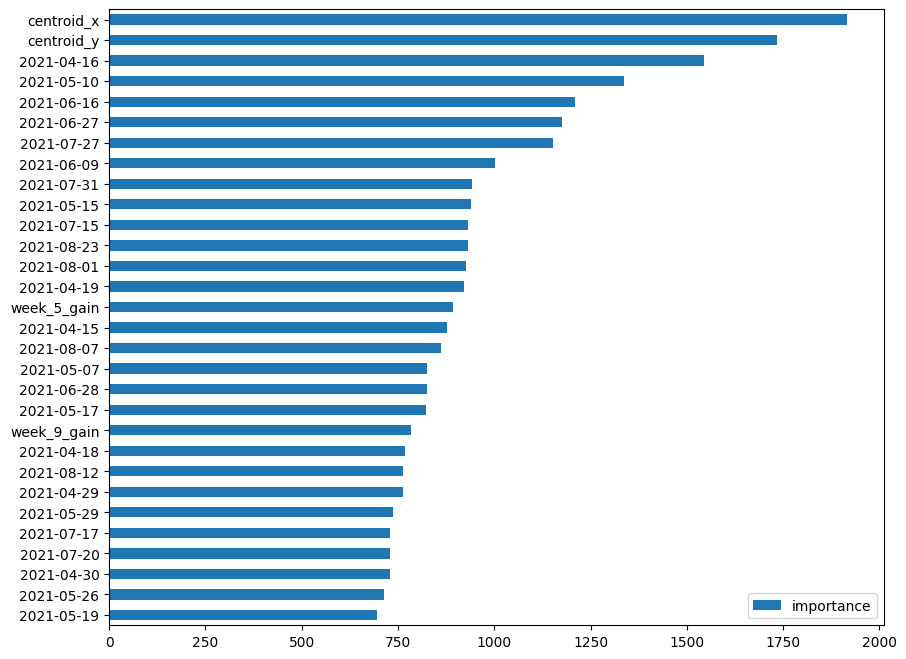

In [40]:
lgbm_feat = pd.DataFrame({'importance': lgbmodel.feature_importance()}, index=X.columns)
lgbm_feat.nlargest(30, columns='importance').sort_values(by='importance').plot(kind='barh', figsize=(10, 8
                                                                                                    ))

In [33]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

pred = lgbmodel.predict(X_test).argmax(axis=1)

confusion = confusion_matrix(y_test, pred)
print('Confusion Matrix\n')
print(confusion)

print('\nClassification Report\n')
print(classification_report(y_test, pred, digits=4))

Confusion Matrix

[[77  0  0  0  2  0  1]
 [ 0 67  0  0  0  0  0]
 [ 0  0 74  0  1  0  1]
 [ 0  0  0 62  0  0  0]
 [ 2  0  0  0 68  0  1]
 [ 0  0  0  0  0 63  0]
 [ 0  0  0  0  0  0 64]]

Classification Report

              precision    recall  f1-score   support

           0     0.9747    0.9625    0.9686        80
           1     1.0000    1.0000    1.0000        67
           2     1.0000    0.9737    0.9867        76
           3     1.0000    1.0000    1.0000        62
           4     0.9577    0.9577    0.9577        71
           5     1.0000    1.0000    1.0000        63
           6     0.9552    1.0000    0.9771        64

    accuracy                         0.9834       483
   macro avg     0.9840    0.9848    0.9843       483
weighted avg     0.9837    0.9834    0.9834       483



## Pred

In [27]:
pred_df = pd.DataFrame(lgbmodel.predict(df_test).argmax(axis=1), columns=['crop'])
pred_df['id'] = pd.read_csv('data/sample_solution.csv').id
pred_df[['id', 'crop']].to_csv('data/submission_13.csv', index=False)

In [34]:
X.columns

Index([        'area',     2021-04-16,     2021-04-19,     2021-04-22,
           2021-04-26,     2021-04-28,     2021-05-02,     2021-05-04,
           2021-05-07,     2021-05-16,     2021-05-17,     2021-05-21,
           2021-05-26,     2021-05-27,     2021-05-29,     2021-06-06,
           2021-06-09,     2021-06-13,     2021-06-16,     2021-06-18,
           2021-06-19,     2021-06-20,     2021-06-22,     2021-06-25,
           2021-06-27,     2021-07-07,     2021-07-08,     2021-07-09,
           2021-07-13,     2021-07-15,     2021-07-17,     2021-07-20,
           2021-07-26,     2021-07-27,     2021-07-29,     2021-07-31,
           2021-08-07,     2021-08-12,     2021-04-15,     2021-04-18,
           2021-04-25,     2021-04-27,     2021-04-29,     2021-04-30,
           2021-06-07,     2021-06-12,     2021-06-28,     2021-08-01,
           2021-08-11,     2021-05-01,     2021-05-03,     2021-05-10,
           2021-05-15,     2021-06-02,     2021-06-03,     2021-07-04,
      